In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
def set_parameters_from_optimized(n,n_optim):
    links_i = n.links.index
    n.links.loc[links_i, 'p_nom'] = n_optim.links['p_nom_opt'].reindex(links_i, fill_value=0.)
    n.links.loc[links_i, 'p_nom_extendable'] = False

    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False


    stores_extend_i = n.stores.index[n.stores.e_nom_extendable]
    n.stores.loc[stores_extend_i, 'e_nom'] = n_optim.stores['e_nom_opt'].reindex(stores_extend_i,fill_value=0.)
    n.stores.loc[stores_extend_i, 'e_nom_extendable'] = False
    
    return n

def prepare_network(n):
    n.add("Generator", "load_shedding",
                bus="elec",
                carrier='load',
                marginal_cost=1e6,  # Eur/kWh
                p_nom=1e9  # kW
                )
   # n.loads["p_set"]=n.loads["p_set"]+50
    return n

def get_storeage_bid_de(n, snapshots, bus, charger, discharger):
    charge_efficiency = n.links.efficiency[charger]
    discharge_efficiency = n.links.efficiency[discharger]
    #λ = n.stores_t.mu_state_of_charge.loc[snapshots,"DE H2 storage"]
    λ = n.buses_t.marginal_price.loc[snapshots, bus] 
    if "mu_lower_e" in n.stores_t:
        if bus + " storage" in n.stores_t.mu_lower_e.columns:
            mu_lower = n.stores_t.mu_lower_e.loc[snapshots, bus + " storage"]
        else: mu_lower =0
        if bus + " storage" in n.stores_t.mu_upper_e.columns:
            mu_upper = n.stores_t.mu_upper_e.loc[snapshots, bus + " storage"]
        else: mu_upper=0
    charging_bid = charge_efficiency * λ
    discharging_bid =  λ/discharge_efficiency
    return charging_bid, discharging_bid  



def solve_network_de_rh_sp(n, opti_n, add_h2_bidding, add_battery_didding, rh_each_snapshot, rh_2w):
    solver_name = "gurobi"

    freq = 1


    length = len(n.snapshots)
    if rh_each_snapshot == True:
        loop_num = len(n.snapshots)-1
        kept = 1
        overlap = 0
        
    if rh_2w == True:
        window = 14 * 24 // freq
        overlap = 7 * 24 // freq
        kept = window - overlap
        loop_num = length // kept
        
        
    if add_h2_bidding == True:
        h2_charging_bid, h2_discharging_bid = get_storeage_bid_de(opti_n,n.snapshots, "DE H2", "DE H2 electrolysis", "DE H2 to power")
        n.links_t.marginal_cost["DE H2 electrolysis"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE H2 electrolysis"] = - h2_charging_bid
        n.links_t.marginal_cost["DE H2 to power"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE H2 to power"] = h2_discharging_bid
    if add_battery_didding == True:
        battery_charging_bid, battery_discharging_bid = get_storeage_bid_de(opti_n,n.snapshots, "DE battery", "DE battery charge", "DE battery discharge")
        n.links_t.marginal_cost["DE battery charge"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE battery charge"] = - battery_charging_bid
        n.links_t.marginal_cost["DE battery discharge"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE battery discharge"] = battery_discharging_bid

    for i in range(loop_num):
        # set initial state of charge
        snapshots = n.snapshots[i * kept:(i + 1) * kept + overlap]        
        if i == 0:
            n.stores.e_initial = opti_n.stores_t.e.iloc[0]
            n.storage_units.state_of_charge_initial = opti_n.storage_units_t.state_of_charge.iloc[-1]
        else:
            n.stores.e_initial = n.stores_t.e.iloc[i * kept - 1]

            n.storage_units.state_of_charge_initial = n.storage_units_t.state_of_charge.iloc[i * kept - 1]
        #n.lopf(pyomo=False, solver_name="gurobi", solver_logfile=None, snapshots=snapshots,  keep_shadowprices=True)
        pypsa.linopf.network_lopf(n,snapshots,solver_name="gurobi", solver_logfile=None,
                                     keep_shadowprices=True)
    
    return n


    

In [3]:
# Perfect foresight:  sovled network
n_de = pypsa.Network("data/DE-2050-steel_tanks.nc")

Importing PyPSA from older version of PyPSA than current version 0.17.1.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network DE-2050-steel_tanks.nc has buses, generators, links, loads, stores


In [4]:
n_network = n_de.copy()
n_network.lopf(pyomo=False, solver_name="gurobi", solver_logfile=None, keep_shadowprices=True )

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver



--------------------------------------------
--------------------------------------------

Using license file /Users/linyang/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-31
Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3pvtqos5.lp
Reading time = 0.15 seconds
obj: 61336 rows, 29208 columns, 121243 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61336 rows, 29208 columns and 121243 nonzeros
Model fingerprint: 0x95e94113
Coefficient statistics:
  Matrix range     [1e-03, 3e+00]
  Objective range  [9e+02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 33549 rows and 7254 columns
Presolve time: 0.10s
Presolved: 27787 rows, 21954 columns, 77521 nonzeros

Ordering time: 0.01s

Ba

INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+06


('ok', 'optimal')

In [5]:
n_operation = n_de.copy()
n_operation = set_parameters_from_optimized(n_operation,n_network )
n_operation = prepare_network(n_operation)
#operation_network.loads["p_set"]=operation_network.loads["p_set"]+50
n_operation.lopf(pyomo=False, solver_name="gurobi", solver_logfile=None, keep_shadowprices=True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7uubqzql.lp
Reading time = 0.14 seconds
obj: 67160 rows, 32120 columns, 105120 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 67160 rows, 32120 columns and 105120 nonzeros
Model fingerprint: 0x99073a95
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58400 rows and 12150 columns
Presolve time: 0.08s
Presolved: 8760 rows, 19970 columns, 37490 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.168e+04
 Factor NZ  : 1.051e+05 (roughly 12 MBytes of memory)
 Factor Ops : 1.424e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective      

('warning', 'infeasible or unbounded')

In [6]:
n_de_rh = n_de.copy()
n_de_rh = set_parameters_from_optimized(n_de_rh, n_operation)
n_de_rh = prepare_network(n_de_rh)
n_de_rh.stores.e_cyclic = False
n_de_rh = solve_network_de_rh_sp(n_de_rh, n_operation, add_h2_bidding = False, add_battery_didding = False, rh_each_snapshot = False, rh_2w = True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ao9c_94.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x28efa4a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 6772 rows and 1403 columns
Presolve time: 0.01s
Presolved: 956 rows, 2293 columns, 4255 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.281450e+02   0.000000e+00      0s
    1191    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1191 iterations and 0.03 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zntu89wo.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xf77ecb3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6768 rows and 1411 columns
Presolve time: 0.01s
Presolved: 960 rows, 2285 columns, 4251 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.080770e+02   0.000000e+00      0s

Solved in 1078 iterations and 0.02 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bwh8biqc.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x01e31191
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6048 rows and 698 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n2q1z6qu.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x1e14021c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 6737 rows and 1427 columns
Presolve time: 0.01s
Presolved: 991 rows, 2269 columns, 4266 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.078303e+02   0.000000e+00      0s
     858    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 858 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zhe_8vnv.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x2e3818f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 6721 rows and 1432 columns
Presolve time: 0.01s
Presolved: 1007 rows, 2264 columns, 4277 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.582786e+02   0.000000e+00      0s
     724    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 724 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t2z14bsh.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xc42e5ef2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 6720 rows and 1435 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2261 columns, 4275 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.553832e+02   0.000000e+00      0s
     761    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 761 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1niq92w6.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xf7958f90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 6720 rows and 1439 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2257 columns, 4271 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.491409e+02   0.000000e+00      0s
     741    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 741 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cstxu2e8.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xd401da17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 6720 rows and 1436 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2260 columns, 4274 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.493315e+02   0.000000e+00      0s
     752    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 752 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8b8jq06x.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x580416d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6720 rows and 1435 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2261 columns, 4275 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.527130e+02   0.000000e+00      0s
     736    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 736 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p2b_46r2.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x8916fff4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 6720 rows and 1434 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2262 columns, 4276 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.564914e+02   0.000000e+00      0s
     780    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 780 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.27s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dughuhbb.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x67577661
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6720 rows and 1426 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2270 columns, 4284 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.661424e+02   0.000000e+00      0s
     863    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 863 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7_5k9bcu.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x63cddee4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6721 rows and 1412 columns
Presolve time: 0.01s
Presolved: 1007 rows, 2284 columns, 4297 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.776815e+02   0.000000e+00      0s
     866    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 866 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ngcvzr6.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x4a10c817
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 6720 rows and 1383 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2313 columns, 4327 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.113633e+02   0.000000e+00      0s

Solved in 1093 iterations and 0.02 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rag5msrk.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x66c63c29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+09]
Presolve removed 6723 rows and 1372 columns
Presolve time: 0.01s
Presolved: 1005 rows, 2324 columns, 4332 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.309589e+02   0.000000e+00      0s

Solved in 751 iterations and 0.02 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2bfdlv61.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x7e55e0ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+09]
Presolve removed 6751 rows and 1391 columns
Presolve time: 0.01s
Presolved: 977 rows, 2305 columns, 4288 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790281e+02   0.000000e+00      0s

Solved in 1043 iterations and 0.02 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gvvjojlx.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x14620bfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6733 rows and 1370 columns
Presolve time: 0.01s
Presolved: 995 rows, 2326 columns, 4327 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.477959e+02   0.000000e+00      0s
    1149    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1149 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ibwri53q.lp
Reading time = 0.01 seconds
obj: 5336 rows, 2552 columns, 8350 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5336 rows, 2552 columns and 8350 nonzeros
Model fingerprint: 0x2cc92853
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e+06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 4640 rows and 938 columns
Presolve time: 0.01s
Presolved: 696 rows, 1614 columns, 3004 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.237511e+02   0.000000e+00      0s
     777    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 777 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


In [7]:
n_de_rh_sp_h2 = n_de.copy()
n_de_rh_sp_h2 = set_parameters_from_optimized(n_de_rh_sp_h2, n_operation)
n_de_rh_sp_h2 = prepare_network(n_de_rh_sp_h2)
n_de_rh_sp_h2.stores.e_cyclic = False
n_de_rh_sp_h2 = solve_network_de_rh_sp(n_de_rh_sp_h2, n_operation, add_h2_bidding = True, add_battery_didding = False, rh_each_snapshot = True, rh_2w = False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ok8yp1i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd544a38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.106514e+00   0.000000e+00      0s
       2   -1.1890461e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.189046148e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uo9tdez0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5714554b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.053764e+00   0.000000e+00      0s
       2    7.5744942e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.574494233e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2jb6wymj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2502114
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.790000e-01   0.000000e+00      0s
       2    6.4092953e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.409295325e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-84r2dyqg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3ee5287
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x1rap0ek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x457d6e3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-brbfmuzl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x520863fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.744130e-01   0.000000e+00      0s
       2   -4.1895543e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.189554326e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.19e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-foxas5db.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3828fb1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.785930e-01   0.000000e+00      0s
       2   -1.2978911e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.297891074e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e4gfocks.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82c826f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yqgzxm3e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6eba108c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8hfk4ljc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfeca94e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-72dpbkbf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27705812
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxtuifhc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ca38296
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3l_ipzkm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45d27f0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iagurpqx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1efeefa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r04n6vo5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25d7c955
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wz5w88zh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fe64b1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2weuwmkm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae55e159
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i5sqr4a4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cab6221
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ljejq8ut.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x149ab7b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.251700e-02   0.000000e+00      0s
       2   -2.2677455e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.267745521e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bwr214qv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f7fb662
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wc5o1v9n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x728594a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s7826uv5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a540f5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.691400e-01   0.000000e+00      0s
       2   -8.9147199e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.914719877e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.91e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2uk68qe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2531c5cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.598680e-01   0.000000e+00      0s
       2   -4.8424048e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.842404847e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.84e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mc_wff89.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf08f3e16
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.637270e-01   0.000000e+00      0s
       2   -9.1576817e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.157681711e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.16e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-07j2m0mc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30db46e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.338530e-01   0.000000e+00      0s
       2   -1.9475548e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.947554770e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qnvrlck4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1102daf3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.245700e-01   0.000000e+00      0s
       2   -1.9892214e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.989221400e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wdoorb64.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b7dc4b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.397830e-01   0.000000e+00      0s
       2   -1.4720893e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.472089278e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uwznnfb2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39b3c6dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ymreqof.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30011559
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jii29wt9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92771d63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.833430e-01   0.000000e+00      0s
       2   -1.2765708e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.276570758e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.28e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-00yw3c5o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8cc6074
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.659060e-01   0.000000e+00      0s
       2   -8.2902366e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.290236597e-02


INFO:pypsa.linopf:Optimization successful. Objective value: -8.29e-02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0kyjcs3x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb551ceb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.206030e-01   0.000000e+00      0s
       2    3.9406739e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.940673908e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.94e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b1izrz_b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3825ed4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.661560e-01   0.000000e+00      0s
       2    4.6506186e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.650618613e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m5_a11u9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x382d3e94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.421350e-01   0.000000e+00      0s
       2    2.7177481e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.717748062e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s6u5ldms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed6506e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.177930e-01   0.000000e+00      0s
       2    7.7987472e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.798747177e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 7.80e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vwa1e0kl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1643c200
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lsl41mjw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x110752e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2hhplsnm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79eca7a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.002341e+00   0.000000e+00      0s
       2    6.7730655e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.773065497e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2sog2d8h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cd08637
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qp8y3xek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec354ccb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221199e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i_uugxe_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa246c191
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221261e+00   0.000000e+00      0s
       2    3.1503541e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.150354140e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_qs79zy8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b943345
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hvoie5gb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f2aa146
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221200e+00   0.000000e+00      0s
       2   -7.3305979e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.330597948e-02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.33e-02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yyxb5ev8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ddd4e8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.611540e-01   0.000000e+00      0s
       2   -9.2731705e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.273170497e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.27e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_msq6mmh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc24472b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7u6_07s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f82c47a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.889300e-01   0.000000e+00      0s
       2    5.0055521e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.005552056e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cob1xl51.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3902d75
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.616340e-01   0.000000e+00      0s
       2    4.5801432e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.580143173e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xtkp9f19.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4311340a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.842820e-01   0.000000e+00      0s
       2    4.9331129e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.933112853e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lxzqor1k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5df89556
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.446910e-01   0.000000e+00      0s
       2    5.8745887e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.874588719e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgdr67xp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d03ee3c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.219870e-01   0.000000e+00      0s
       2    5.5207463e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.520746277e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7jr1lycq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6980b09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.532820e-01   0.000000e+00      0s
       2    6.0084797e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.008479682e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ugz7m0un.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d807125
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.309500e-01   0.000000e+00      0s
       2   -1.0628873e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.062887329e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-icuw8wal.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fc2f442
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6xs5m4ir.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x969910da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.293460e-01   0.000000e+00      0s
       2    4.0769338e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.076933837e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cgxgqyk3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70dee2ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.796450e-01   0.000000e+00      0s
       2    3.3023424e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.302342435e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9_2h1v_d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10008b02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.109110e-01   0.000000e+00      0s
       2    2.2311212e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.231121224e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2kmpwz34.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x639f170f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.418820e-01   0.000000e+00      0s
       2   -1.1612166e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.161216627e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nhtk6y8f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9850221a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.638040e-01   0.000000e+00      0s
       2   -9.1542256e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.154225575e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.15e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-firdu7fj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8ad38e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.839690e-01   0.000000e+00      0s
       2   -1.2737610e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.273760965e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7xp0721z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19f3ce3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ljspclm4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5078fbf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tmz5by8e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5aade3b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.088250e-01   0.000000e+00      0s
       2   -1.1621951e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.162195117e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bujb63fh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f1cfc21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.032360e-01   0.000000e+00      0s
       2   -1.6361300e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.636130034e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3namhpnz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9724b272
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o1cwhpak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e61c508
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mb2s5nhz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9dfdd65e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_2baasva.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf138dfa7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nilqg789.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x090a4d30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xd3287vm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc13e460
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ghph198.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x728b26ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6ln_sag.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69af2552
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-95zoaf_z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75e091b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0uau4aca.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1009bdd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mr0h_x2d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32f3a2e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s5enq7wv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47625c26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vz11m3rm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf97260c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zvth67nv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a9e2bf7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wg_0fzm_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02b3c4cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jcpe9e19.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7de1740
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5p9e1peb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd715658d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u6gpde9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc3c474a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q9qkup5i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdfd6dc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-21errwhf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46b5b5d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxn_wo54.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x868fc88f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qx4ak_5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x428940ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-obk8e2x_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab87f539
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jg9_5y13.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7314a1b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7b4jif65.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f00e015
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zyt4sqa_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d81e066
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4da2rz_r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94b276fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tbhm3sgh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ebd8bf1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jujsqls6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2ca03d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v2spz221.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c356e7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8eenrel3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7c0f24b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bwlxepc6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe85acd04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3i0_ips4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabf4e2cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-90n36rfx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ff48aa4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3t8bchu8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ab74f85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0xvj_69e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc23c8dfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9oxg8uvn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25c394a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-50ufbxoh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc2cef6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9yjgdmgt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0cd63dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c87x71bo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85d6ca60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.984500e-02   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vnf63h0z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf4d4ff2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.737850e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gnd5pjsz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd64664cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.998440e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-egfkwjwj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a07170a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.040510e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-33oafk8x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4365f5c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.790640e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w0pi6efk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf38937d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5opnxnsu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ebcc316
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4g1f7k0z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97dd4e0f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.169820e-01   0.000000e+00      0s
       2   -2.1501965e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.150196519e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rtmzlcqv.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3eda3a4f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.151660e-01   0.000000e+00      0s
       2   -2.3603610e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.360360974e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.36e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lj8axgnt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf069abe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.854970e-01   0.000000e+00      0s
       2   -3.6920504e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.692050360e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.69e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-njeu1qbl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x414628fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.892650e-01   0.000000e+00      0s
       2    3.3526509e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.352650901e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.35e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uw1zm7qs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59fd267f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.926420e-01   0.000000e+00      0s
       2   -1.2348323e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.234832312e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2u7umr7v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2815806a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-obibrw2z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c3c6329
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-myseqjvh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfee05c89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k_ze39zv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe80b30c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vreazf02.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x765eecd3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w2tyjb9a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6510cb34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91i72qb7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0068d5c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_pvr2ugp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f19c43b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.335700e-02   0.000000e+00      0s
       2   -2.3537449e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.353744943e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-htaao70j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf2086b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.541620e-01   0.000000e+00      0s
       2   -1.4075493e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.407549315e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pb1gm749.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2929d667
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mpog6ee4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc633a171
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9r8xtmub.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe24cb90a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.692070e-01   0.000000e+00      0s
       2    6.2566713e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.256671295e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-we24vjb_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa81f25f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.167383e+00   0.000000e+00      0s
       2    9.3452495e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.345249540e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s88oi1g5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cd6dae9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-neove_nh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4528ccb6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221133e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9n06jrpk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00167f65
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.7882547e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  8.788254714e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d8gligrz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x919aab73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.182113e+00   0.000000e+00      0s
       2    9.5748170e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.574816983e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wa671v4o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67cb8d74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kn76d67x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd306a1c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y71kiw_4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x651fe188
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.161940e-01   0.000000e+00      0s
       2    5.4304623e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.430462277e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.43e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cceul261.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa229c3ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.037951e+00   0.000000e+00      0s
       2    7.3280484e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.328048369e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nxwgm692.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3e75920
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.027569e+00   0.000000e+00      0s
       2    7.1662446e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.166244622e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.17e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ujuf5t4c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b22e6ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.032079e+00   0.000000e+00      0s
       2    7.2365331e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.236533092e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.24e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wnahpgzt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c5d1001
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.077859e+00   0.000000e+00      0s
       2    7.9500156e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.950015613e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8un_uei4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67e74565
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.134610e+00   0.000000e+00      0s
       2    8.8344815e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.834481461e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.83e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dkqv91dj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x756703df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9c5psqv_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6d4fcc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jmd7hmaq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf227274
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.066420e-01   0.000000e+00      0s
       2    5.2815941e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.281594102e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.28e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hg4jv75l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa191a307
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.124234e+00   0.000000e+00      0s
       2    8.6727712e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.672771224e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vg26erlm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95f2453b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.180843e+00   0.000000e+00      0s
       2    9.5550240e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.555023999e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.56e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h6p3lco7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2256451f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vaa20zbk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e19c6d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221258e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gzhzvjvq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f53ae5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221283e+00   0.000000e+00      0s
       2   -1.1487584e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.148758406e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-92ishxva.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4a3ba94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.580690e-01   0.000000e+00      0s
       2   -4.9231528e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.923152849e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.92e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gd2_9wh5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4005ce9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.791000e-03   0.000000e+00      0s
       2   -2.5044056e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.504405574e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pec65rzu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3860ec5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.215699e+00   0.000000e+00      0s
       2    1.0098256e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.009825569e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6r5v3qcl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x626ae855
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uzv9gb84.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dc14469
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221262e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m2jkis3t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0343e06
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221297e+00   0.000000e+00      0s
       2   -5.6730984e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.673098351e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-narmegcz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x474957b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lti45j61.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5009f257
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4w520wfz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0184860f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.427210e-01   0.000000e+00      0s
       2    2.2020193e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.202019327e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-63sdqalj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c3e106b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.516710e-01   0.000000e+00      0s
       2    1.3078643e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.307864268e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lmffp7as.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2572352e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nwb0h8x1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca670d5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ucrcpog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b1bcb8b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.383913e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nlkpvyzf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6cdc4f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221276e+00   0.000000e+00      0s
       2   -1.4049779e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.404977892e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1z3e2n0_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfc5646f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ijhmbz8b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe544bc22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221294e+00   0.000000e+00      0s
       2    3.3050823e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.305082318e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b98w2wwk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x350bfe8b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.216910e-01   0.000000e+00      0s
       2   -2.0674872e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.067487204e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7m_w21wr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x150d5919
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.283290e-01   0.000000e+00      0s
       2   -1.9723492e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.972349219e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gioblz86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb758df26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.215058e+00   0.000000e+00      0s
       2    1.0088266e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.008826569e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5xw98ppb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf4e1637
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vgvx7c4j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaaa6a840
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221102e+00   0.000000e+00      0s
       2   -2.3670089e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.367008926e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_u0u2940.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd4d570b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-47bcagtg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea77edd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221165e+00   0.000000e+00      0s
       2   -1.1442044e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.144204387e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xf8jf9yq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2edce1f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z0wixes2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15176e92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.734360e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-saxu858k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d8694b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.645190e-01   0.000000e+00      0s
       2   -5.8801658e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.880165754e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.88e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5lduycfe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97b29847
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.131080e+00   0.000000e+00      0s
       2    8.7794663e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.779466317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gicsh1nr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f62c94e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xwy64yf6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5330ae35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221181e+00   0.000000e+00      0s
       2   -1.4836938e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.483693847e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.48e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ya0g3wpe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe53933de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yeka1jwj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7dfa8e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221209e+00   0.000000e+00      0s
       2    1.2976872e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.297687245e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dbcomeli.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc27b2848
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-obic74q6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x538997dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.188920e-01   0.000000e+00      0s
       2   -9.0763954e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.076395403e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.08e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3rpcebe9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeba3b81e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.735560e-01   0.000000e+00      0s
       2    4.7659479e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.765947910e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ngo1wy45.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92c85ad4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5zyy1ac.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38fd2e32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7551132e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.755113177e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gjqntpfe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd6ee4d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pu3j5sbl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd230ab56
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.134398e+00   0.000000e+00      0s
       2    7.2053397e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.205339661e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2zsj3g8t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0a20def
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.070830e+00   0.000000e+00      0s
       2    7.8404685e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.840468460e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vl1inv84.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41597301
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.964250e-01   0.000000e+00      0s
       2    6.6808646e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.680864551e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qlkrtfq8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc67c911e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.303630e-01   0.000000e+00      0s
       2   -1.6782456e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.678245551e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.68e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bkmhgjia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fa200b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.311350e-01   0.000000e+00      0s
       2   -1.6435944e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.643594426e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mtz42ozx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad369743
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.008847e+00   0.000000e+00      0s
       2    6.8744618e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.874461753e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aq7m75i5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7d566d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.050671e+00   0.000000e+00      0s
       2    7.5262899e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.526289908e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2vra3xfg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed548a71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.087699e+00   0.000000e+00      0s
       2    8.1033723e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.103372275e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7vwq4ax.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08c2b745
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.047445e+00   0.000000e+00      0s
       2    7.4760126e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.476012612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.48e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cbtygue0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x465ff096
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.040714e+00   0.000000e+00      0s
       2    7.3711098e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.371109797e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sw9uxhhg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41ee4416
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.114622e+00   0.000000e+00      0s
       2    8.5229679e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.522967948e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gyyjr1lx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5810b08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.665280e-01   0.000000e+00      0s
       2   -5.4983974e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.498397433e-02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.50e-02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rpvbf8k6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d756ddb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.743410e-01   0.000000e+00      0s
       2   -4.1927861e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.192786130e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.19e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0042k3r6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaacd2b91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.105146e+00   0.000000e+00      0s
       2    8.3752842e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.375284235e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.38e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-db95s4w3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bacfb1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ghk70ci.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4b9b899
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5801814e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.580181372e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b8w7cm5e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1efcf69e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kowskxp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5202eaaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0167315e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.016731450e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1t909lok.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12821116
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.100608e+00   0.000000e+00      0s
       2    8.3045594e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.304559384e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e29r9i7x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb099362
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.899060e-01   0.000000e+00      0s
       2   -3.4941530e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.494153020e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.49e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-644td4_d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5249b4c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.336500e-02   0.000000e+00      0s
       2   -2.2190545e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.219054457e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_n7vywn7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf35a1103
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.694900e-01   0.000000e+00      0s
       2   -8.8990104e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.899010369e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.90e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p01wdcch.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b817f6f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.645250e-01   0.000000e+00      0s
       2   -4.6333761e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.633376083e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.63e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2m9b07lt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3e3a2b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.328650e-01   0.000000e+00      0s
       2   -1.5659436e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.565943589e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-82d7aqrg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73910bc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.886230e-01   0.000000e+00      0s
       2   -8.0402280e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.040228017e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.04e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ih8tpms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbac7f51f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.726470e-01   0.000000e+00      0s
       2   -4.2688211e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.268821112e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.27e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oo7l85b3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44e409d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.299960e-01   0.000000e+00      0s
       2   -6.1832060e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.183206001e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.18e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tqf_ma4i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x200d0f65
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_cepoweh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1de45a68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cw2s4lux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1095a993
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.993060e-01   0.000000e+00      0s
       2   -7.5607229e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.560722876e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.56e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pzj9o47d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ac2bbd0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.285770e-01   0.000000e+00      0s
       2    5.6234517e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.623451662e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.62e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i_tsmemj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3a5a78e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.177523e+00   0.000000e+00      0s
       2    9.5032817e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.503281711e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j4b_deu0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f5ef198
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.177791e+00   0.000000e+00      0s
       2    9.5074585e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.507458498e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1h_ol1dj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71fb969f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.034955e+00   0.000000e+00      0s
       2    7.2813556e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.281355629e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.28e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qlmy2kr5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d5c480d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.681420e-01   0.000000e+00      0s
       2    3.1230679e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.123067909e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k0e_b2u7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb2605c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q6blvh93.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a1e995c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_w6h1jxz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86f40fbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fs18ko57.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x255b9c3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i6zjez3q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x786a8143
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h0fg_2g6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac018994
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qrwij7df.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12937e8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ghlv0r4f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13011e24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7_pvktba.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7368c31e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-01x7zy4n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15052cc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hlis3wtz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dd44eb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.443100e-02   0.000000e+00      0s
       2   -2.4835790e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.483578991e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.48e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cwco_1je.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc40b6245
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.540340e-01   0.000000e+00      0s
       2    1.3446917e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.344691686e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w8oltc5r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c1a9819
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.234780e-01   0.000000e+00      0s
       2    3.9854809e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.985480944e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9fady5r7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6497b2db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.016764e+00   0.000000e+00      0s
       2    6.9978484e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.997848409e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b06dyu4g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f8f1e04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.140943e+00   0.000000e+00      0s
       2    8.9331814e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.933181435e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lw3y1inn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebec9217
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.069496e+00   0.000000e+00      0s
       2    7.8196780e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.819678035e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.82e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ideoks3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cd5610a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.191390e-01   0.000000e+00      0s
       2   -1.1159009e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.115900881e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lmetaaxu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd49f48fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.074870e-01   0.000000e+00      0s
       2   -1.6170495e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.617049510e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.62e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-paf13mwv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbcc1f218
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.970880e-01   0.000000e+00      0s
       2    6.6911974e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.691197424e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.69e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cmjlx8rj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79f4aaa9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.205350e+00   0.000000e+00      0s
       2    9.9369662e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.936966248e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.94e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5hesvhhp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9aa5df20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.203468e+00   0.000000e+00      0s
       2    9.9076352e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.907635227e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.91e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mhiwtavc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcd8dfa0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.161353e+00   0.000000e+00      0s
       2    9.2512718e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.251271829e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jpjj3geh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f44ba44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.115915e+00   0.000000e+00      0s
       2    8.5431194e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.543119388e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fo_ajr47.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf455d889
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.119173e+00   0.000000e+00      0s
       2    8.5938954e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.593895405e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c5nfrtja.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5996ced
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.648660e-01   0.000000e+00      0s
       2   -1.8083533e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.808353344e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.81e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d24zhlev.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x233acd7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.024500e-02   0.000000e+00      0s
       2   -2.5023678e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.502367801e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fjx7fjgy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4b9f63c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.157340e-01   0.000000e+00      0s
       2    2.3062878e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.306287831e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5id8rvxf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x063f0fdc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.072934e+00   0.000000e+00      0s
       2    7.8732594e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.873259356e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yj59i183.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe008b134
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.104779e+00   0.000000e+00      0s
       2    8.3695645e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.369564531e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_1u2wwqh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0bc96a7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.194500e+00   0.000000e+00      0s
       2    9.7678687e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.767868708e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xur1klna.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa00e10c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uzv_cagt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x827f97c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221079e+00   0.000000e+00      0s
       2   -1.5410415e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.541041459e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0i8xsvg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ac60f31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.938390e-01   0.000000e+00      0s
       2   -1.2294596e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.229459620e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t738omo9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10e74b8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.109900e-02   0.000000e+00      0s
       2   -2.1394556e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.139455616e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ds6so73.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7f9951e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.805220e-01   0.000000e+00      0s
       2    4.8745132e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.874513206e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-82kfktnb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef5eeaff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.393270e-01   0.000000e+00      0s
       2    5.7909907e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.790990699e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_h5bbehc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17ae6960
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.470480e-01   0.000000e+00      0s
       2    5.9113227e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  5.911322690e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.91e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mryyx_i9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55869da5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.463060e-01   0.000000e+00      0s
       2    5.8997586e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.899758600e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ttrkxl9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65aabb59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.524040e-01   0.000000e+00      0s
       2    5.9947961e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.994796092e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d3lgvzgh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02dc6158
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.259790e-01   0.000000e+00      0s
       2    5.5829618e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.582961763e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_l5dvsr5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c674dc7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fs_q8bvx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd0e44c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nzifx0ge.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43548c02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.981300e-01   0.000000e+00      0s
       2    4.7342636e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.734263551e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.73e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lh3ilv1v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb1da7e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.308960e-01   0.000000e+00      0s
       2    5.6595933e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.659593339e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t8pzzq8n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffccb3e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.790470e-01   0.000000e+00      0s
       2    6.4100280e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.410027958e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jrkycink.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf4bcf737
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.055429e+00   0.000000e+00      0s
       2    7.6004435e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.600443465e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g4xjugju.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa88e886d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.106435e+00   0.000000e+00      0s
       2    8.3953733e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.395373335e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7hncg4y1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1712534
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.168161e+00   0.000000e+00      0s
       2    9.3573747e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.357374691e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0jdhzuod.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14f499af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.198820e-01   0.000000e+00      0s
       2   -1.5614147e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.561414705e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.56e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gvb2x6yh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x385ff400
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vjv5z_2r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc641aa26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.215150e-01   0.000000e+00      0s
       2    5.5133902e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.513390204e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5768azit.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7fa56b88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ymgdu6w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c79e3af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221177e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w71aqvjx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77b54b96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221202e+00   0.000000e+00      0s
       2    5.9952013e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.995201303e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n1srprfc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4ca7669
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i92e16wt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f0c9eb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221242e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-819fk246.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde60c4ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.313200e-01   0.000000e+00      0s
       2   -1.1423668e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.142366800e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z4uo6tzy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cb15052
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.983200e-02   0.000000e+00      0s
       2   -2.1900274e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.190027407e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r0tms3p4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb4aade2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.033669e+00   0.000000e+00      0s
       2    7.2613133e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.261313284e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x35irxhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74cf9a61
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_hv6a160.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6eafcd8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221296e+00   0.000000e+00      0s
       2   -2.4529320e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.452932046e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.45e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tos4jgle.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x384d90b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wq4_ta_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5bc5b35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221292e+00   0.000000e+00      0s
       2    2.0065706e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.006570625e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0zr4381f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac260a9a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zcvtai4g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x613a2b8c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.352470e-01   0.000000e+00      0s
       2   -2.2363540e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.236353986e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.24e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6sy1pxke.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd916e4b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_3dfx40g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31e70773
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.235540e-01   0.000000e+00      0s
       2    2.4281627e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.428162714e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.43e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mmq53_3l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb58ed1cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.368970e-01   0.000000e+00      0s
       2    4.1946164e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.194616372e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6jeps4to.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf00457ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.575180e-01   0.000000e+00      0s
       2    6.0744979e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.074497854e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l_lo4fm6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x966353f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.082025e+00   0.000000e+00      0s
       2    8.0149427e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.014942748e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xkqk97ig.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2926c83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.087062e+00   0.000000e+00      0s
       2    8.0934445e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.093444527e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.09e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-adcice2t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb2aae1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.071443e+00   0.000000e+00      0s
       2    7.8500220e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.850021998e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-31ailozm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5633b48d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z58qukj3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f9cee62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3fooeepl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9df554cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.846630e-01   0.000000e+00      0s
       2   -3.7294843e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.729484347e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.73e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cg2i2s6e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbcb14513
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.174041e+00   0.000000e+00      0s
       2    9.4490145e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.449014547e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.45e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fw63wjdi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0028ed6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7m4lcr1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb371c1f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221148e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sdwaq205.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab7b457a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1479563e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.147956274e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kqia95n2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52b8627d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.165209e+00   0.000000e+00      0s
       2    9.3113676e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.311367593e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-me6co0as.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6245d668
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-49dwuvzp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ef2dbd2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xllhftea.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeec19464
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-grki9pbk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4b37e09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h7vcy0ii.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ac37489
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iall67tw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a1bf81e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hqtojb1_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc66750b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y0bhvme0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb344e5cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7mikr7_b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4788b21d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3_gzjw5y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab322f39
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u3m3x5eb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0304c557
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z82sd4jy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54f1b7cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.641300e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-24eu3nfb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4132278f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.927260e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l3ree437.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe599680f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.817350e-01   0.000000e+00      0s
       2   -1.2299663e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.229966343e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hqylh8tg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb327d806
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.004720e-01   0.000000e+00      0s
       2   -1.6485362e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.648536214e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-je0gnwq5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d751521
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.752080e-01   0.000000e+00      0s
       2   -1.7619334e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.761933365e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fh1enima.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92b2d4ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cywlvrf_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0fa4994
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3bw34ekz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe01d4a13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.355800e-01   0.000000e+00      0s
       2   -1.4909544e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.490954392e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-impkj4c8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd9a0667
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.628540e-01   0.000000e+00      0s
       2   -2.1989101e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.198910075e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.20e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-htsmo3h0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x494ec6a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.293470e-01   0.000000e+00      0s
       2    2.5184468e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.518446772e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-56uli_gi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb25739ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.330290e-01   0.000000e+00      0s
       2    4.1343335e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.134333490e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v63_57z3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff3cdb1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.275460e-01   0.000000e+00      0s
       2    4.0488808e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.048880790e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o6fgl3bl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02ecc396
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.333350e-01   0.000000e+00      0s
       2    5.6976052e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.697605158e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rr8qgyto.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd07a79ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.492250e-01   0.000000e+00      0s
       2   -5.3201146e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.320114583e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.32e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k5c7kubo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa14cd5a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.564590e-01   0.000000e+00      0s
       2   -9.4839050e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.483904990e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.48e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ey9af7q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb9537ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.693650e-01   0.000000e+00      0s
       2    4.7006310e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.700631013e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bol9uv39.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20f76fd4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.135155e+00   0.000000e+00      0s
       2    8.8429752e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.842975206e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mnrhjki4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94ec00ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0tnucyqz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2779b442
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221184e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q4joprua.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x753ce569
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221281e+00   0.000000e+00      0s
       2    4.6348466e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.634846566e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.63e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m266mccn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc2190a48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y6ank9do.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x942d4e9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.927260e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dxt_65z4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cc19aeb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.356350e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1786aky4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30ea5811
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.889570e-01   0.000000e+00      0s
       2    6.2394201e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.239420096e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.24e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_8tliglw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x136bbcb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_qnmy0ad.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ceb7d2f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221149e+00   0.000000e+00      0s
       2   -1.8305130e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.830512967e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.83e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ydrgztde.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc73b7241
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ff0dtl_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5b835a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221269e+00   0.000000e+00      0s
       2    1.2655945e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.265594531e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a2354xhr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5de2c8f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6als6lfq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2e8f952
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.007630e-01   0.000000e+00      0s
       2   -2.3729265e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.372926495e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wbluothx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58d553d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-34nju_fc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc959b49d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.374980e-01   0.000000e+00      0s
       2    4.2039829e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.203982928e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bo56xjm3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x710f8454
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pfys1z7n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12f6a15d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221167e+00   0.000000e+00      0s
       2   -2.0227818e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.022781822e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.02e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7b4v8w8x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7200dbbd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dc1wvnw3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x165cbabe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5260880e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.526087953e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o25ph036.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1abea19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xj_gxl5_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x084e6047
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352244e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yciepvah.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd40a3f2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352244e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n47dzukf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2e5fc7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352244e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x3vdtyke.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f10e8c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   8.625030e-01   0.000000e+00      0s
       1   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352244e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4hxx5zz1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c607f85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.016163e+00   0.000000e+00      0s
       2   -1.5239268e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.523926788e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.52e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tgg1pk3g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed7610b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.149481e+00   0.000000e+00      0s
       2    9.0662460e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.066246005e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rjhf_nxc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7b3c95a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.216999e+00   0.000000e+00      0s
       2    1.0118516e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.011851579e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkf4ltuy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8240444
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gbthsgpu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc300e7db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u3fu7ybz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xadb05867
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-akw_eu__.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2d1aae8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zz2csvza.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f104094
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.069737e+00   0.000000e+00      0s
       1   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hs55ckvw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4c5bd58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.187666e+00   0.000000e+00      0s
       2    4.9680293e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.968029281e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wbjc3fnl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ef84840
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1lqnrw9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48997e34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.209142e+00   0.000000e+00      0s
       2   -1.9689693e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.968969256e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o2ovvx4z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53c00242
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.139647e+00   0.000000e+00      0s
       2    8.9129827e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.912982669e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.91e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h1kk2v97.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85243d32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8kvd9g2j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d137ee9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cc8jvpiv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3dee9664
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ajwi0dy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa431347f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   6.160520e-01   0.000000e+00      0s
       1   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352187e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6wpwq72u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4528063d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   9.179780e-01   0.000000e+00      0s
       2   -1.6992866e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.699286570e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a673v68o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d03bc73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   1.116351e+00   0.000000e+00      0s
       2    8.5499138e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.549913819e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-flwkt2wf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9f7fd1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.145044e+00   0.000000e+00      0s
       2    8.9970950e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.997094956e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n_e95ere.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5b15d81
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.039777e+00   0.000000e+00      0s
       2    7.3565061e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.356506077e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wxbsgtgh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x152b3ef9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-auwzk02o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x969bf582
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zm6dxhg5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9114a19e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6i836iuc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35966e77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   8.851570e-01   0.000000e+00      0s
       1   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-746t9_1v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x793f56f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.163810e+00   0.000000e+00      0s
       2    2.1250026e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.125002642e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9hyvvzyj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd41428a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w8vk2zma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0749a669
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.221239e+00   0.000000e+00      0s
       1   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-21wwmqt_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3923e27c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.463234e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8gqp049p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d590ec6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v55pqi8h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd08d2eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-okqhc2jj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce6c51d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   8.115280e-01   0.000000e+00      0s
       2   -5.0479009e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.047900938e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.05e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hza4e79v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb7686cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2r522q9_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3633ff6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.221128e+00   0.000000e+00      0s
       1   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4_d9l0j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c219cd8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9803150e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.980315039e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.98e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4jyn8gfs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf95518bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nopo1fi6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05b15eee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4866691e+01   1.845154e-01   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-urp3wsse.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaccf43a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.6518010e-06   9.800700e-02   0.000000e+00      0s
       2   -7.9856820e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.985682000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c52eqsho.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xded612c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5162950e-06   0.000000e+00   0.000000e+00      0s
       0   -8.5162950e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -8.516295000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5_uxco7y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x598969b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5162950e-06   1.367850e-01   0.000000e+00      0s
       2   -6.4645200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.464520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzjh5wm0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ec32e99
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   8.122660e-01   0.000000e+00      0s
       2    1.1818128e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.181812833e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qtobkbue.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x833433c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   7.664680e-01   0.000000e+00      0s
       2    9.2733667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.273366667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s6lb9yhw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8e9d346
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   8.299060e-01   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fq6b9jjx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95037456
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   9.773560e-01   0.000000e+00      0s
       2   -5.0994636e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.099463600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f2pyzslr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe006b657
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   9.739950e-01   0.000000e+00      0s
       2    1.5572610e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.557261000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q591a5af.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x229e3d78
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kzbt389d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d43b62e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u_nouu4i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68794d11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8mlfo599.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8481628
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   6.201170e-01   0.000000e+00      0s
       1   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8p9m7gr8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf258e1d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   7.175750e-01   0.000000e+00      0s
       1   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-41un6ped.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0bc9f55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   7.824880e-01   0.000000e+00      0s
       2    6.5728062e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.572806167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3nemp__0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccc5f759
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   7.496090e-01   0.000000e+00      0s
       2    5.7587733e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.758773333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rlkoiryn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c29251a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   5.926530e-01   0.000000e+00      0s
       2    7.4700000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.470000000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.47e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0f5chnog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cab8424
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cbgdvlwx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8036435
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j91623eb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e1ea884
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-85wysyhw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17cdbba1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   5.392660e-01   0.000000e+00      0s
       1   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d5p95ia5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c21bc27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   5.796340e-01   0.000000e+00      0s
       1   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ra_29yk1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0dfcacb0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   5.025950e-01   0.000000e+00      0s
       2   -2.3289848e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.328984800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sisn7o9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x987d002f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   5.351010e-01   0.000000e+00      0s
       2   -2.6121600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.612160000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.61e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y1wm_lqo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59935cfa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   5.415360e-01   0.000000e+00      0s
       2   -2.0973600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.097360000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.10e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m46ildmp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f872f25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ntur_ly.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72661f6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l0rvn1e3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68dca627
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-frkh6e97.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17525939
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.068191e+00   0.000000e+00      0s
       2    1.4179077e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.417907667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zbsc0a_r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68b49ddd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.155602e+00   0.000000e+00      0s
       2    1.6655722e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.665572167e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yktzp26y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x074331e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_w66zcx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x714c0efe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.221147e+00   0.000000e+00      0s
       2   -3.4678008e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.467800800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7rktr0js.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xadbab8ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-boje4l5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41f4a8f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9hmis2cm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdedef627
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tgk06g9n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd18e2e2e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   2.237090e-01   0.000000e+00      0s
       2   -3.1154960e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.115496000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kwjq5ug5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a9d3b9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   9.712140e-01   0.000000e+00      0s
       2    1.1431395e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.143139500e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9poajjj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb49a298e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   5.939930e-01   0.000000e+00      0s
       2    7.4346667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.434666667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__ft9hf3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a388d62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   3.349330e-01   0.000000e+00      0s
       2   -1.8625600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.862560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mb69_lj3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5848b308
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.108040e-01   0.000000e+00      0s
       2   -3.6555920e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.655592000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1wikc7mf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc455793d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.211500e-01   0.000000e+00      0s
       2   -3.5728240e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.572824000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o8cu0dtd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd05cb7dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vgjquud3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a07af9b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qa9fjw4a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7070f50a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   5.796400e-01   0.000000e+00      0s
       2    3.1698667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.169866667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-swtmvg6t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e5b0850
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   8.104040e-01   0.000000e+00      0s
       2    6.4706933e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.470693333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fruv4uip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71696678
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   8.199400e-01   0.000000e+00      0s
       2    6.7249867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.724986667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s4j4qyiw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94d3ed33
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   7.950940e-01   0.000000e+00      0s
       2    6.0624267e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.062426667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g3lvdug0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b2d623b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   7.270960e-01   0.000000e+00      0s
       2    4.2491467e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.249146667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xlcd4g29.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81e47d0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   6.119170e-01   0.000000e+00      0s
       2    1.1777067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.177706667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cudbskrt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c577e49
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_qy4qi6t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee5f254b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wpoikj2w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30a9cd78
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-agu2of58.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6eafcffd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   6.909430e-01   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vvf2n0cs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x219a3a27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   8.943340e-01   0.000000e+00      0s
       2   -2.2913870e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.291387000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jlomujrx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcd4d815
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.153517e+00   0.000000e+00      0s
       2    1.4644100e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.464410000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffh_4o6m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54dcd4dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e8svqx34.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe0af12f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.221080e+00   0.000000e+00      0s
       2   -6.1544630e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.154463000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.15e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2hsj3eu3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd34dd958
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-729ah24e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1988a78
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b2puqapx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec5644da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tw8ip8xt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x512c13bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rxwijrsh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfd92241
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.221187e+00   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jwx0whv1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a12caad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.221197e+00   0.000000e+00      0s
       2    4.5626200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.562620000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1rveu1e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11865c50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1_jvxndu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5933e795
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.221068e+00   0.000000e+00      0s
       2    5.0448500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.044850000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qoqb_mk2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26211ca1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o6weithp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc72dedbf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k3nlbs3n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61e83f5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v_j54m4b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0170af70
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   5.013490e-01   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dlqhpq8w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ac6d4f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   6.169860e-01   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lwxo7a_6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5295851
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   9.030180e-01   0.000000e+00      0s
       2    2.7183750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.718375000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5sz81_iy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x147b6909
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.075862e+00   0.000000e+00      0s
       2    1.1855877e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.185587667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jiqvdb24.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8eded195
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.175631e+00   0.000000e+00      0s
       2    1.4183820e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.418382000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i01o2o3z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6f9c23d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aosy3hky.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x154581cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ynqzvui.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe959cc15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.401960e-01   0.000000e+00      0s
       2   -2.9928990e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.992899000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-befunvjm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4811832a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.164154e+00   0.000000e+00      0s
       2    1.3916023e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.391602333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3u9a7u_d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc51b51c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ykhuf3yb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x942621c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.221121e+00   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3__kpyvc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9065c66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.3948447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.394844667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-34y2vrv3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62990dd7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-976fykvb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85e8ff79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgf_prpm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9476e3fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7a09jwvb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x379041ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-597t8h1d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1de1e14f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   6.544370e-01   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o1nyifwe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ca0e5db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   3.601180e-01   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a1y098pv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19ae4d3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   3.365630e-01   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c5cz8jsk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85055250
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.576740e-01   0.000000e+00      0s
       2   -3.0400797e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.040079700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bi89mwym.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b57d059
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hru2jnyz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5dd59415
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f_b2exgv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x774c449d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kykvc357.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a9c3804
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l97218dc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccdd8550
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.378580e-01   0.000000e+00      0s
       2   -7.7937000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.793700000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.79e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_40_drbe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22de8a30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.856880e-01   0.000000e+00      0s
       2    3.8859167e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.885916667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.89e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rax3nood.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a61b259
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.320490e-01   0.000000e+00      0s
       2   -2.1422400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.142240000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-80b7l8fg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38c32e2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   2.606840e-01   0.000000e+00      0s
       2   -1.8424140e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.842414000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qaoo2cdt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a951259
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1yh4fp1n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8932f7d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eaqwq57c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81ef2a91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-olc0x8u4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x951e947a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otj4rnyt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66915e64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.183400e-02   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rnus1rup.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1179ab09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   2.657400e-02   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d9awr_r9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2596c768
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jrdx39cl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cfecf1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   3.492000e-02   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-564ygsfk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd00a15f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   2.379630e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7iaoo67w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d44bd36
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fm6tr2xq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67974fc3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bbsu53rf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x306b1c2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sdn4p0ri.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa85d64b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.285750e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_trzp35o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58ddb192
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.917510e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0rtv_fa6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a1c9d74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.558220e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z0kidlxq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5404feef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.386380e-01   0.000000e+00      0s
       2   -2.1684342e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.168434200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1uv3p5v8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3173b8e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.248390e-01   0.000000e+00      0s
       2    1.2368633e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  1.236863333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2gryc3y7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2db36f66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hhyr5lyw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x714a7be3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dkh2bust.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x290230ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2yllcmsh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc6f8587
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.261900e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1z7dsmo3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x704f9ee0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.301010e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8aogxavx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x175b8681
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.647210e-01   0.000000e+00      0s
       2   -1.1496366e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.149636600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9j3by8ff.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c6cbef7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.335230e-01   0.000000e+00      0s
       2    7.9250167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.925016667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qrpuh9a_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x143f22d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.092028e+00   0.000000e+00      0s
       2    1.1359292e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.135929167e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-up7m59iu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e666a9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ycfvdwbk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8592cb8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t4rzy4hs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2481c29c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.343200e-02   0.000000e+00      0s
       2   -3.0859260e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.085926000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eky1c7k9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45a0e64c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.187248e+00   0.000000e+00      0s
       2    1.3422392e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.342239167e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-41802z4h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25e0bd9b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.190347e+00   0.000000e+00      0s
       2    1.3489537e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.348953667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.35e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_92e_coq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef95b448
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z85fam99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd72fc9f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.221032e+00   0.000000e+00      0s
       2   -3.1023540e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.102354000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2lab22wb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8dbdbda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.161615e+00   0.000000e+00      0s
       2    1.2867010e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.286701000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vatlxfhc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7011091d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rmgplb36.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10d0f58a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-alj1caa8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8df2114
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   3.966830e-01   0.000000e+00      0s
       2   -1.0264200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.026420000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-turj8p67.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ff5ddba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.128912e+00   0.000000e+00      0s
       2    1.1223180e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.122318000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-beppx4w9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0b0eb25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.023044e+00   0.000000e+00      0s
       2    9.1058200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.105820000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zne0i754.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f59d3fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.820130e-01   0.000000e+00      0s
       2    8.2852000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.285200000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fd2lbfe8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a5886cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.646000e-01   0.000000e+00      0s
       2    7.9369400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.936940000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dmqrsuh9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebd22ccb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.180370e-01   0.000000e+00      0s
       2    5.0056800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.005680000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-40m6u924.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc96b9ad6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cf_w0yda.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1db8c20a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xxr3472u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc20a17cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mpaqy4_c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4d4f5a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.609070e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kjd_imem.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd11fa6c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.268850e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mpw2gshy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7adf9892
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.127440e-01   0.000000e+00      0s
       2   -1.8724914e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.872491400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v1f3ay_w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15d1e5c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.411750e-01   0.000000e+00      0s
       2    3.4684400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.468440000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kbrmw3lb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x579012db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.980810e-01   0.000000e+00      0s
       2    2.6065600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.606560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w7rwfe2d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a8aba10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1bs04yi0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42f0ffaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i2f5tmig.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3b08dbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lmrcq0w2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c1f81d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.188910e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tubrrww6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46b53621
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.035400e-01   0.000000e+00      0s
       2   -1.1411208e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.141120800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z6k8wmbv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32a0b66b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.058725e+00   0.000000e+00      0s
       2    9.8194400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.819440000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y_cpfqwe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68e76c12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-juu78uku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac006aab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.221095e+00   0.000000e+00      0s
       2   -4.3551120e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.355112000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.36e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-33ky0124.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf4ce12f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ezlmjobl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x993fb64c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-692drxr8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c511747
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hypgi56h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8260b4b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.221190e+00   0.000000e+00      0s
       2   -3.1931274e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.193127400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-omj8y4o3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x239a9a3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.920470e-01   0.000000e+00      0s
       2    8.4858800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.485880000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-am9twc9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6607d3bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.980330e-01   0.000000e+00      0s
       2    8.6056000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.605600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vl9bitox.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb88c3751
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aw2bwwd3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc37d980c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.133625e+00   0.000000e+00      0s
       2   -1.2038040e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.203804000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.20e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2n6h5ycf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x816d5e96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_jkgbrd9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeff2465f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rac9ra9q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91ba0439
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eq4_cv_p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x428e05a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.466390e-01   0.000000e+00      0s
       2    7.5777200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.577720000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p0_ad4fs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80fc1495
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.903410e-01   0.000000e+00      0s
       2    8.4517600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.451760000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-08qs__4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2167106e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.190070e+00   0.000000e+00      0s
       2    1.2446340e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.244634000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vd10j24i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47e3f6ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uwf7izs2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x318c751b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.092083e+00   0.000000e+00      0s
       2   -3.3479160e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.347916000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.35e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kvi29_yf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3daaf885
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vivti40i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe19d9854
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b42i6fnr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cf96789
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tbwgap5d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6756017
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.221032e+00   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v2gm2h_u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc94e79ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2362180e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.236218000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-222qdmow.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7689829
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7bzq_07.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x128858ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.221329e+00   0.000000e+00      0s
       2   -1.4686908e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.468690800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d9a717kr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ed47b30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p5g5a2i_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x770aaee8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r2tiwwec.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52681f68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-195wfql8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38b53fe8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zh8rret2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b0e06e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.017612e+00   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8b6k2wfs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19798e47
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.079559e+00   0.000000e+00      0s
       2    2.7801180e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.780118000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5o6lrdp4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5615fa4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hdgm5_b8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13f0572a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.221100e+00   0.000000e+00      0s
       2   -2.7893010e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.789301000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xz825nbs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb9e857b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.061646e+00   0.000000e+00      0s
       2    9.8778600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.877860000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wydg754q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48652f88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6wg82l3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa052fe0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pv1wvzge.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b7a2679
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_lrph51.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x420c3479
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.082340e+00   0.000000e+00      0s
       2    9.4340950e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.434095000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-28dkk3io.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9f65b95
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.162157e+00   0.000000e+00      0s
       2    1.0897407e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.089740667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-886_xu64.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9dca2d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.198695e+00   0.000000e+00      0s
       2    1.1567270e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.156727000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mg2l02wy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14e59037
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v1myarox.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe192aa90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.212878e+00   0.000000e+00      0s
       2   -2.0671685e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.067168500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1606171e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef6840f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cj6o7qhq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31ebeff9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pi5hizks.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7bd02ee4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.265290e-01   0.000000e+00      0s
       2   -7.0612000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.061200000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.06e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ff77k8_o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ec8c03f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.014024e+00   0.000000e+00      0s
       2    8.1816350e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.181635000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-03lc4d34.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e0772cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.121276e+00   0.000000e+00      0s
       2    1.0147922e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.014792167e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s64o2c3f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb193454c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.197650e+00   0.000000e+00      0s
       2    1.1548112e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.154811167e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eiq6pfro.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd36cd009
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yuv12fjc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31132554
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.066137e+00   0.000000e+00      0s
       2    1.1293700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.129370000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mfdt52af.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6242dfe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d8mnuni_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb75c5da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6h97yfkv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37b76573
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fnsnogpl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x669db392
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.626840e-01   0.000000e+00      0s
       2   -5.2534500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.253450000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.25e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i6ckyysl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa1f82cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   5.439270e-01   0.000000e+00      0s
       2   -1.1913000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.191300000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-swgbsfcm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d090cc8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.919510e-01   0.000000e+00      0s
       2    2.2769633e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.276963333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6udx4_gj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4044fcef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.417690e-01   0.000000e+00      0s
       2    5.0236267e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.023626667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jn06n010.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94e5d4cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.649780e-01   0.000000e+00      0s
       2   -5.1387500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.138750000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ol1qghwm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fe0cbe2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-stldkwyi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe076b7b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5jzp890.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c0698c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_v9zq50.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x565482b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.219330e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s7t65vfq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdeb309d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.378610e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2tn4c3dn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40b6bc92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.562960e-01   0.000000e+00      0s
       2    6.3651500e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.365150000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 6.37e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-emqnw2px.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63c30ddb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.093644e+00   0.000000e+00      0s
       2    9.6413350e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.641335000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vunbir_7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0a84f3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.138280e-01   0.000000e+00      0s
       2    4.5113750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.511375000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9t40q7o_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f411fb9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m21ari15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04ecc45a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-awl45brx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb4edfa6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tysw6_lc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0398117b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   7.124630e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nn5bnzn2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce6191d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.853370e-01   0.000000e+00      0s
       2   -1.5740890e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.574089000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_uc3h0a0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8476247
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.060726e+00   0.000000e+00      0s
       2    9.0378383e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.037838333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_zcav20t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f7dede5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.204069e+00   0.000000e+00      0s
       2    1.1665793e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.166579333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tl3hz7sk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42ce2181
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   7.658100e-01   0.000000e+00      0s
       2    3.6310450e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.631045000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qm15hjfz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfc794e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ku3hb6jh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b2e0622
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8we89bbu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f89ed92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1v9r24g2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x697eebe0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.444640e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1xe6jk4l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60bc6056
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.113160e+00   0.000000e+00      0s
       2    2.6584433e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.658443333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a7x4y6sk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93b76d62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d9fqnn0n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0a1d684
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221210e+00   0.000000e+00      0s
       2   -1.4560085e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.456008500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j8lvy98m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16742dd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.971810e-01   0.000000e+00      0s
       2    6.0395133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.039513333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zq505ny4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd349ed3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-87ugkp1r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ab7ef90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jghzzkph.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa77be58f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o60xcmjh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4d1e455
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221145e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wi3x0j60.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46db4242
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.556960e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hq6ye9gb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31ecf080
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221328e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2bxs8gtz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8b27ce2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.543703e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0a4106oc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5688f5ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.513420e-01   0.000000e+00      0s
       2   -2.4792500e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.479250000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -2.48e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-silwyypn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d982d1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48ojen5b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0829235e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ghslosry.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce1ae7bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qv3m397x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fa45037
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221240e+00   0.000000e+00      0s
       2   -2.4106545e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.410654500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0hrdsupo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf72df35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yl26m955.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x414f34c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221104e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5580ho15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e37bcb2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.436843e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hnm8fzv8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24783adc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.367890e-01   0.000000e+00      0s
       2   -1.4080050e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.408005000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-251rh681.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba587300
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5cwou32p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x265c22db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gu53dkoi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x345e0e22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.021590e-01   0.000000e+00      0s
       2   -1.8279700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.827970000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gq_g1oe8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ba06e25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   7.245480e-01   0.000000e+00      0s
       2    2.6132500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.613250000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g8gtzqcd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7db6425c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   5.175430e-01   0.000000e+00      0s
       2   -2.5105000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.510500000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v76xthur.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38460bdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.510580e-01   0.000000e+00      0s
       2    1.3884167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.388416667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ix5o86p2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31113ecf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.668660e-01   0.000000e+00      0s
       2    4.9852167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.985216667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-may_wooo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2e6b360
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.472940e-01   0.000000e+00      0s
       2    1.3256833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.325683333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dm4aqskw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1d2dbe3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7_fkxyey.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49ad7ba0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s59kim0k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe577fa39
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hp5x1uo3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2541368e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221190e+00   0.000000e+00      0s
       2   -2.6648595e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.664859500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-axd9sdzo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x081ebc10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9vqo5m30.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d7b9bbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221084e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-13ws_hj8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86ed527e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0077943e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.007794333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-il9fqcpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42ec6b88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.564450e-01   0.000000e+00      0s
       2    4.8115333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.811533333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jo37jdty.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7b2ef1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-esrja03n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd458f67f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9xdkxhw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ddc2eda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sigtuccd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8216791c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221237e+00   0.000000e+00      0s
       2   -2.4263245e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.426324500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t30p1hll.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48cfaf25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x8i5lja8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf41fbdc7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221274e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t1965gih.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e704db8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.517524e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vm5pvq9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89df8a66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.669510e-01   0.000000e+00      0s
       2    1.0592950e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.059295000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ddsyrmp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12ee9cd8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-phwhfd9z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa46bbbaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rw8vj2kb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e10cd43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l75b42je.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7fff0f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221331e+00   0.000000e+00      0s
       2   -1.9576695e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.957669500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3n2otd7b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4e30923
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g8a9zymf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x099ae195
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221139e+00   0.000000e+00      0s
       2   -2.5064390e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.506439000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g7w3gast.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x648311e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9f6nf2v4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa923da18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.438510e-01   0.000000e+00      0s
       2   -7.4500500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.450050000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.45e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m3ddbovk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca2800bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ciu81z2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4a47d5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4muelgb8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a10a7a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-63dujumh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c7d9a71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.617900e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n4fk8it5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8609829d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.050002e+00   0.000000e+00      0s
       2   -4.1300000e-09   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.130000000e-09


INFO:pypsa.linopf:Optimization successful. Objective value: -4.13e-09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pyharbt3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca7fde22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.149024e+00   0.000000e+00      0s
       2    8.7190650e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.719065000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-avqibu51.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36f39214
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9h8kfnsm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70b006a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.088373e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jasieplb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93072d60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   2.117900e-01   0.000000e+00      0s
       2   -1.9174144e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.917414400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-893bjc9t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7b392df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5s7net3x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ef5bdf4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.720840e-01   0.000000e+00      0s
       2    6.4965000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.496500000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 6.50e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8c7_ebah.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2e1ef04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4yh4d2zs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2dd1236
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.187371e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5rso33g1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e8b8a82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.104520e+00   0.000000e+00      0s
       2    6.4316715e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.431671500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bu6s5gng.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22393287
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.074692e+00   0.000000e+00      0s
       2    7.6040850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.604085000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4pag916i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14df718c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   7.336920e-01   0.000000e+00      0s
       2    2.4890850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.489085000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hbzhja2m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d6cc12b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ndf7anqy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e12302f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eaivymcg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6eed4457
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gfdoszw0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34173150
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.814780e-01   0.000000e+00      0s
       2    4.7058750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.705875000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-urpp93cj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63282550
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.714230e-01   0.000000e+00      0s
       2    6.0550500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.055050000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8tj_6hpv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdef97636
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.152002e+00   0.000000e+00      0s
       2    8.7637350e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.763735000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-29sbd6ja.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d06d5ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jd39hix2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf99ba3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.329200e-01   0.000000e+00      0s
       2   -6.3069840e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.306984000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.31e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v9qpsh24.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6719852
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fp55w97l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa50d9e3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-axashu2k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0917902
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sl06b_zk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c5a67d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.735250e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-smlbdeq7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21bac566
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.117430e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wr9x56x_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf36b3813
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.553970e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-noxny5wt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f8134ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.400000e-04   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j2dl80uf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6eeb6db0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5drlahqf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x045779d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z_8bt5xk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15125d99
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8b4wul8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4863bdeb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ekarh9xn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ea9ed60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j6cr5uif.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x146237a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_o6yb4n4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28cf0472
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wfs0u4pc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85b6f5da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bw41uo6g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xacf5cd91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-evlbg92u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcad544b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-87zrq23d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c1f5ca5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q3z79e_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdc416d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wbelhams.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd450e766
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cmhg0lji.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0af9f109
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.050460e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fsufidn5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb5a02bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.417500e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3zpt42_0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x027a33f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-un8xjeoz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x926d7ac5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rfkkni5v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ffb3057
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7qs10d1n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c529ed8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-10zpmiob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec77398f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vpasqirz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xace4fc20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6tbq7srh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x579855b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wm4ud0fn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf5a460b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oulr2m0p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb78fb72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rjiggzy3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27dab4f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kghjajdy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb611a8d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-03jo6s9o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82b64a3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o02ydy3e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a500ec0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4mjpz02e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3074a5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.841800e-02   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-avdd4l61.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69705460
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.069470e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a1x8a7w9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x83415b92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.984040e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6cl139kg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb27f5ab3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.412110e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-311li8uv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a4833d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.990170e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j473_87w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0d4d12b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nrmdjwnm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f38bf56
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bbwoigcx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcdb621c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dqkkirqk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f720b79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.159320e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cklmwnn8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3dc2d7d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.580200e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5wxvsu8m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x882006eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   7.890520e-01   0.000000e+00      0s
       2   -2.0104412e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.010441200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-obvik89w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58ad3fbf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.550990e-01   0.000000e+00      0s
       2    5.1646133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.164613333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_pj_a7e9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6765da2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   2.678720e-01   0.000000e+00      0s
       2   -1.1995240e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.199524000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aeyl2ccw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x768324d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ylmohfc_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x18a2043a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rw5vz87q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xedb81a82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xgfycp48.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a5d01cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221071e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kslkgibf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd703c21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1334400e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.133440000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tjhzjdfd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7578bbf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a3g052tm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabc51c40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221258e+00   0.000000e+00      0s
       2   -5.6433040e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.643304000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.64e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kxfow5lp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbbcc4f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.936880e-01   0.000000e+00      0s
       2    4.3458000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.345800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mkie0vjp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68866fc7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b9yum3xp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a887bd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wwocmf5k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcd9f2bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gfeqrs6l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x508366fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.122216e+00   0.000000e+00      0s
       2    7.3928400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.392840000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j0wsogfa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8e7e6d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.181977e+00   0.000000e+00      0s
       2    8.1896533e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.189653333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cf_jjed9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9b93226
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j75w4mkf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57f233cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221194e+00   0.000000e+00      0s
       2   -1.6892400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.689240000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.69e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rlys3nm7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98f65f0f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.816910e-01   0.000000e+00      0s
       2   -1.5442480e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.544248000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eddhbtef.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5bdd2697
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b3l8rqqv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e461e40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-el33wfs0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d5e218c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fuh_v56h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe476cc77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.210238e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4mjhvkjs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9692762
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3323093e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.332309333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uw7yza93.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4efad846
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bkjen06t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5ce3dfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221157e+00   0.000000e+00      0s
       2   -5.1273120e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.127312000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.13e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qtjvsx0j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabfa59fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.210250e-01   0.000000e+00      0s
       2    7.1029333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.102933333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.10e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-omi6rrls.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75b1fd34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6zfh9fjq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15fd7b48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lwu1v3np.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa42081c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ght48tbv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f0987ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221085e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zl7r9sx6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb89f088
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.490801e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ux_dcbe5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf54ac2d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221320e+00   0.000000e+00      0s
       2   -1.9675664e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.967566400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nfumbx33.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ec4f676
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zygwphsw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10d7a9da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.857680e-01   0.000000e+00      0s
       2   -1.9471720e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.947172000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6e8suomy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcbb195e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ezursh7p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f13bb4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fd372u1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19e92517
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fxit7ppk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2fc773e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.614710e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3r0x8dsi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52bd0212
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.042714e+00   0.000000e+00      0s
       2    1.0682817e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.068281667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qkeatk_y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5e52d53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.141085e+00   0.000000e+00      0s
       2    6.6888733e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.688873333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_tlhm6ul.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbce6ad5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.181986e+00   0.000000e+00      0s
       2    7.1660517e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.166051667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vwa9b4_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x496623ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.434630e-01   0.000000e+00      0s
       2   -9.7160000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.716000000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -9.72e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k1bcdzo6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63c64275
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8lhi926g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21d827e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3r91migr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe675282f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2lytpf7x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5bbe5b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221286e+00   0.000000e+00      0s
       2   -1.7467236e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.746723600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sk_dpmpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcd8f3c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkqbvz15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f0a49b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221283e+00   0.000000e+00      0s
       2   -1.7682340e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.768234000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bweap77b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3798c81
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5q9qm2pt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6813ac50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.331040e-01   0.000000e+00      0s
       2   -1.3962688e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.396268800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ds6gptrn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x787580e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bk1yb3mg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7730752a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qslegov.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd404566e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ujfb2i93.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x438f9c40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221344e+00   0.000000e+00      0s
       2   -1.1355387e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.135538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-15efo2_n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ddb55a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-18uzyy7z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa04a3a7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221293e+00   0.000000e+00      0s
       2   -1.3095864e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.309586400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ky4d3pw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9da5fb7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-154kjx90.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01f3fd64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.691400e-02   0.000000e+00      0s
       2   -1.6617513e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.661751300e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pc6ni5cm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9671871
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j3tpeu5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97d3e2c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f0aij9ms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1b2c5d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffo03w5g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x250ca419
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221204e+00   0.000000e+00      0s
       2   -1.5546627e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.554662700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d503zuql.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc053d570
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.035694e+00   0.000000e+00      0s
       2    5.4593117e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.459311667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b3n1nls8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64fe1207
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.827560e-01   0.000000e+00      0s
       2    3.6750350e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  3.675035000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-poh_2d4r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeaff88ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.454020e-01   0.000000e+00      0s
       2    3.2392383e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.239238333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yt3kg7r7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ae45be6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.525930e-01   0.000000e+00      0s
       2   -1.2454800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.245480000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gj6tj4ve.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26b45df6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z9jxcy3e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26337bce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g0ughwug.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75468cb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8gxbz789.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa9191e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.389260e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48dkcud2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9898fc69
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.477660e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l9heijrs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98f7b24e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.009840e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-biy0z8id.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6f54832
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.780600e-01   0.000000e+00      0s
       2    4.1197100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.119710000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wxwv0agp.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x277f1a3a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.084380e-01   0.000000e+00      0s
       2   -1.0779450e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.077945000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ivbk3t0z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c4d10a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ios8bicc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa83a6e8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m3pan7e0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58acca8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p6r07dgq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71c82f75
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.121170e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7k0yhed.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c5afc21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.767700e-02   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g7_6kq8v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55604923
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zz3zaa8g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa78e066b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ut0_8cr1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7cb6574
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l_oc99uv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x884c0a2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3o00a4t9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62c90edd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h3c2q89u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcff56e86
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b5dyttgt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80d8a823
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.066810e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ny4lntft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x445a07fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.200118e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_jugpmnc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6b38fcd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.530934e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zx219e7q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10c6f995
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221041e+00   0.000000e+00      0s
       2   -3.5424060e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.542406000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4it_evld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47c2d48d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nugy91no.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2bb3c7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bi4rwsk1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84abfadd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1a9yt6_o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f99a4f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_kwhyi_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x559c43f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.413050e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hd3cmtyq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94beb095
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.088810e-01   0.000000e+00      0s
       2   -1.6872957e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.687295700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lpw1qh1g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3369b576
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.910340e-01   0.000000e+00      0s
       2    4.9382783e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.938278333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-comsbmps.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8f43bae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.473460e-01   0.000000e+00      0s
       2    4.4285850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.428585000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mrs5iipd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b06ddfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v6y9drab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8661520d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-513mlgr9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7f38964
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wvegmg3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdde36612
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-685k1rb7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa407b255
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.681400e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_lgsrjy0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7b0cfd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.297590e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4uiv281c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb865c582
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.973170e-01   0.000000e+00      0s
       2    3.2969790e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.296979000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jnt0fv_7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1798297
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.190135e+00   0.000000e+00      0s
       2    7.2611233e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.261123333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w_kchqtc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6dd5dc10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-df308ex4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36b09387
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_l9s_8a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a8d26f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n2zaooq1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb06091a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-piruqfk0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02fc5fcf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.080034e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_i1d4izq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02325c03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.163300e+00   0.000000e+00      0s
       2    3.8583533e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.858353333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mjdudw67.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9ee952c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k5aycp64.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64944182
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221111e+00   0.000000e+00      0s
       2   -3.5374200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.537420000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k3s8z8bz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff583792
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.535900e-01   0.000000e+00      0s
       2   -9.4248900e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.424890000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.42e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t617o6yu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c300f74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vm4javk_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc726d7fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzvo40gh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf1a3571d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lx3tug2a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48b7a187
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.452400e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z7rdowxl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x990b562c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.956240e-01   0.000000e+00      0s
       2    3.2953783e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.295378333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pbseg_go.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1500fa84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.134739e+00   0.000000e+00      0s
       2    6.6148367e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.614836667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uw4ogbtv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffcb5f26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hhlr1ds3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb02edebf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bctws6ch.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4712a41
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0wydl5zk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1bf6dfa5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_zhdhkuu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cf824b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3j7yys5z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e6c348f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221104e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-93r5r2cx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd96f5419
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5377598e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.537759833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7b200s9m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc29dcd72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e_v2xsma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57432bb5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221244e+00   0.000000e+00      0s
       2    8.1649167e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.164916667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.16e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_0j3sk96.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3867b505
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dr177rcg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19a1deeb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r14b_k3l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5694e1f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9306uxft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc7d50d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_8e0jc87.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91d08074
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221095e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-auf2t56n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1fa063cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1666350e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.166635000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ro43kht.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa95c2bf3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9f0ipx2w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8724adb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221056e+00   0.000000e+00      0s
       2   -1.1316000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.131600000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k8xpk3ft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9ec4da3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-81boeil8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa95eb29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-111ag37i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbee36555
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-irq68qi0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8d3606f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3753j603.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfcbdb22e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.899240e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-705baxbk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f8c9431
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.219694e+00   0.000000e+00      0s
       2    2.9700020e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.970002000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lvw9pgsa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc65bbf17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j14eiq60.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0ab7d2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.110365e+00   0.000000e+00      0s
       2   -3.4858290e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.485829000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.49e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wizeaony.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c4082da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ev7c3vwf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4270187d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zuka_qav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9a8a6ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kiqkfi3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bcc024d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hq0o4uaq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8300b19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.317610e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yaj_vspe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8bdb2e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.274200e-01   0.000000e+00      0s
       2   -1.3603107e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.360310700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7vweeuzf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33cca9d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.817040e-01   0.000000e+00      0s
       2    4.1395100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.139510000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xn7y3iob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab5a15cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.097612e+00   0.000000e+00      0s
       2    5.2985900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.298590000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hhe2ku2b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa756b231
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qqhe82b1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1aa8e9d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zwiuqouv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfa203d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jxjvf1jz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7ef21d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rt4a9kzc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5250c0fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221181e+00   0.000000e+00      0s
       2   -1.6237347e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.623734700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aqwe49ml.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22e35ef7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vaafdsy8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3db2f804
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221170e+00   0.000000e+00      0s
       2   -1.5978942e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.597894200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_8aab226.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c3a80d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rskvjsk4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef44409b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xjvmc0lq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48fefc87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oac66bvq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x90af6e92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1cn6m_vz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x424cf070
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o37e0bb5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7062e1e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221176e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3s5srn6r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65f85aea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.511541e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t0xkb5p2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dab9c38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221250e+00   0.000000e+00      0s
       2   -1.4381331e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.438133100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vxwpvnsw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe760470b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l9l_oopn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe27b51c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qa_s3f7u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x582b775c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iosgjs0t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c85732a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gv5my1j5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3375d2fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z1k7eblr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7ab6e64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221179e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mrlstw8j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6a38ddc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1095240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.109524000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6kurmgk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x588b3ee1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.432570e-01   0.000000e+00      0s
       2    3.7550400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.755040000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4j34c5vn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44069371
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.414240e-01   0.000000e+00      0s
       2    3.7367100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.736710000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z3zeugcg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f257dd8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.851840e-01   0.000000e+00      0s
       2   -5.4770700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.477070000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.48e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u6kebcoc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7a6f849
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4fqe6yj6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7c56512
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kq2axksl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa19341c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.491900e-02   0.000000e+00      0s
       2   -1.5085020e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.508502000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-upl0k0g0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe24c5671
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.150627e+00   0.000000e+00      0s
       2    5.8287400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.828740000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k4dbauia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25566e12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.109522e+00   0.000000e+00      0s
       2    5.4176900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.417690000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5c2_5d2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb406af59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.106464e+00   0.000000e+00      0s
       2    5.3871100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.387110000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dlnjv4al.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfbab8c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.212491e+00   0.000000e+00      0s
       2    6.4473800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.447380000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lrzjhpfd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fe2913e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.389040e-01   0.000000e+00      0s
       2   -6.8654700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.865470000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.87e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_jeqdg7u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99089fda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w6aqwflx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cf1fe17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m3ir1_7q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48f4b37d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3c8azr4r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d0340ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221295e+00   0.000000e+00      0s
       2   -1.2813627e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.281362700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-na56yt5p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d295a0d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3mpkj4q5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67057c39
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221204e+00   0.000000e+00      0s
       2   -1.4319816e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.431981600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mlyihwss.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cf0e3cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ggn8qa0v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a8eb288
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.398940e-01   0.000000e+00      0s
       2   -9.8855520e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.885552000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.89e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0wp18rs4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6375ea9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hu4nfpdw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae874648
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o1oz_4dk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe71ea2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_39a0tf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5e3f53e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.028586e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n_p002g9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38a28871
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.097968e+00   0.000000e+00      0s
       2    2.1393610e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.139361000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7zfkbhxo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1111e7ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.160499e+00   0.000000e+00      0s
       2    5.9274600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.927460000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ut8laiux.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57e8903a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iw03xzj_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb5c7a23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.319770e-01   0.000000e+00      0s
       2   -1.3374558e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.337455800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9x9egx98.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89a89b07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_bg70don.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a1a0eb2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2kyjl5bu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8ff3213
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7dvqsjmi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5068a728
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.132674e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgoesrxp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cf4244a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.114082e+00   0.000000e+00      0s
       2    3.3413810e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.341381000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lqupr3dv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11f6bb55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.159541e+00   0.000000e+00      0s
       2    5.9178800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.917880000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qsunah3q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec6e0c5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.199626e+00   0.000000e+00      0s
       2    6.3187300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.318730000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkd4wclp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6c0ce0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9scm4pt7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32c0a051
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-18kulwqf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f7bc553
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pr8l_i8p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x934663d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-twznhs43.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f7f8ef7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.152643e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dyructvb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1757d372
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.383810e-01   0.000000e+00      0s
       2    1.7840600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.784060000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z0nv4kp6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcbd4dcf0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.937120e-01   0.000000e+00      0s
       2    4.2595900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.259590000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-40flbt9m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9964aea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.133425e+00   0.000000e+00      0s
       2    5.6567200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.656720000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-43isz00f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xacb032f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.866700e-02   0.000000e+00      0s
       2   -1.5572580e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.557258000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c5f8fmt9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa51ad3ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z6w1fvhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf473ff6f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cqib_h3k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe805a0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yhl1v9b_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8ea6f92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221180e+00   0.000000e+00      0s
       2   -1.6281447e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.628144700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ump8ch9a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40da119d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-syuif7_n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1e3c761
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221044e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-102l3ei_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed93bfea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.499255e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ybf6zsnw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cb5ad29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.242490e-01   0.000000e+00      0s
       2   -1.5026835e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.502683500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pwnam1cv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d19c761
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0s3htazy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4bcaae2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-36voanaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d923f10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jonpulw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06cb6412
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221166e+00   0.000000e+00      0s
       2   -1.6706967e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.670696700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.67e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o6mpm4nt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d8c3d7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x8o6w9eb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2696d29f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221268e+00   0.000000e+00      0s
       2   -1.6420341e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.642034100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o8l7b92x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecfd3f77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hmcvw9au.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0fba680
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g36rkhkk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x108c29ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nm63ezkk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7da799af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p59s69rx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08ca4caa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wf3ipmp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52d68cc2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221228e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zt3d9fzf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc470c74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.545318e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gi8thvs5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa93c3bd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221045e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6rqhmyly.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91cad9be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.149475e+00   0.000000e+00      0s
       2    5.7160240e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.716024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mts8inl3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa37efb9a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.572250e-01   0.000000e+00      0s
       2   -1.2315840e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.231584000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d8ymilwn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94d560f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-13iu0ryy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73b41c4d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x8u7ma69.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x223b8ebe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-prsbdxtr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1c135ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.075710e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hloeik2m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e4c4ea9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.481740e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xegbrarg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5ddb0ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.110760e-01   0.000000e+00      0s
       2    5.4203200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.420320000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.42e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tawpcpzw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50053f84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.317210e-01   0.000000e+00      0s
       2    2.6396800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.639680000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-edr2qcyf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf45eb685
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-36v_i5sq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb7647d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g7cnupd_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf863ddec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-glqnhcte.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9e2f522
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ioj4ytm4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf371771
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221240e+00   0.000000e+00      0s
       2   -1.4466567e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.446656700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ut212umu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd25e201
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.222370e-01   0.000000e+00      0s
       2    3.5448400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.544840000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o7mkcryy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0b52932
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.279770e-01   0.000000e+00      0s
       2   -1.1932800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.193280000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8d53_emx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7bbdbe67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.506380e-01   0.000000e+00      0s
       2   -3.5134500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.513450000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.51e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ndn86itt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f2f64af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lzu5d6ga.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x990bd035
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f4dmdkvz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1bdf3d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h0gddwoh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a87a73d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vul8n8n6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33642042
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.618520e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vljl1mo3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x827c5158
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.491820e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-52dqth5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e66c0dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.055909e+00   0.000000e+00      0s
       2    5.4325100e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.432510000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.43e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0z9x9o3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc407f099
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.032303e+00   0.000000e+00      0s
       2    4.6455000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.645500000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91l805fl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae8af1a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n6z_gqcj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40f0dd94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ta83s449.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0c9e78c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jmxa3f28.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53b47993
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3_6oo4cj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4e78557
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.227000e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sqoowm6t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa60ae50d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.786650e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8twi6k6f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9f513e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.673410e-01   0.000000e+00      0s
       2   -1.0317363e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.031736300e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pieqeo_k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x175c19ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.974340e-01   0.000000e+00      0s
       2   -2.1095700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.109570000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.11e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-32134im1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfad0a508
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-td8l1ygp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3bd9be6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o5whpxln.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x088e5961
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_aefcaff.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4107c8f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r8jh4cjj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ff3ce7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221063e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yhwf8efk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd954f0f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.465416e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-smz044bp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf19cc232
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221314e+00   0.000000e+00      0s
       2   -1.3960521e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.396052100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vl8nxqip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc691d276
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-it9ae4my.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfa39530
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qul2npmr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd77a230a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-np4x27gb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41683ef6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7vhngdn0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96c595d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-986rmdtc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd62db53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.202452e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azh3yi21.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b352f09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.102293e+00   0.000000e+00      0s
       2    3.0741900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.074190000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-69nw58en.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37388ca3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.165560e+00   0.000000e+00      0s
       2    5.9780700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.978070000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8b9bvzfq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca54d6f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.124753e+00   0.000000e+00      0s
       2    5.5700000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.570000000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tus7ncrm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde723cda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.757370e-01   0.000000e+00      0s
       2   -1.1760480e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.176048000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4kmq9jyt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a4c56e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a59y62a7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebfd9096
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9tdhpea5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13e26fb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-17cr7r6f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e565b8d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.362770e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3z2ofkkb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fc9019e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.129440e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_40d80qq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0d95683
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.711180e-01   0.000000e+00      0s
       2   -5.7683670e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.768367000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.77e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i7rpkq22.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8abdaadc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.952540e-01   0.000000e+00      0s
       2   -5.1749700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.174970000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.17e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wk71t03h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5340da5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8liz6tl0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2bd95f18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ewqssq9v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2b90c88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3u_ydzi_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb55391ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0xcrqngm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f5ece84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221065e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e8q9uada.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf81438bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.467663e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5rgnlv0d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7029afe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.130379e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w494giqp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64fb4deb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.096584e+00   0.000000e+00      0s
       2    4.6569060e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.656906000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pldgip71.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a3622b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r7llx99f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7195c1d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a823qlt9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf26ff13f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o1a41jwt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a93b9fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rm_qzs90.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9be3239b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.137950e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6i5ssh0p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51d225ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.325990e-01   0.000000e+00      0s
       2   -1.0986717e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.098671700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_w82hcw9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa35ac175
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.037096e+00   0.000000e+00      0s
       2    4.6934300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.693430000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3efwevln.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf4e41283
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.082375e+00   0.000000e+00      0s
       2    5.1462200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.146220000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6cxr6au7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0585e081
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b480l288.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd249501f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5dcp8csf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x570fe720
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k37ohwz1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f1d03aa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y0i7i47p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b334fb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e3ohenjr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6b08687
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.627270e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hs_48c_v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad6a1b6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.407640e-01   0.000000e+00      0s
       2   -6.2738100e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.273810000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.27e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-57ydwd_d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebe644f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.402490e-01   0.000000e+00      0s
       2    2.7249600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.724960000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-agq1hh2f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b8830e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1l6h_c3t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f37cda2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0oku5zav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0407b3c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ya_w8aeq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7e610e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2rwmnhp6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4635c1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.936790e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-akjda7x3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd65526e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.181874e+00   0.000000e+00      0s
       2    2.1911250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  2.191125000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7vcq10u9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33244bac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-30qm7l2r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2149ecf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221051e+00   0.000000e+00      0s
       2   -3.5431080e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.543108000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9e85ur3u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x033003c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ii2bsn_5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa389e8ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-74p5j0y3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe3266a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mfu43v45.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdc6adf2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jyf8xo7m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7184f5f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221177e+00   0.000000e+00      0s
       2   -1.6352217e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.635221700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uufsdmk1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d027f5b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oa64l205.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d392b9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221201e+00   0.000000e+00      0s
       2   -1.6298295e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.629829500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ua37yln1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75bfa423
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2eq3jsru.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd86f185
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.757580e-01   0.000000e+00      0s
       2   -1.6022682e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.602268200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z1vbjury.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02ebae82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-stbmxjfx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0ebf621
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7tas1zyl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa112811
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k2gzxd5r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05990669
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.140026e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l0l04gtn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ed83a67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9773100e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.977310000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2cvfbv3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40751533
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4e8ps2u3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0efb5000
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221193e+00   0.000000e+00      0s
       2    1.3444667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.344466667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-huadzg8x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78574776
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vsqblzmb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f16b9f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-skm49j5x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba515d7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zvtghoty.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac42bce9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s2hy1f96.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e7260bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.323090e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jgaiz8u3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ac0ebe0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.380310e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0q51yu2o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49e44691
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.922860e-01   0.000000e+00      0s
       2    2.0833992e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.083399167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hsnn9g1z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafa7df90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.930370e-01   0.000000e+00      0s
       2    3.5440333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.544033333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ga4bo5xj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fe565ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uqpzwoat.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe83a894b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-53y5f4xb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0b1c55f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2q7e2uze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7335e0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ti48agye.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbeba7fe9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.814440e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ydwk30t9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf96af674
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221116e+00   0.000000e+00      0s
       2    2.2922183e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.292218333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rc876l94.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcca46bc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w6ste2g8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcada8fb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221151e+00   0.000000e+00      0s
       2   -1.5358860e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.535886000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pxpmrwtn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x585afcd0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qdcyvmmd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c763b5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nsw2d7mt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1f71b6b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z6irq2yz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c4fb36a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9uxgoq1e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41cfec07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.968450e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-66rczon3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca26069e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.920040e-01   0.000000e+00      0s
       2   -9.7130670e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.713067000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.71e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lpu1zv94.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf72b89ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.013888e+00   0.000000e+00      0s
       2    3.7177917e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.717791667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tf61pi2g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6130d397
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.100726e+00   0.000000e+00      0s
       2    4.4414417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.441441667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4rrcq5xo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x18bd9c3a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ftrx61mt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7eeeefdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vbi48ads.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82505686
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7qhs9rtk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a497bdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7km8kye.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd508e97a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.019164e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6bc0ea_t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5448c1f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0007917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.000791667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k2wqt7s1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12a728cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f3ssrfko.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62641ba5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221123e+00   0.000000e+00      0s
       2   -3.4607430e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.460743000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.46e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d_i_5cxf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68cfc418
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.632400e-01   0.000000e+00      0s
       2   -9.1353900e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.135390000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3lybnetj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x762e1054
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ys0tla8m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0436605b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i20iymko.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5773688e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r9vos532.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00a3ce54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.170252e+00   0.000000e+00      0s
       2    5.0208250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.020825000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w6bg3xys.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cf42d43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.196563e+00   0.000000e+00      0s
       2    5.2400833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.240083333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_omrmeap.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19199f5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.189914e+00   0.000000e+00      0s
       2    5.1846750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.184675000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4qge0hls.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d8bf573
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8hiierof.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc61866b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tg71kxmh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x336c665b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c1y59und.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x552f2d23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9hx1xcy8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b636b8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j6ghlkow.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2c0ce1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.150722e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0g25xz0r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b0219ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8907500e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.890750000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jr8z2pqy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39362893
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rdhc6105.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd1b6c90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221266e+00   0.000000e+00      0s
       2    8.7845750e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.784575000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.78e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s8tz77sm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a0071f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z2ms_j4_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6946d38e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6if68r6g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81e3bacc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zw6ifk4p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x687ebc97
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9noklohk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53a81251
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221106e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u9iiug5w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64ec8360
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.513356e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-stxeo5v3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf89c5e2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221208e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1n9dcq2x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8f6daaf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.535175e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hyuu0reo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ec69486
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.825220e-01   0.000000e+00      0s
       2   -9.2664300e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.266430000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.27e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hbwd20hn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7b5ab12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bia_rs4b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7486da9e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eei6srrx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6441def7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a7kz5tgw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x030e2943
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.072738e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k_pm6uq8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9f33719
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1914083e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.191408333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fgcjjrdv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f472e8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0pgjjfr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79c982f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221292e+00   0.000000e+00      0s
       2    2.0917500e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.091750000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ppsm7_qk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16c584b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.207600e-02   0.000000e+00      0s
       2   -1.4570310e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.457031000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2bpo3ipw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x726752fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8i7cstj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x564da005
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nfiat_mk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa6797fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-msqnzeau.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe40ae595
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221093e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zqg2cemb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x949b2e02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.498978e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_sunq7ng.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2dc5c997
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221237e+00   0.000000e+00      0s
       2   -1.5208761e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.520876100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0jn4pwt6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8be71eb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ixaw3j4f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefbffbb8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.374310e-01   0.000000e+00      0s
       2   -1.2775311e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.277531100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wsqtdho4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8490cf80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dvdyjjfz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x173947e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pf9x6xw5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba33ae9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0fodcaw1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafef25d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.052406e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9eb6hzf1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4e2ffce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.215087e+00   0.000000e+00      0s
       2    2.9572925e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.957292500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5u5hew8_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1fa1059
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.218159e+00   0.000000e+00      0s
       2    5.4200500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.420050000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5q4sn30.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00dff3ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_hny0j3m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c4cd260
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4brmyj45.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc769ce5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_evq9e0t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5842fa45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cup2q1u4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc204f947
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fe2tql0g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecb144de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.609310e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c44s7iip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b803d3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.039321e+00   0.000000e+00      0s
       2   -4.9936200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.993620000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6049pdtr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31eaba18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.058808e+00   0.000000e+00      0s
       2    4.0921250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.092125000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0nwasmg5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2467359
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.173584e+00   0.000000e+00      0s
       2    5.0485917e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.048591667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sf4s5zx_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3fa8fae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ur32n3_e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x045cbb7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vgupb3rv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86ac8081
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nohx8sqm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08e3c4c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i__cc8wh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfafebf68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.206141e+00   0.000000e+00      0s
       2    5.3199000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.319900000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4t8_ro05.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc1f7748
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-03qez_62.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b164c26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.022594e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jih09qgz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9a86905
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.107040e-01   0.000000e+00      0s
       2    2.1845900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.184590000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-luorlj4r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9df14140
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5xyf5ass.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9874d3b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n66z8qeu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f16203c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zri806eo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ce9a4d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8326wk6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b92b364
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.040260e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rsf5llma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64986b9a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221075e+00   0.000000e+00      0s
       2    2.1409758e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.140975833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7o5t08b8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x067f9371
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eulu9q57.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79953f1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221141e+00   0.000000e+00      0s
       2   -1.2298380e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.229838000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ik8rvf5o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f4e2842
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b2vv3c1n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbef7480b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bjrwn4pd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fd783ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v4kknfjs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfcaa91e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yj6k6ku6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19f98129
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.343510e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9wsl2i2f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69e047d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.107170e-01   0.000000e+00      0s
       2   -7.3509980e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.350998000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.35e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g3gcefui.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fbc3e3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.172770e-01   0.000000e+00      0s
       2    1.2460333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.246033333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nx276xbx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9d235e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.388970e-01   0.000000e+00      0s
       2    2.2595333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.259533333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-royy3u0h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27c56c18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-89c2nx_h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3794b888
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-463g3mqs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41376fe7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3o3tg28n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6f91ad0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-adxb689a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2945e2c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.000440e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mh1z7y18.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf433288
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.114819e+00   0.000000e+00      0s
       2    1.8708333e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.870833333e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hlkn08ob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x621b0b14
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.105044e+00   0.000000e+00      0s
       2    4.4774250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.477425000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jer32bzr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x876792be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.114598e+00   0.000000e+00      0s
       2    4.5570417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.557041667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e7hooq5_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39f3d0ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-snqjtb_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dcd39d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f5l5xck9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9a9112f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bunt26bf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc945336c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xddf3842.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x225c4c5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   2.387280e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ldmlxbyo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x358341f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   4.572250e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pp462x9v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4830579
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   6.081750e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgptlsjr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dcdb9af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.354470e-01   0.000000e+00      0s
       2    2.7246417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.724641667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o3du2kg5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeecf5fd3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jr6zmzvy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc34740d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o6tkgc9_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c34a3de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wessvxv1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x035494a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v811sfoo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5aec631
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221066e+00   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m8tyrgqk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1fe1d749
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.218910e+00   0.000000e+00      0s
       2    4.6897933e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.689793333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g7ryqvis.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a990a24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.207970e-01   0.000000e+00      0s
       2    2.9420333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.942033333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c3v2a_0w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa86ceeb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.183910e-01   0.000000e+00      0s
       2    1.2553167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.255316667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y0_fcut8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3098adc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ixpuvffw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca36f2c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nd5of7dm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76dce46e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x18cy6tt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ca655ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cr6s7f9p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd11cee51
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yr7zn8ai.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1c9c8f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c8fnkutj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75d8de53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   6.237000e-02   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lyrdg164.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c00c41a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   4.302140e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6tmsdidd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb0e56b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0wr_5p5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd200e956
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_a7pgqnw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcaeb4250
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1wcyk8pt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6be70b90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pf7tjj6r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb90fc826
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   6.556260e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bu1thh6p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6a44952
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.213166e+00   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iqiio3he.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28774829
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8673950e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.867395000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aylobfp0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0bd9bfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xblmtrf6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15959472
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bp5adueg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb0ad3e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tjxh7h0e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf9a9dac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b5nigwkr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ce25ac5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ppxxm051.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6fc8e23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.889300e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xj3ruy6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9165a80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.046060e-01   0.000000e+00      0s
       2   -1.8275680e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.827568000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.83e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4cekko2z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c9fa402
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.077880e-01   0.000000e+00      0s
       2    2.8336250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.833625000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jykjwwby.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bbc479c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.956150e-01   0.000000e+00      0s
       2    3.5655167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.565516667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1jgcprdr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c2344b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gsoulbi2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc91f64f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sd0u407k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a679623
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yh8r9zha.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x811c612c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-knseijas.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c22c07e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.363990e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r5dfuyr9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9fc8cc8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   5.799320e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f4_fflms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9885d7da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.385760e-01   0.000000e+00      0s
       2    1.1857425e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.185742500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2enjyrdv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb63cf6df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.033555e+00   0.000000e+00      0s
       2    3.8816833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.881683333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aq2spxh8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9b7e8b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cwunzof2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1a41de8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m4uf4w_s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9deffb0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2374t6d3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8241722b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zoji6314.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e6bc578
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.843170e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zylptr12.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4f62440
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.114247e+00   0.000000e+00      0s
       2   -2.8107800e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.810780000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -2.81e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-25w9hio0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd38b16df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lrke_4om.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16a11063
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221126e+00   0.000000e+00      0s
       2   -2.4064160e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.406416000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.41e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r40fl24o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6e5e3db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2amt8h3u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c55740f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aowimxin.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6ccf239
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wosqmkps.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56ec8e39
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s9q7d6ch.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfac65eba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.379530e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-de69tcp_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef3e02b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.004143e+00   0.000000e+00      0s
       2   -1.4104360e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.410436000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ogdu0hei.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfeec59d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.199721e+00   0.000000e+00      0s
       2    5.2664000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.266400000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1upg_pwy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd6b4544
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5jfo7mwp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5855b35f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s5nxmbxn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e5175a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-29qr4zt3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e8f3cf2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uzidc8na.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13110d13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pvvwgv5q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5f93188
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.616860e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5bqf3ki6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb891d6dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.019945e+00   0.000000e+00      0s
       2   -5.0534720e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.053472000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.05e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gvkz3q6u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3965ff9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.141689e+00   0.000000e+00      0s
       2    4.7828000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.782800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fajjhm98.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fd3117b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-boiwbeab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37835ac3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ax785fr0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c9615be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l62718u9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b565fdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n7varsoh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7888d147
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ufsdp7i9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22981990
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.030563e+00   0.000000e+00      0s
       2    2.0625200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.062520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5x201no_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67c23d26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.186611e+00   0.000000e+00      0s
       2    5.1571500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.157150000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tfj98259.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc87989eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8tdvgpva.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4220b354
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221143e+00   0.000000e+00      0s
       2   -1.4686380e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.468638000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zj32sctt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa94afd35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n2ake4xp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf597c947
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s63_dgc8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd88739f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-71op8417.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cbc7808
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3kvdelsr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef7399b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.322490e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-clr1s4_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3287290
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.139945e+00   0.000000e+00      0s
       2    1.3298017e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.329801667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vykmw_83.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x346262b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ngczmty.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05cd2813
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221176e+00   0.000000e+00      0s
       2   -1.9128220e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.912822000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.91e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eqtp_h41.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fcba883
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48rzhu0m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03ff8a65
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-san06ny0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc180d9de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u4lvuhr8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5384ebe8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_zoja0eo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96ea97a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.042051e+00   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sih_ksvc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2686d9c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9205417e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.920541667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hc592uth.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x047a255a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vljii4cv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb33e17c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221139e+00   0.000000e+00      0s
       2   -1.1863520e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.186352000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vwrn7l3w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe3bbeba0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2wsca2ds.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x861a11b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jpo93yg0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c3e88a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2sdcdkrf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3721aee4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b7v0f4i2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a81d12f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.138163e+00   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cgxuzrcc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44e3e827
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3982017e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.398201667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cbyw6zzx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8bce9f18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bo9n94mw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfae9a323
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.221130e+00   0.000000e+00      0s
       2   -1.0749580e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.074958000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9u3f_jnz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32b06f57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u9bo48lt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa95650c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cipbozej.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6eaa14d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y5udn0lr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x510b052a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wcdbaq_y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc80b9c98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.764000e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bixsxes6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5441d235
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.080366e+00   0.000000e+00      0s
       2   -1.1170380e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.117038000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.12e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c_tsyogd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bc03de5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.094442e+00   0.000000e+00      0s
       2    4.3890750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.389075000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w26julog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x355aa847
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.179397e+00   0.000000e+00      0s
       2    5.0970333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.097033333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__7lodmi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac0472e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yge7ijgh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04f4bdcb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0uw5uh8l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe545314c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-in5anvw3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcbc2e50b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7smjdod2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5143c7f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.142710e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2cr0w42f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1aff9e24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.120667e+00   0.000000e+00      0s
       2    1.0193342e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.019334167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jiyo055m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0bbdca4e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.179703e+00   0.000000e+00      0s
       2    5.0995833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.099583333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o3bihbt9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28643d83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w8jjkkje.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6823c49f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   4.133500e-02   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v929c1he.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x033ed171
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_lueqrlo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4405e25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p28xnske.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5321dbae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v58116iu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36f1787c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.492650e-01   0.000000e+00      0s
       1   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5xh_yp59.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1eb019fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.186941e+00   0.000000e+00      0s
       2    2.8600000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.860000000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.86e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l6wxxeh3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa75b5cc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-10f8vpot.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51441b22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221228e+00   0.000000e+00      0s
       2   -1.9222170e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.922217000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.92e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s12w3x_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8a1dd28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ykiqa4jr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeaaefc82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k1usi82z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x575db049
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vekbuabl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe77b2748
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-al6n7jcw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f1c79a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.507710e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_l1ungl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0bfa6d6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221098e+00   0.000000e+00      0s
       2    2.7201683e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.720168333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vnza_tdj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31a571c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i8_oy29a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca26f69a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221233e+00   0.000000e+00      0s
       2    1.4610333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.461033333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8t0b6jh3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb67ed653
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ihk4r2i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58f1d52d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-km1ccqfy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0a9c7a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bsliywtv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf64c91f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oaotzyz7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a61942e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.553340e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-norpz516.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36969824
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.091101e+00   0.000000e+00      0s
       2    1.1151433e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.115143333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rxxc3xyu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86a0ff70
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.076669e+00   0.000000e+00      0s
       2    4.2409667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.240966667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f0pg0ar1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc62fac30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.100708e+00   0.000000e+00      0s
       2    4.4412917e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.441291667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sw_2at3v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40423418
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.136260e-01   0.000000e+00      0s
       2   -7.6238100e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.623810000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.62e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v5mp_dtw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd31b1d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xj960z7_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1171c683
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-akgg36nh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43652263
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bjmc5lz0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc2be217d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.796910e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c4fzbban.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdda0ab43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.000714e+00   0.000000e+00      0s
       2   -6.9663840e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.966384000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.97e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6dmq33hn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6f910ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.859730e-01   0.000000e+00      0s
       2    3.4851667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.485166667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c9sjktii.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4433dc8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.089737e+00   0.000000e+00      0s
       2    4.3498667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.349866667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kylj7n2s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7dcef6b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.414000e-03   0.000000e+00      0s
       2   -1.6990170e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.699017000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lsg3vko8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x517a2120
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v785z9nb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d07844b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8q35a0a1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8975789
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-is56basq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccd93ff2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.233330e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nqdt3vm1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x401cab08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.159294e+00   0.000000e+00      0s
       2    1.4167433e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.416743333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1dtmx2fl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03583ea5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.187174e+00   0.000000e+00      0s
       2    5.1618417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.161841667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ih86exh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7555f387
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.213578e+00   0.000000e+00      0s
       2    5.3818750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.381875000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a4nz6djr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf15a1a09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.348090e-01   0.000000e+00      0s
       2   -6.9883200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.988320000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ogp74oih.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x058f5436
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k3u8nmiy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f49dc56
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-97rxllxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c2430a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-73hu9u_9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09e52192
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.015164e+00   0.000000e+00      0s
       2    3.7284250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.728425000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1u_bur1k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa46a9926
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4i_ae7md.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33ecb0b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221169e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ozzmofvu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x763fc6cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.382477e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z6yrv9fs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92cb0dbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.432450e-01   0.000000e+00      0s
       2   -1.3207527e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.320752700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vix2iv0k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec028f2f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bfsclvj0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41513237
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wiluvitr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xace9d201
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p_4y070d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb12c9999
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.060438e+00   0.000000e+00      0s
       2    4.1057083e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.105708333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6vbgvk2x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7329fc3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.168070e+00   0.000000e+00      0s
       2    5.0026417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.002641667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-idv4upak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf914f1fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.123613e+00   0.000000e+00      0s
       2    4.6321667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.632166667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gbda7cnh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8013659d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3zci1ekh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35ec6d6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.697880e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k48frulp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4fd83b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pryn898f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5338dcf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sa4js9z0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad132250
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.894400e-02   0.000000e+00      0s
       2   -1.6968003e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.696800300e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9_ge5mn4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x496f622d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.124062e+00   0.000000e+00      0s
       2    4.6359083e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.635908333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jb_jk5dr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb630a790
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5gov15mo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c421873
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221053e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s_j9r6g2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2cfa5c80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6123067e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.612306667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5rt92li.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a8da8f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7lfjq28u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe15ddc93
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6mdj2j6q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25c5d74b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-31jeleek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f33105b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y6ac1qcb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c086b21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.913460e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bzhrxllw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47c54443
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.080940e-01   0.000000e+00      0s
       2   -6.3953370e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.395337000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.40e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dj_er_33.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc19a9981
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.795920e-01   0.000000e+00      0s
       2    2.5986583e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.598658333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-44po6jy4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a66e32a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.278700e-01   0.000000e+00      0s
       2    3.0009750e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.000975000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-08r_v37f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57eb0e82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wsi7sd_s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba303200
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cmoto9zu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf97bdc9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ajuj_466.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2fbd80d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ztir0mo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76af4096
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.287270e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f9fbecjg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb5fcfb6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.185948e+00   0.000000e+00      0s
       2    1.6838100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.683810000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r7pcyy86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34268ab3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.126140e+00   0.000000e+00      0s
       2    4.6532250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.653225000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z4faul9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbfb2449
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jknnev9o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6616c1eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fovyi21e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd313c69f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_9tc2xz_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0801e15f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-axpzcvjs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d953cff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r9mbvq4m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0636e88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.180985e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-63oy6drk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48ea03c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.277979e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-joosbl1u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0086f71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221279e+00   0.000000e+00      0s
       2   -1.4843634e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.484363400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p8bnhcvb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33e45e93
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gjzsu5b6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabf16f67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i8cfr_5p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d7a328d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wi_xbp4b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f0c68af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-laxb_lsy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2462c01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aaqjymp0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4295bb63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221122e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lwca6t4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe834551a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.425094e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8jd30evl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd22b8e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221078e+00   0.000000e+00      0s
       2   -1.6824498e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.682449800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lquxnd6m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11b8f952
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.182723e+00   0.000000e+00      0s
       2    5.1247500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.124750000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s930h0gl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35c775c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.083660e-01   0.000000e+00      0s
       2   -1.7816100e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.781610000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.78e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zn6tdi7s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb0d9df4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aj9md35w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5324b0b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0yzwqdd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2bb522b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q38i4oix.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x131d122f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.246910e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-suh7b_al.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12babe94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.015414e+00   0.000000e+00      0s
       2   -8.1753900e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.175390000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.18e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-03hfdl4y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xddda8caa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.106084e+00   0.000000e+00      0s
       2    4.4860917e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.486091667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g25rizmx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf35d4fbd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z19zubye.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95196420
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1tofzi_y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b5330f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hgldbcyl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0af637a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-reaqcr8k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfbfcad4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ct79hbv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea72ed6f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221083e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-68gv_m84.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16bac2a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.368576e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rpqjeopi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x189fb2e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221215e+00   0.000000e+00      0s
       2   -1.5529434e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.552943400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6sbex_4t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1ecb7c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h5h8bhc4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cae7c4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.555500e-02   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h25vrdwm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa848f8ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-43u_oayk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a0cc060
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vg18d_9e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5799792d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mr541myv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67c39e23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.189090e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bcqxxhc6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6dd0584a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221133e+00   0.000000e+00      0s
       2    2.1312958e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.131295833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jhhuys9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6105c2e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-748v3fho.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x521e41dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221258e+00   0.000000e+00      0s
       2    2.0702667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.070266667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.07e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f6zsrhhk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42056631
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-18c1psl0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfe0fe51
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dyx03oxx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcdafcb20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sol8jzld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa43cfc83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5gggc8qg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3a0fd91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.654980e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bvsk2own.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0790d3f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.089587e+00   0.000000e+00      0s
       2    3.5389167e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.538916667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xqt2gpzr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42a73ef3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.151484e+00   0.000000e+00      0s
       2    4.8644250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.864425000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u05n18q_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ebb447d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ap_hnvtg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e2133d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-28_ns_0m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96d2cb75
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h7vqu119.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x753f1435
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgjjq4yt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57c51b4b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_61bwbn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38bea477
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.099760e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7gwrep9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76157df7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.928260e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0g00_njj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1e0b309
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.483600e-01   0.000000e+00      0s
       2   -4.4522070e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.452207000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.45e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wlfn3_uv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27b12289
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.005850e-01   0.000000e+00      0s
       2    2.7736000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.773600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j64q_8ih.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x480efda0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ofw6e0_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32e61a3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gmix5tqb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b850fe0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4jnc0l10.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb8ddf46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uhk3f993.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2c4efab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.477620e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tktc_1x9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa03f0c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.991150e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ejuj5qz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x570bf039
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.002921e+00   0.000000e+00      0s
       2    1.9765000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.976500000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7l7fbyxu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ae19b52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.203291e+00   0.000000e+00      0s
       2    5.2961500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.296150000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ogm3dm2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b4e8bd2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y_wgo64e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91a9a3da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c8llf91r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15e3dba9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k17xk0vd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x848006f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mgocxv0i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x154d9f5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.352860e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4h9ugwu1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b16905c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.193605e+00   0.000000e+00      0s
       2    1.8022758e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.802275833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tze_evv9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5980fcf3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yx24puww.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d6cc3fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221084e+00   0.000000e+00      0s
       2   -2.6830140e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.683014000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.68e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bocab0d8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe5e1f15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ov19hwxb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d3f845a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zvj2b9nb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96ccf2c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ry070rx5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7828b4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_9i8z35.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5752472f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.939110e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6hxyus4p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05fe5652
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221034e+00   0.000000e+00      0s
       2    1.7132417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.713241667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fcioj49k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7369bd55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ypk5cml0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ac63a82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221215e+00   0.000000e+00      0s
       2   -1.3237290e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.323729000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4n_mwocw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x307eda26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l1th1c1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55021ca8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aq3z8qia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab05afd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kfst5pom.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58c1a6e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-15_c5us8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65f978f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.347450e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jz7z_mcs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6704e7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.636370e-01   0.000000e+00      0s
       2   -3.4270740e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.427074000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.43e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ss_458z2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fd5edfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.569410e-01   0.000000e+00      0s
       2    2.4099000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.409900000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kym4rpob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x716aa14a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.473230e-01   0.000000e+00      0s
       2    1.4964167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.496416667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wed587co.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ef0cdeb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0r2xwus.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4bead4c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8j4surhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a21312c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rnokj8t8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c0ec5a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v2d3gihn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x246bf8b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.493630e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9eir5y2w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59dacf8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5526300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.552630000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8x23uxcz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8057424d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7y3ckys.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64daa6fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221165e+00   0.000000e+00      0s
       2    4.9452700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.945270000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.95e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4gdwifh1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x028021e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uvcz4y94.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x195eb617
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dqn696_r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67a6e937
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7sy14eta.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde7b8da3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aiogtga8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1583ce6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.068011e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z2c2d4lz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3e771c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.039079e+00   0.000000e+00      0s
       2    1.9447220e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.944722000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pl5acgr_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0df8c1fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.125010e-01   0.000000e+00      0s
       2    3.4474800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.447480000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-edmer2ev.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45204719
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.389180e-01   0.000000e+00      0s
       2    2.7116500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.711650000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4zt61er9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26ca9873
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-njxoeh_x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac43597a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8bmmp5jv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c4ee936
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0jvc4zd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59ae1ccf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ohfsq0oj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3caea680
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.541500e-02   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gftul8z5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3705533c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.420730e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-agm834re.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x560311d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.623330e-01   0.000000e+00      0s
       2   -1.5683907e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.568390700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h7rrlzq3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3661ef33
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.066190e-01   0.000000e+00      0s
       2    1.3886600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.388660000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-30h9ump2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x103100dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5nxfs5n1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b646b89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-orjrk_zk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x178a8e9f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0__yg52q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa30ce24d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-keeaizfw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07db4f3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hz3jug7y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x261b9311
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.476500e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8hvl1tm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ade3e1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.465810e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0a5uifas.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5dc9ef79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.836020e-01   0.000000e+00      0s
       2   -1.0435470e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.043547000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.04e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sp9jmwqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ac4cfae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-amg8m2a_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b001a17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jue6kg_e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61332c25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1w0ps9o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ae188be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-272st5z7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd698728d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.926010e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mk67jcy1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26318ec6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221210e+00   0.000000e+00      0s
       2    2.8036300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.803630000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zayligv8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5325cb9e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ix9t0_pe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a3e9585
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221181e+00   0.000000e+00      0s
       2    2.4163000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.416300000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.42e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p0dig2j9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ef16652
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yvnwznfl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe680b8b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12iveog9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x771ec9d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-row06k_0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6492c5a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pnlaqf0m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b9f52c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.021041e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ns_pjo6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fc92917
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0406610e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.040661000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6btq4tmt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44681c73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.00 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ml7f_61.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17350af9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221149e+00   0.000000e+00      0s
       2   -1.3259160e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.325916000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.33e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lq6f6s5u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfd49b89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wx98czi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d0c69fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8d378pxg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccd7b4cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vhc93u39.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd31636a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yxb8ezxy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x348b4d0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.166650e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-advqfh9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0292a7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.197894e+00   0.000000e+00      0s
       2    4.5192600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.519260000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9x7rsyn0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fd98113
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.157741e+00   0.000000e+00      0s
       2    5.8998800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.899880000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9n_b7se8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f85bc7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6yp5l9v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda159472
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.904670e-01   0.000000e+00      0s
       2   -1.2652233e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.265223300e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_kgo531f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x291ba5be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-znxv9sq7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bfdc92a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1vwy3ndy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x399bfc8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s0pwt503.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaebbe947
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.218921e+00   0.000000e+00      0s
       2    6.5116800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.511680000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-60y8mply.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfcd976e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oqdat471.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96911bba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221090e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-430mi14a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed224cbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2852950e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.285295000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wnlv2qsu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64d91443
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.274380e-01   0.000000e+00      0s
       2   -1.2094500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.209450000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.21e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9116dbjz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53e7e719
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kqnqw8vq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6fac803
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2vpe5qcy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29585d5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lc66jirr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x620228bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.867690e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-25d03prm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbafa9422
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6028210e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.602821000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_rry24d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa040f886
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f5xrw6xf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa61c1d19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221120e+00   0.000000e+00      0s
       2   -2.6838780e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.683878000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.68e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cjg8r76o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9eb1e58b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b5auot85.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37f56349
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgjnfqrn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93f52e73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ig8nvb7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe59f860e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wpjs4nvh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ee63b3c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.196332e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xeldcvml.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x125a5021
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.402716e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x58191km.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd127b337
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221233e+00   0.000000e+00      0s
       2   -1.6860813e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.686081300e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1upwy9yk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2669e947
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h1id1kze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0622323
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k_c5wkmt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00a8aa71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ybaincz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x659c5830
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xkjxqknp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56072a68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d5cufezi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x18b847cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.066034e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r11fuse5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9ce943a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221075e+00   0.000000e+00      0s
       2    3.2033710e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.203371000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ugsqozxc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e4831c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wmgcywmq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9f062df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221097e+00   0.000000e+00      0s
       2   -2.1277710e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.127771000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.13e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s9_s4cqi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8528b74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-27ux8717.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6ce45b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oooitddq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x325b2f54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tphahhoz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69ceaf83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q4f2w1op.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30527667
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.846310e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_748uaxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7dd710c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221067e+00   0.000000e+00      0s
       2    1.2869320e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.286932000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rdijaxrc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84e60f7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y6hxifrd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b876a40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221116e+00   0.000000e+00      0s
       2   -3.4310730e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.431073000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.43e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9pjibdr7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x967f3689
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y27ry3yg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b20cc3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uzf_u1fe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f02c4cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y28gh7bw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf91de849
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kybi44d7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08ce1d75
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.432610e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aku02hxc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfef6fb46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9930700e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.993070000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_3jqddf1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49500535
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-stwkb7gw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x061fd03a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221205e+00   0.000000e+00      0s
       2   -2.1929700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.192970000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a4am3y61.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38e60499
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.170840e-01   0.000000e+00      0s
       2   -1.5200700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.520070000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.52e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-angcgo8l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67ca205b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5qbctnii.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa63c601f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_f7jaz3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5e6aad8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-suz5fss1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4b2b754
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.661860e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ppkjra4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb905f9dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.100260e+00   0.000000e+00      0s
       2    5.3828200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.382820000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.38e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3x_3j5p7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9a9718a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.749050e-01   0.000000e+00      0s
       2    4.0715200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  4.071520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u7w8o95y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24d88458
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.072857e+00   0.000000e+00      0s
       2    5.0510400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.051040000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l9ntvpo4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c36f3d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hvgt14lh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb575a7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ig8qno1j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0412f612
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mybpo9iq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc411e5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uvx1wqzq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbab26de2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.208633e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ptf2m666.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5bfcbdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.416384e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tpka8r8r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x530c9510
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.091137e+00   0.000000e+00      0s
       2   -1.6982961e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.698296100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0zbtotbh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea10e88b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.572350e-01   0.000000e+00      0s
       2    3.8948200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.894820000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ex56sfm1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc8303f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qppwq9wr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x901b5d66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xyww64s6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81d37ad3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vmt9qx7m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe050defb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eh6n11ol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95c1d955
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.147310e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0c2x3i4x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b688422
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1451500e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.145150000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8bzkre0g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2d3112a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 18 rows and 2 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lvw4ygj9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcbfe3894
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221256e+00   0.000000e+00      0s
       2    9.8057700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.805770000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.81e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oftgguzg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x059d760c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5db7ziqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae70a22c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-emybw_ez.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x877426fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xwx9bzm8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10a5fbf8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s6mq88oz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0dba03a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.036806e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1v0z33t8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86a29015
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2747910e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.274791000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4xmvk10u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x246b6593
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yxte1l_5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2e8d409
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221140e+00   0.000000e+00      0s
       2   -1.6271130e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.627113000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.63e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-95lfetji.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf032867e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.144470e-01   0.000000e+00      0s
       2   -1.3599180e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.359918000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5oskdwxq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecdecadd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1p3xbuc8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a76825f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-thsiqgib.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc17d71ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8dodg9tf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94e0a190
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.090738e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8yprxzgm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7733e366
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9684400e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.968440000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f1i6fayk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1afef83a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y4rdo5_p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4892661d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221259e+00   0.000000e+00      0s
       2    5.1636800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.163680000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.16e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gey2hzle.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa01600a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q7oedmy8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd31692d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5qh3zhd3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f1b8eda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_e6kdpen.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x947403ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oykxbd6b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d4796cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.658750e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y1o2o7z3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07b83778
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.525340e-01   0.000000e+00      0s
       2   -1.1826264e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.182626400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zv_gm7yh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c0967bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.385520e-01   0.000000e+00      0s
       2    2.7079900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.707990000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tjqokvzu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x351a7331
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.495230e-01   0.000000e+00      0s
       2    2.8177000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.817700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4yqxpc9h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7dbe75c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1o89mysb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5e2663e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m8mzqz88.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x614feb43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r1xwbwav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa72fa15e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kse98ghj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10e2cc27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v9hb5uqd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x121678cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zvn45ac7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa40ffe76
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7x79kdu5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58ec4604
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.990000e-02   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z8qcohab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9de0ffb6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxpr39dx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74f1e366
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hfp_g3g_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3f3ee54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-un9f4aqm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7e5c596
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ptyrwivd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20e283a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221132e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4j2y9de5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cd1a0b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221041e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1zzh40hh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x632714a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.094604e+00   0.000000e+00      0s
       2    4.1953920e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.195392000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n9msxlsg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7212be1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.050409e+00   0.000000e+00      0s
       2    4.8265600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.826560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1wnsis52.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e618b4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.558310e-01   0.000000e+00      0s
       2   -1.2357660e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.235766000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-10hlv4xv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e98bfd0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0afwgl2q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x695a8275
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ba5q4qsq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x622eb6ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3s88_sak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb48a8a46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.883970e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ijibb5m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0647b05
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.960670e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jjivlsmt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ad3549c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.135750e-01   0.000000e+00      0s
       2   -1.5437361e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.543736100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5muhqp2_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66e20d6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.756930e-01   0.000000e+00      0s
       2    7.9400000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.940000000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 7.94e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dxrjhvno.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf993f0a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-25hol1_l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25d056ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-df0j9tug.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03ca9fb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iwbzb4ee.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1814132a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-839u98jb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb10259d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   3.620220e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-26c7dtdl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91e2568a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.303980e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-isnx7dlw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84970f98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.136860e-01   0.000000e+00      0s
       2   -3.1953570e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.195357000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.20e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-se51o586.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x410b7fe5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.483860e-01   0.000000e+00      0s
       2    1.8063300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.806330000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-71ylzuub.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x146dfe83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dm9nja5g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7943e1eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-muk631h5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccfa6e90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dfzmcz5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55fa0f0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3cdan6p6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14c67b6b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.211800e-02   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-crnml0ye.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x503974d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.490100e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6hunl_9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa202e0ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.042610e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n02m7ry0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x703fff50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   2.813590e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g95qcgjl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56bb9956
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hcpn0745.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5fa37e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fip8xgbl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e10cea1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qwc8faj8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0eff70e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iro7u6_6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6712c083
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.427470e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x8caz7um.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3c4022b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.576510e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5mzqzbuq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80ceedf0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.281940e-01   0.000000e+00      0s
       2   -1.4164281e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.416428100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k1ad25gh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78252472
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.043315e+00   0.000000e+00      0s
       2    5.5482233e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.548223333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y5o7ng_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4d3cd8c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u05h_p_y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac0ed403
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9k7s8l7u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe19c0f07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_6w2mjx9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4606ab32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-me2m67yj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30e35c6d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.104651e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-or9c3cux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8c44e86
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2972978e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.297297833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cr7_nv1g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25a2ade8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ldlos4ff.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f3fc4d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221201e+00   0.000000e+00      0s
       2   -1.0858500e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.085850000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -1.09e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-08vgu5oo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6144712
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.103300e-02   0.000000e+00      0s
       2   -1.4901600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.490160000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gmp2q0q7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3efdcfec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3oigoyd9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf02122ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_vjfq1ud.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae7e52f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x11zmwef.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d01977b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.196227e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-co014hnd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x095099f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6702650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.670265000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.67e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ack0zt4n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc03e9ba5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9eoivtoy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x847b5c09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221274e+00   0.000000e+00      0s
       2    6.8983950e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.898395000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.90e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dhe2b815.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4226780c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kzqtpdmx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a83eb7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bfhubhc0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1d393ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ha9ah2ra.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3eef206d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kemytmle.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa4dc86c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.094661e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kmj4kc9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f6b595b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.113319e+00   0.000000e+00      0s
       2    3.4458912e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.445891167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ihh0s6ns.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa18943a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.188859e+00   0.000000e+00      0s
       2    7.2462367e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.246236667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qdb3zwt2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab3202d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.200599e+00   0.000000e+00      0s
       2    7.3832033e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.383203333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7sjd3iur.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc00fbd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yce0tm1e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x076b599c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nvorbsch.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03f03588
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otc1ijvg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf01e8ef5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-07hwtq_k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x799335ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.036568e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-til5b27a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86cce0e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.042994e+00   0.000000e+00      0s
       2    1.9476823e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.947682333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-73u0hr9p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7ad101c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.015028e+00   0.000000e+00      0s
       2    5.2182083e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.218208333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a5ysjgdi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7cd319e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.875750e-01   0.000000e+00      0s
       2    4.8979233e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.897923333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2l9z0tuo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf87ad4db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qelac__b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e1d2526
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-23qn7db5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d142586
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-adxylwdn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b3072cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3lvvuyzf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee69b390
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.706300e-01   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e7y5h3qt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x376d4094
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.109993e+00   0.000000e+00      0s
       2    1.9600583e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.960058333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e3yl3lp6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8beaf62e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.213098e+00   0.000000e+00      0s
       2    7.5290250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.529025000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-anakscx8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc12981c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rurr8dw5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb312c40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xhv_bf5k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cbca9d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qrz2kocl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c6b9469
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bbs2ben1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8c7a307
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2oleq9hu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7101ff3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221082e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qez31b3e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe3c8503
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.061530e+00   0.000000e+00      0s
       2    3.9917302e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.991730167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wfxmirtn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf895e99
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.062694e+00   0.000000e+00      0s
       2    5.7743117e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.774311667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5gdlzrq2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb54a58c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.124199e+00   0.000000e+00      0s
       2    6.4918700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.491870000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_v_5mchj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfc11748
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sp_k6_sx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf80cbfd4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bc7mq9w0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x303c6568
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k3v9bjs2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01e6133e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jmqxr1p9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7dfe58f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221036e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-knq2tsmo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ca11ebb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9355440e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.935544000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6cibzo9t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x261dabd8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gaecdg12.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d3a1133
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.221234e+00   0.000000e+00      0s
       2    4.5367350e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.536735000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_vsq2ycb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9f30b9f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5npb7yl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf12ded7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y4pgtaf7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e4c90e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7316g31b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55b43372
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uxdcv_rh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecbab697
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.100457e+00   0.000000e+00      0s
       1   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d4sju5za.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c9cc896
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.216474e+00   0.000000e+00      0s
       2    4.7169862e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.716986167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fxl0depr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfcc4d71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1harp_sj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x332fa929
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221090e+00   0.000000e+00      0s
       2   -3.3753480e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.375348000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.38e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3u3kdymx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x496d6d8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.665100e-02   0.000000e+00      0s
       2   -1.8844080e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.884408000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-63cx1w6c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f4770f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gd4_h7hb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbea83eac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-krkommnl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5bd967e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-melso20c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78b5223e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.068490e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-co4oh3s6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a9a0671
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.147648e+00   0.000000e+00      0s
       2    4.8859067e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.885906667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.89e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b643rv1g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7e6854b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rse_w9jh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49999675
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221192e+00   0.000000e+00      0s
       2   -3.9139560e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.913956000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.91e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sdyg5vn_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2239d92f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jbh_6ze8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71d71f17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4qb5owct.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe51bd145
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-no32t5d7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c8b60d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t5izbuek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0618461b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.047752e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zq2c6wad.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2587a7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.152276e+00   0.000000e+00      0s
       2    3.8321360e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.832136000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w96_ryu9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb60f6770
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tkf2u4n4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5ae3b1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221173e+00   0.000000e+00      0s
       2   -3.2500360e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.250036000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.25e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t4cad9el.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c165892
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   2.144140e-01   0.000000e+00      0s
       2   -1.4133560e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.413356000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9tx2smxk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3b73a5b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ej1qjs7l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9830a89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xmoopzoj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23d1da9b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k09nhp_c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09d50e39
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.010927e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xjvfd54f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97dcc119
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.200746e+00   0.000000e+00      0s
       2    3.9874027e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.987402667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6chbk4jz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74e69937
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rnziig_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc045f0a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221176e+00   0.000000e+00      0s
       2   -2.8686600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.868660000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.87e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qxqoihb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67b35af5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.703800e-01   0.000000e+00      0s
       2   -1.5894920e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.589492000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bl5eyr0z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x453d8634
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hhml4b6a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ccdd0af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b24zv9oq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbc24456
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ytek9npg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e71f064
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.027446e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jbyezfux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ce74556
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221038e+00   0.000000e+00      0s
       2    4.5747880e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.574788000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pcion13o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc981ad7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yd2zry5w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb64e5064
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221221e+00   0.000000e+00      0s
       2   -2.2877400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.287740000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.29e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6uazcmfv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c1d585e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   2.780600e-01   0.000000e+00      0s
       2   -1.1587720e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.158772000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5qyjwa9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff68a19a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__ljitd4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x921514eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lns6s5vp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d7f42cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wka1b24c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffc5c5c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.116407e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2xweht8w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33db446a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.212966e+00   0.000000e+00      0s
       2    5.5567360e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.556736000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3kjuvyvy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefb9524a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3tat7p_e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd526e0ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221034e+00   0.000000e+00      0s
       2   -2.8589400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.858940000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.86e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ge1pmxky.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2570558a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5otzqren.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47e71232
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-012lp3xq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ef40528
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6bmm3d9s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbda5f25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-phxmemlt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41787ccf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.371150e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-78b0kzus.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa00f1aff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.043260e-01   0.000000e+00      0s
       2   -1.8847072e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.884707200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q3vv58vw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad6e1215
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.375950e-01   0.000000e+00      0s
       2    3.5978933e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.597893333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8vi4eha9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9cdd9460
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.495290e-01   0.000000e+00      0s
       2    3.7570133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.757013333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6nqm9m6o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b7fa5fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lk9bzanq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1aac9217
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w5d8qp6r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87162ee0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pi4eqpi8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fd9a38d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oqpr1hbj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca816bb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.090582e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w1omfcqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02ec94e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.192356e+00   0.000000e+00      0s
       2    4.9376000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.937600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h_c63vzk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99d5638d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k982mqhs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5dd9cd44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221181e+00   0.000000e+00      0s
       2   -2.1367440e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.136744000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c6mnl549.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62415fd5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.159650e-01   0.000000e+00      0s
       2   -6.0715200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.071520000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.07e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-945lf6rp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12b44185
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nn353_w2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4984be44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1d2imzxq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1245e171
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3r8tpevh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c7c0255
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221183e+00   0.000000e+00      0s
       2   -2.1594156e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.159415600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w0td62_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1605597
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zbzor4s4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5953e058
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221243e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3tifcuzz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x785122dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.374103e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8lyi37wj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38a1c77c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.021705e+00   0.000000e+00      0s
       2   -5.7321800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.732180000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.73e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gagajpim.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ffc4b0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_uisiy2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe90aeab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7usockq7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1e5a421
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   2.637250e-01   0.000000e+00      0s
       2   -1.2161120e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.216112000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4zq0zwvv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84794c6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.210611e+00   0.000000e+00      0s
       2    8.5714400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.571440000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iasve6qk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6309cc94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2yidk9bv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1b1d9d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.211734e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1uxm_9u5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f922962
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3234360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.323436000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h5jaakpg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03fb4814
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.479080e-01   0.000000e+00      0s
       2    5.7023250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.702325000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mb7fbno_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b18f50e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cgo_jwbu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a21ac22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bcw_rism.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6c2dad4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.297440e-01   0.000000e+00      0s
       2   -5.5203600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.520360000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.52e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7mhzamxs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd77f42e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.146733e+00   0.000000e+00      0s
       2    8.6847000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.684700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-57aeop7q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x335c84b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.134012e+00   0.000000e+00      0s
       2    8.4938850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.493885000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jeg1mf26.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbec09995
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.142832e+00   0.000000e+00      0s
       2    8.6261850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.626185000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s1en2alb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb92e675
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.216412e+00   0.000000e+00      0s
       2    9.7298850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.729885000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_gwn5ulb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9035da4f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.776670e-01   0.000000e+00      0s
       2    1.6487100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.648710000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ei3bwycq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd421f9d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qe56bqkx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed1619f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9cjm8yp5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4a78224
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.903870e-01   0.000000e+00      0s
       2   -1.5094640e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.509464000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5zf1bo47.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15f75714
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xal07r4y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0515fe5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221235e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oc5_w7w0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59d49697
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7970440e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.797044000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8i_k63o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe43e712e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-txtcpqki.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7e8c20a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.002350e-01   0.000000e+00      0s
       2   -9.8158200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.815820000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.82e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b5vk6a9u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbdb0c39
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zfw354tl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a3163d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e5urikfh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb1b260e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ac7pty6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb1b053d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-suf_vad0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x199bfc21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221319e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wvgecus7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8e8c143
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2237160e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.223716000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jhaejr69.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf03e043f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y2yi87hc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29d90540
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.895710e-01   0.000000e+00      0s
       2   -5.9671000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.967100000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.97e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zss_9j2y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5cdeec7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bauxhx3b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x483e474c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7_2mbczh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x734b7c7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xj1qjgzz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbed91726
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.02s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221255e+00   0.000000e+00      0s
       2   -1.8714236e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.871423600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1niqn1uu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63c5d22d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-chnjbhu8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6759d7ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221231e+00   0.000000e+00      0s
       2   -2.1896152e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.189615200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jdiaf2g0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00b4b818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ectb9qa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2d3161d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   7.945000e-03   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n5mbvef_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87c178f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_e41khao.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4176de1b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-efhvt75o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x193ef2ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ltjz20g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x644e467c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221175e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v42knvsl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d38c7e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.520257e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tdee94uc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x562cebb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.02s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221113e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_3sr9i0w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c9d3879
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.501466e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1g7gg474.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5afdbfd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p82tf164.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3df1c00
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3fbjdw_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffd1663d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s7d6yun5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e12b481
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12axf4oz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3a89cda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.333900e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gzrmv6o4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff6db218
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.487870e-01   0.000000e+00      0s
       2   -7.4670000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.467000000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.47e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_zuj3xnx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88774805
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.665650e-01   0.000000e+00      0s
       2    5.9821800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.982180000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rl976dqb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x679a2220
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.994360e-01   0.000000e+00      0s
       2    6.4752450e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.475245000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d00urndi.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34f02923
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-odsfme62.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x784965a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ib44w1av.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8fb8402
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-avfdeojk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x950b0c7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5l6l_ko_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8f48702
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.091420e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-26iohtp7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40762c9f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.314890e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xnyzqls5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1633ea0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.172470e-01   0.000000e+00      0s
       2    2.1789000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.178900000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yrwv22f3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc003e14b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.122054e+00   0.000000e+00      0s
       2    8.3145150e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.314515000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mxb4ci6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1fd930a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.980990e-01   0.000000e+00      0s
       2   -6.7861600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.786160000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.79e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ci8n0kh3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4037f5c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   2.196310e-01   0.000000e+00      0s
       2   -1.3924880e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.392488000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qjrcr6__.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3169d2cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.042680e-01   0.000000e+00      0s
       2   -1.0539400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.053940000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0t2n4e7g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc93ecf0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.024915e+00   0.000000e+00      0s
       2    6.8574300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.857430000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eqfkznur.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba7f1210
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   7.171920e-01   0.000000e+00      0s
       2    2.2415850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.241585000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-smijui0u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaba1d219
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.061890e-01   0.000000e+00      0s
       2    5.7654000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.765400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.77e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u565v63f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd8afcee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.541850e-01   0.000000e+00      0s
       2   -4.5427200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.542720000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ws0c7tb9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x238c5503
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   4.815910e-01   0.000000e+00      0s
       2   -3.4464800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.446480000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.45e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uf57k59_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbddef322
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a2irceos.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd03afc74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zw25l_i4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebc26822
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r8xxg3lo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d8cf419
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-95qhf2vi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd6f2ccd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.008596e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-anw_9nog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5ddf4cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.052840e-01   0.000000e+00      0s
       2    1.8933000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.893300000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1b_9cvtw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f2b09b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   7.765700e-01   0.000000e+00      0s
       2    3.1322550e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.132255000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ks0a5fff.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb67d2475
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.060150e-01   0.000000e+00      0s
       2    3.5739300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.573930000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kh8j5hvr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4aff733f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8h3gt72.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5861af6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ihifmm4n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce1aafdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_qa_s59a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d5a4958
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ju5lc0ud.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98eeaab1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.680780e-01   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zjrfu587.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x320df31a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.138930e-01   0.000000e+00      0s
       2   -2.1225880e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.122588000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fc4bxhue.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05af2920
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.891320e-01   0.000000e+00      0s
       2    1.8206850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.820685000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ieyw089.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61118a22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.349550e-01   0.000000e+00      0s
       2    4.0080300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.008030000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_bzxjuu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cdb7de5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.319230e-01   0.000000e+00      0s
       2   -9.4332000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.433200000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.43e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7bnq_1de.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8380587e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x95ite4h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59358db7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1_x18ulv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x175bf832
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8uwssb_4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcb38cee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221091e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kintiefx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e574c3a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4590915e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.459091500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m631qy5r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe48e18f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8extyuhy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff39d980
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.221149e+00   0.000000e+00      0s
       2   -5.4006240e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.400624000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.40e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rwwgigfk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce86e104
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   7.425520e-01   0.000000e+00      0s
       2    2.6219850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.621985000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uz6bu9ta.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e5eaaf1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1mp3di4t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd201d09f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4wnluvr5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65e2c7de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jygv_urq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe71dfdd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hjllsrfp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x481d8b04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221237e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wtp421ec.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf38cad93
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221244e+00   0.000000e+00      0s
       2    4.5796995e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.579699500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fsm5m0xh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a955060
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0dfl5gtu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa696791
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.966960e-01   0.000000e+00      0s
       2   -2.2479235e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.247923500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jf7p5w5l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc877f658
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vyk53q74.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce70de5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5_bc2nm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82fdb9a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u1qw1bdv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd875a578
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221320e+00   0.000000e+00      0s
       2   -2.0142295e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.014229500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aqilrfr3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9998b7bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n0nc1a8a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66fa6c23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221164e+00   0.000000e+00      0s
       2   -2.7538210e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.753821000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ttnmiyvz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7eb932a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t0vun3b6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb99930f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.867800e-01   0.000000e+00      0s
       2   -2.3423325e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.342332500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bghs49d4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31872192
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0t2grpl0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4e1e79c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.02s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-61k4uqe7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbcba6387
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jpyry01b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf006fc03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221188e+00   0.000000e+00      0s
       2   -2.6719395e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.671939500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.67e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fqc7ybdm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x407c9e38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vbh34uul.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7c3b608
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221200e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gxnmdqwc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58f9494d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.544628e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-npww4om4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcdbbfa9b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.462480e-01   0.000000e+00      0s
       2   -2.0283500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.028350000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ql9kpud_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x909f5434
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otflthvk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x841bdb15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5254quvm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb7a9cde
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8soen0qq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbad7fff0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.02s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.207366e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-33juvxz0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60dd5b86
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.072892e+00   0.000000e+00      0s
       2    6.1273333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.127333333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4mouvnoi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5b95949
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.018911e+00   0.000000e+00      0s
       2    7.5193000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.519300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r81_f00z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8c45052
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.042199e+00   0.000000e+00      0s
       2    7.9074333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.907433333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9nomfw19.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb907ed7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.620520e-01   0.000000e+00      0s
       2   -2.0285050e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.028505000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lw_jbye0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57a0b1de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o1z16u7i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x428352ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0p9tju3k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa4297bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ibbu9xr_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d8463e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.127370e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p_9df44_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee288bdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.403790e-01   0.000000e+00      0s
       2   -1.2975100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.297510000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ak2ruy99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7cb3f091
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.601250e-01   0.000000e+00      0s
       2    6.5395333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.539533333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-osai68b_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde5238ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.044128e+00   0.000000e+00      0s
       2    7.9395833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  7.939583333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7y3sf7q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccfaee34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7mowhrr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbbdbc2d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g9ilepqk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc38d2597
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_hnwse8y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffa91e57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l219ztu3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64af7bc5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221163e+00   0.000000e+00      0s
       2   -2.7990145e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.799014500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lfn2fygq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x592b228d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bu8398r1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd6040a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221183e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jfktri_8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1133599
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.514795e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_gkt_0fd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d020d38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.398380e-01   0.000000e+00      0s
       2   -6.5194600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.519460000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.52e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sps6n6_0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34c79b4d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-td8ua2vq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdcaa80c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cuhblba8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca0b34b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z4igw8n6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d79bf19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p30n7fsj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6a7a3d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221226e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1unpmu5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55d9816c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221122e+00   0.000000e+00      0s
       2    4.2070883e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.207088333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4orphdzs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3ef838b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.201644e+00   0.000000e+00      0s
       2    1.0564850e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.056485000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otnpuabn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x809ccacc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.205720e-01   0.000000e+00      0s
       2   -1.7359050e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.735905000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ha7cw3q0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2daa20de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yrohbnxd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0478c80a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v3u0tfyw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a4c08a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0byb23s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d610a46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.619020e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t4p2xen1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa846247b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   7.913170e-01   0.000000e+00      0s
       2   -1.2969940e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.296994000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fsailckz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49525c98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.957190e-01   0.000000e+00      0s
       2    2.1327667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.132766667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkzia9eq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x164c34bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.378170e-01   0.000000e+00      0s
       2    1.1677333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.167733333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgvvgbw_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ea2751b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ixyp9qw1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a41b8d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ezn_q1zf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd05fc80f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3nytn6gn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9ede328
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i91ov_w_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3611e1ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.502030e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1tgd5k6o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fbffd15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.571430e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ets54ws9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1edc20c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.334580e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2de5hex_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x590efef1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   3.499600e-02   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u01m8ok1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab4bd567
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-69orn651.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf1ed0e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xasqtki5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2bbc691
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fj2e8v_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd41f68ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-939s2r2h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c431435
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.972790e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9__ixkr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77d70f29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.710320e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bz9sufd1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95c3f080
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.365900e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-szmq_zcu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x696f1ed9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.028942e+00   0.000000e+00      0s
       2    5.8693333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.869333333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jry8nmol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9503d8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.040430e-01   0.000000e+00      0s
       2   -8.1855000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.185500000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_s2k5fz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa85c9316
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hbj_gad5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94318d8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5qy7kzhf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c04cd85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2na_c6z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17d47305
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.165457e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0_tgl23.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcfb2ed6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1353867e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.135386667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u67g02zj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd636b1de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wq1pcl82.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85d06256
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221135e+00   0.000000e+00      0s
       2   -1.2761800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.276180000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.28e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4snx83j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26089ad4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.280180e-01   0.000000e+00      0s
       2   -6.9867500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.986750000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cf2zgfxb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1205e87c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7bp5ypl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cc41af0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yzk1j5p4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x152d13c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q5xl5ccu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09dec09b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221124e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bpcphth_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x491db47e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.533965e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-51wtc6k2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6a8e1bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.221210e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_1_c6ak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b19312c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.537160e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zuke06vo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d02275d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.284130e-01   0.000000e+00      0s
       2   -2.0797085e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.079708500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0he_tnk7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2499a5b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cmtc0t_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecddeeb2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lr81rukd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaec53b47
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b7iub7__.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x179322c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.045743e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9tc611nn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e8f155b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.069219e+00   0.000000e+00      0s
       2    3.7096418e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.709641833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-af38qz4y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa32f15d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.211457e+00   0.000000e+00      0s
       2    1.1801240e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.180124000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w6z2a9ms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ea84fa5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2hcyeeym.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5209c396
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.241630e-01   0.000000e+00      0s
       2   -2.2962630e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.296263000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n5xffn01.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3c16c6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i24sfoqg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82c2119d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.02s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffqilhn_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb9b39d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6896pxye.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0e98e58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.345220e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2sj8rnfq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67d19c12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.855070e-01   0.000000e+00      0s
       2    1.3586833e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.358683333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-isd9xsck.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4842c3aa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.076793e+00   0.000000e+00      0s
       2    9.3324000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.332400000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5xkmlx1p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f2105ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.161217e+00   0.000000e+00      0s
       2    1.0880173e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.088017333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ms5qinou.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x972c8765
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   3.152360e-01   0.000000e+00      0s
       2   -1.2625850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.262585000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w6xecye2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b8fca94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7pm2oerw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe93d9aea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2q2gqt0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c0017c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4jnwtu0g.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5faf66ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.108400e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tykln4_k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8bcec0a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.077479e+00   0.000000e+00      0s
       2    5.0097887e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.009788667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5czfw82d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7ba93b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.192650e+00   0.000000e+00      0s
       2    1.1456445e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.145644500e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kz68trdt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1465d06
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g707ed62.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc747254
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   7.236950e-01   0.000000e+00      0s
       2   -6.4196150e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.419615000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.42e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0wf58f6y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e48435d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8kxcl0c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa78371c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fkv5od19.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9ab8109
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7q6vx4w_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb763bf31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.038640e-01   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-23xrj2dg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc92fae38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.346550e-01   0.000000e+00      0s
       2   -8.7049400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.704940000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.70e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aj9gaqtn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f9ac862
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.166052e+00   0.000000e+00      0s
       2    1.0968815e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.096881500e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yaazqtet.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe300c739
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4s2nnb4e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1142f0a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.920790e-01   0.000000e+00      0s
       2   -1.6634286e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.663428600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-37612plr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa062b766
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5456i03f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50d79eb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xxda1gol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b1f382f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.809400e-02   0.000000e+00      0s
       2   -2.9979540e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.997954000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u42phnl2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x367b989f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.100350e-01   0.000000e+00      0s
       2    6.8456400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.845640000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u_0ku87l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0da5820c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.606320e-01   0.000000e+00      0s
       2    5.8575800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.857580000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0nng2ivy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e6f1376
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.604970e-01   0.000000e+00      0s
       2    5.8548800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.854880000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6deto47b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x024e024e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.009408e+00   0.000000e+00      0s
       2    8.8331000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.833100000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0mmk1slv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf03a10bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.220780e-01   0.000000e+00      0s
       2    3.0865000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.086500000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6h74qafb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3718bae1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u6tb09j9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x003df47a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j7ixvq0q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9061bcfd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rse4xwyn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0fd2c7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.956390e-01   0.000000e+00      0s
       2    2.5577200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.557720000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uflszyhv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd02d12ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.800440e-01   0.000000e+00      0s
       2    2.4582000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.458200000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nc3r2uxz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cddbb02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.772980e-01   0.000000e+00      0s
       2    2.1909000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.190900000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fltqp40d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77601bb9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.412390e-01   0.000000e+00      0s
       2    3.4697200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.469720000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgft_4k2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35290416
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.985570e-01   0.000000e+00      0s
       2   -2.2151760e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.215176000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xr1aj8y9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x897ada19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y6vajkfu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe48e4c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-15mhzzjx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc26bf407
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4wk50b9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e1d0a94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.694830e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p7qz2wwf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76b8a5df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.768170e-01   0.000000e+00      0s
       2   -3.3979068e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.397906800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ryu3owt6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x538de515
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.015167e+00   0.000000e+00      0s
       2    8.9482800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.948280000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3majdp3v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x759770ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.099606e+00   0.000000e+00      0s
       2    1.0637060e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.063706000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4du4ii5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a4115cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.441320e-01   0.000000e+00      0s
       2    3.5275800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.527580000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gcd3ypzl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e3a0b4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h826x0dt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8b3f738
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-57fd7jdq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc55e0ed4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sipm_miy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa284573
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.177940e-01   0.000000e+00      0s
       2   -8.9975400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.997540000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.00e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aw3w1owr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x846efae3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.049320e-01   0.000000e+00      0s
       2   -9.7692600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.769260000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.77e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q_m8f4ar.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf8b795d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   3.275600e-01   0.000000e+00      0s
       2   -1.4411580e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.441158000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rcj29ma5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefa5b541
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.568830e-01   0.000000e+00      0s
       2   -6.6522000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.652200000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.65e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__fsvszc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x296a81af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nq8bjgcj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad87f999
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eyjuwxpz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x885bebdf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5opixcp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16d5da10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0xezem16.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70c45510
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.514390e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-223ffa27.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9319fe2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.365060e-01   0.000000e+00      0s
       1   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ct1bzmir.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc04ef85c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.276180e-01   0.000000e+00      0s
       2   -2.3823288e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.382328800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q8cvjm9v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x436309df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.806760e-01   0.000000e+00      0s
       2    6.7799983e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.779998333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ffidw22.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b2b4f80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   2.948160e-01   0.000000e+00      0s
       2   -1.6376220e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.637622000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dxjut0ro.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78c54f55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6ycbrzr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda4eb253
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uarqor3h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3df3f529
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-onh9z2p5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5ccc659
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.221118e+00   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gnxgu15x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d003d13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.187086e+00   0.000000e+00      0s
       2    1.3586211e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.358621133e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_x4j8a_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x321d8617
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.168370e+00   0.000000e+00      0s
       2    1.4014397e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.401439667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6w1_qd0x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c6d2b8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cth_9f9m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48ea1a26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   6.853680e-01   0.000000e+00      0s
       2   -9.7983270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.798327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.80e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-psyy7kkg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c0eca40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3fbtfaxw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe46253cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ktwr1aty.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e0ae6f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   2.133000e-02   0.000000e+00      0s
       2   -3.8249610e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.824961000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7487ost2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x012fd838
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ef86jvn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d317659
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.194568e+00   0.000000e+00      0s
       1   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_tiv7gt0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa15a2a72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.169280e+00   0.000000e+00      0s
       2   -1.1064438e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.106443800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hryif3zd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14adf89f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.128797e+00   0.000000e+00      0s
       2    1.4961173e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.496117333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5758aotj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26e44b61
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   6.885840e-01   0.000000e+00      0s
       2    3.2221600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.222160000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4puavlog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd010be23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dvgcaevt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd451d91d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-chcc1k9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x706acbcb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4hnxs2a7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe83d6d97
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.053096e+00   0.000000e+00      0s
       1   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y371iu8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5646c36f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.133608e+00   0.000000e+00      0s
       2    7.3089627e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.308962667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xh57ui09.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e29fefb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iqiaq0xx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x324b956b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.221114e+00   0.000000e+00      0s
       2   -1.5052368e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.505236800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xlubwpu1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x719f926c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   6.062880e-01   0.000000e+00      0s
       2    1.0918250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.091825000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hm6dbvv4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1671fa6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wa9zgr4y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0430c50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mxyuv3j2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc417b00a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9fqe6ryh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c196f1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   1.221208e+00   0.000000e+00      0s
       2   -4.6263411e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.626341100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1s__yrg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e0a3fbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7667525e-06   6.999158e-01   0.000000e+00      0s
       3    1.5108300e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.510830000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.51e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t_buj6_g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x103b5496
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   1.090135e+00   0.000000e+00      0s
       2    1.5671460e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.567146000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h1x_3a_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12948a31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   1.060493e+00   0.000000e+00      0s
       2    1.5603433e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.560343333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pvpu4u_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa053f9fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   6.565190e-01   0.000000e+00      0s
       2    2.8109233e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.810923333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uz_jvtun.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4abd6913
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1h2g18lq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x806ba96c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2ddudgri.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62fa03c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   5.433510e-01   0.000000e+00      0s
       2   -2.1961800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.196180000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.20e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sl_6ujnx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49a365a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   1.167510e+00   0.000000e+00      0s
       2    1.9991900e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.999190000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.00e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w_gy3hia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ee36537
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n7y6d7zh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d0342c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.221101e+00   0.000000e+00      0s
       1   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_zhg522.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x863b76c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.221124e+00   0.000000e+00      0s
       2    8.2802867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.280286667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2heokv2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50a0cf15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.043593e+00   0.000000e+00      0s
       2    1.5861333e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.586133333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yyel6ihw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6f8f47a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-toizpq_p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7f3366b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hqjzckay.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5654cca8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   4.264740e-01   0.000000e+00      0s
       2   -1.4127900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.412790000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3o34a95z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x926aa0b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_fukd0hz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b2fc8a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.221037e+00   0.000000e+00      0s
       1   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-djw1b2ls.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde67a305
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.160169e+00   0.000000e+00      0s
       2    1.0632772e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.063277250e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zyxx59cd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75ffd9a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.126311e+00   0.000000e+00      0s
       2    1.9549530e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.954953000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9urtkkdm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x856bbd5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   6.022250e-01   0.000000e+00      0s
       2    1.2065200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.206520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_343lot5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca966cd5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7nms0rpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe437898d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_i8q2_ip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8384e972
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kftukpck.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a483c91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.019880e+00   0.000000e+00      0s
       1   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7e0a9v8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d851262
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.078643e+00   0.000000e+00      0s
       2    6.5066785e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.506678500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xw4znhjj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x289334c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.173599e+00   0.000000e+00      0s
       2    2.1204610e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.120461000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6euj923i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe394e031
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9q3ditze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0250103a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   8.095700e-01   0.000000e+00      0s
       2   -1.1984830e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.198483000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1zvrynuz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xedb6313b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fsqdkkaw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf49e2807
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wa97kegy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37a6e22e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   2.308950e-01   0.000000e+00      0s
       1   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f2gzlspi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc38c607
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.221177e+00   0.000000e+00      0s
       2   -3.4637999e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.463799900e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bymbsltv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1667f0e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z1huma6v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc649eca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.221194e+00   0.000000e+00      0s
       1   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a6aogtpl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb109c9e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.418655e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xbxmvfk3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45fc4aa7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   8.844740e-01   0.000000e+00      0s
       2   -2.3334740e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.333474000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.33e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-501ft8qb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5299d19d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zd5pe44n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34ea7bb6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yydnxtvz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfbad907
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   2.732660e-01   0.000000e+00      0s
       1   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-67mys0lv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bd5afd0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.178984e+00   0.000000e+00      0s
       2   -5.0640458e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.064045800e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v4xomotr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d72939b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.192839e+00   0.000000e+00      0s
       2    2.3961630e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.396163000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.40e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-suutsxlc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1a345f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hlzrv21s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x451304ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.221157e+00   0.000000e+00      0s
       2   -6.1409700e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.140970000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1cqxl8k2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7c7ebb9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   6.330220e-01   0.000000e+00      0s
       2    2.5019783e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.501978333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4s2n60ht.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84389bfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-arfqfdgy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48e32f34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wi46o5cg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x242facae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s3o0mhjt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb246e087
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.188909e+00   0.000000e+00      0s
       1   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ar7o_a1j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c1626fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0922721e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.092272050e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nrjanvmd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb45a8305
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2_q6fbva.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bd4f52c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.221226e+00   0.000000e+00      0s
       2   -5.5733480e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.573348000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.57e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9uinmzs4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8269e30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   6.902800e-01   0.000000e+00      0s
       2    4.6968683e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.696868333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x9q3syn0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ef78763
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eok2rj65.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x260617e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dyrwd1ia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06db44c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g24h9pk1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85f95c2f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   9.867800e-01   0.000000e+00      0s
       1   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x6x3omcp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c14c3db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.125203e+00   0.000000e+00      0s
       2    7.9746080e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.974608000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_t84a6w9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02d65aa0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q7eurjfg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x588106ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   1.221069e+00   0.000000e+00      0s
       2   -2.1662762e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.166276200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_l4d2uh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b6e4f2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   5.683760e-01   0.000000e+00      0s
       2    2.4920000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.492000000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pqy8rga7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3598bd3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oldra68j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ad393b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-trgpufi5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x670b17a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g4h3_9xs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d246463
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   7.701070e-01   0.000000e+00      0s
       1   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4_140ku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9575d5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   9.085240e-01   0.000000e+00      0s
       2   -2.8078440e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.807844000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wl15lihi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd13fabe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   1.086626e+00   0.000000e+00      0s
       2    2.1619708e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.161970833e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dizuftlx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cec5223
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mi9gkmew.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x931ffade
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   6.024520e-01   0.000000e+00      0s
       2   -3.6284316e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.628431600e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2xstfug9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cc8f993
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o5yem34r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b61f30c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lnyms1gi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5425f4f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s
       0   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ay7q0k5g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecb54efa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   1.042420e+00   0.000000e+00      0s
       1   -6.8130360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.813036000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6anvi8wi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd77f5326
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   1.177950e+00   0.000000e+00      0s
       2    1.3335920e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.333592000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0zeks9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11c8d912
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8130360e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oo0i64hv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f665e4e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   1.221148e+00   0.000000e+00      0s
       2   -8.2753970e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.275397000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.28e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0wj4kfh8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b5f20f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   4.621880e-01   0.000000e+00      0s
       2   -1.3723450e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.372345000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vm4ph4sz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dfe9f81
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.380789000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8jxmd42z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6a3c567
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   0.000000e+00   0.000000e+00      0s
       0   -7.3807890e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.380789000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-urjo486i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84a3bad9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3807890e-06   0.000000e+00   0.000000e+00      0s
       0   -7.3807890e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.380789000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4b7h_8f3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2934124d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8750629e-06   1.105311e+00   0.000000e+00      0s
       1   -5.8750629e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.875062917e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ykekg02j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x258307e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.508723e+00   2.200000e+07      0s
Extra simplex iterations after uncrush: 3

Solved in 3 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bo18ndhd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d97e6e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   1.221219e+00   0.000000e+00      0s
       1   -7.9485420e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.948542000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tak38osp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1dec38e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   1.392883e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zklcjzfs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x477a5031
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   6.570620e-01   0.000000e+00      0s
       2   -3.7976960e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.797696000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.80e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lwvpfqt_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9733267
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.948542000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_h262nq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16afab3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   0.000000e+00   0.000000e+00      0s
       0   -7.9485420e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.948542000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ebnm3e0n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1248edfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9485420e-06   0.000000e+00   0.000000e+00      0s
       0   -7.9485420e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.948542000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0w7v222z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56100df3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5162950e-06   1.217417e+00   0.000000e+00      0s
       1   -8.5162950e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.516295000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mizi1v30.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x461d61fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4766250e-07   6.447018e-01   0.000000e+00      0s
       3    2.5871732e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.587173200e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.59e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k_puz8hi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29a8230c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5162950e-06   1.567753e+01   3.600000e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9uwlkh09.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5bd6071
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5162950e-06   1.221153e+00   0.000000e+00      0s
       2   -2.1402420e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.140242000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l17f133a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2762dc66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5162950e-06   6.957500e-01   0.000000e+00      0s
       2    6.8265067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.826506667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jsl43q_7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29215caa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.0840480e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -9.084048000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -9.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s8v47e6w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c9fba6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.0840480e-06   0.000000e+00   0.000000e+00      0s
       0   -9.0840480e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -9.084048000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -9.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3k3q62zv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x575e62f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.01s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6076467e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6076467e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -5.607646667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ip40d6x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8651d58c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.535270e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_375_z4p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb37873fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9797963e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.979796333e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-61lb3ded.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2467c937
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i9iutb4l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84fa45b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221088e+00   0.000000e+00      0s
       2   -4.1899856e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.189985566e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -4.19e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0t9ds98f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ff78d8d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.383650e-01   0.000000e+00      0s
       2    2.6423216e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.642321617e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.64e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rbvtf238.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9452ee4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784095e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9p2hia5p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8198bfde
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784095e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hk4_5e1l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12fe7ba8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   3.233050e-01   0.000000e+00      0s
       2   -5.0193234e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.019323378e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.02e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ch0cdps.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75bb19f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nk1r50vy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x032d510c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221248e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784096e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sj86lmim.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3b76f1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221248e+00   0.000000e+00      0s
       2    1.2825019e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.282501887e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xbtwo97s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd286536
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oknbty9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51518d5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.452100e-01   0.000000e+00      0s
       2    6.9887857e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.988785682e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.99e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wll621bt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x846aeb58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784096e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ku7a_7t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11fc6d2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784096e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5hab7va4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15e632d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.050160e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784096e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hnu8252b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5f480e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.887130e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784096e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xiie2uit.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd54bff4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.854780e-01   0.000000e+00      0s
       2   -6.8603593e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.860359324e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_vf4u28t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x105d67d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.902650e-01   0.000000e+00      0s
       2    2.2993870e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.299387041e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1kicx5m1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9d069e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.649920e-01   0.000000e+00      0s
       2    2.1192002e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.119200230e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kwi87psq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a9b5c57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.177450e-01   0.000000e+00      0s
       2    3.5642381e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.564238136e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 3.56e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6zhei2gb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9abaf197
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784097e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ol7yxje.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87f047a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784097e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-65w7ka7e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cdf4b04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   3.913200e-01   0.000000e+00      0s
       2   -3.6227512e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.622751190e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -3.62e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l09wfy__.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8d16b17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.313440e-01   0.000000e+00      0s
       2    1.1663412e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.166341178e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gqje18s9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0b7f84e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.640640e-01   0.000000e+00      0s
       2    2.1125840e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.112583951e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.11e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ld43p4zw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4940071d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.628000e-01   0.000000e+00      0s
       2    2.8165338e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.816533818e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4e_v_0se.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa47e4cc5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.930990e-01   0.000000e+00      0s
       2    3.0325541e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.032554085e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_tz_h6ta.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x927fa704
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.130200e-01   0.000000e+00      0s
       2    1.7486598e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.748659780e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zi2gnlbd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40cca115
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784100e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_jpu5vli.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d418e8c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e94cvfhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79bee7db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.396950e-01   0.000000e+00      0s
       2    1.2258806e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.225880612e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5esrt07f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a39b309
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.097871e+00   0.000000e+00      0s
       2    3.7795383e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.779538324e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7mnj5kc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ed643c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.160219e+00   0.000000e+00      0s
       2    4.2240557e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.224055687e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.22e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3pdi_b_8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf4122842
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0vhfbcz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39c565c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221162e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rvdsubc3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6da39056
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.163045e+00   0.000000e+00      0s
       2   -3.0470284e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.047028352e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -3.05e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-580gf_2e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda9f8861
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   2.041880e-01   0.000000e+00      0s
       2   -7.4651881e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.465188149e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.47e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oocp2i1y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc85f4898
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   4.949670e-01   0.000000e+00      0s
       2   -1.4945366e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.494536561e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.49e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1mt6_bdt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b172b98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.037035e+00   0.000000e+00      0s
       2    3.3458009e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.345800943e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.35e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jc6eh08w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c2a0283
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jz31zolv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f540503
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ev9erab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e1f2096
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.366767e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48814eqe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b3b96a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221305e+00   0.000000e+00      0s
       2    8.4459582e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.445958232e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.45e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vdkqjoxb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc99ae935
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0q838gjy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x751243b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rq2ynqlf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9dffa01b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9mxbbzfp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e847f8d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.694380e-01   0.000000e+00      0s
       2   -5.0633817e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.063381698e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.06e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jekogw3t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10fd0ccb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.218469e+00   0.000000e+00      0s
       2    4.6393559e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.639355881e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.64e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l4ldqb2b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xada1c17a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jo5xttby.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2fbcd95
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221078e+00   0.000000e+00      0s
       2   -6.9731097e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.973109738e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -6.97e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_r5btb9p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4bb2d33c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azprnlak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc991aa5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.003773e+00   0.000000e+00      0s
       2    5.8075009e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.807500856e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 5.81e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gl_d6341.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6da4fd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mylkxbde.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1d35ee7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-293z0awe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6683c21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9v7o7nu3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92923404
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.860830e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5x0re5fz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93fd4345
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.428830e-01   0.000000e+00      0s
       2   -7.8776405e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.877640487e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.88e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kolzd89z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ee0c790
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.347810e-01   0.000000e+00      0s
       2    2.6167691e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.616769083e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.62e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5c5_zhko.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x997a13fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.889540e-01   0.000000e+00      0s
       2    3.0030018e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.003001827e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cal_xjif.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa89db22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.026420e-01   0.000000e+00      0s
       2    2.4874521e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.487452089e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ojhg6d5b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c5ed66a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6c2ep8bp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76f49984
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sreauifx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf5b3232
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xa2d0ae1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad2af8f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.366710e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yp7ryc35.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x330e171e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.607940e-01   0.000000e+00      0s
       2   -8.5244558e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.524455776e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -8.52e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wx802j2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc42dd9f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.011343e+00   0.000000e+00      0s
       2    3.1626268e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.162626823e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.16e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rivn1q1u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8845256
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.104844e+00   0.000000e+00      0s
       2    3.8292531e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.829253146e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.83e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qyor6gjh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6078a519
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.159940e-01   0.000000e+00      0s
       2    1.0569016e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.056901560e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dop1776d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47a0f03e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rr7nq7i3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87e7f47d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v2x_jcc6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x593588f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.590400e-02   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_9scmi2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd78562d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.109780e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h2aq81o8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76362fee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.110465e+00   0.000000e+00      0s
       2    8.8926929e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.892692912e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 8.89e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5calpfv6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09342d00
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nw5pepxw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda6cbb8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221033e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-koqwads5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cef8fcd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.059142e+00   0.000000e+00      0s
       2   -4.7186913e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.718691298e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -4.72e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2ey94a76.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42f2e01f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8u6bv9af.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1fc3be8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   3.066690e-01   0.000000e+00      0s
       2   -5.3609153e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.360915337e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.36e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-44nniz2n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1aa2625c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.832920e-01   0.000000e+00      0s
       2    2.9626339e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.962633937e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.96e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p0djyh81.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c87bdc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6tfpy6pm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ee32c71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221213e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ygkud1k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1390cc7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221201e+00   0.000000e+00      0s
       2   -7.1761902e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.176190213e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.18e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1fwwew_5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda73e0af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8o191gm_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf20f14b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.211344e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-evb0sb7b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0ba777e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   4.389000e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f4scyp99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x092a44b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.367820e-01   0.000000e+00      0s
       2   -7.6453247e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.645324719e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.65e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4maeeadn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35b13ddd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.041930e+00   0.000000e+00      0s
       2    3.3807004e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.380700422e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.38e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-09hhzxi2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1984f4c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ub_xsj90.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2bec66bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221125e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9_kgbnz8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15b1191f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221150e+00   0.000000e+00      0s
       2   -5.7833530e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.783353018e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.78e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_cx_arpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9df1d827
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9rp_4o3g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c5739df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.128632e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8zmi83w8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a714be1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.184850e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b8ut0ofl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf94525e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.068650e-01   0.000000e+00      0s
       2   -4.4454814e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.445481407e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -4.45e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hcte5lar.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x482fe842
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.899990e-01   0.000000e+00      0s
       2    2.2974906e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.297490575e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ff0ppypj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26cffc87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.154224e+00   0.000000e+00      0s
       2    4.1813136e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  4.181313639e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.18e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c8m07k78.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78d765b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5c369q_s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ddee2da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221205e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-us20mwvm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1804995
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221237e+00   0.000000e+00      0s
       2   -6.5284304e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.528430397e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -6.53e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nufgbksz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0541db3a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bw98lxxm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1c84380
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.000287e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7a2r8s86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd474698
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.027233e+00   0.000000e+00      0s
       2   -1.1322054e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.132205386e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tadzjnqz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2ebf330
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.190884e+00   0.000000e+00      0s
       2    4.4426854e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.442685400e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ikh5mg2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4168293d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gn0foyy4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b60a063
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221300e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uulj7a8m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98a3dfef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221319e+00   0.000000e+00      0s
       2    2.2611452e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  2.261145213e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m1npfpif.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6c8dc53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 18 rows and 2 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sk0bgxwq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe976049
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221265e+00   0.000000e+00      0s
       2   -7.4908712e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.490871205e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.49e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n4x9eqp_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf7a66bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.169890e-01   0.000000e+00      0s
       2    1.0639955e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.063995530e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lx1z81ue.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe35eae7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.233720e-01   0.000000e+00      0s
       2    2.5354273e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.535427285e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.54e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6685ovt7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2dfd543
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cjeta1uo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a9e80f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221332e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ara33712.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf8577c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.468923e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n5wjcudr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf419e1e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221299e+00   0.000000e+00      0s
       2   -2.0384677e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.038467709e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c521fqdk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba1ba74a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hmcyh3va.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40ba75e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221226e+00   0.000000e+00      0s
       2    2.4559770e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  2.455976971e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-47rtcn7u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ca77284
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   5.138060e-01   0.000000e+00      0s
       2   -1.1077098e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.107709778e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.11e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7p62crf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8b3b509
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.837440e-01   0.000000e+00      0s
       2    8.2697141e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.269714109e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 8.27e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4diig7sy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a39dedc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wwngn1ns.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13b63456
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221310e+00   0.000000e+00      0s
       2   -7.1450453e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.145045308e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.15e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fstxf98t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7cdd7527
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iyx6izac.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98a481e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221282e+00   0.000000e+00      0s
       2    1.2436797e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.243679703e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-snccqcji.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60030750
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b636nrk5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2ed3c91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8776305e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.877630453e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.88e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4xmzl0ki.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f0856ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   3.591390e-01   0.000000e+00      0s
       2   -4.2835332e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.283533239e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -4.28e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6noo8t58.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81afaf8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   5.080940e-01   0.000000e+00      0s
       2   -1.2249960e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.224995971e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.22e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lmjbratn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d1981cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.122289e+00   0.000000e+00      0s
       2    3.9536293e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.953629319e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.95e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ga4lvnv1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb030be7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3sewbqjx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5c5b202
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221341e+00   0.000000e+00      0s
       2   -4.4177512e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.417751189e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -4.42e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f236_3qj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87530304
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 18 rows and 2 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b7wwbedn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d05ce20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0619780e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.061978022e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.06e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0defmotq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8bacc35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nn349ou_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7cb43319
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   4.621170e-01   0.000000e+00      0s
       2   -2.1690554e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.169055371e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -2.17e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__jjzcnx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x728f232b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.298600e-01   0.000000e+00      0s
       2    4.4279913e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.427991259e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 4.43e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wtgpct41.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81837d10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.170740e+00   0.000000e+00      0s
       2    4.2990664e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.299066394e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qc36i3o8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd59653a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0oonbuw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7feb8461
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221226e+00   0.000000e+00      0s
       2    2.4582706e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.458270569e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7qqalk4a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e5ee987
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v8kpkfvj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd36d0226
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5017934e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.501793403e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.50e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-37yy7_fu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54cbaf48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rva792nr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa84b6a7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.610210e-01   0.000000e+00      0s
       2   -8.3515490e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.351548992e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -8.35e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k7kfql9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c7ab971
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d44syqke.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4033d40e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.202240e-01   0.000000e+00      0s
       2    1.8000215e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.800021545e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.80e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fztm2c_r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08b95a83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.113540e+00   0.000000e+00      0s
       2    3.8912523e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.891252299e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.89e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w5rxcjr_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x871b1ca6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.841370e-01   0.000000e+00      0s
       2    2.9686585e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.968658464e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.97e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hj4ns7d8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc28f19ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.888660e-01   0.000000e+00      0s
       2    3.0023744e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.002374423e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-addeh9wp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbafd25d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.006753e+00   0.000000e+00      0s
       2    3.1299019e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.129901883e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zyfh12l5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86c2ccab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.140310e-01   0.000000e+00      0s
       2    2.4688295e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.468829532e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jzx4vdck.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dd86395
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ootlvl_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02d63268
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1nsazx9c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a875665
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   5.307660e-01   0.000000e+00      0s
       2   -7.5946506e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.594650595e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0x904avf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28377063
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.664450e-01   0.000000e+00      0s
       2    7.0363617e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.036361656e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.04e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12ewy_e8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ba38a5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.677760e-01   0.000000e+00      0s
       2    1.4260874e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.426087391e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.43e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ny1v6p_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d446846
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.071280e-01   0.000000e+00      0s
       2    1.7066521e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.706652081e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9n29wlex.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55872bc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.452160e-01   0.000000e+00      0s
       2    1.9782049e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  1.978204935e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nqqqy_wi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e8d2765
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.081570e-01   0.000000e+00      0s
       2    1.7139885e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.713988456e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1mrcjqt4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6626e99
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tnjpe8th.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a3ca0f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k770j35r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc98b7317
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.405820e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gr2fjfhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6feaa311
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221178e+00   0.000000e+00      0s
       2    2.1131194e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.113119391e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.11e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ws7_snyj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x375f641f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qd3wuiws.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43cc3116
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221146e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yc95rgzs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebc940a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0054217e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.005421709e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dq7p6yqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e09900a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.189929e+00   0.000000e+00      0s
       2    4.4358766e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.435876616e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ozsqqmy9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0f8df7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-of_8lfyn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b44aed9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ycrm9xw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb995f616
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.547590e-01   0.000000e+00      0s
       2    2.0462429e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.046242870e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.05e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yn2u487p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1fef9b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.160151e+00   0.000000e+00      0s
       2    4.2235709e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.223570879e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.22e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_8h8g3rd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89a5dda5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.142558e+00   0.000000e+00      0s
       2    4.0981395e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  4.098139527e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.10e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j_9ka02q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x080772f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.154274e+00   0.000000e+00      0s
       2    4.1816701e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  4.181670120e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.18e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e4b25_5q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca9355d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.210886e+00   0.000000e+00      0s
       2    4.5852920e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.585291999e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.59e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5z3d8j56.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0334ad89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.166062e+00   0.000000e+00      0s
       2    4.2657140e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.265714045e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.27e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ikss1d0c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a57e1c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   2.853900e-02   0.000000e+00      0s
       2   -1.1071841e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.107184126e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.11e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-84envovp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x856b5102
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y9zzngvw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70047ad5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.020547e+00   0.000000e+00      0s
       2    3.2282478e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.228247820e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.23e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q8tgqugp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37eeae07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tqsdw8sj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71cc0fc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221282e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ebjt0r9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa635f548
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.509597e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q32yskel.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4d86379
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221212e+00   0.000000e+00      0s
       2    1.0317846e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.031784632e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-djyze_6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a0503e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-60xvrpq2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c4a05d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pda59b41.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36be0684
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r4erig_j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b04af80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   5.759870e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k68zfyce.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefd8815c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.430660e-01   0.000000e+00      0s
       2   -1.0134513e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.013451267e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iagqt6qi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1231daa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.903860e-01   0.000000e+00      0s
       2    3.0132114e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.013211441e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mnjg05o2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe37919f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.132839e+00   0.000000e+00      0s
       2    4.0288468e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.028846777e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.03e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u1934sqx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4472bb34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-id0u7pc6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d034346
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221069e+00   0.000000e+00      0s
       2   -5.0778228e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.077822770e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l9uoq5ze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf732930
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-11vxtw1z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54b5ab45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k1xoeaes.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d3dd516
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.139890e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1b3g6ed8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19c3c107
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.594070e-01   0.000000e+00      0s
       2   -6.9653461e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.965346105e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -6.97e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6xg3ckhu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e5f861f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.087613e+00   0.000000e+00      0s
       2    3.7064027e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.706402717e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.71e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pp5hjfo3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc531a54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ub1n4rzu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb42c3bc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221068e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t9po20nw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36b94fdf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.199940e+00   0.000000e+00      0s
       2    4.3000018e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.300001799e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j_7w3ukr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xedbba950
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w5tj60c0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a4078d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w5p608uo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x399cff3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.246560e-01   0.000000e+00      0s
       2    1.8316200e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.831620008e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w5mi08ju.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6847db57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.096295e+00   0.000000e+00      0s
       2    3.7683021e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.768302052e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.77e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w9owe9gw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x875bce04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r4bizp1r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4808a056
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221186e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-le2qhb6n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd91fd303
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221266e+00   0.000000e+00      0s
       2    5.0620495e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.062049491e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 5.06e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ypet7aw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27425877
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x012pnqp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeff276bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   2.013170e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m5o97roo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b8e7322
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.506780e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w05ibhub.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x950e0888
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221083e+00   0.000000e+00      0s
       2   -7.1451418e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.145141815e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -7.15e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ugcwvrng.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82e56411
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 18 rows and 2 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nk0108no.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8bd4d45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221337e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-odjp7nbz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc2512c90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.538969e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hpdgw3lq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3a77530
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221278e+00   0.000000e+00      0s
       2    4.8128195e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.812819468e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-itu1ll18.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77468705
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w4f9z25x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf401d11e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   5.581280e-01   0.000000e+00      0s
       2   -5.6520077e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.652007677e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.65e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ti_kuvd3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95baf207
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sdsun6o_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2918d982
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.157400e+00   0.000000e+00      0s
       2    4.2039573e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.203957302e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3_8co59s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1554742
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.155004e+00   0.000000e+00      0s
       2    4.1868747e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.186874739e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.19e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i7yj1mgd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2837aa4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.142081e+00   0.000000e+00      0s
       2    4.0947387e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.094738698e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.09e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48x5xwtg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bf187ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.209569e+00   0.000000e+00      0s
       2    4.5759023e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.575902293e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.58e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ag_4l9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x107b595c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q05i7mk8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb39a789
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4409977e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.440997732e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.44e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ti1yg133.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe04f5f66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gzu3ubqj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6e1f29a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkxzjpf8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5926690
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.617710e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-txznnz5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82da82b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.962310e-01   0.000000e+00      0s
       2   -9.3347654e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.334765390e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -9.33e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iq4zsh9i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ff0e30f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.769730e-01   0.000000e+00      0s
       2    2.9175819e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.917581886e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8w4vakqi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d2f5bd7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.124013e+00   0.000000e+00      0s
       2    3.9659208e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.965920777e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.97e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7qtnfds5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88cabd4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8xq70kt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa587554f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221087e+00   0.000000e+00      0s
       2    2.8518468e-03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.851846818e-03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.85e-03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yzpunfiq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95519519
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6lco6uri.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd584188
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-86ykdljh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92ee8d77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.379230e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-een04_n2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc99e438b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4378807e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.437880662e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.44e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ot94udt7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ffcd785
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a5ccwy95.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f77b9c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221197e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6sk9icu2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9914dbec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.451690e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-whetpo0a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x83b774b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221251e+00   0.000000e+00      0s
       2    2.4299852e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.429985238e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.43e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dk31jwnn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0be61663
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4qb277s_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd23f4d32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_c1bfjou.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98b018af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.029953e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vrdyjw9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde23a31e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8641254e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.864125444e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.86e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d3lh9lcf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fec2765
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ocxqwydp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f1756f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221157e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fzpnzkf_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f760f09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.438793e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aglq8nt7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50e7668b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221214e+00   0.000000e+00      0s
       2    2.2587796e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.258779605e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k86fjvfu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a97ddc9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-os7lyg21.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51b6dfdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-14891f8p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9789ca5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.047167e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784102e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wjjtrvd5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96065939
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4604467e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.460446699e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.46e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dlriph9d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2a745dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p8hqc7r8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fd0a8b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221158e+00   0.000000e+00      0s
       2   -8.9556981e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.955698135e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -8.96e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lngs75ge.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55b3e701
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ndth__np.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d1a97e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221115e+00   0.000000e+00      0s
       2    2.3704344e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.370434398e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cr48qq14.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ed0b5f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.02s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nw_xxfzx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50d738dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e7tg85ee.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x710180ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.083786e+00   0.000000e+00      0s
       2    3.6791177e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.679117669e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.68e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gi8mei73.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc4ab636f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.176501e+00   0.000000e+00      0s
       2    4.3401401e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.340140113e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.34e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4f4x6n6c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6665a5be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.207389e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v6_rjpme.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x064d28de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.221077e+00   0.000000e+00      0s
       2   -9.7620120e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.762011960e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -9.76e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2czdzkh5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d571269
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.567753e+01   3.599367e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dxv6mbbx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba07cd5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2859449e+03   1.498107e-01   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-893bm3jm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc89e8a24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483532e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483532e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548353152e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxqele12.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16c5f457
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483530e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548353038e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7e4z9o8a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3a420ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   9.892290e-01   0.000000e+00      0s
       2    6.5687165e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.568716456e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g5y_wcst.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5ab1465
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lde_cvwo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x281bba67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   1.035511e+00   0.000000e+00      0s
       1   -2.5483530e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352982e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fml_h5wh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce0d0e5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   1.107324e+00   0.000000e+00      0s
       2   -6.9859915e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.985991536e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.99e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aqsvrjax.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3782396a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   1.082938e+00   0.000000e+00      0s
       2    8.0291737e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.029173681e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-09vfgwiw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d9a7b48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   9.238880e-01   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3xh4gm42.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefe3b583
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483528e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483528e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352755e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pjaez_os.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf249c358
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483527e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483527e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352698e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dzb6ea1r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc948ff37
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483527e+01   8.345530e-01   0.000000e+00      0s
       2    4.1580856e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.158085648e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.16e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ug8ozx51.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba8621d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   8.321740e-01   0.000000e+00      0s
       2    4.1210088e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.121008821e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sgy2afav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ec420d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   7.403060e-01   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-94yf78rd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d663e44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   6.392190e-01   0.000000e+00      0s
       2   -1.8386445e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.838644516e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_llqsnec.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf325ce6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   6.643530e-01   0.000000e+00      0s
       2    1.5055137e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.505513705e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aiv4rh_g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34ee42a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   8.807880e-01   0.000000e+00      0s
       2    4.8786591e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.878659136e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.88e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cys5adk_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e778073
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   3.666370e-01   0.000000e+00      0s
       2   -9.0270673e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.027067325e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.03e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4msw7ju.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x731f2402
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352471e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1sqki7le.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1d2d2d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   5.490040e-01   0.000000e+00      0s
       2   -8.4154660e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.415465964e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -8.42e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ktc4__mz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f211fd5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.073870e-01   0.000000e+00      0s
       2   -2.0663472e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.066347175e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v45jnfny.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e58e3f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p9dk4ito.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x866860c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t0d9vz7_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3e06de3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.973300e-02   0.000000e+00      0s
       2   -2.1007021e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.100702060e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7rnikq1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeadcf2c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.780740e-01   0.000000e+00      0s
       2    1.6085307e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.608530654e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iemnhdgs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc19f702
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r7ergh71.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf22c9416
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ad510nij.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b5b6f76
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.063195e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6rknf6o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5acf7771
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.980600e-01   0.000000e+00      0s
       2    7.5800896e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.580089582e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 7.58e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jn3dknzq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fa5a787
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.015580e-01   0.000000e+00      0s
       2    5.2685184e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.268518377e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eehlmn26.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x522524d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.748360e-01   0.000000e+00      0s
       2   -8.6590560e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.659056009e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.66e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i1vdu4y6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f773263
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.944500e-01   0.000000e+00      0s
       2   -1.2267172e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.226717181e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z096l6_9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2200831
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.747600e-01   0.000000e+00      0s
       2   -1.3150955e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.315095506e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-svdbm825.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9614367
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-842sh1ya.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5d0765a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0k45q8f7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b780259
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_bzq2px2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd02f41b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aovl0c3c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22586ed7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-669fdb9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e796a58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5hnefy2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a0a6480
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zp_iv0a4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x465ab818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gxqtqzpf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb71e7111
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sjh2fbuw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac5aa020
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oci9udgh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2e546f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uwjhstrf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ad0b16b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.926270e-01   0.000000e+00      0s
       2   -1.6837484e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.683748437e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rvxug5ed.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x597e526f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.166600e-01   0.000000e+00      0s
       2   -1.5758766e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.575876612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5wlm2apr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75247627
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.455620e-01   0.000000e+00      0s
       2   -9.9730157e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.973015706e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.97e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h4b__dhc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f0fbbfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.861480e-01   0.000000e+00      0s
       2   -3.6628304e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.662830388e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3522kkct.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc40543e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.503520e-01   0.000000e+00      0s
       2   -7.8104174e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.810417447e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.81e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sr73gtlr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ea215fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o1dkfqb1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x183a9346
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x6r5g6_c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3250b6c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.083760e-01   0.000000e+00      0s
       2   -2.6651293e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.665129342e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tiyx8unw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaacee696
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.649990e-01   0.000000e+00      0s
       2    1.5155815e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.515581519e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b3nh80u9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bf172e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.775480e-01   0.000000e+00      0s
       2    1.7111580e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.711158021e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2ahrrw5j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f13445d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.671110e-01   0.000000e+00      0s
       2    1.5484971e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.548497096e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x50ew8ih.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7d78aad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.412340e-01   0.000000e+00      0s
       2    1.1452034e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.145203357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0jy016im.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf50bea9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.154330e-01   0.000000e+00      0s
       2    7.4309408e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.430940794e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-axzvrao0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04725ae6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fxhxlxnu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41eb575e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yuawet7o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1fd564a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.668240e-01   0.000000e+00      0s
       2    6.2195322e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.219532243e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2u_nbegs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fb24f6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.208803e+00   0.000000e+00      0s
       2    9.9907815e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.990781452e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5f3zloi5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce69be12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.032866e+00   0.000000e+00      0s
       2    7.2487986e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.248798586e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b74vh_63.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd653763c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.364400e-01   0.000000e+00      0s
       2    5.7459968e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.745996788e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.75e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bnia4dbc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3eebb9a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.557120e-01   0.000000e+00      0s
       2    4.4878487e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.487848742e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzt6aknp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28eba2f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.509850e-01   0.000000e+00      0s
       2   -7.5262962e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.526296175e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.53e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q41wqmky.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a3edf96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ngtek8g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3afb51d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ic298bx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x040f1f13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.058430e-01   0.000000e+00      0s
       2   -2.0732774e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.073277354e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5o7q9ovi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15b3133a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.233200e-02   0.000000e+00      0s
       2   -2.3583457e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.358345696e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dhde9kby.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c7a0618
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ycg0ff8d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb47f388c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oe7yydxl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17cfb7df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xf54219e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0ded4f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-srq8mh79.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f2ee097
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1uj3lvb6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafb6de4f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-90ul52r9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9383fc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2ltrk3sd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7eb0ccd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.645370e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-64ks_x56.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03f14ffb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.309620e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r455ba3t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37c6f97a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.902190e-01   0.000000e+00      0s
       2   -2.3649846e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.364984618e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zwvt1kyg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeeeb05db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.807340e-01   0.000000e+00      0s
       2   -1.2882813e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.288281251e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3x7yvid_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ee1d8a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w4ohhi6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd59148d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xe_mtxib.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30fc6ad9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gld5bdw2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b92dcbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nzd6r62e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6512c6b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.453750e-01   0.000000e+00      0s
       2   -1.8958385e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.895838458e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t376i9mj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeaca4e0d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.017970e-01   0.000000e+00      0s
       2   -2.9604269e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.960426947e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.96e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-52qg3bbx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d434dfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.467990e-01   0.000000e+00      0s
       2    1.2319340e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.231934018e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jtf_gsxm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8ef68c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.943170e-01   0.000000e+00      0s
       2    4.1400065e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.140006484e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m9q_errp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ccf0124
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.378200e-01   0.000000e+00      0s
       2   -1.0320514e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.032051442e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q27mim_g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x884689e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cstrnfrj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64f74c84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-npe0621w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcac738a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.226090e-01   0.000000e+00      0s
       2   -1.1003258e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.100325829e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gi2arxcn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x011557db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.872240e-01   0.000000e+00      0s
       2   -8.1030220e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.103021960e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.10e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_g74mvil.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06559476
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.720040e-01   0.000000e+00      0s
       2    6.6251948e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.625194836e-01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.63e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rgkgcruo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9954dc66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.836050e-01   0.000000e+00      0s
       2    1.8055565e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.805556509e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.81e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kevj74zh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4bfd710
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.700160e-01   0.000000e+00      0s
       2    1.5937716e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.593771582e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a88aav7l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ff05639
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.830430e-01   0.000000e+00      0s
       2    2.3829506e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.382950577e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.38e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0xn9bdtc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x475c1fb0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-swlb8xgt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fef3b59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z69w4g02.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f6bc3c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.289480e-01   0.000000e+00      0s
       2   -1.0718733e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.071873305e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nw32h513.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad07e55a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ulz35vke.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xadf060df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tghmdxr2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1796db23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ucsv_7b2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xded38b8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y415fm6q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf668aa3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rpshd0uw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8efaebfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-si7x1c94.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fab628e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e9vaa3z6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb22081da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tfjuebl2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e8d87af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6rfeuln.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98720cfa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mnzyd0wn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ebb7328
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3gv0h1k8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe30be9e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h34v3yv0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05b1db53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jfafnmdo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x138b5ea5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hh8mqi00.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa75d5080
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mtmzchvp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75d15ffd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-chgdjt45.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x126ac081
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_f29o61.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x900441a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.017150e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fdp3853s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc5fab57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.793250e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ded8b2m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9487093d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.192720e-01   0.000000e+00      0s
       2   -2.2994787e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.299478731e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-egb398qt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7be434da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.890620e-01   0.000000e+00      0s
       2   -3.5320359e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.532035856e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.53e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-go06vgw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2efbaddb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9uvhoi5o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x542bb6bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.024500e-02   0.000000e+00      0s
       2   -2.3228283e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.322828293e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8_v_1uda.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7bca0bf8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.055133e+00   0.000000e+00      0s
       2    7.5958303e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.595830297e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5gkjrr88.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x958596f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.083842e+00   0.000000e+00      0s
       2    8.0432608e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.043260827e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.04e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12emiew2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x050aab63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.059453e+00   0.000000e+00      0s
       2    7.6631576e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.663157612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uhaueump.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61b181dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.044022e+00   0.000000e+00      0s
       2    7.4226651e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.422665066e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.42e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0alwgck0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba332d1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.071776e+00   0.000000e+00      0s
       2    7.8552119e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.855211896e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-89z0h8sh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc505822a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.161783e+00   0.000000e+00      0s
       2    9.2579734e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.257973391e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wk5ugfap.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75451e07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nm2spj2j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x957f0872
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.195260e-01   0.000000e+00      0s
       2   -1.5630126e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.563012606e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.56e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dli458yz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9416f4b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.202074e+00   0.000000e+00      0s
       2    9.8859097e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.885909700e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3afvyb0k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23dd571d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.136398e+00   0.000000e+00      0s
       2    8.8623475e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.862347489e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c1jntmx_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7595368
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.134884e+00   0.000000e+00      0s
       2    8.8387518e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.838751758e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c6ggmy_7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c2ea277
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.099323e+00   0.000000e+00      0s
       2    8.2845326e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.284532625e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.28e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k3tviva0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x540aa9f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.015538e+00   0.000000e+00      0s
       2    6.9787412e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.978741166e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.98e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l257n45t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13893050
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.589500e-01   0.000000e+00      0s
       2    6.0968157e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.096815677e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8yg5fkxd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbad174e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fvxl7_d0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb6b8d58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bx2ba46l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x314a99f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.335200e-01   0.000000e+00      0s
       2    1.0249804e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.024980449e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_wv_ll8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94363212
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.854900e-01   0.000000e+00      0s
       2    3.3934370e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.393436951e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.39e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7v9xpkqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3a59a3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.406940e-01   0.000000e+00      0s
       2    5.8122954e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.812295430e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.81e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-se57pvu5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92b821ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.126237e+00   0.000000e+00      0s
       2    8.7039880e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.703988033e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6l2p_eh5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cab591b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.200902e+00   0.000000e+00      0s
       2    9.8676440e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.867644049e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jaal_2q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b209f4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-73x1ltrj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee0c618a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.391220e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8f49k4a_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88093d7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b7x151la.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc80e201c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.163518e+00   0.000000e+00      0s
       2    3.5633324e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  3.563332444e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.56e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ne6x_91.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7da51fe7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.125395e+00   0.000000e+00      0s
       2    8.6908654e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.690865440e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.69e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4taho9vh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc01406ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.055028e+00   0.000000e+00      0s
       2    7.5941939e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.594193869e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fs5y3s49.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95101cab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.297080e-01   0.000000e+00      0s
       2    5.6410783e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.641078327e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i68fd3mp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2038377b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.753650e-01   0.000000e+00      0s
       2    4.7941412e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.794141223e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cusbtk1n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b139ac2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.748760e-01   0.000000e+00      0s
       2    3.2280175e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.228017478e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aq1bl6ll.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe87b7229
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5lw0xuh4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc27d643
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-isljvds0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc79778f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.324020e-01   0.000000e+00      0s
       2   -1.9540676e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.954067609e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lnx1i85k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76957826
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.966830e-01   0.000000e+00      0s
       2   -1.2166944e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.216694361e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fr3t7j19.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x439fa5e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.715740e-01   0.000000e+00      0s
       2    5.9550387e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.955038689e-01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.96e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kobrmx35.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2905b64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.193740e-01   0.000000e+00      0s
       2    3.9215200e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.921519995e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z9bubuww.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5edd4403
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.021294e+00   0.000000e+00      0s
       2    7.0684486e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.068448579e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ck_lzm9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecf1e52f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.089802e+00   0.000000e+00      0s
       2    8.1361476e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.136147586e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tskk26bo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x115254c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.574150e-01   0.000000e+00      0s
       2    2.9558873e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.955887328e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.96e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-muxzxg33.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e0c4180
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.842280e-01   0.000000e+00      0s
       2    3.3737686e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.373768648e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5zt19xtp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4acdb2ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6e1r5epn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93cd2991
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221057e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-54l9u9nr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b7b671b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221052e+00   0.000000e+00      0s
       2    9.5982880e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.598288033e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 9.60e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h37ywd8r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cc7757c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_ogbo8v.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe82352c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221020e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i6i2ne2j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe53ef60e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5677484e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.567748405e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3vxs1gx6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa91abeee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.103760e-01   0.000000e+00      0s
       2   -7.0638473e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.063847288e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.06e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ib3rl08.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d5b75f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.838000e-02   0.000000e+00      0s
       2   -2.1516598e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.151659814e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4wg3d6y3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x689be6c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w75aulqi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf445218
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221191e+00   0.000000e+00      0s
       2   -2.4459592e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.445959180e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.45e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-387ndxov.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04e79aed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6w30f6g0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42f16be0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.221164e+00   0.000000e+00      0s
       2   -1.6960604e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.696060359e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sxrgcmqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84c4e112
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-deqv3ddq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf33fa9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5010445e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.501044514e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-chtcy0cz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf35e399a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fef4zhzk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7097cd7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-chfmy96f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b4f2757
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.341700e-01   0.000000e+00      0s
       2    5.7106187e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.710618716e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.71e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_lvk8028.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf846dcfa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.014900e-01   0.000000e+00      0s
       2    2.0842947e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.084294711e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hf47g179.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d896177
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.105400e-01   0.000000e+00      0s
       2    6.6683654e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.668365360e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jsa75plx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5432d577
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.581320e-01   0.000000e+00      0s
       2   -4.3183740e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.318374016e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.32e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5cq7kcq9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6666958e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.433490e-01   0.000000e+00      0s
       2   -1.0953705e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.095370538e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zmcp7i9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29587e49
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.113300e-01   0.000000e+00      0s
       2   -2.5325394e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.532539415e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.53e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h961jxho.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcb74884
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ru7bm3_i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x227e7c79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3x9r10aw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70fa23e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.989820e-01   0.000000e+00      0s
       2   -7.5752656e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.575265576e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.58e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6q40xky5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x216ea4e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.606660e-01   0.000000e+00      0s
       2   -9.2950745e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.295074523e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.30e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nd0ska6o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc99bf5b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   8.648800e-02   0.000000e+00      0s
       2   -2.1601520e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.160152033e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.16e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2wwseapy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee126d03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p1i35ehe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3577b557
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p8yumxh5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b56b702
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s2qmv_5i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x590975e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-41azc0gc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9e3ab4f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mc6mpw4o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c816037
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cdkaibah.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x449c25dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-li0qp78h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfb0d340
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qp78jk06.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91f4ac95
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wmgyh58r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf839447
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uxrl7k3g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeff4b674
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8c537rqx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c9c4cf3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sveqizum.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x310b81e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t_fcsnl9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x578ef5cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.994240e-01   0.000000e+00      0s
       2   -1.2043914e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.204391389e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y4sw9m1d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e6cded9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.182100e-01   0.000000e+00      0s
       2   -2.0177682e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.017768181e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-enz_poh7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfac1dc85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0ycazg1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd701cfe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nzs3t7i8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf27c753d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.928100e-02   0.000000e+00      0s
       2   -2.3271551e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.327155143e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pjcinn9b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0b1426f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.439620e-01   0.000000e+00      0s
       2   -5.5563437e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.556343685e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.56e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cw4cj2t1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbf311fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l79ge5rp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3900458
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gpdci8s1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b83eec6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.263900e-01   0.000000e+00      0s
       2    4.0308645e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.030864499e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2b71njgl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ee9cc19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.467180e-01   0.000000e+00      0s
       2    5.9061796e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.906179568e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.91e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1qq8b5g0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a335c44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.403290e-01   0.000000e+00      0s
       2    4.2481042e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.248104183e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h74ec2xo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9fec4c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.564680e-01   0.000000e+00      0s
       2   -4.9950134e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.995013426e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nekl3ba1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x087f5640
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.569720e-01   0.000000e+00      0s
       2   -9.4608790e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.460879048e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.46e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oxjvpd7f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62720e09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.112600e-01   0.000000e+00      0s
       2   -7.0241689e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.024168900e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.02e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_u_dboe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xead6effb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.585390e-01   0.000000e+00      0s
       2   -9.3905444e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.390544447e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.39e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sl_hqhf0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x863d6fc2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.724910e-01   0.000000e+00      0s
       2   -4.2758231e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.275823058e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.28e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g4q9iapi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52c9392d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.121200e-01   0.000000e+00      0s
       2    6.9146087e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.914608707e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.91e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-my5ov4vf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3026c1ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.101980e-01   0.000000e+00      0s
       2    6.6150645e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.615064498e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.62e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gl97n_ny.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4554642f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.245330e-01   0.000000e+00      0s
       2    8.8491780e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.849178047e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.85e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9m4uuyvo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37712c34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.959160e-01   0.000000e+00      0s
       2    1.9974238e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.997423751e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0mmfgl0o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6f5d326
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.880380e-01   0.000000e+00      0s
       2    3.4331476e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.433147563e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.43e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-50ccc3ll.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6e29b7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.675200e-01   0.000000e+00      0s
       2    4.6718766e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.671876639e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3lcu6hyq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa00449f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ur2_watg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91e235a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-je6y183p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b5b42e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.335950e-01   0.000000e+00      0s
       2    4.1431546e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.143154615e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7vjkdk7r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda89c404
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.624640e-01   0.000000e+00      0s
       2    4.5930787e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.593078745e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fm_uta6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43a6d23f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.260590e-01   0.000000e+00      0s
       2    4.0257059e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.025705855e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5gj3sb4g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e026ecd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.290870e-01   0.000000e+00      0s
       2    2.5143947e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.514394665e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-70ick4k1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73719290
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.487710e-01   0.000000e+00      0s
       2   -9.8289799e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.828979916e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.83e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-blobhanl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c7af5eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ddqjagrh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed6d54a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d2gxar16.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6819cccb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jpfooi_h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76d34ec6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.737180e-01   0.000000e+00      0s
       2   -1.3197725e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.319772451e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1s5suj3f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb04c5ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.282370e-01   0.000000e+00      0s
       2   -1.0750646e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.075064596e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ytalkp0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x592bb09e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.523850e-01   0.000000e+00      0s
       2   -9.6667660e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.666765974e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-twuhedqy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f1baf14
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.655830e-01   0.000000e+00      0s
       2   -9.0743754e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.074375381e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.07e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2ago347.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb32f7fe3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.283290e-01   0.000000e+00      0s
       2   -1.0746517e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.074651655e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lruo20rb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7cd83e76
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.689950e-01   0.000000e+00      0s
       2   -1.7898203e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.789820338e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-asvgzk0g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd27fe1cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dl1fbs2z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe8c8729
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ivx78is4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2fb1375
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i94k6702.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc464365e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w86o2owz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a341cde
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ylokwz5w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2652d4bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vwax68cy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda014777
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lhkxyw_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dc39d63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ad35liw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x607d2200
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ynmhv_6o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8446e046
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2qm2krmx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85ebb846
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-639r90ln.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c31d7ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u7n4m4bx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4d2a8dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.589050e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eg27z547.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4436df4b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.746940e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gnntdtxm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc366c064
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.054451e+00   0.000000e+00      0s
       2   -1.1027316e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.102731634e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ah7kz8ea.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb161f58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nl86h7g7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3c25f87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w7v45brp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42a5db83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-snvx1u9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84c359d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221190e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2znmwqvy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd90c588c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.540896e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cntmjrc2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6aa38a3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221041e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-34f1gndp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08d385d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.202130e+00   0.000000e+00      0s
       2    3.2100495e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.210049467e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s6sscs2d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9578fba9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.02 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2b07u2wk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25d70ac8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221036e+00   0.000000e+00      0s
       2    2.7577517e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.757751737e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cl8c5oy9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd061036f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g0kqnlda.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e1141c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-41fq9qe9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x733bc876
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.475840e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-whpa_pm0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7c2bddd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.190770e-01   0.000000e+00      0s
       2   -2.0016716e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.001671567e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mot6xbmg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9480beb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.964250e-01   0.000000e+00      0s
       2    5.1223618e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.122361830e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6wm4fuq1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3986e96e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.579830e-01   0.000000e+00      0s
       2    6.0817449e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.081744891e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zovukgxu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ebb81d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.020054e+00   0.000000e+00      0s
       2    7.0491231e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.049123071e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f7q5wvd3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x940eba7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.348250e-01   0.000000e+00      0s
       2    5.7208268e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.720826847e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.72e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5fsf38mb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1a35f88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ctc_wpkn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1845b86
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8n45b3z1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a126e26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.499890e-01   0.000000e+00      0s
       2    4.3986555e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.398655539e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p9knpy9t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc73789cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.391120e-01   0.000000e+00      0s
       2    4.2291372e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.229137206e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4dyhfjep.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb369f54b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.595740e-01   0.000000e+00      0s
       2    6.1065407e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.106540668e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e82o16wk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda77e792
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.466420e-01   0.000000e+00      0s
       2    5.9049951e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.904995106e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_b3z_4p6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda52c564
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.158070e-01   0.000000e+00      0s
       2    3.8659282e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.865928163e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xqjkel43.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x206e1815
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.226710e-01   0.000000e+00      0s
       2    2.4144011e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.414401135e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2gukwkcs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0903c4d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x3ydjmwm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf1aaa0fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ersxiig.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff981966
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.340980e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iu38x61s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d5267e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.616770e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3uqkhoug.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb14932e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.977200e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v333qh8z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaaf2d188
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.788070e-01   0.000000e+00      0s
       2   -1.5275041e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.527504146e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o4kkotto.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf271a818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.135070e-01   0.000000e+00      0s
       2   -2.4348250e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.434824983e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r4uayarg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd296c057
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.334070e-01   0.000000e+00      0s
       2   -6.0301036e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.030103551e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.03e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j6q78yf3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95de9fa1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d1ag5zh2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x607f2625
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ptbkez77.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf22b4dd0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.608400e-02   0.000000e+00      0s
       2   -2.2966200e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.296619962e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o5wtl9ox.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41e23a63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.260370e-01   0.000000e+00      0s
       2   -1.5337880e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.533788029e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i62qvffo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd59e5c28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.382280e-01   0.000000e+00      0s
       2   -1.9279176e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.927917636e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i5os6jv1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x330cc2ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.540860e-01   0.000000e+00      0s
       2   -1.8567392e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.856739200e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dpykvvfp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x521c18c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.578760e-01   0.000000e+00      0s
       2   -9.4203031e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.420303120e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.42e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fl41nyov.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b16efc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.668520e-01   0.000000e+00      0s
       2   -4.5289289e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.528928873e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.53e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8o3gp4ft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7dea51e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f1xelw2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63a98a97
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mgs739cr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e701c91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.596250e-01   0.000000e+00      0s
       2    6.1073355e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.107335505e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eqfcl99b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x743b6a02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.211680e-01   0.000000e+00      0s
       2    5.5079821e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.507982140e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7nm5uhxx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x634ca96f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.568390e-01   0.000000e+00      0s
       2   -4.9783611e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.978361137e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.98e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-abi1e9h5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69e6c175
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cbr9chmb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1a84d79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0udf5r15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x255258fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bbnbdgjf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf30825fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-su4757lj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27543c0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_lc3oukl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4cb8aea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.183539e+00   0.000000e+00      0s
       2    9.5970411e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.597041128e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.60e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lvxwmlwe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23f1d77d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ff2b903y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9bd13c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221276e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g35gfw5r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x915e2fe4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221316e+00   0.000000e+00      0s
       2    1.3411804e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.341180365e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-de601c9i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b8dd24c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mhc2a1hn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0aac932d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221225e+00   0.000000e+00      0s
       2   -2.1085389e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.108538866e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-csldbdct.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c90fb05
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.604400e-01   0.000000e+00      0s
       2   -9.3052183e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.305218298e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.31e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qr2ixipg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73f6b469
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.114460e-01   0.000000e+00      0s
       2   -2.0481283e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.048128311e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzwcgrbh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9380e25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.158414e+00   0.000000e+00      0s
       2    9.2054673e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.205467338e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cv0s0vqp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae35a3a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.107958e+00   0.000000e+00      0s
       2    8.4191092e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.419109240e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.42e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4p530cf0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9d0ecd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.192857e+00   0.000000e+00      0s
       2    9.7422624e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.742262405e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.74e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6_l0nes.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fd96239
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o2_su8s5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b7607b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221172e+00   0.000000e+00      0s
       2   -2.5125678e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.512567833e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ph4crgwm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58c004f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_1cl2awi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa63ebd1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.426550e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i8k8y_97.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x617aa9c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.321320e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cgd3oqck.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b16e83e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.511763e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fos3_c_d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc374c3c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221168e+00   0.000000e+00      0s
       2   -6.6552018e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.655201754e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.66e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5bsv0stm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x438c0a56
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w8uptk60.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a968c70
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221086e+00   0.000000e+00      0s
       2    1.7764966e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.776496650e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x2z4y1tv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f8701cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.188323e+00   0.000000e+00      0s
       2    9.6715999e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.671599895e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rqln1lcv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c7075f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.069667e+00   0.000000e+00      0s
       2    7.8223430e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.822342991e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.82e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t6ah6k2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bb15ccc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.064850e-01   0.000000e+00      0s
       2   -2.7500066e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.750006583e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.75e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-da2awkv6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1e8d252
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.561430e-01   0.000000e+00      0s
       2   -1.8475064e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.847506381e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8_mbns8v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e52c0b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.438500e-01   0.000000e+00      0s
       2    4.3029791e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  4.302979062e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ac5y9ux3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0ba0999
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.080380e-01   0.000000e+00      0s
       2    3.7448481e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.744848093e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.74e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yvom9l33.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xacdb647d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.774740e-01   0.000000e+00      0s
       2    3.2685073e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.268507343e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ra68kvt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5213d827
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.547940e-01   0.000000e+00      0s
       2    2.9150389e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.915038942e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sst33ejp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd666a38d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.596480e-01   0.000000e+00      0s
       2    2.9906887e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.990688660e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_nnb9ue7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13e26ad2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.685220e-01   0.000000e+00      0s
       2    3.1289902e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.128990185e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wj_fkyu8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa24e1ad6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.292110e-01   0.000000e+00      0s
       2   -1.0706928e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.070692809e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-563if7n1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbba6f0e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-11rbb0ib.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e2e6cbb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.021920e-01   0.000000e+00      0s
       2    5.3673273e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.367327276e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.37e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-90b5r0r7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31a0e031
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.677590e-01   0.000000e+00      0s
       2    9.3510159e-04   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.351015900e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 9.35e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wt81b7o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1b2ecaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.055440e-01   0.000000e+00      0s
       2    5.8897374e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.889737365e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.89e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-inhiz048.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34e10c3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.468430e-01   0.000000e+00      0s
       2    1.2326197e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.232619746e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5vtzron9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb36698bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.779780e-01   0.000000e+00      0s
       2    1.7178595e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.717859546e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fkpedrgc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd61ba73b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.694680e-01   0.000000e+00      0s
       2    1.5852310e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.585230970e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otvdrjwg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba898716
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.976560e-01   0.000000e+00      0s
       2   -1.6611758e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.661175795e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8uaml5f5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6fb3206
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.172400e-02   0.000000e+00      0s
       2   -2.1815351e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.181535140e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.18e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1c7n6ies.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a61a139
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.954070e-01   0.000000e+00      0s
       2    3.5479936e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.547993623e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l3d1gsik.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03513bbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.050450e-01   0.000000e+00      0s
       2    3.6982021e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.698202108e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-44w_ii3k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e5dcc03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.714030e-01   0.000000e+00      0s
       2    3.1738906e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.173890647e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jr2axcr4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66e3a08e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.270100e-01   0.000000e+00      0s
       2    4.0405272e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  4.040527215e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.04e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffcekwo4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6db6a2fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.084120e-01   0.000000e+00      0s
       2    5.3091795e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.309179542e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wmqgba_4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58f13cd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.354760e-01   0.000000e+00      0s
       2    5.7309727e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.730972700e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.73e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ei4mx2jc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b5a33ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.849000e-03   0.000000e+00      0s
       2   -2.5355646e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.535564599e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_vcdsyqf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x634e4c04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-modf44ez.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78f50802
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.088770e-01   0.000000e+00      0s
       2    2.1994213e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.199421280e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x8t0f3f9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76460108
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.103750e-01   0.000000e+00      0s
       2    2.2227676e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.222767649e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ndlz9s1l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa12cc549
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.104660e-01   0.000000e+00      0s
       2    3.7826885e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.782688537e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fa1n8hwz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4357ed51
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.753850e-01   0.000000e+00      0s
       2    4.7944529e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.794452872e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q88znlm2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99aa6bc7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.848950e-01   0.000000e+00      0s
       2    4.9426665e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.942666474e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.94e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-40plyjqh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e23352b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.818020e-01   0.000000e+00      0s
       2    3.3359593e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.335959337e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.34e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bq4_8t0o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeaa607c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qi_3nbnj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf08f39c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0mcpps9t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c5762d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.471500e-01   0.000000e+00      0s
       2    1.2374043e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.237404349e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2btnivns.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88c04745
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.516030e-01   0.000000e+00      0s
       2    1.3068045e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.306804472e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_01soxgw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa94465e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.070720e-01   0.000000e+00      0s
       2    2.1712903e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.171290307e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.17e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3yjg2dbc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89470225
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.694410e-01   0.000000e+00      0s
       2    3.1433128e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.143312825e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-81g1_q47.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9e48b3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.751300e-01   0.000000e+00      0s
       2    1.6734734e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.673473390e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ph2n9s4d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80f8a14e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.943730e-01   0.000000e+00      0s
       2    4.1487341e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.148734054e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.15e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ua5g47a0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe58ad9c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ok_lcz8f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c7aad90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bwzhj1aj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ab67682
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yjydr2be.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d7f809a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-95vmebl_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98623ef0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-273p6gte.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x611e0054
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7epcga65.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa78ead1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xfpq32zs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9919732d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.837540e-01   0.000000e+00      0s
       2   -1.2747260e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.274725990e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9zwpxvxe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45d22598
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ulw_kdz6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e2040fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nxdw556w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21e285eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6laa2uyi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb770a923
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aps1101w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95e982aa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i9rpjba1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d2985c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-twc1si34.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f76b39f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l30g51lp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa56ba668
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t1bdsjlu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc21ad79c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y1ctn7xf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa902981
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rojk0p0f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07a950e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.148030e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f5liidr1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb012e870
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.652200e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48ajyqxk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x903350d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.542830e-01   0.000000e+00      0s
       2   -1.2491986e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.249198614e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c52planm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdb0b450
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-47nmb40q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc2cbc16
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.191089e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a24y97ac.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07eff2ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.027163e+00   0.000000e+00      0s
       2    6.3286958e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.328695802e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y4vcsgw6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdcd2958
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cl76ahwx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ef2410c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rsnewf3s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8e8228b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.275150e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l76ib5ut.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb60f375
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ciqpdwmd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81c16ec0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s8rwrb12.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa78671b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.664640e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u6j0bfuy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b5ebd2b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.669290e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p9gqn9ts.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28e14d43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.973690e-01   0.000000e+00      0s
       2   -1.1416069e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.141606874e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fggjou14.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ca3ee59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d87obmdp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe66f1d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8v3nou6m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71fb7a89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.334260e-01   0.000000e+00      0s
       2    2.5820181e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.582018068e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7deh9vsj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd5826c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.578870e-01   0.000000e+00      0s
       2    1.4047408e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.404740764e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vfkbscyp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdd200d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.739200e-01   0.000000e+00      0s
       2   -1.3188658e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.318865777e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-muo_ikyz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd078246d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u81_qkqo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56476910
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ikzp42vj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09f02457
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cxdsbws1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe385d37d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ja8kjqb0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ce4ad3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6b8rmvbu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd859a2b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-va2z6z_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f51a782
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pbnsgzcm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ccbc7a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.923180e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-07y89mqj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4be1ea85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.176790e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u4ai672n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3249b037
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.686170e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h5_9obpu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc858ff5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.814000e-01   0.000000e+00      0s
       2   -2.0315070e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.031506993e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ftluk9i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e7702fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_fqrhypx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9f50ab1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hfkiyhal.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51a9038a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.277870e-01   0.000000e+00      0s
       2   -1.5259332e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.525933175e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r6_1ryaw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d8af5a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.747440e-01   0.000000e+00      0s
       2   -4.1746974e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.174697432e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.17e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1zpr_22c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2cb779e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.796370e-01   0.000000e+00      0s
       2    3.3022177e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.302217720e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9roww5w1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x626841e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.114047e+00   0.000000e+00      0s
       2    8.5140064e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.514006376e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.51e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yaje0u0p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8e108e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.567753e+01   3.599986e+07      0s
Extra simplex iterations after uncrush: 4

Solved in 4 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19t111xn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbb121f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.221223e+00   0.000000e+00      0s
       2   -1.5156101e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.515610103e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zu506jkq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d03ddda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-imc2n98m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bdd1a24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tg_mxeyj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe1f8275
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.877800e-01   0.000000e+00      0s
       2    4.9876292e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.987629222e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vjrtb1zp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05cf3779
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.539780e-01   0.000000e+00      0s
       2    2.9023215e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.902321529e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ufk9kdi3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa943269b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.411480e-01   0.000000e+00      0s
       2    2.7023656e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.702365641e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8a1dr1q3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x392d4aac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.829070e-01   0.000000e+00      0s
       2    3.3531808e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.353180756e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f3q9zx3v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6176b907
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.656820e-01   0.000000e+00      0s
       2    3.0847287e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.084728677e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-96ecbxr1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49164ac1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.424300e-01   0.000000e+00      0s
       2    2.7223456e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.722345645e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6wtgwdrq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25ada6dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ijwpi2xn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfc74118
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-orkqjkxh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23acbc96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.237190e-01   0.000000e+00      0s
       2    5.5477395e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.547739484e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xc5kkojy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x346d37cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.928600e-01   0.000000e+00      0s
       2    6.6253038e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.625303789e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.63e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rl5apon6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22d19b76
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.089387e+00   0.000000e+00      0s
       2    8.1296796e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.129679626e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z_mp6wu7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe73f1af8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.201082e+00   0.000000e+00      0s
       2    9.8704491e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.870449143e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7z91hkru.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe30b65a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.176840e+00   0.000000e+00      0s
       2    9.4926369e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.492636934e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d8w78frc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c1045b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.002446e+00   0.000000e+00      0s
       2    6.7747019e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.774701852e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6d18k7_u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb27a093c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ewbo_uea.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x288e34ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-spe1lff9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f5066d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.135420e-01   0.000000e+00      0s
       2   -6.9217416e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.921741613e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.92e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xlb9ynfa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69651da5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.973320e-01   0.000000e+00      0s
       2   -1.2137813e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.213781305e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qbmj5xaf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb4c93b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.428580e-01   0.000000e+00      0s
       2   -1.0094384e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.009438419e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l3ppgfnr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x707f7399
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.465400e-01   0.000000e+00      0s
       2   -9.9291181e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.929118075e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.93e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fppvcbxd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1694b0da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.775080e-01   0.000000e+00      0s
       2   -8.5391232e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.539123235e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.54e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vap6b7gb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5acce2a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.260980e-01   0.000000e+00      0s
       2   -6.3581671e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.358167110e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.36e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_d7epzj6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fe13897
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b6aa76f7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x787660ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7y23ks7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bef3527
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.189200e-01   0.000000e+00      0s
       2    5.4729469e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.472946942e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5dkfwuq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b625560
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.113316e+00   0.000000e+00      0s
       2    8.5026137e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.502613721e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.50e+01


In [8]:
n_de_rh_sp_2w = n_de.copy()
n_de_rh_sp_2w = set_parameters_from_optimized(n_de_rh_sp_2w, n_operation)
n_de_rh_sp_2w = prepare_network(n_de_rh_sp_2w)
n_de_rh_sp_2w.stores.e_cyclic = False
n_de_rh_sp_2w = solve_network_de_rh_sp(n_de_rh_sp_2w, n_operation, add_h2_bidding = True, add_battery_didding = True, rh_each_snapshot = False, rh_2w = True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-17okv8il.lp
Reading time = 0.03 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x4076053d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 6772 rows and 1403 columns
Presolve time: 0.01s
Presolved: 956 rows, 2293 columns, 4255 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4685288e+04   3.306563e+04   0.000000e+00      0s
     897    7.8661943e+03   0.000000e+00   0.000000e+00      0s

Solved in 897 iterations and 0.04 seconds
Optimal objective  7.866194337e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 7.87e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fojkfx3z.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x9a36a1df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6776 rows and 1419 columns
Presolve time: 0.01s
Presolved: 952 rows, 2277 columns, 4235 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7046943e+04   6.431545e+04   0.000000e+00      0s

Solved in 869 iterations and 0.03 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mid1w2y9.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x7293ac71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6729 rows and 1397 columns
Presolve time: 0.01s
Presolved: 999 rows, 2299 columns, 4301 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1603983e+03   7.694944e+04   0.000000e+00      0s
Extra simplex iterations after uncrush: 14

Solved in 878 iterations and 0.04 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g70pjrh0.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x74902a0f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 6737 rows and 1427 columns
Presolve time: 0.01s
Presolved: 991 rows, 2269 columns, 4266 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1500499e-03   8.516057e+04   0.000000e+00      0s
     496    3.2130262e-04   0.000000e+00   0.000000e+00      0s

Solved in 496 iterations and 0.03 seconds
Optimal objective  3.213026207e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 3.21e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ek288p8.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xf9ae02ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 6751 rows and 1462 columns
Presolve time: 0.01s
Presolved: 977 rows, 2234 columns, 4217 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0418023e-03   5.899400e+04   0.000000e+00      0s
     542    1.0460111e-04   0.000000e+00   0.000000e+00      0s

Solved in 542 iterations and 0.03 seconds
Optimal objective  1.046011149e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6vtdaxq6.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x65b7427c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 6787 rows and 1502 columns
Presolve time: 0.01s
Presolved: 941 rows, 2194 columns, 4141 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8675264e-03   5.215182e+04   0.000000e+00      0s
     507    1.9386210e-04   0.000000e+00   0.000000e+00      0s

Solved in 507 iterations and 0.03 seconds
Optimal objective  1.938621025e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s7ph8bzz.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xc99ef38f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 6739 rows and 1458 columns
Presolve time: 0.01s
Presolved: 989 rows, 2238 columns, 4233 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6166250e-03   3.745397e+04   0.000000e+00      0s
     586    2.0672001e-04   0.000000e+00   0.000000e+00      0s

Solved in 586 iterations and 0.03 seconds
Optimal objective  2.067200067e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 2.07e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sqrrqkpt.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x66bd767e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 6753 rows and 1469 columns
Presolve time: 0.01s
Presolved: 975 rows, 2227 columns, 4208 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5874635e-03   5.205502e+04   0.000000e+00      0s
     581    1.7037955e-04   0.000000e+00   0.000000e+00      0s

Solved in 581 iterations and 0.03 seconds
Optimal objective  1.703795513e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 1.70e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sm6ned_j.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xf6aa874e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6728 rows and 1443 columns
Presolve time: 0.01s
Presolved: 1000 rows, 2253 columns, 4259 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7361407e-03   6.973831e+04   0.000000e+00      0s
     544    2.1758273e-04   0.000000e+00   0.000000e+00      0s

Solved in 544 iterations and 0.04 seconds
Optimal objective  2.175827271e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 2.18e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n5u0r68_.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x585ccdee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 6738 rows and 1452 columns
Presolve time: 0.01s
Presolved: 990 rows, 2244 columns, 4240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1671107e-03   4.235196e+04   0.000000e+00      0s
     524    3.6283914e-04   0.000000e+00   0.000000e+00      0s

Solved in 524 iterations and 0.03 seconds
Optimal objective  3.628391352e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 3.63e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7j34tnwc.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x1d9e6cd2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6764 rows and 1470 columns
Presolve time: 0.01s
Presolved: 964 rows, 2226 columns, 4196 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7505665e-03   1.112115e+05   0.000000e+00      0s
     512    4.0336242e-04   0.000000e+00   0.000000e+00      0s

Solved in 512 iterations and 0.03 seconds
Optimal objective  4.033624166e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 4.03e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jan4ctjp.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x2b77896b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6760 rows and 1451 columns
Presolve time: 0.01s
Presolved: 968 rows, 2245 columns, 4219 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5444619e-03   4.818229e+04   0.000000e+00      0s
     566    4.9309382e-04   0.000000e+00   0.000000e+00      0s

Solved in 566 iterations and 0.03 seconds
Optimal objective  4.930938158e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 4.93e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-chzwq972.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xb376b617
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 6766 rows and 1429 columns
Presolve time: 0.01s
Presolved: 962 rows, 2267 columns, 4235 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9522722e+05   7.256941e+04   0.000000e+00      0s
     773    3.9948804e+05   0.000000e+00   0.000000e+00      0s

Solved in 773 iterations and 0.03 seconds
Optimal objective  3.994880414e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2katos5_.lp
Reading time = 0.03 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x476f89ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+09]
Presolve removed 6725 rows and 1372 columns
Presolve time: 0.01s
Presolved: 1003 rows, 2324 columns, 4333 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5545070e+06   7.844213e+04   0.000000e+00      0s

Solved in 760 iterations and 0.03 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffr30ncx.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0x218b83de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+09]
Presolve removed 6749 rows and 1389 columns
Presolve time: 0.01s
Presolved: 979 rows, 2307 columns, 4292 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7371538e+05   6.572366e+04   0.000000e+00      0s

Solved in 660 iterations and 0.03 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2_ajs0g3.lp
Reading time = 0.02 seconds
obj: 7728 rows, 3696 columns, 12094 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7728 rows, 3696 columns and 12094 nonzeros
Model fingerprint: 0xc9936424
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 6733 rows and 1370 columns
Presolve time: 0.01s
Presolved: 995 rows, 2326 columns, 4327 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0448867e+04   8.696552e+04   0.000000e+00      0s
     657    1.3402407e+03   0.000000e+00   0.000000e+00      0s

Solved in 657 iterations and 0.03 seconds
Optimal objective  1.340240701e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jlqrujwl.lp
Reading time = 0.01 seconds
obj: 5336 rows, 2552 columns, 8350 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5336 rows, 2552 columns and 8350 nonzeros
Model fingerprint: 0xdb4e1cb6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 4665 rows and 963 columns
Presolve time: 0.01s
Presolved: 671 rows, 1589 columns, 2954 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0842361e+04   7.353046e+04   0.000000e+00      0s
     380    5.2210329e+02   0.000000e+00   0.000000e+00      0s

Solved in 380 iterations and 0.02 seconds
Optimal objective  5.221032933e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 5.22e+02


In [9]:
n_de_rh_sp_3h = n_de.copy()
n_de_rh_sp_3h = set_parameters_from_optimized(n_de_rh_sp_3h, n_operation)
n_de_rh_sp_3h = prepare_network(n_de_rh_sp_3h)
n_de_rh_sp_3h.stores.e_cyclic = False
n_de_rh_sp_3h = solve_network_de_rh_sp(n_de_rh_sp_3h, n_operation, add_h2_bidding = True, add_battery_didding = True, rh_each_snapshot = True, rh_2w = False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dgdxnrga.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15c05926
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.766841e+00   0.000000e+00      0s
       1    5.5977361e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.597736069e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.60e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zqz7w_ta.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa35d4d7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.714091e+00   0.000000e+00      0s
       2    6.1982833e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.198283331e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0u834qlv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71161729
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.639327e+00   0.000000e+00      0s
       2    6.4092953e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.409295325e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dtvpp8pg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6688a330
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483599e+01   1.473080e+00   0.000000e+00      0s
       1   -2.5483532e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548353162e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xbnwqv1p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd36d6fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483596e+01   8.294830e-01   0.000000e+00      0s
       1   -2.5483560e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548355956e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fnyazmyf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe197e301
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483596e+01   2.134740e+00   0.000000e+00      0s
       1   -2.5483495e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548349454e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-st6mzoqj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a7022c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483594e+01   1.938920e+00   0.000000e+00      0s
       1   -2.5483506e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548350629e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4rjx3ehk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53e5ad10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483550e+01   1.599345e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352398e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8f8s62uu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57a8b2bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483528e+01   1.345314e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352395e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qq2jnkzi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6890856a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.040820e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352362e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8b_t649i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58feb9c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   8.600430e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352380e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u9qzlgzm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1164d13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   7.928700e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352417e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r6gdxroa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b1afb01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352341e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sas2u8su.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56962168
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y6k32gcx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd851b32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-598cn5cp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c4195b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2lmown2j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7b72c80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352334e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a943m053.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0a610ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.889771e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352287e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xx38ox3f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e8497c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.958222e-01   0.000000e+00      0s
       2   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352273e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-121igpgv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcac21dfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352425e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_9gxki99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x116bd825
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2j5suopy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d98c89c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.691400e-01   0.000000e+00      0s
       2   -8.9147199e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.914719877e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.91e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n6ayup6q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3095a03b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.598680e-01   0.000000e+00      0s
       2   -4.8424048e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.842404847e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.84e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2_xfjhx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd681e8e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.637270e-01   0.000000e+00      0s
       2   -9.1576817e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.157681711e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.16e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-60y_qckh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5412bee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.338530e-01   0.000000e+00      0s
       2   -1.9475548e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.947554770e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b2taqeka.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x088cd5cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.245700e-01   0.000000e+00      0s
       2   -1.9892214e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.989221400e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jvd9qlms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b7876b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.397830e-01   0.000000e+00      0s
       2   -1.4720893e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.472089278e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l1l24wuz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d4ec989
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2dxf2_b_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61a26587
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5qehw3n1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa75338be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.833430e-01   0.000000e+00      0s
       2   -1.2765708e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.276570758e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.28e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91yzegg6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04727f4b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.659060e-01   0.000000e+00      0s
       2   -8.2902366e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.290236597e-02


INFO:pypsa.linopf:Optimization successful. Objective value: -8.29e-02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pxmdx51y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b744947
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.206030e-01   0.000000e+00      0s
       2    1.2610162e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.261016245e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y9pc5kwb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a7b52a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6832665e+01   1.178316e+00   0.000000e+00      0s
       2    1.4881987e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.488198658e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_hjpb4fu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62d6d414
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0226457e+01   1.422694e+00   0.000000e+00      0s
       2    8.6967981e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.696798092e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.70e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mcwmuvma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf412f8d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8053571e+01   1.513639e+00   0.000000e+00      0s
       2    2.4956003e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.495600329e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.50e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kejlsfq_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6676b59b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0299611e+01   4.903723e-01   0.000000e+00      0s
       1   -4.2471259e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.247125874e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p7gqqiuw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe77ab0ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3311872e+01   0.000000e+00   0.000000e+00      0s
       0   -4.3311872e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.331187212e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d451uh5v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf98ff691
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.002341e+00   0.000000e+00      0s
       2    4.5153769e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.515376949e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bn8ep1g0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x638dd8c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0637303e+01   2.276521e+00   0.000000e+00      0s
       1    7.4672330e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.467232967e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t5bmgh6u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55e86a44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2121551e+02   2.715555e+00   0.000000e+00      0s
       1    8.5321891e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.532189089e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9q7p8hgz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd747015c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.4552015e+01   2.085207e+00   0.000000e+00      0s
       2    1.0052601e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.005260088e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6c8vkow_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf17d1456
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352870e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jqwn40ha.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad114182
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.5602843e+01   2.146732e+00   0.000000e+00      0s
       1    8.5396594e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.539659420e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uurz3x5q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91b673e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.021481e+00   0.000000e+00      0s
       1   -1.5648475e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.564847537e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.56e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vwzf6ml_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7d7349e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.450852e+00   0.000000e+00      0s
       1   -5.8869758e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.886975839e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-10933arr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d7dd5ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.549257e+00   0.000000e+00      0s
       1    3.3370347e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.337034704e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.34e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fz669bwi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf053f738
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.521961e+00   0.000000e+00      0s
       1    3.0534288e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.053428782e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7_dqdv9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7ccff1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.544609e+00   0.000000e+00      0s
       2    3.9799576e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.979957568e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.98e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ozk2hf7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5bda01f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.605018e+00   0.000000e+00      0s
       2    5.8745887e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.874588719e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6les1gc9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3dc8561
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.582314e+00   0.000000e+00      0s
       2    5.5207463e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.520746277e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lh9kjwgn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53f37826
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.613609e+00   0.000000e+00      0s
       2    6.0084797e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.008479682e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eeohuusr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f5893bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   1.991277e+00   0.000000e+00      0s
       1   -1.0628875e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.062887495e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xz08mon6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85de1892
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.620290e+00   0.000000e+00      0s
       1   -2.7280582e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.728058243e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.73e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u1xxm14j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52ec8577
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.489673e+00   0.000000e+00      0s
       1    1.6106407e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.610640716e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vix21sw6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdff5e058
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.439972e+00   0.000000e+00      0s
       1    1.3046293e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  1.304629262e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pg7b7ypw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x098b71af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.371238e+00   0.000000e+00      0s
       1    8.8143068e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.814306776e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.81e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v2yklxch.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1db1fa58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.5775509e+01   2.202209e+00   0.000000e+00      0s
       1   -1.1612166e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective -1.161216627e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u_vp1mcp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x136a260a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3011767e+01   2.024131e+00   0.000000e+00      0s
       1   -9.1542256e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.154225575e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.15e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vmyaobp3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5bd62fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.0117664e+01   1.944296e+00   0.000000e+00      0s
       1   -1.2737610e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.273760965e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k46dl_py.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x180b10bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847648e+01   1.640884e+00   0.000000e+00      0s
       1   -2.6190408e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.619040766e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.62e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zillzdz_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x149d6233
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847622e+01   1.427902e+00   0.000000e+00      0s
       1   -3.3933741e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.393374132e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.39e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ssv0e9my.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf1b9c1c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847620e+01   1.969152e+00   0.000000e+00      0s
       1   -1.1621951e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.162195117e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jxf97xko.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e1d41a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847617e+01   1.863563e+00   0.000000e+00      0s
       1   -1.6361300e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.636130034e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xoq3i3dv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1b97ea7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5488471e+01   1.655951e+00   0.000000e+00      0s
       1   -2.5483536e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548353604e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hrbk588_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87987c90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483545e+01   1.591447e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352390e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zc0zqv5j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75c4b4a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483528e+01   1.340860e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352396e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f7xc8upa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66060f37
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   7.112380e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352395e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-67lc4y8i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3168f33
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_5ocwg96.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x961709fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ew9y73k1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4eadab28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k__4ysvm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7dd51878
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xjvozyqs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66a0f847
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6miagiw6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9d26bff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ln2ddv7m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4520c36a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wyt8vfi6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf497a3d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h5t0ddgt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f489be5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_65y8zcd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea5e11b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yzli2g1g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6eab585
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ou7zjwou.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e6c6011
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5uoq8ox4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b87e823
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ihc2lpdx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8283b9cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4cyv2w18.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x783919c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xmue3n3p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7eebdc34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a6tfx55t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x022157a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m94q04vv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc4e2dd02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n0nu679t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0635d548
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cedv5buc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ab144ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yxc48z7z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62be4570
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-41lkjot0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec0c1e19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0c3e5si8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec0ef529
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3343y7xx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1cab0c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ah60_von.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04ec3102
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hidfldlg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda279c3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-njoe3yl3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba0a1bad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4fl3sepu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc42b6182
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f8bgw79u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b181d41
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hdnqczom.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b834654
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.348794e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352334e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9gymkrxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc11fe82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.895169e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352324e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oumhf4wb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xddce9133
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-seeqt24c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x249ff02a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6mmm53l8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa463e6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352413e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7li6masm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0172c041
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8z8sx6m3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66fa47ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.753071e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352280e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mbv0m63s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55a602b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.476676e-01   0.000000e+00      0s
       2   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352223e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jirz3tcy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9db8beb2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.882759e-01   0.000000e+00      0s
       2   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352167e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kx5_eraw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0219a04c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.062661e+00   0.000000e+00      0s
       2   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352121e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-palyamqx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3709b539
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   1.336502e+00   0.000000e+00      0s
       2   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352221e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ju34nf1t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4813eb27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483528e+01   6.213890e-01   0.000000e+00      0s
       1   -2.5483527e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352714e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nvhfvyy5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd943fa43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nvs0w_qo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffcb9f8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.169820e-01   0.000000e+00      0s
       2   -2.5483520e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351983e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-syt990jg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa3e649d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   9.065019e-01   0.000000e+00      0s
       2   -2.5483518e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351785e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y7fgh90h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae979141
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   1.512840e+00   0.000000e+00      0s
       2   -2.5483518e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351815e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cj9bib5a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d90f1cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483535e+01   2.294958e+00   0.000000e+00      0s
       1   -2.5483517e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548351711e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h7dos0af.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9010a7af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483535e+01   1.952969e+00   0.000000e+00      0s
       1   -2.5483520e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352008e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c41hkl1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8f86f26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   1.484398e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352371e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v13efn3r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2b34921
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   4.848000e-01   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352535e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zz30pkc5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcdd6cb5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   4.410700e-01   0.000000e+00      0s
       1   -2.5483526e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352579e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9pa_k92w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3466ad69
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352334e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48e11xxi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c148735
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zp_4rr5_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2172c883
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352350e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dj8wgnk9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6abc53da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2r9gzmm3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1ee51e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.335700e-02   0.000000e+00      0s
       2   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.548352276e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-me_78fta.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a338ff1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.076890e-01   0.000000e+00      0s
       2   -2.5483521e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352131e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y5s7ir8_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x472b5389
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352484e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tgl8gc9x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b3bb55c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-frq2uxvj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8a03cbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.692070e-01   0.000000e+00      0s
       2    4.1711142e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.171114152e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.17e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2y2qmm6m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09aff8ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3023551e+01   1.663005e+00   0.000000e+00      0s
       2    6.2301664e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.230166360e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tttalfbg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11198654
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2949634e+02   3.450458e+00   0.000000e+00      0s
       1    7.3589067e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.358906721e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6k3oq1ro.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff0c046a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0746392e+02   2.212768e+00   0.000000e+00      0s
       1    7.8535443e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.853544298e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l9mwf9kk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4de9d400
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4585371e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.458537099e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.46e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-er0al4e7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x815012f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.842440e+00   0.000000e+00      0s
       2    9.5748170e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.574816983e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-go0i6wkf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71dd965f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.515964e+00   0.000000e+00      0s
       1   -5.3937965e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.393796526e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.39e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t2yloxyx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9320955
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   7.639650e-01   0.000000e+00      0s
       1   -1.1089680e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.108967977e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.11e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d56g6qwg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08816e3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1216556e+02   2.060614e+00   0.000000e+00      0s
       2    3.6203082e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.620308185e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.62e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tksgm0t1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3083d29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.814018e+00   0.000000e+00      0s
       1    4.8853656e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.885365579e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kr_w1wwp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b242d04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.687896e+00   0.000000e+00      0s
       1    4.7774964e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.777496415e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3vjnme29.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fe75bc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.692406e+00   0.000000e+00      0s
       1    4.8243554e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.824355395e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.82e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o3_wn50g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcabc52bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.738186e+00   0.000000e+00      0s
       2    7.8462910e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.846291026e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hfu_86wt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0dc0aed5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.794937e+00   0.000000e+00      0s
       2    8.8344815e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.834481461e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.83e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x7yhgg6g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcde9ee8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.346382e+00   0.000000e+00      0s
       1   -6.6782654e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.678265352e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e54bsrvx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07a70abc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   4.998940e-01   0.000000e+00      0s
       1   -1.2880437e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.288043710e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.29e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eubhysvn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf1e678f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.8826376e+01   1.685268e+00   0.000000e+00      0s
       2    3.7818031e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.781803065e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k61ymzok.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38ca1b98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2694710e+02   2.321241e+00   0.000000e+00      0s
       2    6.4704765e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.470476459e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e98wtp7h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80932102
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7167311e+02   2.841170e+00   0.000000e+00      0s
       1    7.4049052e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.404905175e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bq0dq2f7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0402f1ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3785250e+02   2.236133e+00   0.000000e+00      0s
       2    9.8977508e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.897750778e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c704ee2_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c1eb2db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331656e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ysmogrxp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbd27ff4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5030974e+01   2.403786e+00   0.000000e+00      0s
       1    1.1613118e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.161311765e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1l65gfj4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x086181c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074083e+02   2.337066e+00   0.000000e+00      0s
       1   -1.0256559e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.025655918e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dfa506l6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9c7503c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074083e+02   2.036861e+00   0.000000e+00      0s
       1   -5.2175070e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.217506958e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-62_u__aj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b5a5501
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0316269e+02   2.046402e+00   0.000000e+00      0s
       2    8.3113179e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.311317884e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19i_rwu6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf8653ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4156767e+02   2.706380e+00   0.000000e+00      0s
       1    1.0655245e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  1.065524525e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_sql622x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e9720c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0409649e+02   2.083905e+00   0.000000e+00      0s
       2    1.2304283e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.230428277e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g3p35_ua.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x407184ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331706e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s78m3lax.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e15604c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1409745e+02   3.268090e+00   0.000000e+00      0s
       1    1.1958205e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.195820497e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c8siwjrv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x869fe8f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2120366e+01   2.029897e+00   0.000000e+00      0s
       1    1.2041453e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.204145338e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h57iv_fo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x557e2eba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.503048e+00   0.000000e+00      0s
       2    3.9326614e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.932661404e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lmckp6gy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0df00831
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.311998e+00   0.000000e+00      0s
       2    1.3078643e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.307864268e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9211bfav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe06497b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331706e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-358n_i8r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9cec15ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2052870e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.205286968e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fc08seek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d4da3b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.9661546e+01   2.063905e+00   0.000000e+00      0s
       2    1.1863288e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.186328807e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-skcb3561.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59a833cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331709e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pa71ved6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82ac1414
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.7767602e+01   2.055364e+00   0.000000e+00      0s
       1    1.1714784e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.171478353e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e_crgvi2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78f07667
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9378196e+02   4.498431e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-izxg801g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13f1092e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.182018e+00   0.000000e+00      0s
       1   -4.3072650e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.307264990e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.31e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tvf1b3cd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94275f31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   1.788656e+00   0.000000e+00      0s
       1   -4.1090609e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.109060855e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6mt98lx9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc4fff9c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.875385e+00   0.000000e+00      0s
       1    8.3030993e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.303099260e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sv7qee2r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8b1293c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8553736e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.855373572e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xx5up6hy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbf8ddb5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331704e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4z30z2y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf96fc989
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2513764e+02   2.178793e+00   0.000000e+00      0s
       1    1.0131537e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.013153714e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3gey1aig.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c348fde
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1195428e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.119542752e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7mhpux2a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0e2cb1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331706e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jwq3o3xg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa99d77da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.333763e+00   0.000000e+00      0s
       1    1.3556151e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.355615111e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4t89fp2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x480ba8c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.224846e+00   0.000000e+00      0s
       1   -3.0241185e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.024118542e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.02e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rly8wy8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96cbcac5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074097e+02   2.791407e+00   0.000000e+00      0s
       1    7.2258981e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.225898142e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sokogtwb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4e5b03c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0878169e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.087816927e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4cel65no.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b37d84f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331706e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x4onzc1h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7df6cc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2027095e+02   2.156846e+00   0.000000e+00      0s
       1    1.0413055e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.041305531e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9vj41cos.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7242a9c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7200651e+02   4.366187e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lizc2g0j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a45f086
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1333536e+02   2.125569e+00   0.000000e+00      0s
       2    1.1363125e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.136312492e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a_zcjrn5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56d35e7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074096e+02   2.479219e+00   0.000000e+00      0s
       2    3.9140080e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.914008012e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.91e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nsyofiyy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5117bcfd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074096e+02   2.533883e+00   0.000000e+00      0s
       2    4.7659479e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.765947910e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ht3uund0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x915fe6e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331704e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ndfg7nv0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c3d983e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2385822e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.238582154e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8l6g8z1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7671612
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331704e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-717u9aav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3495995
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074096e+02   2.794725e+00   0.000000e+00      0s
       2    8.5434777e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.543477655e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgbz7q9g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa84d14da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074095e+02   2.731157e+00   0.000000e+00      0s
       2    7.8404685e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.840468460e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z2dx2o4c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20c52a46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074095e+02   2.656752e+00   0.000000e+00      0s
       2    6.6808646e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.680864551e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0cw5glk5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5158f31c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074095e+02   2.190690e+00   0.000000e+00      0s
       1   -3.4963445e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.496344471e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.50e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3x4wicur.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b1cd264
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074095e+02   2.191462e+00   0.000000e+00      0s
       1   -3.4241546e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.424154599e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.42e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jolzv4xr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x826f2121
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074095e+02   2.669174e+00   0.000000e+00      0s
       2    6.7091383e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  6.709138261e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.71e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rx7ekpgz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16b23cf9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.710998e+00   0.000000e+00      0s
       2    7.5262899e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.526289908e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hk3uff4x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54765546
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.748026e+00   0.000000e+00      0s
       2    8.1033723e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.103372275e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4_28vml.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4e9d313
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.707772e+00   0.000000e+00      0s
       2    7.4760126e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.476012612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.48e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3pisdviw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5a51f02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.701041e+00   0.000000e+00      0s
       2    7.3711098e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.371109797e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9v9jx5ku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33ed68ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.774949e+00   0.000000e+00      0s
       2    8.5229679e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.522967948e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hndq05z3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ad4fdfa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.226855e+00   0.000000e+00      0s
       1   -1.1454993e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.145499252e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.15e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fprx4y7l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2eb47d21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.134668e+00   0.000000e+00      0s
       1   -8.7349695e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.734969478e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.73e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vcozqpca.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17b3c6dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8074094e+02   2.765473e+00   0.000000e+00      0s
       2    8.1638787e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.163878741e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.16e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1mdwri0u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x694a5921
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331696e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dfg2ijnw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad61f2c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1699157e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  1.169915687e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qn17d8zf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62c5388e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0331696e+02   4.556339e+01   3.933294e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_3qvfee.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8363253a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0663738e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.066373788e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qrrm2ng3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41fb0665
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6058818e+02   2.760935e+00   0.000000e+00      0s
       2    8.3045594e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.304559384e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rky21kdp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e343d78
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.150233e+00   0.000000e+00      0s
       1   -3.4941536e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.494153643e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.49e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a7y6uxpo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x728b3d94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.733692e+00   0.000000e+00      0s
       1   -2.2190546e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.219054605e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h22z9d57.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8d05c24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.029817e+00   0.000000e+00      0s
       1   -8.8990110e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.899010963e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.90e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kwcaq06j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66a3c7de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.124852e+00   0.000000e+00      0s
       1   -4.6333763e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.633376289e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.63e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3w7hlpy6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x981109c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.193192e+00   0.000000e+00      0s
       1   -1.5659437e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.565943659e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tfekusde.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe17b45af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.048950e+00   0.000000e+00      0s
       1   -8.0402284e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.040228375e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.04e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pr977vgs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x442793e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.132974e+00   0.000000e+00      0s
       1   -4.2688212e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.268821207e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.27e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yrk7ostt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x953246e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.090323e+00   0.000000e+00      0s
       1   -6.1832061e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.183206139e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.18e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6dljwobn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c4fc3cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.291866e+00   0.000000e+00      0s
       1   -4.2021851e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.202185117e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zp2tcdbl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e8ae1e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3233370e+01   5.418833e-01   0.000000e+00      0s
       1   -4.8911007e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.891100665e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-snv6sb44.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84209e72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.993060e-01   0.000000e+00      0s
       1   -7.5607229e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.560722876e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.56e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ycx0k113.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34278468
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.285770e-01   0.000000e+00      0s
       2    2.2216106e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.221610647e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eztlo9bx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f034d5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5478025e+01   1.622985e+00   0.000000e+00      0s
       2    3.7543831e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.754383091e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.75e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-36x0jk6a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x641eb42e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9267478e+01   2.376055e+00   0.000000e+00      0s
       2    3.7560332e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.756033180e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a14qjho2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa55fe2e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.695282e+00   0.000000e+00      0s
       1    2.8765851e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.876585088e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.88e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-faqy1p1y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x893d8717
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.428469e+00   0.000000e+00      0s
       1    1.2338046e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.233804625e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b6z8tnbw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x714cd914
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483532e+01   1.430873e+00   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352472e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kmlb4ho.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf512fff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   4.962000e-01   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352474e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-adeb_jw4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8faa05a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.097813e+00   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352451e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ydsseag.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b83efa6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6er5cw06.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x120a6203
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p2j6tca7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28f64c26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nchiuewa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e5260d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ar_9loyv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1aad6af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u2jddj4g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b19818c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jfycyrh9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x661fc124
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19ykxt3r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0b39ee7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.443100e-02   0.000000e+00      0s
       2   -2.4835790e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.483578991e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.48e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jf43n47c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfcee2f29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.540340e-01   0.000000e+00      0s
       2    8.9646109e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.964610855e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.96e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0286jn1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4878814a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3551664e+01   9.299976e-01   0.000000e+00      0s
       2    2.6569873e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.656987268e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x67do5nk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2109c9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7464560e+01   1.438994e+00   0.000000e+00      0s
       2    4.6652323e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.665232272e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q62cwhys.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6052831e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.9451641e+01   2.117507e+00   0.000000e+00      0s
       2    5.9554543e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.955454290e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.96e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wsoepi_u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x759738ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.729823e+00   0.000000e+00      0s
       1    5.2131187e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.213118746e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aovu99pc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a57224b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.979466e+00   0.000000e+00      0s
       1   -1.8830827e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.883082738e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.88e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-az9trc0a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61924148
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.867814e+00   0.000000e+00      0s
       1   -2.7287710e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.728771050e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.73e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wc7jgp1s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78622138
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.657415e+00   0.000000e+00      0s
       1    4.4607983e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.460798330e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.46e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hx0ibwai.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x909286b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.865677e+00   0.000000e+00      0s
       1    6.6246442e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.624644236e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.62e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i_gsnb2j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x171edf7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.863795e+00   0.000000e+00      0s
       2    8.6086857e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.608685650e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.61e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8v_6ymvr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe254a32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.821680e+00   0.000000e+00      0s
       2    9.2512718e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.251271829e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8335oo86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa2d2b98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.776242e+00   0.000000e+00      0s
       2    8.5431194e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.543119388e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ej__o08r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefb8dc74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.779500e+00   0.000000e+00      0s
       2    8.5938954e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.593895405e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nrjz7m4c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x112a95bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.825193e+00   0.000000e+00      0s
       1   -3.0515963e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.051596311e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-413e2j5b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4f88dec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.670572e+00   0.000000e+00      0s
       1   -4.2227457e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.222745723e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4nh9tg89.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fedfc6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.376061e+00   0.000000e+00      0s
       1    1.5375253e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.537525254e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzmuaqaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20743653
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.733261e+00   0.000000e+00      0s
       1    5.2488397e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.248839683e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e094zaqu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1b6eb72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.765106e+00   0.000000e+00      0s
       2    7.7214456e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.721445639e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.72e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kruq5i1l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ae46b22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.854827e+00   0.000000e+00      0s
       2    9.7678687e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.767868708e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19mbwcxq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x143c6f11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352870e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6gsqpmbo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c9db18d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1727414e+02   2.267386e+00   0.000000e+00      0s
       1    7.2860625e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.286062463e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j3c45dq1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa92408b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.954166e+00   0.000000e+00      0s
       1   -2.0747131e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.074713138e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nayc21id.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd441f01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.751426e+00   0.000000e+00      0s
       1   -3.6103314e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.610331403e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.61e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0hggrll8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b18b362
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.540849e+00   0.000000e+00      0s
       1    3.2496755e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.249675540e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-upwrmoci.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe67625ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.599654e+00   0.000000e+00      0s
       1    3.8606605e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.860660548e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3trhecl_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x629415ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.607375e+00   0.000000e+00      0s
       2    4.5245188e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.524518762e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ect3v04a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa09780a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.606633e+00   0.000000e+00      0s
       2    5.8997586e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.899758600e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kvz0fi7a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x347213dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.612731e+00   0.000000e+00      0s
       2    5.9947961e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.994796092e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pirjb8md.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24545402
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.586306e+00   0.000000e+00      0s
       2    5.5829618e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.582961763e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t2q0agvj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d0183a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.564119e+00   0.000000e+00      0s
       1   -5.0290551e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.029055140e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8pmq0mr5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fd93fcc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.384797e+00   0.000000e+00      0s
       1   -6.3872979e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.387297907e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.39e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_eap1rcz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49daec8d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.258457e+00   0.000000e+00      0s
       1    3.1561758e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.156175768e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.16e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ykns4dm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20874093
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.591223e+00   0.000000e+00      0s
       1    3.7730623e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.773062307e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0yza67f4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccaa8387
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.639374e+00   0.000000e+00      0s
       1    4.2733521e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.273352063e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-884vtpd8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9f8f57c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.715756e+00   0.000000e+00      0s
       2    5.4390419e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.439041926e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.44e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bwm8ch7o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37ff5e4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.766762e+00   0.000000e+00      0s
       2    8.3953733e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.395373335e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mw4m_4i5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2bfa7745
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.828488e+00   0.000000e+00      0s
       2    9.3573747e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.357374691e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dtuvm66v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07c71fbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.880209e+00   0.000000e+00      0s
       1   -2.6348874e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.634887386e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.63e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zllrk5tt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4deea70e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.512815e+00   0.000000e+00      0s
       1   -5.4176483e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.417648284e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.42e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t_7fpy2k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd946459a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.581842e+00   0.000000e+00      0s
       1    3.6755936e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.675593587e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s5ywczd0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x807b9297
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0880529e+02   2.220236e+00   0.000000e+00      0s
       2    9.0280929e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.028092914e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6skkfe0y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0bde84e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j5ya17cv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9226165b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0302274e+02   3.157930e+00   0.000000e+00      0s
       1    8.5672038e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.567203815e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0p2gxh6q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x036aeda6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.0415380e+01   2.117851e+00   0.000000e+00      0s
       1    8.8397340e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.839733993e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jbv3u51j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebd0ecb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2072752e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.207275245e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ptinwes5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49152f77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.991647e+00   0.000000e+00      0s
       1   -1.7908200e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.790819981e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-896gbhxp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d5efac9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.740159e+00   0.000000e+00      0s
       1   -3.6956714e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.695671399e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j6y4_xtd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c286b48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.693996e+00   0.000000e+00      0s
       1    4.8408757e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.840875730e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b8u04gq0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d41a782
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7562520e+02   4.422104e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wafepo6e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2504922
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0383145e+02   2.619213e+00   0.000000e+00      0s
       1    9.5377874e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.537787368e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vs4b4nrg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa756dfec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6059810e+01   2.037927e+00   0.000000e+00      0s
       2    1.1666177e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.166617663e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3l8sel6d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9f4314a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-brsn44y6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6be78478
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1233418e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.123341780e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z4z0ej67.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c91cf19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.895574e+00   0.000000e+00      0s
       1   -2.5185079e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.518507877e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12d4zqxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20f7e11c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.529341e+00   0.000000e+00      0s
       1   -5.2924749e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.292474949e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1zb364b2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95aed1b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.383881e+00   0.000000e+00      0s
       1    1.6187752e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.618775177e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.62e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_ql2omf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00b57b60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.497224e+00   0.000000e+00      0s
       1    2.7964110e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  2.796410975e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aj11e1ea.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02986d7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.617845e+00   0.000000e+00      0s
       1    4.0496653e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.049665322e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tdk3dbfi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71cb2858
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.742352e+00   0.000000e+00      0s
       2    7.9079360e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.907935961e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.91e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-esuuxog6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82fac880
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.747389e+00   0.000000e+00      0s
       2    8.0934445e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.093444527e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.09e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s66_m8yw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f7f2848
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.731770e+00   0.000000e+00      0s
       2    7.8500220e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.850021998e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0zttsjyb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79cd0eda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.215383e+00   0.000000e+00      0s
       1   -7.6704940e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.670493977e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bukic27u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e8419a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   4.872660e-01   0.000000e+00      0s
       1   -1.2937118e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.293711755e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.29e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5c8xgd7f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9a0af8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.4536857e+01   1.132290e+00   0.000000e+00      0s
       1   -6.2935048e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.293504815e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.29e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t2dv901b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b238dfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8243353e+01   1.738578e+00   0.000000e+00      0s
       2    6.2993430e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.299343031e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zdcbtx7k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e00b872
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3756948e+02   3.045619e+00   0.000000e+00      0s
       1    7.5861779e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.586177889e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wsjzgkfw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7b34f96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0493691e+02   2.198699e+00   0.000000e+00      0s
       1    7.9997214e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.999721372e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fz5yxjbe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb78a5079
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0381314e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.038131395e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ki0rwh2v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55cd12f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.825536e+00   0.000000e+00      0s
       2    9.3113676e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.311367593e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.31e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p3rb3dr0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52b06d7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   1.012489e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352430e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0t16835g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b128c0b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   2.842750e-01   0.000000e+00      0s
       1   -2.5483526e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352576e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fj5smw0o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4a1aa6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   2.022744e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352326e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tn5bo9as.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x116e7fd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.259411e+00   0.000000e+00      0s
       2   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352301e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1_nd_9x0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd38b6f5b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   9.078877e-01   0.000000e+00      0s
       2   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352371e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ari7tx3o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbedfdf72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.466157e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6mc5mjyb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x757db54a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352325e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9j8qnr87.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a0bdbc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-anvo5pwn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52546255
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f3duktaf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x695f44bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mfmmcj8e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x190d1fa0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0zgwon_w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf707b3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.641300e-01   0.000000e+00      0s
       2    4.8065222e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.806522204e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ztk4pdui.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e3fb1a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9809397e+01   7.117101e-01   0.000000e+00      0s
       2    1.2454557e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.245455676e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jxjus92o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00991a4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0930303e+01   5.315498e-01   0.000000e+00      0s
       2   -8.3493949e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.349394864e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.35e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qe1989k_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8ce22f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0930303e+01   3.502868e-01   0.000000e+00      0s
       2   -1.6485362e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.648536214e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzfbunp2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x520295be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0930303e+01   3.250228e-01   0.000000e+00      0s
       2   -1.7619334e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.761933365e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ndo9zpg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa80f8d9a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0930303e+01   0.000000e+00   0.000000e+00      0s
       0   -3.0930303e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.093030337e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.09e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i3eeo8j8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b316477
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oihor5_8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a43eea4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.355800e-01   0.000000e+00      0s
       2   -1.4909544e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.490954392e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-npn9bup2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9799caf9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.628540e-01   0.000000e+00      0s
       2   -2.1989101e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.198910075e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.20e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-suov7wgj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7791e6d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.293470e-01   0.000000e+00      0s
       2    1.6789645e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.678964479e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-02ak4tw3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaaa0cdcf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0594213e+01   1.032528e+00   0.000000e+00      0s
       2    2.7562223e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.756222327e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_8tpwmdd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8934f26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5400205e+01   1.354546e+00   0.000000e+00      0s
       2    2.6992539e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.699253889e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rntds0v0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd11b8b5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9693500e+01   1.781067e+00   0.000000e+00      0s
       2    3.7984035e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.798403520e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.80e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-spgnwub0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3088f43a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.597251e+00   0.000000e+00      0s
       1   -8.9776937e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.977693684e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.98e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y8ojptd3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7966aa3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1490144e+02   1.536999e+00   0.000000e+00      0s
       1   -1.6004090e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.600409025e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.60e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-20qosul6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77003619
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.8897342e+01   1.838611e+00   0.000000e+00      0s
       2    3.1337541e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.133754143e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7wge8kzl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13d9611b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   3.225755e+00   0.000000e+00      0s
       1    5.8953171e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.895317119e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g8q0s_7j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x376fed80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1521683e+02   2.255932e+00   0.000000e+00      0s
       1    7.4050700e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.405069966e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hi8qfn4h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb6fb98c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0895726e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.089572594e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uurhgduq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcda6419d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jl9aa0k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x804e0e2f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.6856583e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.685658314e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.69e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_xnlctin.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b0d35b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.553053e+00   0.000000e+00      0s
       1    3.3764755e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.376475464e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.38e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ldi2_7_b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x669eb7ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.195962e+00   0.000000e+00      0s
       1   -2.4327212e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.432721190e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dq5wxxtf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d03f57f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.649284e+00   0.000000e+00      0s
       1    4.3763173e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.376317329e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ds6zu8d6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e74732e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7683271e+02   4.431158e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sou15xa1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8856dee0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0475586e+02   2.197691e+00   0.000000e+00      0s
       1    8.0101951e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.010195110e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2xqfvris.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f466df3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0853315e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.085331452e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-20iowbz0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f64a195
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ogg5rwxn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa941f40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3823322e+01   2.081150e+00   0.000000e+00      0s
       2    1.1060115e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.106011540e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0t5tm7bh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c45c8e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.961090e+00   0.000000e+00      0s
       1   -2.0222686e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.022268578e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tfgd6wqc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05a49071
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.556146e+00   0.000000e+00      0s
       1   -5.0894454e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.089445352e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.09e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-76gvwk9l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e66a2b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.497825e+00   0.000000e+00      0s
       1    2.8026555e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.802655465e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d14vcj1h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4fd2d38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.9746572e+01   2.169802e+00   0.000000e+00      0s
       2    9.9003182e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.900318173e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wxrzntzx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x489603ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bz4gf1ut.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5dfc0235
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.02s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3796995e+01   2.136678e+00   0.000000e+00      0s
       2    9.7781051e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  9.778105086e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z4hom15u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9fddfc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-avuptlgc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2792075
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0915505e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.091550463e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mxhyyn04.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb35e44e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.053225e+00   0.000000e+00      0s
       1   -5.2733225e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.273322452e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xyorli6u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f8817ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000070989e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.00e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0avef38i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5376b538
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7273718e+01   4.601385e-01   0.000000e+00      0s
       1   -2.6620458e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.662045826e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sbfm839a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f7df0ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483522e+01   8.625030e-01   0.000000e+00      0s
       2    1.8147901e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.814790094e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.81e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ggw6qu_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59d8414d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1816633e+01   1.380052e+00   0.000000e+00      0s
       2    2.7608822e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.760882193e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1fshlt_p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc812a737
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6664573e+01   2.066962e+00   0.000000e+00      0s
       2    3.5817277e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.581727671e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ibjaibj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x747264b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.910621e+00   0.000000e+00      0s
       1    3.9974393e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.997439291e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2nfl11rw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15380dc5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3587410e+01   2.305827e+00   0.000000e+00      0s
       1    4.0809842e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  4.080984212e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d4uxwyjf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4ab2372
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000709e+02   3.953580e-01   0.000000e+00      0s
       1   -8.2261495e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.226149478e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -8.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7o8ozf7g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0af46b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000709e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000070884e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.00e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4w8yb2vo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5df63bc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0304341e+01   2.853403e-01   0.000000e+00      0s
       1   -2.7496878e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.749687773e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.75e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-56fu76ox.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45d4a624
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7096121e+01   1.355077e+00   0.000000e+00      0s
       2    5.2156221e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.215622126e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xwjz2tzt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e2c0410
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4036720e+01   2.092740e+00   0.000000e+00      0s
       2    6.4409065e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.440906471e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.44e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6rseu4mb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04e6622f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2441581e+02   2.307147e+00   0.000000e+00      0s
       1    6.8729441e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.872944148e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jeh6555e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c6f9515
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.869469e+00   0.000000e+00      0s
       1    6.6640425e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.664042471e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a2ciwuah.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f035d35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.799974e+00   0.000000e+00      0s
       2    8.7372849e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.737284870e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.74e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-21fh7n39.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ec1ae61
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847616e+01   6.534520e-01   0.000000e+00      0s
       1   -6.2090225e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.209022452e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wi4ikxc9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8843085e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847616e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -8.584761553e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -8.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uqtp95ft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4ff430e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9240786e+01   4.158915e-01   0.000000e+00      0s
       1   -3.4120322e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.412032233e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-99l6kiir.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65e1e266
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0603985e+01   1.031943e+00   0.000000e+00      0s
       2    2.4087719e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.408771914e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bcuu8pez.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8344aae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2771884e+01   1.393498e+00   0.000000e+00      0s
       2    1.7466452e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.746645155e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkyhxf3p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5090aea1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8491695e+01   2.024248e+00   0.000000e+00      0s
       2    2.7359727e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.735972700e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.74e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mdfs3ioh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55956bd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847617e+01   2.906822e+00   0.000000e+00      0s
       1    2.8790707e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.879070678e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.88e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qowr6w19.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40f69eb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847617e+01   2.700104e+00   0.000000e+00      0s
       1    2.3540822e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.354082184e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-niz8n4sd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf878195e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5486781e+01   6.506560e-01   0.000000e+00      0s
       1   -2.5485503e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548550328e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7u7nbxdy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16166f7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5486781e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548678052e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ahqo2hjy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe1ba900
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483935e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483935e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548393477e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-inlushfk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x699da5fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483521e+01   8.851570e-01   0.000000e+00      0s
       2    3.2978329e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.297832885e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fc2g3vp_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f79c8db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5164008e+01   1.555667e+00   0.000000e+00      0s
       2    6.1930423e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.193042297e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j8mbdqbg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84231edc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2039227e+02   3.407664e+00   0.000000e+00      0s
       1    8.0590685e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.059068550e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bd78pi90.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb352c0f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.8438524e+01   2.106845e+00   0.000000e+00      0s
       1    8.9540855e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.954085481e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-37dwz70u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7d696e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7295720e+02   4.402101e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zh0f5yee.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc71e56f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   1.217632e+00   0.000000e+00      0s
       1   -7.6534588e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.653458819e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lvymdkwu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cc17929
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   1.243224e+00   0.000000e+00      0s
       1   -7.4596168e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.459616763e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.46e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p0toasgt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8849e349
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2557652e+01   1.697074e+00   0.000000e+00      0s
       2    2.5328264e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.532826367e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pwnzx08k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5793b043
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2533859e+02   3.364014e+00   0.000000e+00      0s
       1    7.3492330e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.349232986e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cyvam6dk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a6264c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0852813e+02   2.218693e+00   0.000000e+00      0s
       1    7.7919828e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  7.791982776e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m3fhj87p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbd19959
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1261393e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.126139323e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pjmcr4ce.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x588ea70d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352865e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-10445cam.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1027d0b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9877515e+01   1.845154e-01   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cj8_r1f9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3313025
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9537687e-05   1.758334e+00   0.000000e+00      0s
       1   -8.4554280e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.455428000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oih4tyi8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f149127
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6741854e-05   4.787530e-01   0.000000e+00      0s
       1   -2.9560559e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.956055900e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -2.96e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2elx4w7m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8490cf9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8756117e-05   1.327363e+00   0.000000e+00      0s
       1   -7.3264560e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.326456000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hxk45y4y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ab5740d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0861906e-05   1.571876e+00   0.000000e+00      0s
       2    5.7053033e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.705303333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n85_st_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb73d623
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5425905e-05   1.827945e+00   0.000000e+00      0s
       2    4.6366833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.636683333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u0_fo2l3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba0feb05
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5606348e-05   2.967488e+00   0.000000e+00      0s
       1    6.1169033e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.116903333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iyc8n6u4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7313c300
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5038595e-05   2.678017e+00   0.000000e+00      0s
       1    9.5574033e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.557403333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u_e20oog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f5ca896
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2810515e-05   2.634322e+00   0.000000e+00      0s
       1    9.0276000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.027600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3kfpku0g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf929456b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0658511e-05   1.667670e-01   0.000000e+00      0s
       1   -1.0158210e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.015821000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.02e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ux8w0oee.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a6023b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.1098478e-06   0.000000e+00   0.000000e+00      0s
       0   -9.1098478e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -9.109847778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -9.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2zxk441v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf42b900
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c73d3304.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13cf099e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   6.201170e-01   0.000000e+00      0s
       2    5.2364000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.236400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.24e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rcitn5yd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22539510
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5623063e-06   7.822220e-01   0.000000e+00      0s
       2    1.4982200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.498220000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vhx58sbt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d207c3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8570651e-06   1.032101e+00   0.000000e+00      0s
       2    2.1473500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.147350000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3bub1tvo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c65a7bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.7127989e-06   1.264326e+00   0.000000e+00      0s
       2    1.8185600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.818560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u2roahq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda6933c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0284395e-05   1.331884e+00   0.000000e+00      0s
       2    1.5824967e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  1.582496667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eebyksks.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20230bed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.4304310e-06   2.557245e-01   0.000000e+00      0s
       1   -8.0515800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.051579963e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-11s5h5bu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a9a9480
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.4334310e-06   1.495294e+00   0.000000e+00      0s
       1   -5.1097770e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.109777000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y1zv7ksu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbda8927
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6078751e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6078751e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.607875100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-75yowu15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7dd3635e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1097770e-06   5.392660e-01   0.000000e+00      0s
       2   -3.1630144e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.163014444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.16e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6g6nb9bv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59ca504e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.7700996e-06   1.245394e+00   0.000000e+00      0s
       2    4.2525222e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.252522222e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_u7zf4r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c020e67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6164313e-05   2.539530e+00   0.000000e+00      0s
       1   -5.2126400e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.212640000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.21e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n025cjfz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7491002
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6164313e-05   2.572036e+00   0.000000e+00      0s
       1   -2.6121600e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.612160000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.61e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m_tl9vmv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ab33cae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6164313e-05   2.578471e+00   0.000000e+00      0s
       1   -2.0973600e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.097360000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.10e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e7y6ajfn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f7e1ff2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4503986e-05   1.117531e+00   0.000000e+00      0s
       1   -1.0058448e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.005844800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z828ffik.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81f1e933
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3137462e-06   0.000000e+00   0.000000e+00      0s
       0   -7.3137462e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -7.313746222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7l9f1aoy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f1faf73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sohni_5e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf9fd82a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   1.068191e+00   0.000000e+00      0s
       2    8.8966756e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.896675556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n6pevgb8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x751d3843
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2573747e-05   1.773427e+00   0.000000e+00      0s
       2    1.1103814e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.110381444e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c5cu7f3u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47bb5736
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5608486e-05   3.044085e+00   0.000000e+00      0s
       1    1.3604968e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.360496778e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-88j4te3d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f07b17a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9440052e-05   2.198920e+00   0.000000e+00      0s
       1    1.4539193e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.453919333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zns1ua7i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa18e5e71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0056164e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.005616433e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffmnvzel.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e0b23e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7824640e-05   7.691850e-01   0.000000e+00      0s
       1   -1.1671160e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.167116000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6s2n0vau.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79dc1861
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7824640e-05   1.094726e+00   0.000000e+00      0s
       1   -9.0668320e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.066832000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -9.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8fjl30z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25b0c5e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0369236e-05   9.521105e-01   0.000000e+00      0s
       1   -2.7523520e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.752352000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vx6raz7w.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46aa1423
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6168833e-06   1.355571e+00   0.000000e+00      0s
       2    4.4829000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.482900000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91htjdcb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe7b1c74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1601683e-05   1.476450e+00   0.000000e+00      0s
       2    2.9155556e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.915555556e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2lyrqqvj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfeeabf1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1860845e-05   1.249786e+00   0.000000e+00      0s
       1   -1.8625600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.862560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uts7cjiq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x992e5b9e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.9982847e-06   7.928366e-01   0.000000e+00      0s
       1   -3.6555920e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.655592000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ns_hus5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb0c09d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3426936e-06   3.462337e-01   0.000000e+00      0s
       2   -3.5728240e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.572824000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4vnfbtc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdaaf97f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3426936e-06   0.000000e+00   0.000000e+00      0s
       0   -6.3426936e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.342693630e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7n6b1vz6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed8df0cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ilgthntt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d368d8b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5420240e-06   5.796400e-01   0.000000e+00      0s
       2    1.3207778e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.320777778e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lfj22y2k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40b934ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.6594255e-06   8.250792e-01   0.000000e+00      0s
       2    2.6961222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.696122222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-we3sye8p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0c16aa0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0559796e-06   1.134184e+00   0.000000e+00      0s
       2    2.8020778e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  2.802077778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0x_n8my9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3247cb84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.5467144e-06   1.420680e+00   0.000000e+00      0s
       2    2.5260111e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.526011111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vw6btqzz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x566e0893
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1792057e-05   1.633350e+00   0.000000e+00      0s
       2    1.5934300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.593430000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7hfeu7v7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x531f3604
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2262840e-05   1.714891e+00   0.000000e+00      0s
       2    4.4164000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.416400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.42e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ie1teaa4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0715518
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0329509e-05   0.000000e+00   0.000000e+00      0s
       0   -1.0329509e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.032950919e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7cbqzp_l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d52df50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2849659e-05   1.495294e+00   0.000000e+00      0s
       1   -4.5420240e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.542024000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dq3bns1i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb05ac080
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zrq049by.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dfad81b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   6.909430e-01   0.000000e+00      0s
       2    1.5056556e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.505655556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1fx5xv6u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7309156a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4951340e-06   1.046420e+00   0.000000e+00      0s
       2    4.3544133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.354413333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v12ws4ih.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd94e76cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.5269969e-06   1.708790e+00   0.000000e+00      0s
       2    7.8101867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.810186667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qoaj33wj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2cdd0cc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9970022e-05   3.293426e+00   0.000000e+00      0s
       1    9.0676267e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.067626667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jdm8iuo_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1921a023
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5474489e-05   2.266227e+00   0.000000e+00      0s
       1    9.3655333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.365533333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p61jfo4d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c557b87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3936233e-05   1.052760e-01   0.000000e+00      0s
       1   -1.3304577e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.330457700e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.33e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lc7rgo86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dd8c664
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3936233e-05   5.234170e-01   0.000000e+00      0s
       2   -1.2555238e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.255523767e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.26e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6nwj8ass.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x710dd3b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zjclbqx3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x388baaff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.629717e+00   0.000000e+00      0s
       1    1.4116133e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.411613333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.41e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u1rhllx7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6ce4cee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8090406e-05   3.337798e+00   0.000000e+00      0s
       1    1.3484517e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.348451667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.35e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8q9crqzq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7da8117
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5178994e-05   2.149080e+00   0.000000e+00      0s
       1    1.3659367e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.365936667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7y72l57z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96b179d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7523040e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.752304000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ui_8146v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d01d3ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2414741e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1xn9uhcd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8edb59a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6345980e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.634598000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azhjb5u2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c905519
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6345980e-06   4.391695e-02   0.000000e+00      0s
       1   -5.6020669e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.602066926e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91g5kvwq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c0e3e35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3063364e-06   0.000000e+00   0.000000e+00      0s
       0   -4.3063364e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.306336400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c5igwoo6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x923cbd28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   5.013490e-01   0.000000e+00      0s
       2   -4.6482800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.648280000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.65e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kqsdznad.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc40d6ec2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   6.169860e-01   0.000000e+00      0s
       2    4.3762667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.376266667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yuac524c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1120af24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3997414e-06   9.637995e-01   0.000000e+00      0s
       2    3.3526500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.352650000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8rh6s89k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x206423ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2970932e-06   1.550551e+00   0.000000e+00      0s
       2    5.0810900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.081090000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mk43kvzx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f88dbb2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1688160e-05   2.277615e+00   0.000000e+00      0s
       2    6.0787800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.078780000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ojfx_25e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21992605
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5596560e-05   6.073060e-01   0.000000e+00      0s
       1   -1.1345418e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.134541800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tispkdf7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72fe1138
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5960077e-06   0.000000e+00   0.000000e+00      0s
       0   -5.5960077e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.596007667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7nsi6wl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c148279
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.401960e-01   0.000000e+00      0s
       2   -2.9928990e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.992899000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ootgwpc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d1faf43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   1.164154e+00   0.000000e+00      0s
       2    9.2773489e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.277348889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-97toyg2g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07703a7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3251618e-05   2.517440e+00   0.000000e+00      0s
       1    1.0437389e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.043738889e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zyhaoq_m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf37cc99e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9871418e-05   2.793541e+00   0.000000e+00      0s
       1    1.1559878e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.155987778e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-43alnpsc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef243e17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5102608e-05   2.195582e+00   0.000000e+00      0s
       2    1.2755274e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.275527400e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-525ahxyt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe03a448b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1666934e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-djyiju_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdd780cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6345980e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.634598000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ojqhuol5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8148f5ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6345980e-06   5.078995e-02   0.000000e+00      0s
       1   -5.5969758e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.596975815e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r5wrrim8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f0dd6d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9742710e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.974271000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zdba7xe4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa25ce444
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4723691e-06   9.698991e-01   0.000000e+00      0s
       1   -1.7928143e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.792814333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1dedfu8g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6492a6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6538261e-06   1.330017e+00   0.000000e+00      0s
       1   -2.7738777e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.773877667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6gz__2q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2853d1bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8542191e-06   1.666580e+00   0.000000e+00      0s
       1   -2.8523943e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.852394333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vtayan04.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43afae47
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9552520e-06   1.818001e+00   0.000000e+00      0s
       1   -3.4486910e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.448691000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3cae6d5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc18d0f13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   1.626519e+00   0.000000e+00      0s
       1   -3.4741340e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.474134000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nz_2et3k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73c4e42e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   6.950050e-01   0.000000e+00      0s
       1   -5.3371620e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.337162000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ge4albuf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd8281290
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1336706e-06   0.000000e+00   0.000000e+00      0s
       0   -5.1336706e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.133670593e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6qgzphg9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x339b5199
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g86zg8hi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f2ef9ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9046161e-06   7.533201e-01   0.000000e+00      0s
       1   -1.9469913e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.946991333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d90d2dhh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49406eaf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0282147e-06   1.126254e+00   0.000000e+00      0s
       2   -8.0346022e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.034602222e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.03e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ynz1srld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2db4488
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3164361e-06   1.871057e+00   0.000000e+00      0s
       1   -1.6330213e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.633021333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3hsmmjgf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cb587b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3874990e-06   1.921011e+00   0.000000e+00      0s
       1   -2.5375713e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.537571333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-atuudwge.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d3e2327
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   1.565688e+00   0.000000e+00      0s
       1   -3.5957960e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.595796000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-33oidmt3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f7ba253
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0668450e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.066845000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fnobpyyi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d4cfcb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0111694e-06   0.000000e+00   0.000000e+00      0s
       0   -4.0111694e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.011169367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-avd57d_g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7febe0e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5725507e-06   0.000000e+00   0.000000e+00      0s
       0   -3.5725507e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.572550700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d5bdller.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8050c8e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5725507e-06   3.972961e-01   0.000000e+00      0s
       1   -3.3155913e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.315591333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g2aa70vh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1edb026a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6634774e-06   4.238701e-01   0.000000e+00      0s
       1   -3.3769913e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.376991333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cwp6hu9u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69e8e0f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6930040e-06   3.291601e-01   0.000000e+00      0s
       2   -3.5012280e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.501228000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8hb3frfb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef8a4b73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6077650e-06   3.820750e-01   0.000000e+00      0s
       1   -3.3677180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.367718000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-td1jwdzd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31593968
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6465650e-06   6.200380e-01   0.000000e+00      0s
       1   -3.1421147e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.142114667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zmalq_ks.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a72ff15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9109684e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9109684e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.910968367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8q89pozo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c5f7283
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0678450e-06   1.495294e+00   0.000000e+00      0s
       1   -3.5725507e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.572550700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dwh5qusw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfd9dc19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7385834e-06   0.000000e+00   0.000000e+00      0s
       0   -3.7385834e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.738583400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wsdfs3lm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4db82cc2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.285750e-01   0.000000e+00      0s
       2    4.0548000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.054800000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-27zq8xnj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49e35adc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7819624e-06   7.668399e-01   0.000000e+00      0s
       2    8.2665333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.266533333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.27e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1qjj54p0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5652dc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5473828e-06   7.839950e-01   0.000000e+00      0s
       2   -7.1586000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.158600000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -7.16e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7aoq427r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaabc67c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5473828e-06   8.668110e-01   0.000000e+00      0s
       2    4.7256667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.725666667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.73e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ibwdcnx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48ba28f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.6692587e-06   9.405242e-01   0.000000e+00      0s
       2    3.8057333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.805733333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.81e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-igh3v6po.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd77c9abf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9472531e-06   0.000000e+00   0.000000e+00      0s
       0   -4.9472531e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.947253100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_g2pxq2d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc37a3567
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9046161e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9046161e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.904616100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-64w9273s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fed9f5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-geufqtcm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3321ce4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.261900e-01   0.000000e+00      0s
       2   -8.4937800e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.493780000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.49e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cwpz612z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f047955
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.301010e-01   0.000000e+00      0s
       2   -2.2591200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.259120000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.26e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tgmzay6r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x164d70e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   7.647210e-01   0.000000e+00      0s
       2    1.7508267e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.750826667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zoxhan7k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc2761f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8655402e-06   1.176693e+00   0.000000e+00      0s
       2    3.2512889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.251288889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c9r2vtek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b1d695f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5749469e-06   1.786766e+00   0.000000e+00      0s
       2    4.6602222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.660222222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d5lz_60e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4049fb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3368480e-05   1.430225e+00   0.000000e+00      0s
       1   -7.3656480e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.365648000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p_x1f11j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6914828
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0928158e-06   0.000000e+00   0.000000e+00      0s
       0   -4.0928158e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.092815778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s8h_f2h0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78bb9fda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   5.343200e-02   0.000000e+00      0s
       1   -3.0859260e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.085926000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-okx4dt1r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc33c6ca3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.187248e+00   0.000000e+00      0s
       2    8.2599333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.259933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jxdzw2nf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb1f864c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1054603e-05   1.955156e+00   0.000000e+00      0s
       2    8.3012533e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.301253333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e36x8wdm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a607502
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0009788e-05   3.051947e+00   0.000000e+00      0s
       1    8.7009867e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.700986667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wqckmt59.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c1c9299
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6593732e-05   2.313606e+00   0.000000e+00      0s
       1    8.7199200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.719920000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-go7dh1so.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x840b1c74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0009788e-05   2.821942e+00   0.000000e+00      0s
       2    1.1691425e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.169142500e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-69v5p92k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7df44625
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   1.001741e+00   0.000000e+00      0s
       1   -1.1037051e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.103705100e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-al39pt_r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5df4672c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   1.038277e+00   0.000000e+00      0s
       1   -1.0708227e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.070822700e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9m2_54li.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1452a4a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1547098e-05   1.301192e+00   0.000000e+00      0s
       1   -1.5396300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.539630000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aoac9qcu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9779787a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0007468e-05   1.862351e+00   0.000000e+00      0s
       2    6.8586100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  6.858610000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2fh86u39.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x236ff6cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   2.999405e+00   0.000000e+00      0s
       1    5.5646678e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.564667778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nkudh7io.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89a0088e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   2.642340e+00   0.000000e+00      0s
       1    5.0631778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.063177778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0c9ux_wu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d794cdc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   2.624927e+00   0.000000e+00      0s
       1    4.8503522e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.850352222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2zu8u1a7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a0214ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6689134e-05   2.478364e+00   0.000000e+00      0s
       1    2.7809333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.780933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-39bn4hb8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb69af2b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0668450e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.066845000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uawdk32b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64a4e7ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0668450e-06   2.967195e-02   0.000000e+00      0s
       1   -5.0448658e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.044865778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ysjxa5ge.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa98eee2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7385834e-06   0.000000e+00   0.000000e+00      0s
       0   -3.7385834e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.738583400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oava4f3_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27eda297
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   4.609070e-01   0.000000e+00      0s
       2   -8.4592356e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.459235556e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.46e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-941m3gmb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6374b4e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6826024e-06   1.095906e+00   0.000000e+00      0s
       2   -4.7937911e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.793791111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.79e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19ho4w80.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d40fad0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2845032e-06   1.832240e+00   0.000000e+00      0s
       2   -2.3846667e-09   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.384666667e-09


INFO:pypsa.linopf:Optimization successful. Objective value: -2.38e-09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8qxzua9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb915b2df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0047826e-05   2.401502e+00   0.000000e+00      0s
       1    7.1112089e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.111208889e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.11e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qsfu3va4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b857b91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0047826e-05   2.358408e+00   0.000000e+00      0s
       2    6.2729413e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.272941333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.27e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tzy7a2ku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ded981e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0668450e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.066845000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3059dhj9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xced2e42a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0668450e-06   4.450000e-06   0.000000e+00      0s
       1   -5.0668417e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.066841704e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ulwga18o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x870e36d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7385834e-06   0.000000e+00   0.000000e+00      0s
       0   -3.7385834e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.738583400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uj1x4o_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x732566c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   8.188910e-01   0.000000e+00      0s
       2    2.5113800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.511380000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4counq73.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51b2e799
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8868943e-06   1.213587e+00   0.000000e+00      0s
       2    3.7309667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.730966667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b_7cuemo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa176911c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2033091e-06   1.783324e+00   0.000000e+00      0s
       2    5.4552444e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.455244444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dl4orm4j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x927e50e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6279157e-05   3.241306e+00   0.000000e+00      0s
       1    7.5052222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.505222222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vwjiy0a5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x376f60a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2070294e-05   2.251182e+00   0.000000e+00      0s
       1    7.9717778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.971777778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e8npdtux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc32805a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.727172000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m0ceuc5k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0948af36
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   3.648380e-01   0.000000e+00      0s
       1   -6.2407214e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.240721400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uq2_7okg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a33df61
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0howlm08.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x18f593a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.557363e+00   0.000000e+00      0s
       1    9.9327189e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.932718889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tq4uhuaz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b91ae6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2436261e-05   1.995352e+00   0.000000e+00      0s
       2    5.1858156e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.185815556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bqtxlk3c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12f2d9ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   2.838183e+00   0.000000e+00      0s
       1    5.2589778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.258977778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fitcbn99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x181fd09d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4563141e-05   2.296719e+00   0.000000e+00      0s
       1    8.2123922e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.212392222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ql9b4j0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02997d88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8349461e-05   2.793952e+00   0.000000e+00      0s
       2    8.5909143e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.590914333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4tedahbp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb648568c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1708153e-05   2.084430e-01   0.000000e+00      0s
       1   -1.0665938e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.066593800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ygjoqll.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdaa45c41
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1708153e-05   1.255210e-01   0.000000e+00      0s
       1   -1.1080548e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.108054800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.11e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-30_npoti.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x748b27e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0763217e-06   1.696607e-01   0.000000e+00      0s
       1   -4.2280180e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.228018000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.23e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ydgcz3m_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7830c65d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7638039e-06   1.116300e+00   0.000000e+00      0s
       2    4.2098444e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.209844444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e8xeg4jb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a7291d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5058869e-06   1.627762e+00   0.000000e+00      0s
       2    4.6954222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.695422222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6y3jdj0q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99b77ac7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2679597e-05   2.349205e+00   0.000000e+00      0s
       2    6.9146333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.914633333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-slm7q85z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b797c1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3236895e-05   2.312235e+00   0.000000e+00      0s
       1    7.2934111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.293411111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x534lypj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c8e35ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6689134e-05   2.752410e+00   0.000000e+00      0s
       2    6.2901200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.290120000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-avd5uzpw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf37ed00b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   7.602900e-02   0.000000e+00      0s
       1   -6.5751140e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.575114000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hzd3ucga.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ae4520b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7271720e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.727172000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g4eli8f8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa67c03ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5585691e-06   0.000000e+00   0.000000e+00      0s
       0   -3.5585691e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.558569111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-njshhnpl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb41215d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.223177e+00   0.000000e+00      0s
       1    8.7239333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.723933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h2mctja1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac5544ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2130450e-05   2.787258e+00   0.000000e+00      0s
       1    9.8790133e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.879013333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ilf525_w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x031537d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1683924e-05   2.103751e+00   0.000000e+00      0s
       1    1.1531880e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.153188000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f6n27cqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa515059
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6156958e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.615695800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.62e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xcdjk2kd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01a7e1e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7195778e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nqk5pv7t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf1248478
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3874990e-06   1.937110e-01   0.000000e+00      0s
       1   -7.8063660e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.806366000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hannxb0s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf61d8ba0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3874990e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -8.387499000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tbwv6ipc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x239d83a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8189480e-06   0.000000e+00   0.000000e+00      0s
       0   -3.8189480e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.818948000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sdgevr17.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeed8d0be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.017612e+00   0.000000e+00      0s
       2    4.9984333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.998433333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cb62ieju.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22d192c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.4049513e-06   1.634940e+00   0.000000e+00      0s
       2    6.2554067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.255406667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gtlwfilc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9581c6cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5160201e-05   3.283791e+00   0.000000e+00      0s
       1    8.1732200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.173220000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uhpr00w_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5253dc8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3501215e-05   2.246673e+00   0.000000e+00      0s
       1    8.8240656e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.824065556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p0e0xvue.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd105f465
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6689134e-05   2.721973e+00   0.000000e+00      0s
       2    6.8789693e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.878969333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bgn36k16.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74fe1ea3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3368480e-05   1.767270e-01   0.000000e+00      0s
       1   -1.2308118e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.230811800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-750npyf7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53013a55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3368480e-05   4.458895e-01   0.000000e+00      0s
       2   -1.0693170e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.069317000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-35c46phu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39c58c2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4065180e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.406518000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wbekqhog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef13f89d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   1.082340e+00   0.000000e+00      0s
       2    6.2893967e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.289396667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o3y94spu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd99b47c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5563983e-06   1.797450e+00   0.000000e+00      0s
       2    7.9253867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.925386667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1fw8mrcy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5665b55f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9442035e-05   3.252145e+00   0.000000e+00      0s
       1    8.4125600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.412560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wstwin79.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf01d3e34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5252667e-05   2.256719e+00   0.000000e+00      0s
       1    9.4923067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.492306667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hb6uk4vr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd80cc87e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   2.873205e+00   0.000000e+00      0s
       2    1.0637937e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.063793717e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ry28dvcr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0cbe286
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   1.493253e+00   0.000000e+00      0s
       1   -6.6134430e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.613443000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-whkcra5t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc8b56a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   1.547708e+00   0.000000e+00      0s
       1   -6.1233480e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.123348000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5905r08x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91426f43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   2.086856e+00   0.000000e+00      0s
       1   -1.2710160e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.271016000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-poveiojw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1441da8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   2.674351e+00   0.000000e+00      0s
       1    5.9502800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.950280000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4pnjy8n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13d2cb6d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   2.781603e+00   0.000000e+00      0s
       1    7.3803067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.380306667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ptafuqjs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd03bbce2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   2.857977e+00   0.000000e+00      0s
       2    1.0243569e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.024356917e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-snk6t7ql.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5672b595
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5880218e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x_ofuh66.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f6ab662
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7781708e-05   2.726464e+00   0.000000e+00      0s
       2    6.1290057e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.129005667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pwo6b1ma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78374f01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   1.033393e+00   0.000000e+00      0s
       1   -5.9734350e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.973435000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jy2wj6z0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x512c2d35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   8.238840e-01   0.000000e+00      0s
       1   -7.0209800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.020980000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iylo0q3t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96b9947f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4476039e-06   4.746698e-01   0.000000e+00      0s
       1   -4.0742550e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.074255000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e5wq5z15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34b4a0b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2121131e-06   9.373536e-01   0.000000e+00      0s
       1   -5.2534500e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.253450000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.25e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t0gcxdkl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85eedf2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.6867687e-06   9.135277e-01   0.000000e+00      0s
       1   -1.1913000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.191300000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4u50dpf2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f70e2a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5676391e-06   1.037726e+00   0.000000e+00      0s
       2    8.2798667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.279866667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.28e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nubic0qp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x857de858
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3342928e-06   1.340875e+00   0.000000e+00      0s
       2    1.8267733e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.826773333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xl_f2mje.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac7d37c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1883531e-06   1.302375e+00   0.000000e+00      0s
       2   -5.1387500e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.138750000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8o5vmit.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfec3cfc7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7584550e-06   0.000000e+00   0.000000e+00      0s
       0   -3.7584550e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.758455033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wxlgb_o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2cee71a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5000920e-06   1.495294e+00   0.000000e+00      0s
       1   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ko60omr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae687be2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rvpmb4kc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75c13f58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   4.219330e-01   0.000000e+00      0s
       2   -7.2910000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.291000000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.29e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1g13jl4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x161e51bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   6.378610e-01   0.000000e+00      0s
       2    4.6738667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.673866667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.67e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jbup1zw2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0d94d51
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2715298e-06   9.428490e-01   0.000000e+00      0s
       2    1.9236200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.923620000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a3wnumx_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8a2e6a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0526594e-06   1.536423e+00   0.000000e+00      0s
       2    3.5059400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.505940000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k74sin05.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa49a37ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2068731e-06   1.905855e+00   0.000000e+00      0s
       2    1.3670833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.367083333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p5cltlul.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ce6dc30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   3.570800e-01   0.000000e+00      0s
       1   -4.2610387e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.261038700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7u2bcck.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd317e70d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5000920e-06   1.495294e+00   0.000000e+00      0s
       1   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xf85vf2j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x216a9af8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9fu1s75l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x484dd9a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   7.124630e-01   0.000000e+00      0s
       2    9.6473333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.647333333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.65e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x_yyqy52.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9653630e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7320372e-06   1.063991e+00   0.000000e+00      0s
       2    2.4700978e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.470097778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8n6f1co7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe131c7fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2631650e-06   1.631459e+00   0.000000e+00      0s
       2    3.8342344e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.834234444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6b7boqmk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc25ec6d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.9148161e-06   2.383411e+00   0.000000e+00      0s
       2    4.9491244e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.949124444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ag9_rqk1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42460bd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   2.426137e+00   0.000000e+00      0s
       1    1.3203800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.320380000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y8j7y_uw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a5b83ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ny4zh_rj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfaf14022
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4989920e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4989920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.498992033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h83vvg9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5143a9ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lx3cqvvj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4e77873
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.444640e-01   0.000000e+00      0s
       2    3.7671100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.767110000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h_m55gb6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x753b4441
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5593665e-06   1.578235e+00   0.000000e+00      0s
       2    6.0600778e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.060077778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jjltn8mg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf132e1c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3084518e-05   3.382685e+00   0.000000e+00      0s
       1    8.3906111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.390611111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dseak87_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33d0102b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.8837658e-06   2.136752e+00   0.000000e+00      0s
       1    9.2432222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.243222222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gabk1u91.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d049f43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4461054e-05   2.557508e+00   0.000000e+00      0s
       2    4.5348108e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.534810833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d_dvcqik.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4b469cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qyan0sk0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc24ea837
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.450000e-06   0.000000e+00      0s
       1   -4.4990890e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.499089033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nnf745s0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1d9f4da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2i7l9s23.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3743079
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.461824e+00   0.000000e+00      0s
       1    8.5266444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.526644444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ao99r_m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9d4b4f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2218073e-05   3.285875e+00   0.000000e+00      0s
       1    1.0560917e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.056091667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3hhw8kh0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14280bab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.6480266e-06   2.017954e+00   0.000000e+00      0s
       1    1.1619520e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.161952000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qjbhgmha.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x776433dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4055996e-05   4.436821e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kxzhl5hv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe963b0a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6121381e-05   2.511669e+00   0.000000e+00      0s
       1    3.1509889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.150988889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h8s5tww4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbd32327
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4s2utdyl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd839b465
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   8.268450e-03   0.000000e+00      0s
       1   -4.4935797e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.493579700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eifnugp0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3eb3a714
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nbn7503u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cece38b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.662983e+00   0.000000e+00      0s
       1    9.5859333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.585933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w9z6uu30.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f9497d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2424698e-05   3.359029e+00   0.000000e+00      0s
       1    8.9262111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.926211111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qt0fpyeg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x073237f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1899259e-05   2.242231e+00   0.000000e+00      0s
       1    8.0712333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.071233333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y53wbsg0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbec01eac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1285427e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.128542667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s41kpbss.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x096e2d48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6121381e-05   2.597116e+00   0.000000e+00      0s
       2    6.1506000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.150600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3febp50i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4ca8516
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   6.555840e-01   0.000000e+00      0s
       1   -7.8624800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.862480000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hc991w_l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f7d62c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   9.193610e-01   0.000000e+00      0s
       1   -6.5435950e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.543595000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ub7mjrjp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f1ce104
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0359446e-06   6.415949e-01   0.000000e+00      0s
       1   -1.8279700e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.827970000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-swamkje_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd590639e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2079743e-06   7.983899e-01   0.000000e+00      0s
       2    1.0453000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.045300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2dui6e0h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08577788
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1758446e-06   7.849589e-01   0.000000e+00      0s
       1   -2.5105000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.510500000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dntwy37f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb879ad3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9247946e-06   8.682639e-01   0.000000e+00      0s
       2    5.5536667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.553666667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.55e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4el3fjjr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x986276f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4390224e-06   1.186917e+00   0.000000e+00      0s
       2    1.9940867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.994086667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3otvazn5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda287581
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2853983e-06   1.336621e+00   0.000000e+00      0s
       2    5.3027333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.302733333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vj_2ue8d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe743b2c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4138161e-06   0.000000e+00   0.000000e+00      0s
       0   -4.4138161e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.413816111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2du_1uaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ebae613
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1624190e-06   1.495294e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8pj594n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6d5b3d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0106pu8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ffd915b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.555709e+00   0.000000e+00      0s
       1    9.0210333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.021033333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6rzasa2k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2394798
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1859798e-05   3.089929e+00   0.000000e+00      0s
       1    8.0743444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.074344444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u7j8pgvl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24042733
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2274310e-05   2.261859e+00   0.000000e+00      0s
       1    7.8531444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.853144444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v7tdg668.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84f9d81a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1344840e-05   2.213216e+00   0.000000e+00      0s
       2    1.0121765e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.012176500e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gmfqi6ob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98cc4d30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4461054e-05   2.516772e+00   0.000000e+00      0s
       2    4.8115333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.811533333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i998_bhs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc16e6175
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jb3y3uij.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x597e94b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.450000e-06   0.000000e+00      0s
       1   -4.4990887e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.499088704e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4cs52p74.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe708e111
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1708304e-06   0.000000e+00   0.000000e+00      0s
       0   -3.1708304e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.170830400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gzf2ozcs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b6b0720
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.656371e+00   0.000000e+00      0s
       1    9.5511111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.551111111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-exnw9496.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26f59308
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2389875e-05   3.457331e+00   0.000000e+00      0s
       1    9.4787000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.478700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6lyovfpl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85e154c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.6460833e-06   2.071979e+00   0.000000e+00      0s
       1    9.9629222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.962922222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-13p1e98r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ac7e08a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3816230e-05   4.467026e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1my55m_2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0f561c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6121381e-05   2.627278e+00   0.000000e+00      0s
       2    4.7886317e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.788631667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_qw6hob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1185e6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.819746000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-puonm6hj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb616f62d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   4.450000e-06   0.000000e+00      0s
       1   -7.8197361e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.819736111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2qai76l1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d6bbc5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ykj4smmu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36de3d95
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.854143e+00   0.000000e+00      0s
       1    9.5333100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.533310000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1l9pi024.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x693c8043
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3431332e-05   3.586672e+00   0.000000e+00      0s
       1    9.1178000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.117800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0o68fe6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7e56afb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1223141e-05   2.206847e+00   0.000000e+00      0s
       1    8.4643889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.464388889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-49ka2ddd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94b1b0fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1175740e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.117574000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cxlpht7u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c4c0b43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4461054e-05   2.304178e+00   0.000000e+00      0s
       2    1.2683000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.268300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-72r7xewn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf74ff8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.159419000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r9xkwhve.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ff7ffc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   4.450000e-06   0.000000e+00      0s
       1   -6.1594124e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.159412407e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f561zcoq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e353966
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3368631e-06   0.000000e+00   0.000000e+00      0s
       0   -3.3368631e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.336863100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k8disqa9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09126713
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.617900e-01   0.000000e+00      0s
       2    2.9403700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.940370000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a04tjxt5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bf7f748
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7428331e-06   1.413011e+00   0.000000e+00      0s
       2    4.8224900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.822490000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-crxu_oj8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0cd6f85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0505787e-05   2.107402e+00   0.000000e+00      0s
       2    6.4585667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.458566667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-23ht3wfx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x598c8bd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2920027e-05   2.295652e+00   0.000000e+00      0s
       1    7.4776667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.477666667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_sfvfnx9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2febbdb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6121381e-05   2.748700e+00   0.000000e+00      0s
       1    5.7846667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.784666667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8rl5a3cr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02576b5b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   1.872117e+00   0.000000e+00      0s
       1   -2.8477040e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.847704000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-spn4_yln.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc72c1f95
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   1.460750e+00   0.000000e+00      0s
       1   -6.1386400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.138640000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8hkhzor.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b531f5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   2.232411e+00   0.000000e+00      0s
       1    4.8122222e-08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.812222222e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cxnl3liq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59175ec9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0560590e-05   2.172173e+00   0.000000e+00      0s
       1    8.8496556e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.849655556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5yhvs6k8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ea98a45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   2.847698e+00   0.000000e+00      0s
       2    8.3312753e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.331275333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0lult49z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96a9b476
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   2.764847e+00   0.000000e+00      0s
       2    8.0515050e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.051505000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vz3d1787.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd07fbed2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   2.735019e+00   0.000000e+00      0s
       2    7.6040850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.604085000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ckusz_or.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72e4a6e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.394019e+00   0.000000e+00      0s
       2    2.4890850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.489085000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jznqw726.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x104fe535
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   4.941500e-01   0.000000e+00      0s
       1   -6.9357200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.935720000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d9csfg1h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xede23021
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   4.483935e-01   0.000000e+00      0s
       2   -7.1187640e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.118764000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0sdkmiol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6fd8c508
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o18eyrd0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x545b2cf6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.814780e-01   0.000000e+00      0s
       2    2.4400833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.440083333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uyy18ig0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe6f2383
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5949009e-06   1.358738e+00   0.000000e+00      0s
       2    3.1396556e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.139655556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sg6j4p64.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9749e5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5850498e-06   2.037675e+00   0.000000e+00      0s
       2    4.5441589e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.544158889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hky48z37.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2634361d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1043553e-05   2.796340e+00   0.000000e+00      0s
       1    5.7585422e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.758542222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7zqfv8hv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0d586dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2232974e-05   2.493247e+00   0.000000e+00      0s
       1    2.0624100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.062410000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kp7k6rh1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d2a8f35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v875gyor.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5990cf7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5063007e-06   0.000000e+00   0.000000e+00      0s
       0   -3.5063007e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.506300700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-angjkbvr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a1e9ff4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1vl1r1ns.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa88dc292
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.735250e-01   0.000000e+00      0s
       2   -9.9651200e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.965120000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.97e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ujcu_fd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc9964d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9790676e-06   1.019799e+00   0.000000e+00      0s
       2   -1.5782498e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.578249778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5omkzgmt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8c55a4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3639353e-06   1.248320e+00   0.000000e+00      0s
       2   -1.9256853e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.925685333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xnartg2g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd059a9e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   2.167467e+00   0.000000e+00      0s
       1   -2.2707009e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.270700889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q970tato.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cfd4ae2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   2.053541e+00   0.000000e+00      0s
       1   -2.3845640e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.384564000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7lf54de7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62e24d14
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4912980e-06   0.000000e+00   0.000000e+00      0s
       0   -3.4912980e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.491298033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s0rwoa75.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b2297a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v9dlfmz9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b971763
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ig30yfxt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebd07430
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a27j21px.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa28a7a60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g9ocs0zr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c8b5818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cd5wgjy6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd7803afd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q7zo7lof.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5026ccd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eteb6303.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x952bb5a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0jtrumzn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33180688
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i2nwg9p0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8afa0d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-27xor2fl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e17ee0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   1.170111e-01   0.000000e+00      0s
       1   -2.3754599e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.375459895e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eyfodmov.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d9a5792
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   8.205081e-01   0.000000e+00      0s
       1   -1.7098498e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.709849778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-97whrf9s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fcfe555
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9982070e-06   1.262258e+00   0.000000e+00      0s
       1   -1.7801787e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.780178667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vo0lspgu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe32b1794
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4890404e-06   1.110836e+00   0.000000e+00      0s
       2   -2.4224340e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.422434000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6twmmtxt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9885dc55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oobcz3hr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa4e5608
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fxicgatn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71360333
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vj39v24c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ac886d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mdgnckso.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf45db2c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vf6q9jl1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe520c884
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o3bzwl5p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f11cb05
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-840p_l3f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x968f1e68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j3bsz_w4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa16841e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pq52mpf8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d82671d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-20tb1752.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfc13638
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ei2ch2sm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf017df1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1l494qt_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48e92481
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2884742e-06   1.065880e+00   0.000000e+00      0s
       2   -2.1634164e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.163416444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jyyop9vy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14d29282
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5421047e-06   1.594971e+00   0.000000e+00      0s
       1   -1.3666853e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.366685333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_usebezt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9046ead
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   2.167657e+00   0.000000e+00      0s
       1   -1.3856698e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.385669778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5kck7fg3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec997136
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   2.201538e+00   0.000000e+00      0s
       1   -1.0683209e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.068320889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_utuz1ql.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c19995e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   2.059344e+00   0.000000e+00      0s
       1   -1.3843076e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.384307556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8esu53r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19941fbd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w8dvnpqo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6af25bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   1.193140e-01   0.000000e+00      0s
       1   -3.8517964e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.851796367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9mosnzy_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x665bab7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lyvi3a0y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x028e1461
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   3.159320e-01   0.000000e+00      0s
       2   -1.2179053e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.217905333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f_qvz_o2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15843af8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8222171e-06   1.189414e+00   0.000000e+00      0s
       1   -4.1094533e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.109453333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.11e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kplrg4k5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38e3b45c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5078720e-06   1.868005e+00   0.000000e+00      0s
       2    9.8355111e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.835511111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.84e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ci68f_q5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00604401
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2519930e-06   3.031449e+00   0.000000e+00      0s
       1    9.1265133e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.126513333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.13e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ac2eiwnp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0a454fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   1.928199e+00   0.000000e+00      0s
       1   -1.3781053e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.378105333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kfubl30g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d8d6f73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ligvb_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae57295c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5185527e-06   0.000000e+00   0.000000e+00      0s
       0   -3.5185527e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.518552700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v9ogtxy6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bfd1954
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rnnfcjdg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x931d2496
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.304948e+00   0.000000e+00      0s
       1    6.1604356e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.160435556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f4ql98rc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcbb6e761
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.4314467e-06   2.770208e+00   0.000000e+00      0s
       1    6.1695200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.169520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j1cot7qt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0117a0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1159756e-06   2.190647e+00   0.000000e+00      0s
       1    6.9155111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.915511111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-myei6b3y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x678c5c82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5933611e-06   2.088362e+00   0.000000e+00      0s
       2    9.4054573e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.405457333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_qe__k6f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70e0bc2b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2232974e-05   2.554015e+00   0.000000e+00      0s
       2    4.3458000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.345800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ijp5_ofb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8869509
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   5.503900e-02   0.000000e+00      0s
       1   -5.4815880e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.481588000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fljrzbrq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bfc562c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   7.892600e-02   0.000000e+00      0s
       1   -5.4338140e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.433814000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6pjj7mej.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac0c116b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5389350e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5389350e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.538934963e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6brrs96.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdab7e9db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.122216e+00   0.000000e+00      0s
       2    4.3124900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.312490000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-geqvjj6d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99c9e545
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3781453e-06   1.866499e+00   0.000000e+00      0s
       2    4.7772978e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  4.777297778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zijlvs9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfc486e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0652535e-05   2.767829e+00   0.000000e+00      0s
       1    5.9793067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.979306667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x_in1jo0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda02056f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.7311027e-06   2.152660e+00   0.000000e+00      0s
       2    6.7004700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.700470000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2mpxordj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7721870e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2519930e-06   1.842018e+00   0.000000e+00      0s
       1   -1.5442480e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.544248000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3vs_9krd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8317db3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jiyjjgs5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6743244
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   4.450000e-06   0.000000e+00      0s
       1   -3.9313357e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.931335704e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0vjhy0jc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d76b070
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6030774e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6030774e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.603077400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ghu72m8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6c2eb02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.210238e+00   0.000000e+00      0s
       2    4.9971056e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.997105556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gbhwpggo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b18f3a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2681183e-06   2.643372e+00   0.000000e+00      0s
       1    5.3242778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.324277778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xoba5weu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5022710
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0964051e-05   2.790631e+00   0.000000e+00      0s
       1    5.8034278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.803427778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bq2dxwpq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec38fe2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2355109e-06   2.189275e+00   0.000000e+00      0s
       2    6.9663533e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.966353333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xm9v137t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x671250f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0572647e-05   2.281352e+00   0.000000e+00      0s
       2    7.1029333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.102933333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.10e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y6f166id.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53d11238
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m_4l1lxj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4e4b923
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   4.450000e-06   0.000000e+00      0s
       1   -3.9313360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.931336033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9_tm1xpv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c36f08e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pn0ma7l8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x487953ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.336189e+00   0.000000e+00      0s
       1    5.5055389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.505538889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xhy61lyi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x605e90e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5630573e-06   3.147902e+00   0.000000e+00      0s
       1    7.6289689e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.628968889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sn6mduhy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6f60396
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6746716e-06   2.026647e+00   0.000000e+00      0s
       1    8.3732889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.373288889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vww4ty8w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe55b01fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9232900e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.923290000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dn6kmfql.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04ac5e01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2519930e-06   1.846095e+00   0.000000e+00      0s
       1   -1.5279400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.527940000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.94s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jglpc1rw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6581f4c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ruh_2wxx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86dbe16f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   4.450000e-06   0.000000e+00      0s
       1   -3.9313360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.931336033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gzfnpz2g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b2f112b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rnr2pwth.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ec9b42a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.614710e-01   0.000000e+00      0s
       2    2.1873222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.187322222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jh7rm7y5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0afce1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7013694e-06   1.528785e+00   0.000000e+00      0s
       2    3.1664067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.166406667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ep9zk14a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0d31cbf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6332268e-06   2.213528e+00   0.000000e+00      0s
       2    3.8222133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.822213333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8e2mz__z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2081ce38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0572647e-05   2.842313e+00   0.000000e+00      0s
       1    4.0948867e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.094886667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ahyegfa0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09c03ec4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   2.203790e+00   0.000000e+00      0s
       1   -9.7160000e-08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.716000000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -9.72e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bj3xj07d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb10683e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   1.950290e-01   0.000000e+00      0s
       1   -3.7363100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.736310000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ih6hj64v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7de5ff5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3199964e-06   0.000000e+00   0.000000e+00      0s
       0   -3.3199964e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.319996444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dciqewij.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1eb632a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6030774e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6030774e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.603077400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1wiabzel.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9464677
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.758883e+00   0.000000e+00      0s
       1    7.0636533e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.063653333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qqj3znp1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b3af29b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1036711e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.103671111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-68c9klhr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75548475
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2135895e-06   2.062850e+00   0.000000e+00      0s
       2    8.1512400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.151240000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6544m3i9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa246b6e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9913449e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1kizxe49.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe3747347
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   1.993431e+00   0.000000e+00      0s
       1   -9.3859600e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.385960000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.39e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-es4yy62y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54236c29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uulhcxxw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb025f79f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   5.074775e-01   0.000000e+00      0s
       1   -3.0252677e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.025267700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5kjcc_9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc56c7ce2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tvoaqvcb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc2b9f913
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.881617e+00   0.000000e+00      0s
       1    7.5160711e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.516071111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j8o2w8cj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80a37177
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1882578e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.188257778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5mcetj9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef31d3cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0663372e-06   2.052958e+00   0.000000e+00      0s
       2    8.4546575e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.454657500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bg6nmkti.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd2c49f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9345696e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jb992nph.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x167b7dde
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.757241e+00   0.000000e+00      0s
       1   -1.4125170e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.412517000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ce53zxa5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba4ba400
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e27mjqak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca87925e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8475190e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8475190e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.847519033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8044oahw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d51455e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5mj8ibgn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f9581a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.586833e+00   0.000000e+00      0s
       1    4.5924667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.592466667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-27mw9rzg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff892ad7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7854516e-06   2.056242e+00   0.000000e+00      0s
       2    2.5996722e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.599672222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dc25r9cv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ab8f796
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.626883e+00   0.000000e+00      0s
       1    1.7500167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.750016667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-blc7f4gb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97b8464c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.505729e+00   0.000000e+00      0s
       1    1.5424944e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.542494444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7t4nqjrj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x069f42a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.812920e+00   0.000000e+00      0s
       1   -1.2454800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.245480000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tdkoa576.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b0ffe96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_bi4jdi6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x019b9e5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0982834e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0982834e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.098283367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lhn5w97k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x440ae61a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n_j69doc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d6da0ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   5.543881e-01   0.000000e+00      0s
       1   -1.1723123e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.172312333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jrqdtf4x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37ce67c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2931997e-06   7.427364e-01   0.000000e+00      0s
       2   -3.5996100e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.599610000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.60e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ok6u11ap.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e0a6e59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2931997e-06   8.959544e-01   0.000000e+00      0s
       2    1.1077000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.107700000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxecn8wx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc65fe913
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3752516e-06   1.314056e+00   0.000000e+00      0s
       2    1.3676900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.367690000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oqg58bkz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbbd4e4cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5519111e-06   1.206364e+00   0.000000e+00      0s
       1   -1.2400634e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.240063444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3d3oj40o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82302d3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8591827e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8591827e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.859182700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-prq2bht6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b4d67ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0qrnmrc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x978e5b25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-slwl6gkz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3825868b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   8.275791e-01   0.000000e+00      0s
       1   -1.1342401e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.134240111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-87gxhn98.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1105a544
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4383107e-06   8.652562e-01   0.000000e+00      0s
       1   -1.6613957e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.661395667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w_t2pova.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3711463
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4801740e-06   5.643722e-01   0.000000e+00      0s
       2   -2.0041430e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.004143000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2f6hx89c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d2c3c44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2093784e-06   5.380391e-01   0.000000e+00      0s
       2   -1.7867600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.786760000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v6it773i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c810c08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1k8tw6i5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x693c252f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sc6hc3d_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39ee1144
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mip9d9id.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0b72b16
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1342274e-06   0.000000e+00   0.000000e+00      0s
       0   -2.1342274e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.134227367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7jgazqfa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3cc6f5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.066810e-01   0.000000e+00      0s
       2    1.8829333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.882933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k4qwk_dc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9195113a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7954071e-06   1.618548e+00   0.000000e+00      0s
       2    4.2157667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.215766667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_z1p43g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25fca818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1785450e-06   3.484608e+00   0.000000e+00      0s
       1    5.0283933e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.028393333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sae86hz5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ad588fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2513126e-06   2.872620e+00   0.000000e+00      0s
       1    3.6876389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.687638889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iycnwfsp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea74bdc9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.531251e+00   0.000000e+00      0s
       1   -1.9614110e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.961411000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gbsp55mx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe717ff28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9vl14b_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x377e3cb7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9136367e-06   0.000000e+00   0.000000e+00      0s
       0   -2.9136367e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.913636700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tn9mnujf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20f26d1e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yxv5als5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf752fbb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.413050e-01   0.000000e+00      0s
       2   -7.9344000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.934400000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -7.93e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y0i_x60n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b17dc51
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2013571e-06   1.124343e+00   0.000000e+00      0s
       1    8.0376000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.037600000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.04e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_mz961n6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x032a841d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0051171e-06   1.547624e+00   0.000000e+00      0s
       1    1.4109367e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.410936667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mu0ls3se.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c871afd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4160541e-06   1.927217e+00   0.000000e+00      0s
       1    1.2653100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.265310000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fqn23zn6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6be8054
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.772410e+00   0.000000e+00      0s
       1   -2.0926140e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.092614000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hwn3hkbg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf240688
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6788744e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6788744e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.678874367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qzmelza9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba678334
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-elsbjpr3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27c41acc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vvkxhx70.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10cd7825
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   4.681400e-01   0.000000e+00      0s
       2   -2.9883900e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.988390000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-odqdw54v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00173683
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2013571e-06   1.045221e+00   0.000000e+00      0s
       1    5.4002000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.400200000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.40e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-43dwzyuk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01b68f9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3032812e-06   1.197324e+00   0.000000e+00      0s
       2    1.9091733e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.909173333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ce2fsoou.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f57d955
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8942590e-06   1.920468e+00   0.000000e+00      0s
       2    2.7661422e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.766142222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1j1929qi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6db6626
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.807211e+00   0.000000e+00      0s
       1   -1.8458670e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.845867000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qwd8_2z6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16e09abc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   3.144485e-01   0.000000e+00      0s
       1   -3.1539537e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.153953700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cl7n675j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72c131d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6cmq4vhn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8fe8963b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t5x32anf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe94832eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.080034e+00   0.000000e+00      0s
       2    3.4152067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.415206667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yi7a4zs5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf654e14a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8654868e-06   1.795746e+00   0.000000e+00      0s
       2    3.9703133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.970313333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1us1kd45.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x376bf290
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.7384625e-06   3.185790e+00   0.000000e+00      0s
       1    4.5124800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.512480000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ahuvvbou.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda1e853e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3717216e-06   2.234892e+00   0.000000e+00      0s
       1    4.8916667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.891666667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mljysd72.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf48c3c41
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.913917e+00   0.000000e+00      0s
       1   -9.4248900e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.424890000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.42e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sshucmzu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ae9e088
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7k7k3syh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89b945fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8379664e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8379664e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.837966407e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-85u2dg1v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23a9dd64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8odmw93p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59a67972
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.452400e-01   0.000000e+00      0s
       2    2.0971500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.097150000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-047sw6o_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61eee184
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5673923e-06   1.461657e+00   0.000000e+00      0s
       2    2.3770611e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.377061111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g3yfmsra.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50c35023
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6803360e-06   2.129008e+00   0.000000e+00      0s
       2    3.1499222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.149922222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rehqpwhq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe41769cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2618048e-06   2.769050e+00   0.000000e+00      0s
       1    4.2630278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.263027778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xm4_8b7r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x269794c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.304067e+00   0.000000e+00      0s
       1   -2.0595190e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.059519000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v1i83y74.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaea6a4dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aaeg_fpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ab70fa5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4317957e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4317957e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.431795700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c36vruj0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51c6ec54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-en1v70to.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc05ca959
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.375711e+00   0.000000e+00      0s
       1    4.8439067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.843906667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jjv05rs8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86e83a3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3544827e-06   3.040439e+00   0.000000e+00      0s
       1    6.1334622e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.133462222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-36u1newj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d2a16c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1206007e-06   2.143949e+00   0.000000e+00      0s
       1    6.4142789e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.414278889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sac7vn8n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b24ce25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3590267e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.359026667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-som7u2m2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05cd9c7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.417714e+00   0.000000e+00      0s
       1   -2.1884850e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.188485000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z18xk0z4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10183d8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6cp8tgna.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa267fc19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   3.275320e-01   0.000000e+00      0s
       1   -3.1452314e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.145231367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8d3rej0l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14acce49
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-acpxugku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b8af583
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.356037e+00   0.000000e+00      0s
       1    4.7817467e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.781746667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pcy6t_5m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7e50ade
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4850050e-06   2.779255e+00   0.000000e+00      0s
       1    4.4942200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.494220000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-id1cxpll.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99cfdcb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2839308e-06   2.227366e+00   0.000000e+00      0s
       1    4.9418400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.941840000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wxzv98un.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1433963
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0189075e-06   2.290373e+00   0.000000e+00      0s
       2    5.1278573e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.127857333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w56hagy6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53e43ed3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.073264e+00   0.000000e+00      0s
       1   -2.2903220e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.290322000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-68wu77ui.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8bc4bff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bfzlpk9d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x83c2bcff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9dz454kw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26031204
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8352264e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8352264e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.835226367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1hhoeok6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf2394f5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.899240e-01   0.000000e+00      0s
       2    2.3453944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.345394444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dwyd2s_6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf59bb54a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7880546e-06   1.740893e+00   0.000000e+00      0s
       2    3.6218944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  3.621894444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-taw7iw_h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c629682
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0592983e-06   2.793481e+00   0.000000e+00      0s
       1    4.3807833e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.380783333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s0j7ljxd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13b607dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.770692e+00   0.000000e+00      0s
       1    3.0145111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.014511111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qlzi8sr8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2938d79e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.457090e-01   0.000000e+00      0s
       1   -2.5178770e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.517877000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ia1z469.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01ee8f3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ousqqh2n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55ba829b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g56rmjhu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52a66819
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3143580e-06   0.000000e+00   0.000000e+00      0s
       0   -2.3143580e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.314358033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f6xzswct.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7dd83f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2013571e-06   9.472231e-01   0.000000e+00      0s
       1    2.1336000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.133600000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rbmxrurb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02d04ff9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9403257e-06   9.064422e-01   0.000000e+00      0s
       2    1.1540756e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.154075556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yetymm6e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87eab603
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9020557e-06   1.381303e+00   0.000000e+00      0s
       2    1.8397822e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.839782222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-phjqwpiu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68d85afa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.6601111e-06   2.150700e+00   0.000000e+00      0s
       1    1.7661967e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.766196667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dxoz9uc3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a654574
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.716622e+00   0.000000e+00      0s
       1   -1.8486010e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.848601000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xnhtnybc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfee67096
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.270720e-01   0.000000e+00      0s
       1   -3.2122047e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.212204700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x7j4jwo9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2721fea2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5b4nf1p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93188810
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mzbozep2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0bc1917d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.538253e+00   0.000000e+00      0s
       1    5.3574667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.357466667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-frcwm_be.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d11173f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0607250e-06   3.278777e+00   0.000000e+00      0s
       1    5.4964667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.496466667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jqc8cq9x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b3b2a49
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6887008e-06   2.176339e+00   0.000000e+00      0s
       1    5.2820200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.282020000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qbceiav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fecb33d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2196490e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.219649000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hh98xx2c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a438f22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.494823e+00   0.000000e+00      0s
       1   -2.0342670e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.034267000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-910e2sh3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf26aed7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1rlhe3as.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x011c5d57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.234350e-01   0.000000e+00      0s
       1   -3.2146294e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.214629367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fqkvh837.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd3c1faa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ew505xqt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f41c24e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.527937e+00   0.000000e+00      0s
       1    5.3248733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.324873333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zqoeuvwa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfff520e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0281330e-06   3.308648e+00   0.000000e+00      0s
       1    5.6234533e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.623453333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k4p1nms0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa643dda2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7514181e-06   2.095989e+00   0.000000e+00      0s
       1    5.8176867e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.817686667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qd_ixs3_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66c02691
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6407600e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.640760000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pif9rmhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad4ac49f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.332573e+00   0.000000e+00      0s
       1   -2.0310130e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.031013000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y268_hwd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf6f568e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pnl5zj6f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b58c9fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.424725e-01   0.000000e+00      0s
       1   -3.0686044e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.068604367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hf4mkcx2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba95d7cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-76vey25a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd0c73fc8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.533368e+00   0.000000e+00      0s
       1    4.4516944e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.451694444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12z84abe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf24535c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1549540e-06   2.913154e+00   0.000000e+00      0s
       1    3.6305833e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.630583333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3w2tvgif.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6dbf703
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.603584e+00   0.000000e+00      0s
       1    2.0861333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.086133333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_2_jcx3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca838f6f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.601751e+00   0.000000e+00      0s
       1    2.0759500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.075950000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-febemxf0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c18b1e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.045511e+00   0.000000e+00      0s
       1   -5.4770700e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.477070000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.48e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w2_3gree.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x194e1c41
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.450310e-01   0.000000e+00      0s
       1   -6.2491470e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.249147000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p57g34v9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe9bde33
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5721551e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5721551e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.572155100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-se200976.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x746a6c6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.491900e-02   0.000000e+00      0s
       2   -1.5085020e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.508502000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3_sexui2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d9c7d58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.150627e+00   0.000000e+00      0s
       2    3.2381889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.238188889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-622xon75.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97003e5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5816486e-06   1.829119e+00   0.000000e+00      0s
       2    3.0098278e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.009827778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sjxr8uop.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c303d18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   3.133827e+00   0.000000e+00      0s
       1    2.9928389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.992838889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-imqlc98k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce2eb947
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.872818e+00   0.000000e+00      0s
       1    3.5818778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.581877778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7l9f0jms.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60d30341
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.999231e+00   0.000000e+00      0s
       1   -6.8654700e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.865470000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.87e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cg25k444.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d0a659b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2hbbvgzq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x139786e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6635794e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6635794e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.663579370e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jb_qpzb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbccc4136
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.035324400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2ztgax24.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf59a41ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.779054e+00   0.000000e+00      0s
       1    6.1182933e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.118293333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fj8pyd0c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefa16793
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9588400e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.958840000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0an38fe7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x583be469
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2968152e-06   2.142744e+00   0.000000e+00      0s
       1    5.5059867e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.505986667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dcgeckg0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x587e11e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8139476e-05   4.498273e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mph0dxo5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac4ddc77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.100221e+00   0.000000e+00      0s
       1   -5.1143600e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.114360000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.11e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uopqxhes.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd534a852
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.149520e-01   0.000000e+00      0s
       1   -4.7940090e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.794009000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d2aauf5o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa51d3553
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   3.535275e-01   0.000000e+00      0s
       1   -4.5525431e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.552543067e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-goto04e_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf459b555
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.035324400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48ot5r7v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3531196
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.028586e+00   0.000000e+00      0s
       2    2.5601833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.560183333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0gl3u28.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41989e52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9789775e-06   1.666898e+00   0.000000e+00      0s
       2    2.9456389e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.945638889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m9_d_r7a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05b6f036
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5973227e-06   2.384015e+00   0.000000e+00      0s
       2    3.2930333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.293033333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ac36n_sr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc636f888
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5899274e-06   2.803394e+00   0.000000e+00      0s
       1    4.0722278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.072227778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7dfe8wl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5f6dae4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.992304e+00   0.000000e+00      0s
       1   -7.0732800e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.073280000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.07e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hhooizue.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde0f68f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cd6j127d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96816f25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7370157e-06   0.000000e+00   0.000000e+00      0s
       0   -2.7370157e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.737015700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-isx4ue0_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea166613
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bhzb7jsc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x370a527e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.132674e+00   0.000000e+00      0s
       2    3.1384500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.138450000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-410i96h8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde3e0b04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4929923e-06   1.811515e+00   0.000000e+00      0s
       2    3.0351611e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.035161111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fqw2vtmr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3b1510c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   3.209226e+00   0.000000e+00      0s
       1    3.2877111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.287711111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xlh8d72n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba783f94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.859953e+00   0.000000e+00      0s
       1    3.5104056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.510405556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zvntk8dz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0084060a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.480170e-01   0.000000e+00      0s
       1   -2.5155690e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.515569000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e3m_jiy2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe28cd36e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h9h5h61l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe5306f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2382640e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2382640e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.238264033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v4qwae2q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf472284e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-schz_zxd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4ad7c5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.152643e+00   0.000000e+00      0s
       2    2.5995111e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.599511111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2mww7lmp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd50306f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9669005e-06   1.838733e+00   0.000000e+00      0s
       1    1.6472356e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.647235556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jryuf9ei.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61a6622d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6141365e-06   2.264692e+00   0.000000e+00      0s
       1    1.8931511e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.893151111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_ws5296.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde9714ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.793752e+00   0.000000e+00      0s
       1    2.5140978e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.514097778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1givj_1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e7358d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.708994e+00   0.000000e+00      0s
       1   -1.5572580e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.557258000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zix0agbe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc275ef6f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8u24fbcf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0581a73a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5384960e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5384960e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.538496033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_ehv2ra.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5aa8d2c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7okmtc6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2438d6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.535151e+00   0.000000e+00      0s
       1    5.3476667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.347666667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-msvyzgcf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8398158
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0509250e-06   3.062598e+00   0.000000e+00      0s
       1    4.8232400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.823240000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-52un6b45.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3fdec00
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1617221e-06   2.302616e+00   0.000000e+00      0s
       1    4.4401733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.440173333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fdyat8km.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd77c896a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1059812e-06   2.212111e+00   0.000000e+00      0s
       2    5.9050930e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.905093000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tpb74ald.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe38b298a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.884576e+00   0.000000e+00      0s
       1   -1.0305120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.030512000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hzeanv99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb8a3e38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   3.612850e-01   0.000000e+00      0s
       1   -4.3013430e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.301343000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3e6oayvx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1dd2361a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.023913000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bs55ni39.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x366ee693
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7388146e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7388146e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.738814556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n4ozr3ip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a1cc099
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.505223e+00   0.000000e+00      0s
       1    5.2531067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.253106667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-76dpe8q2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99ab6072
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9563650e-06   3.234237e+00   0.000000e+00      0s
       1    5.4601533e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.460153333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f5e3s8th.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75197234
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5475956e-06   2.078516e+00   0.000000e+00      0s
       1    5.9341733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.934173333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bk8fc977.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ddaab3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6908310e-05   4.342325e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-umx6_ovq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x535afd6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.488972e+00   0.000000e+00      0s
       1   -2.0459690e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.045969000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ndjtoj1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8fc1c18e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t0vo6lr5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd7f5f7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   3.865844e-01   0.000000e+00      0s
       1   -3.1058630e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.105863033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1niexmaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b0ccb97
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ff86btew.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6fd4178a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.636264e+00   0.000000e+00      0s
       1    4.7226167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.722616667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8yyg1hcl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x637c5dd0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3703990e-06   3.264525e+00   0.000000e+00      0s
       1    5.1416000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.141600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8vs7_zl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95e07542
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1455777e-06   2.301232e+00   0.000000e+00      0s
       1    4.4494000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.449400000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-34xiyta9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0f66b84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.809802e+00   0.000000e+00      0s
       2    4.0349707e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.034970667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1zpu4kz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4bfbd9af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.817552e+00   0.000000e+00      0s
       1   -1.2315840e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.231584000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vrz30xw5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97692e62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.023913000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tmqv4y98.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95e4d231
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9530546e-06   0.000000e+00   0.000000e+00      0s
       0   -2.9530546e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.953054556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-03ww74dz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a45cc10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   1.655661e-01   0.000000e+00      0s
       1   -1.8610443e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.861044263e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0kphcziv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf298dea0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.075710e-01   0.000000e+00      0s
       2    1.3272667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.327266667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-97hs67pm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f51318e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8015753e-06   6.973321e-01   0.000000e+00      0s
       2    2.6807000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.680700000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.68e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g75a98xw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc17e3c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0001457e-06   8.595193e-01   0.000000e+00      0s
       2    4.7774333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.777433333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.78e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-th22b6im.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc78ca0d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3540294e-06   1.157106e+00   0.000000e+00      0s
       2    8.7989333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.798933333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.80e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qpiymelt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ded72b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3545305e-06   4.232055e-01   0.000000e+00      0s
       1   -1.9313250e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.931325000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-26s0iq3w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05167037
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2501767e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2501767e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.250176700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wp8ktfnw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27c14dd8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pmerno1u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76c9d1a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uj8e1ai8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1735ec4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.662798e+00   0.000000e+00      0s
       1    2.8754867e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.875486667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wstbq92y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5532b68b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0768441e-06   2.100345e+00   0.000000e+00      0s
       1    1.1816133e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.181613333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_3t5vra.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc77a716
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.401195e+00   0.000000e+00      0s
       1   -1.1932800e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.193280000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r382jzfi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe268454b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.323856e+00   0.000000e+00      0s
       1   -3.5134500e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.513450000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.51e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e4dzab_l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9663d7cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.682849e+00   0.000000e+00      0s
       1   -1.8936280e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.893628000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i361_mh_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0435824
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.698895e-01   0.000000e+00      0s
       1   -3.0503264e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.050326367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7gj4ffpf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd20d5f3c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5r22igt4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43ad0e21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tbse9nft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45e32215
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   4.773141e-01   0.000000e+00      0s
       1   -1.3435879e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.343587889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zooe5qq6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6c00b84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1028938e-06   9.489994e-01   0.000000e+00      0s
       2    6.0476333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.047633333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.05e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wj6bk3ma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x849cfec9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5508664e-06   1.479713e+00   0.000000e+00      0s
       2    1.6271867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.627186667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z6i4s0ie.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67188e83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7561901e-06   2.058769e+00   0.000000e+00      0s
       2    1.5485000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.548500000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j_cdc4oj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fe953ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.466118e+00   0.000000e+00      0s
       1   -1.9789310e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.978931000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j1g2r040.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c5e5076
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.536200e-01   0.000000e+00      0s
       1   -3.0611727e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.061172700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u0qpyytz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78c00afe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-529nrfax.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd3b815a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nf7r6qtu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd485ec01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   5.227000e-01   0.000000e+00      0s
       2   -5.4170344e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.417034444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.42e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jpegoyih.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae2c856e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3485675e-06   1.223974e+00   0.000000e+00      0s
       2   -4.1733678e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.173367778e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.17e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4vru76r4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2ee94c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.533501e+00   0.000000e+00      0s
       1   -6.6472344e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.647234444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.65e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sqhm5o1b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae4a9570
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.157761e+00   0.000000e+00      0s
       1   -5.9785011e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.978501111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.98e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hexxdgq9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8e28910
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.284610e-01   0.000000e+00      0s
       1   -3.2351250e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.235125000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xveqw7jd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1bca3134
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rh924tqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc928913a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kjqp80q4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d0762be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7863230e-06   0.000000e+00   0.000000e+00      0s
       0   -2.7863230e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.786323033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-doi9upse.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ca5bf26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.287984e+00   0.000000e+00      0s
       1    4.5667267e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.566726667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t9nmf0nt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfaf4e9af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2699850e-06   3.292173e+00   0.000000e+00      0s
       1    6.3299467e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.329946667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i6datffn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2c20b1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0088709e-06   2.032333e+00   0.000000e+00      0s
       1    6.2420600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.242060000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9okqy9cg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73093a7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7554755e-05   4.424208e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bnx4urv9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24161c42
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.559589e+00   0.000000e+00      0s
       1   -1.9047350e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.904735000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zwdd_2z9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde70d027
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e8wmlya9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbbecba46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.771810e-01   0.000000e+00      0s
       1   -3.1787987e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.178798700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zc7dptxm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb60a3c63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6086rs8i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4938f113
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.202452e+00   0.000000e+00      0s
       2    3.5261056e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.526105556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ksddgt4j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60a0e4a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8375746e-06   1.885872e+00   0.000000e+00      0s
       2    2.9696667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.969666667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_zdw2c0e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x427d9a87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   3.118597e+00   0.000000e+00      0s
       1    3.3211500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.321150000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uo3v7efa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x623673a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.785080e+00   0.000000e+00      0s
       1    3.0944444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.094444444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-balm4jf9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x402e0646
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.836064e+00   0.000000e+00      0s
       1   -1.1760480e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.176048000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0rqvr4jz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd66a21f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jr0hwk8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfe977e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6044564e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6044564e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.604456367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h9o7823y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27dcadaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2f_3roly.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a8bc2e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.362770e-01   0.000000e+00      0s
       2   -2.8931011e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.893101111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.89e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ujt9h40u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x975bd5f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4492731e-06   1.564683e+00   0.000000e+00      0s
       1   -3.4116122e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.411612222e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.41e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g4hdjtoz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf49c27e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.290851e+00   0.000000e+00      0s
       1   -6.5633011e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.563301111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.56e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ch54vkg5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xacc43092
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.055581e+00   0.000000e+00      0s
       1   -8.2491678e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -8.249167778e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.25e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q3peoise.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1582658
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   5.266080e-01   0.000000e+00      0s
       1   -2.8369780e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.836978000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6gzfcyb3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa63bc727
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rrur5ulw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45118003
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jeyqcxjc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdbd5313
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.459740e-01   0.000000e+00      0s
       1   -3.1996034e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.199603367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ns7crcos.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f5873a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.292250e+00   0.000000e+00      0s
       1    3.8168389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.816838889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jv7kq6n5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8069bf7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5200973e-06   2.919433e+00   0.000000e+00      0s
       1    4.2823056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.282305556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fa_kah69.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17a55007
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.790706e+00   0.000000e+00      0s
       1    3.1257000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.125700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hafgswrl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc902d68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.756911e+00   0.000000e+00      0s
       1    2.9379500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.937950000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hjr73wka.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08208216
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.115419e+00   0.000000e+00      0s
       1   -2.2481670e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.248167000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h0e1u83h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56326bfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y66k3h50.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e4922d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7171387e-06   0.000000e+00   0.000000e+00      0s
       0   -2.7171387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.717138700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hg8ikm_d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f4702d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1c0h6a0j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf1285b17
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.137950e-01   0.000000e+00      0s
       2    8.2014000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.201400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.20e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e_z5upkw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a3797b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0214971e-06   1.294103e+00   0.000000e+00      0s
       1    5.4948667e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.494866667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.49e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ahoxkhkd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x275de2b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5709841e-06   1.763446e+00   0.000000e+00      0s
       1    1.5644767e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.564476667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vbvnf67y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab29c999
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1354611e-06   2.278068e+00   0.000000e+00      0s
       1    1.7154067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.715406667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tnggnvgw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe852763c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.409761e+00   0.000000e+00      0s
       1   -1.9538250e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.953825000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fhkev37o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bebfe9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.549500e-01   0.000000e+00      0s
       1   -3.1936194e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.193619367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oxj8r_7g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8bdbb2c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ak6chwzy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea380121
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qpprk8yq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf75fb66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w0cffs5y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d1277bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   1.078189e+00   0.000000e+00      0s
       1   -8.3101111e-09   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.310111111e-09


INFO:pypsa.linopf:Optimization successful. Objective value: -8.31e-09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iilknk7k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b065bdd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7302731e-06   2.018953e+00   0.000000e+00      0s
       1    3.8732767e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.873276667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wj2y9k7b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf74c314
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.500576e+00   0.000000e+00      0s
       1    1.6396100e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.639610000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.64e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cpi8mspb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f9077b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.819130e-01   0.000000e+00      0s
       1   -3.1816730e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.181673000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-44myluec.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a71ebc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0bpvehod.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5959cfc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6y4g8lzf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee38e13f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8708024e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8708024e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.870802367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pj4dqjbz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcdf6f455
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3673898e-06   1.309141e+00   0.000000e+00      0s
       1    1.8930044e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  1.893004444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pfiipoaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd074bf09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8065968e-06   1.707708e+00   0.000000e+00      0s
       2    3.4117833e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.411783333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n46ztd49.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dca7d94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2796020e-06   3.363253e+00   0.000000e+00      0s
       1    3.6711889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.671188889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.67e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c92iq7fn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd788dfac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1827886e-06   2.863125e+00   0.000000e+00      0s
       1    2.9923111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.992311111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-asuk7a3r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x934f4b2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.503058e+00   0.000000e+00      0s
       1   -2.0177970e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.017797000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-70_wg0zg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cfd574a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iu3xtdqf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe93515c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8713784e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8713784e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.871378367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-38w0ak86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52001666
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zf6uvez2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe5f4f77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.530174e+00   0.000000e+00      0s
       1    4.4432833e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.443283333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lfrog8ct.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a3443d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0351990e-06   3.307503e+00   0.000000e+00      0s
       1    5.6127667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.612766667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q91hgwq3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6cab78b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3250911e-06   2.145168e+00   0.000000e+00      0s
       1    5.4898267e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  5.489826667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ll2eb8fo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33fa274f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3124325e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.312432500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-66e1e549.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabe5b86e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.836085e+00   0.000000e+00      0s
       1   -1.1759850e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.175985000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ea0ddq3h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb171a9dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5obn73dg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8db2fa7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0107877e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0107877e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.010787700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ulybw51n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29e28337
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i6stm9ix.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7229568d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.140026e+00   0.000000e+00      0s
       2    3.1792944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.179294444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t_th2128.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57ec9cfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8825540e-06   2.743211e+00   0.000000e+00      0s
       1    4.4562000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.456200000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u7dzifp0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4509491c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3171340e-06   2.670173e+00   0.000000e+00      0s
       1    4.8123444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.812344444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7oj7npn3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x786ac5e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7997161e-06   2.720684e+00   0.000000e+00      0s
       2    5.5500475e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.550047500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sx7ni2nj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x289d19fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.268203e+00   0.000000e+00      0s
       1   -2.4875070e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.487507000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4f5rkr9r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5195a07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-buye8ari.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37d8488d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0106714e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0106714e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.010671367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0h94pmw5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22f63c9f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qolxsr0e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d93ae36
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   8.477711e-01   0.000000e+00      0s
       1   -5.2035011e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.203501111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.20e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_iiuo21i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19205a94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0176020e-06   1.395202e+00   0.000000e+00      0s
       2    5.6759333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.675933333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.68e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_pv1kbcx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0138620d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4380412e-06   1.759677e+00   0.000000e+00      0s
       2    1.0817767e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.081776667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5eza29wx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3508547f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2393575e-06   2.261086e+00   0.000000e+00      0s
       2    1.4176133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.417613333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-grttoy_1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc36a28f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.257640e-01   0.000000e+00      0s
       1   -2.5378220e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.537822000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_kpfz5x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1601fb37
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7319670e-06   0.000000e+00   0.000000e+00      0s
       0   -2.7319670e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.731967033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i8kdfmfm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe72e71b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qnp2fsej.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6295c442
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6d32nnw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f2b7b6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3673898e-06   1.196906e+00   0.000000e+00      0s
       1    1.3941822e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.394182222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-66v8pz_i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x087a029a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4459873e-06   2.063059e+00   0.000000e+00      0s
       1    4.1027056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.102705556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e6wtclw3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x834d1ec3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.4499804e-06   2.994275e+00   0.000000e+00      0s
       1    4.1536056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.153605556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lldhgq8u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0371ba7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2061623e-06   2.763226e+00   0.000000e+00      0s
       1    4.2953833e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.295383333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4mpcbilo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0728c3da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.274535e+00   0.000000e+00      0s
       1   -2.0890510e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.089051000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1o5mvng2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9ec1ca1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-88gou9qv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a5705fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8866690e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8866690e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.886669033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kos0tano.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ed59adb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ieni0_32.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24472331
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.968450e-01   0.000000e+00      0s
       2    7.6364000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.636400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.64e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-12mnos2z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f62fa11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9649971e-06   1.336558e+00   0.000000e+00      0s
       1    7.4750333e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.475033333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.48e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p2_3m7_6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xadce05ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7125001e-06   1.782693e+00   0.000000e+00      0s
       1    1.4871167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.487116667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-14orakqy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7defc2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1996171e-06   2.315666e+00   0.000000e+00      0s
       1    1.7765767e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.776576667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ztt4zvdl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17df96a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.337153e+00   0.000000e+00      0s
       1   -2.0264330e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.026433000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7xqx6sx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x500df7c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.903079e-01   0.000000e+00      0s
       1   -3.1700474e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.170047367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xdlxjm4x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5dbdc3e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pr1dbe1v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b732f34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8vvrmrid.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69d88cb0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.019164e+00   0.000000e+00      0s
       2    2.5078389e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.507838889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xpzs4y10.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf423a2f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2110973e-06   2.242623e+00   0.000000e+00      0s
       1    3.8099778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.809977778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ai9hl5a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefce3f8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0288286e-06   3.095899e+00   0.000000e+00      0s
       1    3.8170111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.817011111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7zyeqzld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x871e36db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.4732349e-06   2.791180e+00   0.000000e+00      0s
       1    4.1400833e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.140083333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hw_rtkha.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8d28194
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.923567e+00   0.000000e+00      0s
       1   -9.1353900e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.135390000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c92xz7hz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e51b4b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   3.568250e-01   0.000000e+00      0s
       1   -4.3102630e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.310263000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d7q29s38.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf341a2f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.708210e-01   0.000000e+00      0s
       1   -4.7418470e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.741847000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pe5iioj4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f6f0ac2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7930464e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7930464e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.793046407e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fd3dshkf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb45c2860
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.170252e+00   0.000000e+00      0s
       2    3.3472167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.347216667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0oedosce.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51d0a695
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.6785627e-06   1.940389e+00   0.000000e+00      0s
       2    3.4933889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.493388889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-doxpuu91.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9a1a22b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   3.039501e+00   0.000000e+00      0s
       1    3.4564500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.456450000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5aii9hrh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2841c0ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.4654388e-06   2.790364e+00   0.000000e+00      0s
       1    4.1446167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.144616667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0f_jrcbo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6e07bf3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.101367e+00   0.000000e+00      0s
       1   -2.2622190e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.262219000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1qbjr_9m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6abf916
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r9h0hunl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2511b9a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7602677e-06   0.000000e+00   0.000000e+00      0s
       0   -2.7602677e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.760267700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c6qxehux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f9359a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qoywj8m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e2845d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.150722e+00   0.000000e+00      0s
       2    3.2387167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.238716667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v_cpi7bl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16cf1d46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9419757e-06   2.909603e+00   0.000000e+00      0s
       1    4.8348500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.834850000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pc13xjsq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b29a792
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1550122e-06   2.653204e+00   0.000000e+00      0s
       1    4.9066167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.906616667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-px_p64vr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f629151
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4208275e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.420827500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h55ktozk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02f1bf1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.033590e-01   0.000000e+00      0s
       1   -2.5602270e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.560227000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j8hc2wku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb432e3c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4a97ngtz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd330bedf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5923117e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5923117e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.592311700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qfv1nap7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfebcd4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x8s60erx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb356ed6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.379022e+00   0.000000e+00      0s
       1    4.0453056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.045305556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ecgyxex.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9436390b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5576250e-06   3.236183e+00   0.000000e+00      0s
       1    5.8652533e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.865253333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2xwm2xix.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93f525aa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2397967e-06   2.137856e+00   0.000000e+00      0s
       1    5.5385733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.538573333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nqhgg0jq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7201acb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3475667e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.347566667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rncvus7c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81c62a29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.142849e+00   0.000000e+00      0s
       1   -2.5569300e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.556930000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.56e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p_44qxbc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3276f8c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.023913000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hlalb0uf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa454a3c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.150665e-01   0.000000e+00      0s
       1   -4.8704911e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -4.870491067e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ir3occa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f659f2e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.035324400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-37bk24a1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3e1fd3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.072738e+00   0.000000e+00      0s
       2    2.8054722e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.805472222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ji393b3z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffa06b8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5087307e-06   2.290946e+00   0.000000e+00      0s
       1    3.6394222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.639422222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zhuq2wdv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7af7ab5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8958007e-06   2.731052e+00   0.000000e+00      0s
       1    4.4758556e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.475855556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-02xap1hk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5a4d0e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8585324e-06   2.622172e+00   0.000000e+00      0s
       2    5.6074350e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.607435000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p5n0zj7y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73964b21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.742403e+00   0.000000e+00      0s
       1   -1.4570310e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.457031000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uo3kmkpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd105798
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hmsozfp7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17cb4b6d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.450000e-06   0.000000e+00      0s
       1   -3.3635830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.363583033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-meg0ho66.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc1a8cf7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x28ekeaf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7b3c398
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.351716e+00   0.000000e+00      0s
       1    3.9734111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.973411111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n4svjyhi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4eebb77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4713530e-06   3.345535e+00   0.000000e+00      0s
       1    6.2970733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.297073333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bly05_jg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5231db3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9006251e-06   2.108780e+00   0.000000e+00      0s
       1    5.7324133e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.732413333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zgvt6llf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8ce15e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0605033e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.060503333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y7s3rxv3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77a8ff0a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.997758e+00   0.000000e+00      0s
       1   -6.9096600e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.909660000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.91e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3taoy0bv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c034ff5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.023913000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uyxn8l9v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27a50d66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   6.870040e-01   0.000000e+00      0s
       1   -4.2717830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.271783000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m5nfbeqd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0fff5c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9947390e-06   0.000000e+00   0.000000e+00      0s
       0   -1.9947390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.994739000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jy6zlhrp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69be90e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.052406e+00   0.000000e+00      0s
       2    2.6925167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.692516667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xlbu_o9l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69d72432
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0966071e-06   1.813424e+00   0.000000e+00      0s
       2    3.5963000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.596300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oknbnv4g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x127d415f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   3.233282e+00   0.000000e+00      0s
       1    3.6133667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.613366667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1j9__v62.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7389b84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6844642e-06   2.813289e+00   0.000000e+00      0s
       1    4.0172556e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.017255556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yti8vihk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b78383c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.548087e+00   0.000000e+00      0s
       1   -1.9277390e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.927739000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fb5ewob7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21bab2cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1r0bohus.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2e16aa1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.731955e-01   0.000000e+00      0s
       1   -2.9489660e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.948966000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ay34quu7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09314447
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1702064e-06   0.000000e+00   0.000000e+00      0s
       0   -2.1702064e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.170206400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-en1vsmrl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4759cd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.609310e-01   0.000000e+00      0s
       2    1.3030133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.303013333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wpjtj99h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9b05f27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7891034e-06   1.401269e+00   0.000000e+00      0s
       2    2.0958578e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.095857778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k56hk2nw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99014a08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5356512e-06   2.002939e+00   0.000000e+00      0s
       2    2.1824667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.182466667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hcl1djpp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a9a81ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.982351e+00   0.000000e+00      0s
       1    2.6925822e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  2.692582222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jh6f__pp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e2df39f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.544229e+00   0.000000e+00      0s
       1   -1.9354550e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.935455000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xudeq0ec.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72a48b46
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   2.799550e-01   0.000000e+00      0s
       1   -3.0836310e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.083631000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6awaclj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf05904fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5051001e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5051001e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.505100111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yl15v9ng.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63d12711
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.035324400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nowfqn42.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3bfa7fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.206141e+00   0.000000e+00      0s
       2    2.8372800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.837280000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7_1atozz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdebae4a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5405390e-06   2.609945e+00   0.000000e+00      0s
       1    2.9902533e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.990253333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jhbh1e6y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85e78356
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.739037e+00   0.000000e+00      0s
       1    2.0215156e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.021515556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ras61qfw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28fb9e25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.571031e+00   0.000000e+00      0s
       1    1.5242267e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.524226667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pfl6qvhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87037a04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   9.144260e-01   0.000000e+00      0s
       1   -2.4491600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.449160000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qrtbszvk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d9fb8be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hout6dlx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56b20b97
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0470054e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0470054e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.047005367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-df52hgja.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3735b7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d61t1hk8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecb8e23e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.040260e-01   0.000000e+00      0s
       2    1.4945467e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.494546667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zs03bobq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb219ce30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0036893e-06   2.024789e+00   0.000000e+00      0s
       1    3.8764222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.876422222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v__pd7gz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57a43c0d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5175512e-06   2.871219e+00   0.000000e+00      0s
       1    4.3656611e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.365661111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-808fqexv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7482e0fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5949370e-06   2.205106e+00   0.000000e+00      0s
       1    4.2418667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.241866667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z0tv25zr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb56f17e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.007359e+00   0.000000e+00      0s
       1   -1.7884740e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.788474000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ciq2wo55.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x598de5b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ccyjuv9e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29e7ae35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0899997e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0899997e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.089999700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bdnssju7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05b39f6b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yipv1r8e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3b2a7fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4675714e-06   1.149813e+00   0.000000e+00      0s
       1    5.9244000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.924400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.92e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_sgukan.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabfa5dfa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7937727e-06   1.039850e+00   0.000000e+00      0s
       2    4.7654667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.765466667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.77e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2czhd20z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xccdb4f31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1467704e-06   1.222909e+00   0.000000e+00      0s
       2    4.9841333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.984133333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.98e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kbyt7hrl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44ce878e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7099847e-06   1.713445e+00   0.000000e+00      0s
       1    6.0254222e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.025422222e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.03e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8cudvkyy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b750d52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2240164e-06   2.092440e-01   0.000000e+00      0s
       2   -2.0719540e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.071954000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aqs49xts.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea283c32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6abtgomz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ad64d3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bd29__ip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x416ca9ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3812130e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3812130e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.381213033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jr6g2sc8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2baed26f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6336041e-06   1.115506e+00   0.000000e+00      0s
       1    7.7430333e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.743033333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.74e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qmxkq44y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7f829b91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9958427e-06   1.401598e+00   0.000000e+00      0s
       2    2.4314044e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.431404444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kammp1f3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe4df9ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0220127e-06   2.067213e+00   0.000000e+00      0s
       2    2.3879600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.387960000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hivx6eum.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9389a53c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1164870e-06   2.821953e+00   0.000000e+00      0s
       1    1.8228167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.822816667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8hg3qmig.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28b3b55d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   9.958230e-01   0.000000e+00      0s
       1   -1.8000100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.800010000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fpf3tmnw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x219dc04c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   3.270045e-02   0.000000e+00      0s
       1   -2.7740327e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.774032700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-weme8t6o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cc57ffc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ep_k1tm7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7fff0815
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7968330e-06   1.495294e+00   0.000000e+00      0s
       1   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vqek2lol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a4eaf41
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   2.387280e-01   0.000000e+00      0s
       2   -6.5805000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.580500000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.58e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jd79okki.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x042eb442
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4675714e-06   7.726871e-01   0.000000e+00      0s
       1   -2.2105600e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.210560000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.21e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6fppbw8f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef1b3ff8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4675714e-06   9.236371e-01   0.000000e+00      0s
       1    8.9826667e-08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.982666667e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 8.98e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v3gtlmhl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59fd519f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5573981e-06   1.291331e+00   0.000000e+00      0s
       1    8.1709778e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.170977778e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.17e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2ps8z6f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe3a7afa6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6393530e-06   3.786040e-01   0.000000e+00      0s
       1   -1.2607490e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.260749000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-08ewigel.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1a26110
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6422824e-06   0.000000e+00   0.000000e+00      0s
       0   -1.6422824e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.642282367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-icqmfeh6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47070f06
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7968330e-06   1.495294e+00   0.000000e+00      0s
       1   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sit_05xt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02db6b44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e7cfemhz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32d082e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.295835e+00   0.000000e+00      0s
       1    3.0610222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.061022222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ulg4_16w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e40e7e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6863582e-06   2.069194e+00   0.000000e+00      0s
       2    2.8940311e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.894031111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7hwop9e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f1cc401
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1164870e-06   2.589420e+00   0.000000e+00      0s
       1    1.5690844e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.569084444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s15g_94y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2d4a9e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1164870e-06   2.378718e+00   0.000000e+00      0s
       1    5.0212667e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.021266667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.02e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zdw0mqtg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d532d96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   2.759400e-01   0.000000e+00      0s
       1   -2.5198930e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.519893000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-niv4fiq7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x461eb8cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sn181hj7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d9c62a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pjxxx_y5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ad00a30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r6ut4dee.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21077fe8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-99gn9541.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f676e31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mwvvk05v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94da5581
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1040004e-06   1.100048e+00   0.000000e+00      0s
       1   -1.0662060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.066206000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wdy0ym0r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf094c302
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1733004e-06   1.530262e+00   0.000000e+00      0s
       1   -6.5749044e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.574904444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.57e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-taw3_0b8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34a7b0d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b3be65qd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77466ac8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tbn4x9wt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe99e6caf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-top390yl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d46e606
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bz8ilur5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c713e06
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1164870e-06   2.532728e+00   0.000000e+00      0s
       1    3.9054667e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.905466667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.91e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6lrt6yxe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d5d6424
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.7768140e-06   2.943813e+00   0.000000e+00      0s
       1    2.8685022e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.868502222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-42x_5g2v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88ba866f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4732497e-06   2.176201e+00   0.000000e+00      0s
       2    3.7195140e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.719514000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-khtyzy3o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84192fab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6534523e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qm6b1dtw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x158dee04
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   5.917390e-01   0.000000e+00      0s
       1   -2.2040940e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.204094000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g9ytsln_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70169476
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3yjn3xlg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d6dc8e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-29l7_qlr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2badad74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7537714e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7537714e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.753771367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-di1qkvmv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59da1268
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.889300e-01   0.000000e+00      0s
       2    1.4039233e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.403923333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mhsg_su5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x116a01f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0375271e-06   1.641245e+00   0.000000e+00      0s
       1    1.1228433e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.122843333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p36rgoqu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46b16458
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1603701e-06   1.981280e+00   0.000000e+00      0s
       1    1.1334500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.133450000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fq_doj59.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbecf2ee5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4561600e-06   3.067275e+00   0.000000e+00      0s
       1    1.4262067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.426206667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eiqy2hkq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b5680f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   3.610520e-01   0.000000e+00      0s
       1   -2.4347810e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.434781000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k3u0gs1k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x392f211a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eaokybob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0096d963
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zdm1moay.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdd2e0eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j9w7l8_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01498750
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5198254e-06   1.525375e+00   0.000000e+00      0s
       1    3.7476889e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.747688889e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.75e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rzj_wgo4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc53bac5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7210867e-06   1.372722e+00   0.000000e+00      0s
       2    4.0596667e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.059666667e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 4.06e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iao3gcgs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4ca47ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7511586e-06   1.546402e+00   0.000000e+00      0s
       2    5.6941000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.694100000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.69e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_jwpnrwy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc75db24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3012654e-06   2.174179e+00   0.000000e+00      0s
       1    1.0351156e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.035115556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zhxj5jhc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf105f81e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.424572e+00   0.000000e+00      0s
       1   -1.4610950e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.461095000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1c0k3s5z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56f1ac7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4429134e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4429134e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.442913367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qzxcrcwn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf599131d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7968330e-06   1.495294e+00   0.000000e+00      0s
       1   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_bifmc5s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c326caa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7968330e-06   1.495294e+00   0.000000e+00      0s
       1   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qpr60rle.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9368130
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.843170e-01   0.000000e+00      0s
       2    9.6250667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.625066667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.63e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gk5bn1ae.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03392775
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9375949e-06   1.381610e+00   0.000000e+00      0s
       2    2.4288622e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.428862222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8j_kr_7f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdef04804
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5268753e-06   2.957576e+00   0.000000e+00      0s
       1    3.1681111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.168111111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eu9elane.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72045b31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2784420e-06   2.220266e+00   0.000000e+00      0s
       1    3.3261156e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.326115556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vt851z9v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe14c9c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.185189e+00   0.000000e+00      0s
       1   -1.6106440e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.610644000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-txo8knv0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae6df80f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x9lzmicp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f648132
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8510190e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8510190e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.851019033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n442oudh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62dbccc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7968330e-06   1.495294e+00   0.000000e+00      0s
       1   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i58kygoa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28e2ea7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.379530e-01   0.000000e+00      0s
       2    1.2008889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.200888889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2i_oq8uf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2dc874d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1362471e-06   1.337723e+00   0.000000e+00      0s
       2    1.9395111e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.939511111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sji73xwi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4bbc5f2b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7525060e-06   2.072054e+00   0.000000e+00      0s
       2    2.8087467e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.808746667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-44uh7l5t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d074c01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6143136e-06   2.815267e+00   0.000000e+00      0s
       1    3.2064711e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.206471111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kh2q_zs7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x05174a3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.244566e+00   0.000000e+00      0s
       1   -1.5512670e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.551267000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i4u3pl7f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x858ae381
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9bftko2k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x153ff307
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7219637e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7219637e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.721963700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uvvneivi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae699ca3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__n9_jht.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x575fd1b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   7.616860e-01   0.000000e+00      0s
       2    8.6192444e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.619244444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.62e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6uo1k1sh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe3b7ffc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8537760e-06   1.259368e+00   0.000000e+00      0s
       2    2.0097422e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.009742222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xxn86pmo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b855599
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5285616e-06   1.939374e+00   0.000000e+00      0s
       2    2.5508267e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.550826667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9h44zbft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62359680
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9226845e-06   2.986072e+00   0.000000e+00      0s
       1    3.0223333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.022333333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-asx0b29r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0f10c85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4561600e-06   1.581359e+00   0.000000e+00      0s
       1   -1.2934420e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.293442000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ru2plka1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8fe52d52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4561600e-06   3.026250e-01   0.000000e+00      0s
       1   -3.8509100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.850910000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rhhhqzxl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bf0a4ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5372981e-06   0.000000e+00   0.000000e+00      0s
       0   -1.5372981e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.537298067e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2l4rvhg6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88b86ea9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4675714e-06   0.000000e+00   0.000000e+00      0s
       0   -1.4675714e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.467571400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-entw9jky.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72f72ce4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7996368e-06   1.346025e+00   0.000000e+00      0s
       1    2.0569333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.056933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6kumeleu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5060c754
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4209875e-06   1.757981e+00   0.000000e+00      0s
       2    3.4381000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.438100000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m8z__jzo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9946e03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2016845e-06   3.079420e+00   0.000000e+00      0s
       1    3.9678444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.967844444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wubkhby2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00998375
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5772239e-06   2.203252e+00   0.000000e+00      0s
       1    4.2521667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.252166667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-47_5xfj4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8eb27f7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.270654e+00   0.000000e+00      0s
       1   -1.5251790e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.525179000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s9mab0ry.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63ff85ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-guurhxi6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2648549e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3023944e-06   0.000000e+00   0.000000e+00      0s
       0   -2.3023944e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.302394367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-03eus4ax.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe196ef8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qnikldbu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xceeb56f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.322490e-01   0.000000e+00      0s
       2    1.6199822e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.619982222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-teq6knvz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8634517c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4196195e-06   1.819903e+00   0.000000e+00      0s
       1    2.5430756e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.543075556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bu036mcf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8b21bcb9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5810414e-06   4.397715e+00   0.000000e+00      0s
       2    3.0960578e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.096057778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xb02hpas.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21749959
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4251611e-06   2.170506e+00   0.000000e+00      0s
       1    3.5472711e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.547271111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkem4jxt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47d65f91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.138260e+00   0.000000e+00      0s
       1   -1.6575730e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.657573000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u6kdmwq_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3bb05d76
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2u365s78.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3e6fd87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0389807e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0389807e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.038980700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qa7zgd5x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x319bbfbb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_rjs8cdd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5577914
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.042051e+00   0.000000e+00      0s
       2    2.1079911e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.107991111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4gjkcg7a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe32ba3c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7704943e-06   2.222329e+00   0.000000e+00      0s
       1    3.6293278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.629327778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iph_unaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36017b8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3770864e-06   3.076641e+00   0.000000e+00      0s
       1    3.8658500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.865850000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p1caooqu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf189cd88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7391935e-06   2.207696e+00   0.000000e+00      0s
       1    3.3819822e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.381982222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3nzagygd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59220bbd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   8.531510e-01   0.000000e+00      0s
       1   -1.9426820e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.942682000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k920sqpg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x864744d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_o5swdqv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62f40374
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.135506000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qr4fja59.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bb161af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9523150e-06   0.000000e+00   0.000000e+00      0s
       0   -1.9523150e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.952315033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gglbhuzc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4f03108e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   1.138163e+00   0.000000e+00      0s
       2    3.1689444e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.168944444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p9gdsrzs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3146fb93
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3044510e-06   2.596579e+00   0.000000e+00      0s
       1    4.0804778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.080477778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bau756ek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2890d93f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2816706e-06   2.830775e+00   0.000000e+00      0s
       1    3.9213333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.921333333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jf9cnwfs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a020837
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7016074e-06   2.216271e+00   0.000000e+00      0s
       2    4.3836725e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.383672500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-scdsx1re.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7106a78
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4561600e-06   1.554718e+00   0.000000e+00      0s
       1   -1.3467240e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.346724000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.35e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7wl613jr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x486e0a43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1kkeqwm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f0692a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1898044e-06   0.000000e+00   0.000000e+00      0s
       0   -2.1898044e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.189804367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-70ddotyu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6df4067
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-arst05un.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x913dcd6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6336041e-06   1.091862e+00   0.000000e+00      0s
       1    6.9549000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.954900000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.95e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ehzx9fyq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e7e2940
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9082727e-06   1.337955e+00   0.000000e+00      0s
       2    2.2782800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.278280000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t3ai2uh1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc140603a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8068393e-06   1.984886e+00   0.000000e+00      0s
       2    2.3408400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.340840000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yiuvunhm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cd4eb7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1164870e-06   3.001250e+00   0.000000e+00      0s
       1    2.7184178e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.718417778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-esgduwq0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x209365cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   1.101676e+00   0.000000e+00      0s
       1   -1.6941570e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.694157000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0_4s1j7k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e5f34b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xk82ntw4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81d2447c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3706727e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3706727e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.370672700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a1bxsgqb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd6827bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bauyrtub.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e07881b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   9.142710e-01   0.000000e+00      0s
       2    1.5400800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.540080000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_inxr02.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87add7ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4189060e-06   1.548467e+00   0.000000e+00      0s
       2    2.4573956e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.457395556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q7gdhaws.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8454d1e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4667360e-06   2.290113e+00   0.000000e+00      0s
       2    2.7197778e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.719777778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zccdvtwf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6224fcef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8261426e-06   2.293852e+00   0.000000e+00      0s
       1    2.9990667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.999066667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9aildamh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45052293
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4561600e-06   1.701662e+00   0.000000e+00      0s
       1   -1.0528360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.052836000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x33itwem.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x453772a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7958330e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.795833000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x1g_2z5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea18662c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7625480e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7625480e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.762548033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c8iocbcy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb95c5b92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s
       0   -1.3015387e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.301538700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4bm2in9e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b91a4ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1355060e-06   8.492650e-01   0.000000e+00      0s
       2    1.2511644e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.251164444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kuq0u_rp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfcb0c71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5256882e-06   1.534487e+00   0.000000e+00      0s
       2    3.4399333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.439933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ynw_wsf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02d0a02f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1393943e-06   3.349688e+00   0.000000e+00      0s
       1    4.2274778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.227477778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.23e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0gkq1li.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3dbf0fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4697114e-06   2.686143e+00   0.000000e+00      0s
       1    4.7236222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.723622222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gxi7lmdo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x124bd92e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.365875e+00   0.000000e+00      0s
       1   -2.2921630e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.292163000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m295_xxg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8b5a630
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ckxdokvw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fce9f3c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9009884e-06   0.000000e+00   0.000000e+00      0s
       0   -2.9009884e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.900988367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a9rhc5ws.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74fe19dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xtcijz6c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdd4379bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3673898e-06   1.266233e+00   0.000000e+00      0s
       1    1.7023022e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.702302222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r1lljze7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3af78893
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8311373e-06   2.171493e+00   0.000000e+00      0s
       1    4.0028556e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.002855556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kwjjpw8e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc99a09f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9336823e-06   2.734910e+00   0.000000e+00      0s
       1    4.4538278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.453827778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1v10omyj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c0193c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4178905e-06   2.680719e+00   0.000000e+00      0s
       2    4.9514500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.951450000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-69_rgna9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbde0f13c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   7.248180e-01   0.000000e+00      0s
       1   -2.6387680e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.638768000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9n8rqsi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x37e65703
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y7ppx35h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12ebeb9e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xgv10z1i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60969f30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5216250e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5216250e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.521625033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rzq4tw_g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x404c229c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.553340e-01   0.000000e+00      0s
       2    1.7225822e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.722582222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19hsq1h7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5ee73a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1387446e-06   1.569596e+00   0.000000e+00      0s
       2    2.3259911e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.325991111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r9245brf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x588808ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0770701e-06   2.201273e+00   0.000000e+00      0s
       2    2.2618489e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  2.261848889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lxbs0yzr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8375799
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.761035e+00   0.000000e+00      0s
       1    2.3686889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.368688889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tcmisn9p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc331a6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.973953e+00   0.000000e+00      0s
       1   -7.6238100e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.623810000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.62e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7_azlv4s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x90222a7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   3.106970e-01   0.000000e+00      0s
       1   -3.0528890e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.052889000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ysk299cj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x584d7625
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5103664e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5103664e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.510366407e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3kb7g32d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd938c425
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-24j10poj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb43d988
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2013571e-06   9.951531e-01   0.000000e+00      0s
       1    3.7312667e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.731266667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.73e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-06ysrxld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81d2f5bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5744841e-06   1.428114e+00   0.000000e+00      0s
       1    1.4432033e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.443203333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b6pq4df9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd447a32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7214034e-06   1.658688e+00   0.000000e+00      0s
       2    1.8587556e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.858755556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-52bkzcsj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc38a7606
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4117541e-06   2.368318e+00   0.000000e+00      0s
       1    1.7399467e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.739946667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h1c35hdm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe09006b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.661741e+00   0.000000e+00      0s
       1   -1.7001168e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.700116778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-51bm9n23.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b095ee6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bvdemqn7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7b6cb0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0266830e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0266830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.026683033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1cj2mxq8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73986d08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1kreo3m0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x878dc42b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.233330e-01   0.000000e+00      0s
       2    1.5803556e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.580355556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-plcta8f4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdaffc50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9477458e-06   1.830336e+00   0.000000e+00      0s
       1    2.6290711e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.629071111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hpoxfuwj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf29fa3e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3803997e-06   2.356459e+00   0.000000e+00      0s
       2    3.4412278e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.441227778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ybzr91c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36b26bdc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.873905e+00   0.000000e+00      0s
       1    2.8703333e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.870333333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y8d7vy20.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2cdb0c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.995136e+00   0.000000e+00      0s
       1   -6.9883200e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.988320000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i6qc_j9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x645db7d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.743020e-01   0.000000e+00      0s
       1   -4.4753090e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.475309000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l8foy7y9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c46f632
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8156075e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8156075e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.815607519e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7aqwf2zb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a7ed4cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0353244e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.035324400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ef_94yg7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27a98265
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.015164e+00   0.000000e+00      0s
       2    2.4856167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.485616667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-guomo4t7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76f54667
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1888757e-06   2.373116e+00   0.000000e+00      0s
       1    4.1757944e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.175794444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ygg5kbv6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea6ac0df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0275216e-06   2.744858e+00   0.000000e+00      0s
       1    4.3992611e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.399261111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f1xj9v6c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdde827c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4369698e-06   2.682716e+00   0.000000e+00      0s
       2    5.1728642e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.172864167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gc61d9_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c0b23f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.003572e+00   0.000000e+00      0s
       1   -6.7352400e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.735240000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.74e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7zmsri3g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48ee51be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   4.069080e-01   0.000000e+00      0s
       1   -4.2100970e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.210097000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xvych56j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2099547e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   5.647300e-01   0.000000e+00      0s
       1   -3.8944530e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.894453000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5m5ew02_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x659f1994
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1975123e-06   0.000000e+00   0.000000e+00      0s
       0   -3.1975123e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -3.197512333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y05gvxqd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29a9b4db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.060438e+00   0.000000e+00      0s
       2    2.7371389e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.737138889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6kecvqr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b36714a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1362709e-06   1.776323e+00   0.000000e+00      0s
       2    3.3350944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.335094444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-45new_nb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc99acafd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   3.203711e+00   0.000000e+00      0s
       1    3.0881111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.088111111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4m52m5qu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcca23f64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.881043e+00   0.000000e+00      0s
       1    3.6275722e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.627572222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eq1jtkg1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82232404
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   1.930115e+00   0.000000e+00      0s
       1   -8.9389500e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.938950000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.94e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z85jn6fb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f13626a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   3.798490e-01   0.000000e+00      0s
       1   -5.5446930e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.544693000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zqr_6w_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x905061df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5867181e-06   0.000000e+00   0.000000e+00      0s
       0   -4.5867181e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.586718100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ft8zpbhr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20c9952b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   6.894400e-02   0.000000e+00      0s
       2   -1.4964270e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.496427000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w7s_9v2v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2527cb8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.124062e+00   0.000000e+00      0s
       2    3.0906056e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.090605556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-79wdqpuq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2da17fd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7938640e-06   2.461899e+00   0.000000e+00      0s
       1    3.8042500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.804250000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-147nr4zr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f35af20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1428174e-06   2.970706e+00   0.000000e+00      0s
       1    3.7507278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.750727778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-139z2afn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e4cd3a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2158195e-06   2.868905e+00   0.000000e+00      0s
       1    3.7082778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.708277778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gm9ov0bi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfec151e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.512666e+00   0.000000e+00      0s
       1   -1.9985810e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.998581000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-av03_31h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed94563c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zb44uxsf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xac83fc2e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   3.760670e-01   0.000000e+00      0s
       1   -3.1128747e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.112874700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-znjp0di0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13c8241e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u3r9h_o_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3338ddc5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   7.913460e-01   0.000000e+00      0s
       2    7.4531000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.453100000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.45e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gg3ambee.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f969e59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9466671e-06   1.447149e+00   0.000000e+00      0s
       1    1.1344700e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.134470000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c34rreqh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x323b3310
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0811371e-06   1.758988e+00   0.000000e+00      0s
       1    1.0394633e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.039463333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rxmls0wq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a246e85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8656612e-06   2.009071e+00   0.000000e+00      0s
       2    1.2003900e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.200390000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7w9bu10q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb85453e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.720014e+00   0.000000e+00      0s
       1   -1.9471350e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.947135000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pbbggcch.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36bb9311
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   6.038145e-01   0.000000e+00      0s
       1   -3.1060130e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.106013000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gb1553hm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f6dad28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8702797e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8702797e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.870279700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vx1y26mi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b7d2084
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n9ecomz2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a2c32a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.287270e-01   0.000000e+00      0s
       2    1.6043289e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.604328889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w73_3f3z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8ab9b11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0402001e-06   1.631595e+00   0.000000e+00      0s
       2    2.7475333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.747533333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7nw042xi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x096a5e9b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3298112e-06   2.334991e+00   0.000000e+00      0s
       2    2.4817200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.481720000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e5vfwc3k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c8ecdf5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5007907e-06   2.857761e+00   0.000000e+00      0s
       1    3.0161511e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.016151111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fd1z6qx0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d88821a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.317925e+00   0.000000e+00      0s
       1   -2.0456610e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.045661000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1of506lh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a23a6b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hb1xntk4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77980d19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5292690e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5292690e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.529269033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6jhskl51.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08c3c86e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-58pydett.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23f3fe44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.180985e+00   0.000000e+00      0s
       2    3.4068444e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.406844444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-czs3scmm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fc600ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7914730e-06   3.197493e+00   0.000000e+00      0s
       1    6.5095667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.509566667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9tke7wh2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd66fa4ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7035910e-06   2.634804e+00   0.000000e+00      0s
       1    6.0106067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.010606667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-luv5_4le.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0110258
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5372550e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.537255000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s55s_sic.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x536d6863
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.541466e+00   0.000000e+00      0s
       1   -1.9409810e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.940981000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sjx07218.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x632a72bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_9tay02k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2706c3a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.604670e-01   0.000000e+00      0s
       1   -3.2566080e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.256608033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fnwlx_4u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2536f20a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2jhi0ezq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28a93da4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.414225e+00   0.000000e+00      0s
       1    4.1379944e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.137994444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hlrtngxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x798ebbe8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8412540e-06   3.342424e+00   0.000000e+00      0s
       1    5.0747000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.074700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x9_mqgnp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d2743aa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9048464e-06   2.836356e+00   0.000000e+00      0s
       1    3.8891056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.889105556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g510a133.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3b8a86df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3445670e-06   2.843050e+00   0.000000e+00      0s
       2    4.2041858e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.204185833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ba6r_j9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc980fbac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.168693e+00   0.000000e+00      0s
       1   -1.7816100e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.781610000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.78e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wiqlfn3t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85d809ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.372050e-01   0.000000e+00      0s
       1   -2.9263810e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.926381000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cqno1c3s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa23e9d9e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0pfnwgp5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb7cc5e16
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0810738e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0810738e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.081073815e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p551bjoa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb364512
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2013571e-06   9.401531e-01   0.000000e+00      0s
       1    1.8979333e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.897933333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.90e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uoh7o5y2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ff4f8bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9141401e-06   1.085708e+00   0.000000e+00      0s
       2    1.9896044e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.989604444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tqfaxspn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf316921c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5721434e-06   1.729045e+00   0.000000e+00      0s
       2    2.3925822e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.392582222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e3dwat8t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x945b2059
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4380388e-06   3.253015e+00   0.000000e+00      0s
       1    3.0536222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.053622222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gz41_jvu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c0c81ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.993280e-01   0.000000e+00      0s
       1   -2.4642580e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.464258000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ux_284rw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xca11154e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   3.854650e-01   0.000000e+00      0s
       1   -3.1066094e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.106609367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ny81w5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc063ec67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5e9cscc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1879ef38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w8a55qjw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc291546
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   1.330705e+00   0.000000e+00      0s
       1    3.9180889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.918088889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4htm74zr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x584539a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6213473e-06   3.258752e+00   0.000000e+00      0s
       1    5.0744167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.074416667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1_49yx15.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8640f714
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5962541e-06   2.699388e+00   0.000000e+00      0s
       1    4.6500389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.650038889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s8as72zz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64cb5f2f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7507075e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.750707500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tbdoqyoh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f4243df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.705882e+00   0.000000e+00      0s
       1   -1.5665940e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.566594000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b8gaiywa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8661d592
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z7wnbp2a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x00b7500e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.450000e-06   0.000000e+00      0s
       1   -3.3635830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.363583033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gat1q6ol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20262bff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3645860e-06   1.495294e+00   0.000000e+00      0s
       1   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-izlp99pe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51736926
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.189090e-01   0.000000e+00      0s
       2    1.9508667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.950866667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkgofzzm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98d10123
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6541257e-06   2.177321e+00   0.000000e+00      0s
       1    4.1953056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.195305556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f4le087_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5ccb89b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5864517e-06   2.698691e+00   0.000000e+00      0s
       1    4.6557389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.655738889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ehc1s4dz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x753cd0bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1826232e-06   2.656094e+00   0.000000e+00      0s
       2    5.2653325e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.265332500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bzcf82w1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5471cae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   8.453720e-01   0.000000e+00      0s
       1   -2.5182140e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.518214000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_dp8m574.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebe5e2ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pvfzj1x8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21dace63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gcibwiig.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8508f7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6301234e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6301234e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.630123367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mwx4qtz4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe37c61eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   8.654980e-01   0.000000e+00      0s
       2    1.3233111e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.323311111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oiierps5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbe1a746
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8060179e-06   1.457173e+00   0.000000e+00      0s
       2    2.3192622e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.319262222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-anoyk63k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93b68c97
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7387368e-06   2.163310e+00   0.000000e+00      0s
       2    2.5943600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.594360000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-madqf7di.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa989a8b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6542058e-06   2.878373e+00   0.000000e+00      0s
       1    2.9245422e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.924542222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pwohso0d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5283d62a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   5.969550e-01   0.000000e+00      0s
       1   -2.7666310e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.766631000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ekk_1b7s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60958640
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gcn1wlw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6aaeae4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n077ykv5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a97d9ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a4u524pr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3954d424
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.411743e+00   0.000000e+00      0s
       1   -5.6997900e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.699790000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.70e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ag_copf4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf11df113
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.253153e+00   0.000000e+00      0s
       1   -3.8586789e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.858678889e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.86e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kit_q3xi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbca20f9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.408687e+00   0.000000e+00      0s
       2    2.4088003e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.408800333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4pjfnlrm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6dcf8212
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.560912e+00   0.000000e+00      0s
       2    2.7736000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.773600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l45p7z23.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4df66600
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   4.504650e-01   0.000000e+00      0s
       1   -2.9131210e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.913121000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fdddxchh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d163ac8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_x1pthf4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf1d6b1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y9h_3le6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9288e846
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1z0yxf5a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef6d1172
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8461557e-06   1.128098e+00   0.000000e+00      0s
       1   -7.0823233e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.082323333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.08e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p6xr6ktx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c12d22b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7097679e-06   1.702369e+00   0.000000e+00      0s
       2    4.3787333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.378733333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0i2p65qf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77689831
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0341183e-06   2.168351e+00   0.000000e+00      0s
       2    1.4505600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.450560000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0bueupbc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x250514f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   2.863618e+00   0.000000e+00      0s
       1    2.1184600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.118460000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bfr9j2gz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4dbca08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.119825e+00   0.000000e+00      0s
       1   -2.2437610e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.243761000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5zvswpme.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed333131
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t4gkfal1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x976fc74c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_2axzw27.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a42e18a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1271057e-06   0.000000e+00   0.000000e+00      0s
       0   -2.1271057e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.127105700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dz1yy9v3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a81a15c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.352860e-01   0.000000e+00      0s
       2    1.6334800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.633480000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h_y064n5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd072966e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5182368e-06   1.647349e+00   0.000000e+00      0s
       2    3.4769556e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.476955556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-813hi57g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1974d64
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2220640e-06   3.384564e+00   0.000000e+00      0s
       1    3.8041167e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.804116667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zqg7eb1h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf02c2b72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9025914e-06   2.829942e+00   0.000000e+00      0s
       1    3.1397911e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.139791111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bnrqk1va.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x114ff5e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   9.736020e-01   0.000000e+00      0s
       1   -2.3899840e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.389984000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.39e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s2tko7hb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa874c932
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jd6ffpr_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7fbd01d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xwwxm4pf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07e52e9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4064767e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4064767e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.406476700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1e_kkvpj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb1d47fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3673898e-06   1.209373e+00   0.000000e+00      0s
       1    1.4495911e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.449591111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5ux18c6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9179db0b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5152473e-06   1.916476e+00   0.000000e+00      0s
       1    3.6474611e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.647461111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cf_3o2qp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19e88ba0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1627090e-06   3.521447e+00   0.000000e+00      0s
       1    4.2239111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.223911111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_pxb0e0w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c892602
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5970662e-06   2.699473e+00   0.000000e+00      0s
       1    4.6495667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.649566667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1b73huny.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fa3fc68
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.252628e+00   0.000000e+00      0s
       1   -2.1109580e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.110958000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w4yzmcnb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd30e59b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9xiv51ru.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80edcb21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8746540e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8746540e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.874654033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7iwuk4l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c919336
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gbht7yfi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a3f73c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.347450e-01   0.000000e+00      0s
       2    1.2233067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.223306667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wd0bw9he.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51823bdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6094123e-06   1.316714e+00   0.000000e+00      0s
       2    9.8628000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.862800000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.86e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8gow440d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28dd0bdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3399901e-06   1.675307e+00   0.000000e+00      0s
       2    9.6396000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.639600000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.64e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yoabfmcv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebea48f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0540346e-06   1.922711e+00   0.000000e+00      0s
       2    5.9856667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.985666667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-19_ioaf3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfba36538
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   1.083837e+00   0.000000e+00      0s
       1   -2.6351330e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.635133000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lyzc56vg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8025d69b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otc8p9a2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x910923bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r2g4u94p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe4a21d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2879764e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2879764e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.287976367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c3dzxt8q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5710edf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   9.493630e-01   0.000000e+00      0s
       2    2.1200556e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.120055556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6n0edu1h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4db8e03f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8233140e-06   2.654350e+00   0.000000e+00      0s
       1    5.2820278e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.282027778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-csux5xut.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x997fe956
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8767997e-06   2.625038e+00   0.000000e+00      0s
       1    5.0683944e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.068394444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_lokzmsz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ed58646
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0693491e-06   2.748906e+00   0.000000e+00      0s
       2    5.8969300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.896930000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pduao13i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec6ce601
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   7.848100e-01   0.000000e+00      0s
       1   -2.5787760e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.578776000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q879lcnl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc76cb56
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3n4zlpl1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4852810
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5756177e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5756177e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.575617700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-66_zekcv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2cbdd38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8692917e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.869291700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ey31sft.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fc5e54a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2013571e-06   1.383473e+00   0.000000e+00      0s
       1    1.6675267e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.667526667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0y62f_i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d5e6021
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8688841e-06   1.854799e+00   0.000000e+00      0s
       1    1.5710867e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.571086667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qolug1zb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84ee7bbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4399711e-06   2.199547e+00   0.000000e+00      0s
       1    1.1491600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.149160000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-amlag_zf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x361b136e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6842400e-06   2.546799e+00   0.000000e+00      0s
       1    9.0388333e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.038833333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.04e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-232h2jcg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb35a92e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   9.328610e-01   0.000000e+00      0s
       1   -2.4307250e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.430725000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ry_n9i1x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x284e9808
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7032590e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.703259000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ib109uh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cbab7cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1994050e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1994050e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.199405000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-boy6_pqj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5325b42
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9844580e-06   4.552024e-01   0.000000e+00      0s
       1   -1.2751990e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.275199033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zjbg8e7p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0cdda2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0bbnpmn9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cbb42d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.432000e-02   0.000000e+00      0s
       2    1.6515556e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.651555556e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eoygnofb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a2acbcf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9722073e-07   4.843620e-01   0.000000e+00      0s
       1    2.1017778e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.101777778e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.10e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6vbktjyr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f8a93e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0851852e-07   3.473845e-01   0.000000e+00      0s
       2    3.0859111e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.085911111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4srynxb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9807939
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0799503e-07   0.000000e+00   0.000000e+00      0s
       0   -5.0799503e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.079950333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.08e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-el3q1cf2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dbf5816
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jxxps5io.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb42d44b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g5cuwggp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dbbeecd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iva1vijv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e6182d2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9z_2wvg2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x071ec210
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pcypn3qq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc11292b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.882800e-02   0.000000e+00      0s
       2    1.7517333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.751733333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t6bls7nu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0be3d09
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5361937e-07   5.101391e-01   0.000000e+00      0s
       1    1.2872111e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.287211111e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uwb1wv3m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf71fb413
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ivdoawrq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x996e07c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nq3lh9yq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ce9c6e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gd4wg4fm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f8d3093
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ywqg7po.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bdc8041
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.6136741e-07   4.651899e-01   0.000000e+00      0s
       3    1.2491556e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.249155556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tkrrxd8s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcaee7907
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3306933e-06   1.917368e+00   0.000000e+00      0s
       4    4.6257056e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.625705556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-awk0z_tr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x448ad347
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1505518e-06   2.159072e+00   0.000000e+00      0s
       4    4.5002722e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.500272222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z_ryumc5.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x847a851d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2175636e-06   2.165607e+00   0.000000e+00      0s
       3    5.2413433e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  5.241343333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0uviis9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8798b05d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7572545e-06   9.048085e-01   0.000000e+00      0s
       1   -1.8524460e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.852446000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-77totc9y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b96433d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g0x_ceov.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ba78d26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6896164e-06   4.552024e-01   0.000000e+00      0s
       1   -9.8035737e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.803573667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.80e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6jy0pver.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb348f91b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ztyex3sr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ca34531
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.532880e-01   0.000000e+00      0s
       3    2.5182667e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.518266667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kx0hw1er.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf04f53b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5182667e-06   1.767651e+00   0.000000e+00      0s
       4    4.0438333e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.043833333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.04e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6xw9r5i7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c4dae55
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5381958e-06   2.199393e+00   0.000000e+00      0s
       4    4.2748611e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.274861111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pa93687e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5e560bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5183235e-06   2.197087e+00   0.000000e+00      0s
       3    4.4307767e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.430776667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vuc32o_e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dff2850
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5236603e-06   9.857548e-01   0.000000e+00      0s
       1   -1.5521508e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.552150750e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_nlgmb97.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd4dbf94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zhxoltwu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd4cc618d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6950105e-06   4.552024e-01   0.000000e+00      0s
       1   -9.8575148e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.857514815e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.86e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-82k_8nab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd95ec27f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   0.000000e+00   0.000000e+00      0s
       0   -3.3206540e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ch_fzrk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5db7b20a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.988970e-01   0.000000e+00      0s
       3    3.3272056e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.327205556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5vciku4n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6c9333f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9575156e-06   1.369520e+00   0.000000e+00      0s
       3    3.5007833e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.500783333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uriz_s3s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f8716c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.443360e+00   0.000000e+00      0s
       4    3.2777111e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.277711111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-65xpukjc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd444af0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5373054e-06   2.303742e+00   0.000000e+00      0s
       2    3.6938889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.693888889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e__ou5y0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf8300b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   1.683041e+00   0.000000e+00      0s
       2    1.2618889e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.261888889e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.26e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qkiln2n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d825525
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   0.000000e+00   0.000000e+00      0s
       0   -4.9809810e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.980981000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oiyfsn54.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x91fd7068
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.01s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   4.614570e-01   0.000000e+00      0s
       1   -4.3028700e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.302870000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w2kkta9p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x599910e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6q4_9ima.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba053bc8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.511680e-01   0.000000e+00      0s
       3    4.3411200e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.341120000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qorua9v4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0b1e6f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3411200e-06   2.210188e+00   0.000000e+00      0s
       4    4.9309267e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.930926667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wmjj6k2e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x466c261d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6193929e-06   2.256124e+00   0.000000e+00      0s
       1    4.7501200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.750120000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q0_zxrx1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74f36cb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5361281e-06   2.248986e+00   0.000000e+00      0s
       2    5.2418860e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.241886000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jqz011jv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32291799
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.4741442e-06   1.897624e+00   0.000000e+00      0s
       2   -1.6126000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.612600000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.61e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g2pp796e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88a7a11a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1534902e-06   1.823021e-01   0.000000e+00      0s
       1   -3.7888861e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.788886083e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gsrxrx7p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e11a84f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rcd8_fvg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c6e7ba2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8763673e-07   0.000000e+00   0.000000e+00      0s
       0   -5.8763673e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.876367333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.88e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gdn29yk0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe878eab8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.190160e-01   0.000000e+00      0s
       3    2.3278667e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.327866667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hsnbcuyh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb04e08de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3278667e-06   1.675228e+00   0.000000e+00      0s
       4    3.9909889e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.990988889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f62o60jd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94a50f90
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2826722e-06   2.509801e+00   0.000000e+00      0s
       4    3.8419556e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.841955556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pe07iy2d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49c2637e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8017811e-06   2.226756e+00   0.000000e+00      0s
       2    4.1215889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.121588889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zwzyq4nd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecba19c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   9.232830e-01   0.000000e+00      0s
       1   -1.4740880e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.474088000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oapyxyqc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x440d8271
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xx0z3w6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78016bf9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5741374e-06   4.552024e-01   0.000000e+00      0s
       1   -8.6487837e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.648783667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.65e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fdprspj1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6a8e9a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-66djgkab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba217b14
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.285790e-01   0.000000e+00      0s
       3    4.1905267e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.190526667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jpne040y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69707e2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1905260e-06   2.553909e+00   0.000000e+00      0s
       4    6.1676067e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  6.167606667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qg226jzg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa9eb8c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9492798e-06   2.112951e+00   0.000000e+00      0s
       1    5.7046067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.704606667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xd1gpa4t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3f0869a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5889320e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.588932000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ontliw5w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf9e0638
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.583427e+00   0.000000e+00      0s
       1   -1.8570590e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.857059000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lhw0kc6i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbad8c7c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3635860e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.363586000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0rrs566.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd037eb54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8289070e-06   1.038195e-01   0.000000e+00      0s
       1   -1.7596940e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.759694033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vslpoavm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80964e0b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dd55g18b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe49c1470
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.982810e-01   0.000000e+00      0s
       3    2.7682278e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.768227778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m3z4w7o0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43e63f53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7682283e-06   1.797990e+00   0.000000e+00      0s
       4    3.8736222e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.873622222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tjpiqydl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x141c9caf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4775260e-06   2.494816e+00   0.000000e+00      0s
       4    3.7286500e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.728650000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.73e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hd53fbky.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xadd8172a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0213129e-06   2.249734e+00   0.000000e+00      0s
       2    3.9939333e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  3.993933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6xrmraa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2a41d57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   8.762470e-01   0.000000e+00      0s
       1   -1.5681600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.568160000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yh8paa8r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x40f23d0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cz58d3s0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ddd09c3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5482120e-06   4.552024e-01   0.000000e+00      0s
       1   -8.3895303e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.389530333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.39e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_bd_lh_u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff9f8b25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5w5p9h6q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaffef2dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-07   5.323401e-01   0.000000e+00      0s
       2    9.6390222e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.639022222e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.64e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-18q4ooox.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec057eb2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2048783e-06   1.186351e+00   0.000000e+00      0s
       4    3.8273722e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.827372222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wt4potng.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9c8fed6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0322500e-06   2.675475e+00   0.000000e+00      0s
       4    3.9187944e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.918794444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tpl97qwe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1890849
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8362806e-06   2.230367e+00   0.000000e+00      0s
       2    4.1015278e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.101527778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9krd4w3e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d728fb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   8.481110e-01   0.000000e+00      0s
       1   -1.6244320e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.624432000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-szzx7g9n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94992f9b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fa69zfyw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0072cd2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2605177e-06   4.552024e-01   0.000000e+00      0s
       1   -5.5125870e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.512587000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.51e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kzwnmx6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc97bfd34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ftss2027.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc044a55e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.755080e-01   0.000000e+00      0s
       3    2.0861556e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.086155556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_12m90s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb270f98b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5033860e-06   1.757523e+00   0.000000e+00      0s
       4    5.3394067e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.339406667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.34e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8z6h5u9n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x420bd791
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9817202e-06   2.116228e+00   0.000000e+00      0s
       4    5.6860667e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.686066667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nlj5zugj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe495fedb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2745467e-06   2.140835e+00   0.000000e+00      0s
       2    6.0767420e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.076742000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azrcx2yw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f7b1b92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6876117e-06   1.958426e+00   0.000000e+00      0s
       2   -2.0267600e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.026760000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_wvdfbem.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1ebc3fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7066307e-06   9.972692e-02   0.000000e+00      0s
       1   -2.6069038e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.606903833e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eo4r0k0h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1f99dfe3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gb_yu5pd.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75f7d7a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9054815e-08   0.000000e+00   0.000000e+00      0s
       0   -4.9054815e-08   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.905481481e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -4.91e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jr6dkqaa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb809734
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.984330e-01   0.000000e+00      0s
       3    1.3263689e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.326368889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qgab2tly.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53736b6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1053078e-06   9.009429e-01   0.000000e+00      0s
       3    2.3666978e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.366697778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-terwpz4f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0c3c96f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0775556e-06   1.433004e+00   0.000000e+00      0s
       3    1.8095644e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.809564444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nk_12xl_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf21b2fd3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   2.343386e+00   0.000000e+00      0s
       2    2.2449067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.244906667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lz4mvlkk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x445ba46b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   5.356790e-01   0.000000e+00      0s
       1   -1.1246480e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.124648000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m1axb6dr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbead03a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7999927e-06   4.552024e-01   0.000000e+00      0s
       1   -1.0907337e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.090733700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mbrkbcfd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x370ef39c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3s9r1gct.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce7c2fc9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w85l2o6d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12654a59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.408800e-01   0.000000e+00      0s
       3    3.5604444e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds
Optimal objective  3.560444444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4t3au0mo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f99d33a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5604450e-06   2.381646e+00   0.000000e+00      0s
       4    4.6177333e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.617733333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ehuzv62a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c25cc8d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.183711e+00   0.000000e+00      0s
       2    2.9076889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.907688889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mhhf89am.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4216f46b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.049809e+00   0.000000e+00      0s
       2    2.1637889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.163788889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vsjjsph0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c413cd3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   5.485250e-01   0.000000e+00      0s
       1   -1.1118020e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.111802000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9swwicb5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b0a21de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iytrta67.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1bca8b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0303067e-06   4.552024e-01   0.000000e+00      0s
       1   -3.2104770e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.210477000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.21e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-abq1y8b7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc533cb3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w1z1no7k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x460a3385
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.469780e-01   0.000000e+00      0s
       3    1.9276556e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.927655556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gd4l5aht.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x706f6645
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3131860e-06   2.000580e+00   0.000000e+00      0s
       4    6.2976600e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  6.297660000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mv6osg8q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb374a5b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.01s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7638242e-06   2.012362e+00   0.000000e+00      0s
       4    6.3821067e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.02 seconds
Optimal objective  6.382106667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-exj619_2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9202eb01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3133690e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.313369000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-98u8v0ug.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x501f93cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.442129e+00   0.000000e+00      0s
       1   -2.1396550e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.139655000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a7il524_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cd4c03b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6913232e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6913232e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.691323250e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-czzqtgjc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ef43677
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3695860e-06   7.497744e-01   0.000000e+00      0s
       2   -1.4639457e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.463945700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ctw18c35.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a323472
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sj_7tsr4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26be163b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.690530e-01   0.000000e+00      0s
       3    2.6058500e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.605850000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hbr128pg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd15d96fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1270200e-06   1.817070e+00   0.000000e+00      0s
       4    4.9035867e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.903586667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yvx4ov40.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e94e491
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8680152e-06   2.192000e+00   0.000000e+00      0s
       4    5.1795400e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.179540000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0kbj2yxb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb483e24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6024847e-06   2.205896e+00   0.000000e+00      0s
       3    4.4798813e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.479881333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f2kwls9x.lp
Reading time = 0.01 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a81b9e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3218610e-06   1.320648e+00   0.000000e+00      0s
       2   -1.3599180e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.359918000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-augzc9vo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x548038af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0012070e-06   0.000000e+00   0.000000e+00      0s
       0   -2.0012070e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.001207000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x_t1jfce.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec4e8db3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9616077e-06   4.552024e-01   0.000000e+00      0s
       1   -1.2523487e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.252348700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aap4y8c_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffc13ae8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fi6gzqw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6870314
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.229850e-01   0.000000e+00      0s
       3    3.4865667e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.486566667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kighzkl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ed97bcf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4865660e-06   2.174490e+00   0.000000e+00      0s
       4    5.6731400e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.673140000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.67e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4ykn7_k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x608b8dd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6651321e-06   2.088592e+00   0.000000e+00      0s
       1    5.8670000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.867000000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0713xod5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b115f94
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3653060e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.365306000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tu_r1gej.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa39d5688
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.617341e+00   0.000000e+00      0s
       1   -1.7892310e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.789231000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4tq3xmp6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x51b07372
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7448795e-06   0.000000e+00   0.000000e+00      0s
       0   -2.7448795e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.744879500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7d64wb1r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cfdebaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3695860e-06   5.132379e-01   0.000000e+00      0s
       2   -1.6216367e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.621636700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t8_jrtpb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeaff1223
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h09v4t09.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde5d29aa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.981220e-01   0.000000e+00      0s
       3    6.6040667e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  6.604066667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.60e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgbglydq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec7473dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8919037e-07   4.293762e-01   0.000000e+00      0s
       3    6.1593667e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  6.159366667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.16e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wkxvzurx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a7c0a19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4544000e-07   7.435190e-01   0.000000e+00      0s
       3    9.0266333e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  9.026633333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.03e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8hltwiqo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbcb1ab6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6140793e-06   1.088810e+00   0.000000e+00      0s
       3    9.3923333e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  9.392333333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.39e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-62cwtscx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78d339a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2054460e-06   2.665431e-01   0.000000e+00      0s
       2   -9.8439100e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.843910000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.84e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-odh4twtj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x913acb3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kbqsws11.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5ff8bee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cphqhojr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf568ab54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.01s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1k1am297.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe25338d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b22n2e4j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19a10f10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f1hgarqe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a6a3bff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2l2tlgtw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84852cc6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z8keycr9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x672772c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-67871ba9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59779c38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fvapkiwp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb66b813
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uc4spnhp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3bda790
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1949403e-07   0.000000e+00   0.000000e+00      0s
       0   -3.1949403e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.194940333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kxjpjocr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec96b289
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.656032e-01   0.000000e+00      0s
       4    4.1883667e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.188366667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nmitla0n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe07a5a98
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1883667e-06   2.265595e+00   0.000000e+00      0s
       4    3.6839222e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.683922222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2hmxb4yc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x658fe8b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.187178e+00   0.000000e+00      0s
       2    2.9269500e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.926950000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6wun3obs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73d26389
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.142983e+00   0.000000e+00      0s
       2    2.6814222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.681422222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5p4yphjq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4354808d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   1.248405e+00   0.000000e+00      0s
       2   -1.2357660e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.235766000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dtefeiqg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b88d0f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lqgre3o4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf810e2e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7063997e-06   4.552024e-01   0.000000e+00      0s
       1   -9.9714070e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.971407000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.97e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ke2i9el.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x293da062
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.01s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__e93cz2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3c032c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zfzsra8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefd28252
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   2.437761e-01   0.000000e+00      0s
       1   -7.5458947e-08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.545894737e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -7.55e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ugwr0ddu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33fffd85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   2.612841e-01   0.000000e+00      0s
       1   -5.7029474e-08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.702947368e-08


INFO:pypsa.linopf:Optimization successful. Objective value: -5.70e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jrcrg7_j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d9910a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.940000e-03   0.000000e+00      0s
       2    1.7644444e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.764444444e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xhn6sx0i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa509c5a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7485503e-07   0.000000e+00   0.000000e+00      0s
       0   -1.7485503e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.748550333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.75e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9lwxsjqa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xddb12aab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7102590e-06   4.563135e-01   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pffgxbq5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf6b547b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7102590e-06   4.563135e-01   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pvi3j6qa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5addf0e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m9zoknd5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a663769
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   1.097311e-01   0.000000e+00      0s
       1   -2.1655895e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.165589474e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.17e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0ggo4080.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a2aff65
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   4.781071e-01   0.000000e+00      0s
       1    3.6143333e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.614333333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.61e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4doh2tg5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafea5111
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0159259e-07   3.467293e-01   0.000000e+00      0s
       3    4.8644333e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.864433333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lzoyz490.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x375b4bbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0177941e-06   8.046730e-01   0.000000e+00      0s
       1    4.0140667e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.014066667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.01e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r8nqq_lo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf702d6de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0960037e-07   0.000000e+00   0.000000e+00      0s
       0   -7.0960037e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.096003667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.10e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wm374dvv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd3f601e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7102590e-06   4.563135e-01   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4xol041g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa55a2f36
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b143_61p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34188861
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xx0k8vzp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3f8cdc6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wf6z1krf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2debcfe1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-44ej9u1m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76c5c4e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wa864_4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0eb25a86
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   2.906813e-02   0.000000e+00      0s
       1   -1.5073368e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.507336842e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.51e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lb09errv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d46f710
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ohy_pujo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecafd302
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-giy23i7j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3c8f859
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7092590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xyel4kfd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01c885a6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4xrwdguz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8cbf536
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5gk5q3mk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec7fb966
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-07   6.053601e-01   0.000000e+00      0s
       2    9.6632667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.663266667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u3oluiz2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3102c21c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4644251e-06   9.658012e-01   0.000000e+00      0s
       2    1.2014700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.201470000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4nvvvd6v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3621ce1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6658951e-06   1.441363e+00   0.000000e+00      0s
       2    1.5852067e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.585206667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g5t3gqsg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x567fc098
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   6.976515e-01   0.000000e+00      0s
       3   -1.3276150e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective -1.327615000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-umn11s5d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xecab3576
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9324394e-06   4.552024e-01   0.000000e+00      0s
       1   -2.2218037e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.221803667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.22e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uhsg_y6m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x038f440c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3715860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-63f2wyg8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb9b53c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3715860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-khtfjbc8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xef447d6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.368980e-01   0.000000e+00      0s
       3    3.5793200e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.579320000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gajxywey.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf583d72e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5793200e-06   1.873218e+00   0.000000e+00      0s
       4    4.6284533e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.628453333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cvpnom4t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f56f571
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6252316e-06   2.171301e+00   0.000000e+00      0s
       4    5.3182933e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.318293333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2upgboqi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc14fd51
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3204485e-06   2.144770e+00   0.000000e+00      0s
       2    6.3077555e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.307755500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mmyle_hy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x020aaa14
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0000748e-06   1.503305e+00   0.000000e+00      0s
       2   -1.4901600e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.490160000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-43x3qkbx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa818f5ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6794208e-06   0.000000e+00   0.000000e+00      0s
       0   -2.6794208e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.679420750e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tkop1yfh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x957530a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9235350e-06   4.552024e-01   0.000000e+00      0s
       1   -1.2132760e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.213276033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qw8ppsdh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe976a56
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ssgfhun.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b8ece21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.284740e-01   0.000000e+00      0s
       3    4.1898267e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.189826667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fgiieduc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb53cb3c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1898260e-06   2.121631e+00   0.000000e+00      0s
       4    4.8025000e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.802500000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7pkwuscq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x793a3971
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7577652e-06   2.115547e+00   0.000000e+00      0s
       1    6.6351833e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.635183333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-plkftwif.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x639cbbaa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0176490e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.017649000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jrx3b3j6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42098970
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.389130e+00   0.000000e+00      0s
       1   -2.2456530e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.245653000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xrqwnhjv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07fc7b13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5101545e-06   0.000000e+00   0.000000e+00      0s
       0   -2.5101545e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.510154500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v8and3lu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcce80de0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   8.213229e-01   0.000000e+00      0s
       2   -1.4162467e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.416246700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_4xn4wi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe68e6466
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3715860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-88fgtrgf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a3060ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.269080e-01   0.000000e+00      0s
       3    2.9272667e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.927266667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-67k5515j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39e5df83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6020148e-06   1.196070e+00   0.000000e+00      0s
       3    3.0309222e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.030922222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i4xwhj9t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc592e59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.01s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.735418e+00   0.000000e+00      0s
       4    3.4505889e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.450588889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tvdtv2up.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b440dd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.293173e+00   0.000000e+00      0s
       2    3.5158111e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.515811111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yqzx_x8o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9dd99c21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   4.689510e-01   0.000000e+00      0s
       1   -1.1913760e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.191376000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9esjogti.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ef9ffe7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1hld2en4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87c6c4ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7102590e-06   4.552024e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-az8s98jy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3bcf1f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8946767e-06   4.552024e-01   0.000000e+00      0s
       1   -1.8441770e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.844177000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.84e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z2rylara.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x90467b1c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.688150e-01   0.000000e+00      0s
       3    2.0836222e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.083622222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7dcf6n3s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78e9a33e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3151363e-06   1.054025e+00   0.000000e+00      0s
       3    2.6402278e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.640227778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vaeke4x4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb93f319a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.6620059e-06   1.612776e+00   0.000000e+00      0s
       3    2.4848611e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.484861111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yubz6can.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe22a9c67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   2.080149e+00   0.000000e+00      0s
       2    1.8658756e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.865875556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lzdhmpwa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6aea03e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   9.017660e-01   0.000000e+00      0s
       1   -1.5171220e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.517122000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sv5zla1a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d9f9287
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   7.021124e-01   0.000000e+00      0s
       2   -1.4774307e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.477430741e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dslr7kng.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07603a18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3715860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgzhwwdv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b60c88e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   0.000000e+00   0.000000e+00      0s
       0   -3.3206540e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4fm1vr0n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01754889
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.028770e-01   0.000000e+00      0s
       3    2.2382056e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.238205556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9bss_qrz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2eae7cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4868944e-06   1.039619e+00   0.000000e+00      0s
       3    3.6149333e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.614933333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gecelb1s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6996d518
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8340556e-06   1.812156e+00   0.000000e+00      0s
       3    4.3023000e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.302300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-93wizf3a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9da7bee0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7465590e-06   2.220976e+00   0.000000e+00      0s
       2    4.1537000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.153700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tmicu5ld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4583b360
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   9.236990e-01   0.000000e+00      0s
       1   -1.4732560e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.473256000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_5eikav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x83467c62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5afcc1b4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ff0c991
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3169520e-06   4.552024e-01   0.000000e+00      0s
       1   -6.0669303e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.066930333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.07e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9z0eguc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8bc39694
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3715860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0gs_ziy5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57d6affb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.619959e-01   0.000000e+00      0s
       4    3.9155722e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.915572222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5b7u10ux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe18fd1bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4805081e-06   1.363904e+00   0.000000e+00      0s
       3    2.7432056e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.743205556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9mtzahkv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6aa3ee2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.399076e+00   0.000000e+00      0s
       4    2.7496722e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  2.749672222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jv6yj1ol.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1587b339
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-06   2.216773e+00   0.000000e+00      0s
       2    3.0913667e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.091366667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zz4xc7po.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaead7fce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   7.071220e-01   0.000000e+00      0s
       1   -9.5320500e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.532050000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.53e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9403lh7d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdab8738d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c2og8sku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb69d69b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0240757e-06   4.552024e-01   0.000000e+00      0s
       1   -3.1381670e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.138167000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_j9da67_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf8e7573
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3715860e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8k5qe8r9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1adbcee9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.644590e-01   0.000000e+00      0s
       4    5.1222656e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.122265556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-56y59uc9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44c055d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1222663e-06   2.169642e+00   0.000000e+00      0s
       4    5.5456333e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.545633333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-guvhrb4v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x004c7dfd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3918685e-06   2.200625e+00   0.000000e+00      0s
       1    5.9734656e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.973465556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d_yx20w1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3d92dbd7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7180222e-06   2.112436e+00   0.000000e+00      0s
       2    7.8497032e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.849703167e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ezbnjrka.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf378a05
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0239130e-06   1.592791e+00   0.000000e+00      0s
       1   -1.8383310e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.838331000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bb6md17u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9dfa6e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8700870e-06   0.000000e+00   0.000000e+00      0s
       0   -1.8700870e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.870087000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hbm4m3c_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5ed1b0f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3705860e-06   5.463804e-01   0.000000e+00      0s
       2   -1.5995417e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.599541700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u9k2v3ni.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1b042e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i_948ezp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4aada8df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.327040e-01   0.000000e+00      0s
       3    3.5513600e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.551360000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dc09j5cu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x020fee79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2882963e-06   1.306380e+00   0.000000e+00      0s
       3    4.3248067e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.324806667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v8a5tk75.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa115b6e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.4861202e-06   2.306322e+00   0.000000e+00      0s
       4    4.8262867e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.826286667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h2cn2eo1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee346f4d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6195329e-06   2.256136e+00   0.000000e+00      0s
       1    4.7500400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.750040000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-89g8_7ac.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99b11b3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   1.189225e+00   0.000000e+00      0s
       1   -1.4133060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.413306000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tfsmvs6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x735d1ea4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9xfv1d_8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa334922c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4345074e-06   4.552024e-01   0.000000e+00      0s
       1   -1.1564954e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.156495367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-26js1ytp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2eb7aea8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9a5se4zl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc477ce88
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.390960e-01   0.000000e+00      0s
       3    1.5939733e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.593973333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ccmee9a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb88b8253
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4759019e-06   8.750754e-01   0.000000e+00      0s
       3    3.8659667e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.865966667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_ta0twt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ffde509
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4599400e-06   2.608955e+00   0.000000e+00      0s
       4    5.0714467e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.071446667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m0wa1c5p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d25e5e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4352671e-06   2.154613e+00   0.000000e+00      0s
       1    5.4268600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.426860000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-74buui2s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba9a0315
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   1.007438e+00   0.000000e+00      0s
       1   -1.3057780e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.305778000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jdah34ux.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x665545e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u820tp2w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32d56f6e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0218580e-06   4.552024e-01   0.000000e+00      0s
       1   -7.4384603e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.438460333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.44e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bvi2utr_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf33196a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gqfkjm5_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4122d63a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.799990e-01   0.000000e+00      0s
       3    3.1999933e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.199993333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tgplbs_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ea0a3c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9629574e-06   1.177114e+00   0.000000e+00      0s
       3    4.5462900e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.546290000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ranc4sa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77bd7088
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0359295e-06   2.384284e+00   0.000000e+00      0s
       4    5.8570011e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.857001111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-05ff3q1n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x737d8b02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4961857e-06   2.173349e+00   0.000000e+00      0s
       1    6.1856122e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.185612222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-an3owfh3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4bdd4716
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   1.306988e+00   0.000000e+00      0s
       1   -1.0600170e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.060017000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xn8o3qt_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x426db7e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tchk_6t7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa9ba47d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5359210e-06   4.552024e-01   0.000000e+00      0s
       1   -1.2569090e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.256909033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qtd9_kx_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7940eb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0apcu83s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62beb912
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.431740e-01   0.000000e+00      0s
       3    2.9544933e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.954493333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iggja52r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafd019fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7356426e-06   1.180122e+00   0.000000e+00      0s
       3    4.9232789e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.923278889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c23f7i3v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x09d17a7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5995417e-06   2.365281e+00   0.000000e+00      0s
       4    5.8562156e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.856215556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r83i10fn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf949a2cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4593043e-06   2.170462e+00   0.000000e+00      0s
       1    6.2080667e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.208066667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9j8l5sjt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdeb3e765
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   1.262954e+00   0.000000e+00      0s
       1   -1.1921190e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.192119000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y7ad6c20.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x836d5468
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vz9u16wk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x85efc0e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5123250e-06   4.552024e-01   0.000000e+00      0s
       1   -1.2333130e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -1.233313033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0oz6ukb2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01778019
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0yled1ca.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x04565cdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.596930e-01   0.000000e+00      0s
       3    3.5753900e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.575390000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7f9js33_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb46a62eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5753900e-06   1.639039e+00   0.000000e+00      0s
       4    5.1374400e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.137440000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-otppxznj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56cf23db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2225615e-06   2.188495e+00   0.000000e+00      0s
       4    6.0690544e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  6.069054444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e1e22jxi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6f05391
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3479095e-06   2.124844e+00   0.000000e+00      0s
       2    6.8662000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.866200000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wyfpqvb3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcdb5c28d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0962980e-06   1.484381e+00   0.000000e+00      0s
       2   -1.1587720e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.158772000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cbmb7cfj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27a3b7b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1153170e-06   0.000000e+00   0.000000e+00      0s
       0   -2.1153170e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.115317000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kks6h64f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c7f851d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9393390e-06   8.462924e-01   0.000000e+00      0s
       2   -1.3996004e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.399600367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q_spa9xm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee4e6565
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sob1n22u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26556f6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.486540e-01   0.000000e+00      0s
       3    3.6576933e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.657693333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ffs6lrd9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcedfb9c0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3867537e-06   1.322564e+00   0.000000e+00      0s
       3    5.0183233e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  5.018323333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7f6mi02k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a83bd31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9454073e-06   2.454641e+00   0.000000e+00      0s
       4    5.3032856e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.303285556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-quljr65m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x846175ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2751292e-06   2.312338e+00   0.000000e+00      0s
       1    4.3753600e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.375360000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2zk3dwcf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c06e043
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   7.523270e-01   0.000000e+00      0s
       1   -1.8160000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.816000000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vjdi1xcu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1dbdab0f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ky74ucvk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x251a86e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9469084e-06   4.552024e-01   0.000000e+00      0s
       1   -6.6789637e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.678963667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.68e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-95_sakog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc556e4a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9403390e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zrp8_epm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d99cafe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.936200e-02   0.000000e+00      0s
       3    3.0827556e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.082755556e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.08e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q6fsh7o_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x114d985d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5689667e-07   3.222052e-01   0.000000e+00      0s
       3    1.0514356e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.051435556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5igqjp__.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x559d97ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1330933e-06   6.475398e-01   0.000000e+00      0s
       3    1.1992978e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.199297778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qmg3sai0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c2970b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1325078e-06   9.926119e-01   0.000000e+00      0s
       3    1.2523378e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.252337778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4dw7h78y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xefcb707d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2377387e-06   3.691041e-01   0.000000e+00      0s
       2   -1.6078220e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.607822000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wszh7iwk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfafaf20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6743614e-06   4.552024e-01   0.000000e+00      0s
       1   -3.9534937e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.953493667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.95e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-61804qht.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x486103da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9403390e-06   1.950497e+00   0.000000e+00      0s
       2   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ib2cjym.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ac1b828
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s
       0   -1.6603270e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.660327000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -1.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_wbu6fd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fe9cecc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.228290e-01   0.000000e+00      0s
       3    4.0664478e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.066447778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.07e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qgkufsxk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa73e5e08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8728067e-06   1.270071e+00   0.000000e+00      0s
       3    4.8580233e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.858023333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ch6tlq1g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x076ae908
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.8067603e-06   2.306921e+00   0.000000e+00      0s
       4    5.7392222e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  5.739222222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-96w1tus3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98b3cb18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.9088544e-06   2.165563e+00   0.000000e+00      0s
       1    6.2461700e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.246170000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bamlr2ck.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e5a6a23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3016350e-06   1.508539e+00   0.000000e+00      0s
       2   -7.5894000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.589400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -7.59e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2j5yrmt1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7555cf1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u4spsc1f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeee56e57
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5996660e-06   6.623144e-01   0.000000e+00      0s
       2   -3.0138215e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.013821481e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-izogqct7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86b5b085
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-07   0.000000e+00   0.000000e+00      0s
       0   -4.9809810e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.980981000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.98e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b1_0e7oz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfbbf795
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.734347e-01   0.000000e+00      0s
       4    8.0501100e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  8.050110000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cnej7uxm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43d09c6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0501100e-06   2.764198e+00   0.000000e+00      0s
       4    8.4827900e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  8.482790000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jq27xjen.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6ac410a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4739268e-06   2.102965e+00   0.000000e+00      0s
       1    8.6567700e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.656770000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3skwi7y_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x278e8782
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7041759e-05   3.798852e+01   2.533333e+07      0s
Extra simplex iterations after uncrush: 5

Solved in 5 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-laireswg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3ec00d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.682032e+00   0.000000e+00      0s
       1    4.5395200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.539520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uha7vynx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77ce429c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   1.454995e+00   0.000000e+00      0s
       1   -5.4115950e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.411595000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-242s8mlx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9efcd6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   1.190787e+00   0.000000e+00      0s
       1   -7.2610510e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.261051000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5kcbuhnl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cb62c5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.365466e+00   0.000000e+00      0s
       1   -2.1281960e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.128196000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.13e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-utiolixe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1388136e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4762883e-06   2.239936e+00   0.000000e+00      0s
       2    6.4285800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.428580000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.43e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-76z197iu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7210f3c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3140371e-05   2.306679e+00   0.000000e+00      0s
       1    6.6196300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.619630000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i2n29lx5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a3d0ade
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5553628e-05   2.872061e+00   0.000000e+00      0s
       2    6.7492373e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.749237333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xw9rxlci.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ee9965f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3816852e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g1lsjc1x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1aeaa1b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.608235e+00   0.000000e+00      0s
       1    3.8015500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.801550000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dapanvd4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf26c90e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   1.592126e+00   0.000000e+00      0s
       1   -4.4516780e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.451678000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m5gnvh_r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x268a953c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   1.186729e+00   0.000000e+00      0s
       1   -7.2894570e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.289457000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.29e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oq0uhpp2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75530db1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0828504e-05   1.652243e+00   0.000000e+00      0s
       1   -9.6606300e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.660630000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ypb94_ws.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x223ded30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.8624420e-06   2.231223e+00   0.000000e+00      0s
       2    5.7898000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.789800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.79e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j_a5raw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1852453
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.794339e+00   0.000000e+00      0s
       1    5.6625900e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.662590000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o3s1ptzo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb014efd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.803159e+00   0.000000e+00      0s
       1    5.7507900e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.750790000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.75e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qo9h0h5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cb56c74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.876739e+00   0.000000e+00      0s
       2    9.2750235e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.275023500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7owcu6zj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b014948
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.337994e+00   0.000000e+00      0s
       2    1.6487100e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.648710000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-708phy86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57a5d72e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2232974e-05   8.489400e-01   0.000000e+00      0s
       1   -8.2748400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.274840000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-47bcqjjm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdbfae73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2232974e-05   8.914950e-01   0.000000e+00      0s
       1   -8.0195100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.019510000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8k_oyw2h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16017afc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9005653e-06   7.953126e-01   0.000000e+00      0s
       1   -2.2641960e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.264196000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_vsdn77p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1aefe31f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1142450e-06   2.063669e+00   0.000000e+00      0s
       1    8.6821200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.682120000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-etvmtivz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xddd05105
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0428143e-05   2.678830e+00   0.000000e+00      0s
       1    8.5787100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.578710000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6fb09pda.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbeee8bf4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0051270e-06   2.101828e+00   0.000000e+00      0s
       2    9.1056060e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.105606000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.11e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-czm6akdt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb25dfed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3816852e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i3oei2vi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x884897e3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2232974e-05   2.160562e+00   0.000000e+00      0s
       1   -4.0510800e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.051080000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.05e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o47uy6x0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x507b2901
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   5.234500e-02   0.000000e+00      0s
       1   -8.7029400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.702940000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6wczznus.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d708ca3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   7.061945e-01   0.000000e+00      0s
       2   -7.6380080e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.638008000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cemjkice.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d39bf59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-md43lwv2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cb1433d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.738952e+00   0.000000e+00      0s
       1    8.9873800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.987380000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.99e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ostcwy29.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7799467
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4089600e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.408960000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oixhc53y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ccb535d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7569183e-06   2.028391e+00   0.000000e+00      0s
       2    9.8532990e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.853299000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jq4ri_w_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1081e621
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3816852e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5docvzey.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25cf63ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2232974e-05   2.249898e+00   0.000000e+00      0s
       1    1.6969556e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.696955556e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.70e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yvrml_bz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x475634a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.591666000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.59e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g7qgsuzt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fb9c9f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   2.486335e-01   0.000000e+00      0s
       1   -5.2601547e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.260154733e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qoy4qgkv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xacf11ad3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0fvfuhas.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c6228f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.693104e+00   0.000000e+00      0s
       1    8.7700900e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.770090000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d8hjp9ob.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45c1f0e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1041101e-05   3.467908e+00   0.000000e+00      0s
       1    8.4067800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.406780000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-31w2dxhf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8f8307a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2291985e-06   2.115011e+00   0.000000e+00      0s
       1    8.5363100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.536310000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-czqtd4ua.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87d1d883
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1947235e-05   4.424773e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y5ehjxqu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf71c9097
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2519930e-06   1.668272e+00   0.000000e+00      0s
       1   -2.2392320e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.239232000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dm6tcx4u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12d6e58d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g243368z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdbb7504a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   1.174465e-01   0.000000e+00      0s
       1   -3.8530414e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.853041367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6b9kasa8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf3bf1d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s
       0   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oqj8770n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8930f26c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.524044e+00   0.000000e+00      0s
       1    7.0834311e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.083431111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hu7u9lcm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2edb1089
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3544440e-06   3.024570e+00   0.000000e+00      0s
       1    6.3176000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.317600000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1rzks3ra.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c072c52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0329418e-05   2.233210e+00   0.000000e+00      0s
       1    6.5371733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.537173333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6i84ibjk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda45e5ad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3204663e-06   2.169702e+00   0.000000e+00      0s
       2    9.2543950e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.254395000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pi3w8ic4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63a560ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   1.477065e+00   0.000000e+00      0s
       1   -2.6375360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.637536000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_xmz5ak.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64f87bb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.931339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6xpvkirc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96b79de1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   2.474080e-01   0.000000e+00      0s
       1   -3.7664004e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.766400367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ufr5c41_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x172577cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ejrgh0xu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf419449
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   9.333900e-01   0.000000e+00      0s
       2    2.0313167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.031316667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b51h7njb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6fa0374
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0766268e-06   1.300191e+00   0.000000e+00      0s
       2    1.5613000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.561300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3zta1p5v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55027374
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4644490e-06   1.764924e+00   0.000000e+00      0s
       2    2.2156222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.215622222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ez8okwgd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb1953d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9123200e-06   3.158733e+00   0.000000e+00      0s
       1    2.3982389e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.398238889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vzlcfttt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64b32a7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   1.323872e+00   0.000000e+00      0s
       1   -2.9439220e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.943922000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_urx3q1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76bcfd30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   2.337130e-01   0.000000e+00      0s
       1   -3.7755304e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.775530367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-65i63own.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b99452a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rx5b9o3b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6a34f250
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6z4ivdxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa498ba01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   5.091420e-01   0.000000e+00      0s
       2   -2.3444400e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.344440000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.34e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1xzeldsb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x613a6fb3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   6.314890e-01   0.000000e+00      0s
       2    4.2490667e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.249066667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nrcvuugo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c3bf0b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6644435e-06   9.959333e-01   0.000000e+00      0s
       2    2.7182867e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.718286667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hr3ub3yl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19f59fb9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3319742e-06   1.632214e+00   0.000000e+00      0s
       2    4.3112300e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.311230000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xyy8txyr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9ad9092
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4379076e-06   1.592582e+00   0.000000e+00      0s
       1   -1.0179240e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.017924000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-37jusunr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f7e6627
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.4199831e-06   1.244460e+00   0.000000e+00      0s
       1   -2.0887320e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.088732000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2evqjcav.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46682386
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3312520e-06   9.809747e-01   0.000000e+00      0s
       1   -1.5809100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.580910000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pvyndvkq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dbffd3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7503409e-06   1.438136e+00   0.000000e+00      0s
       2    3.5557044e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.555704444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxegip_w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d14c9a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1591064e-06   1.694811e+00   0.000000e+00      0s
       2    1.1623033e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.162303333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m9_8l6g2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03778e73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0815694e-06   1.768300e+00   0.000000e+00      0s
       2    2.5624000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.562400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.56e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7hoi4xx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x509223cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3188287e-06   1.663748e+00   0.000000e+00      0s
       1   -5.6784000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.678400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-11qcxw_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b520f61
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6549927e-06   1.577586e+00   0.000000e+00      0s
       1   -3.4464800e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.446480000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.45e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-86tvycj8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7dd7fdee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4207774e-06   7.086951e-01   0.000000e+00      0s
       2   -3.1204760e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.120476000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.12e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7s_xc4um.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff5dd25a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9636360e-06   0.000000e+00   0.000000e+00      0s
       0   -2.9636360e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.963636033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jr5y3f3j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dcc072d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0jxy6_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fcd4271
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vyz9dr78.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3d67f4c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9351428e-06   1.324058e+00   0.000000e+00      0s
       1    1.9593022e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.959302222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qonr1lvl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8dfadae8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4480150e-06   1.449535e+00   0.000000e+00      0s
       2    1.8751722e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.875172222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.88e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nlicnfhk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c9e2052
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1148342e-06   1.737526e+00   0.000000e+00      0s
       2    1.1600944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.160094444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-myg2dn59.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f0bc418
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3226588e-06   2.108668e+00   0.000000e+00      0s
       1    1.0589422e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.058942222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gjeohumj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39c11e6f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5916660e-06   1.702435e+00   0.000000e+00      0s
       1   -2.5848340e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.584834000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-je6tddio.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x83b355fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9313390e-06   4.108495e-01   0.000000e+00      0s
       1   -3.6574394e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.657439367e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ipokk2t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25681e5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ogkydr5u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e01563d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9323390e-06   1.495294e+00   0.000000e+00      0s
       1   -2.4370447e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.437044700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hrr41_em.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5d18929
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   8.680780e-01   0.000000e+00      0s
       2    1.3347778e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.334777778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yfvz1vw3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4cce0dc6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2699201e-06   1.129680e+00   0.000000e+00      0s
       2   -2.1544000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.154400000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.15e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5k186y5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba3dfa5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2699201e-06   1.304919e+00   0.000000e+00      0s
       1    5.3946222e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.394622222e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.39e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9dz3w00g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c804a40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8093828e-06   1.572121e+00   0.000000e+00      0s
       1    1.1875644e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.187564444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zxt27ahp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x656baf24
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8225153e-06   1.182424e+00   0.000000e+00      0s
       2   -9.4332000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.433200000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -9.43e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jv98iuro.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2b463f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9720142e-06   0.000000e+00   0.000000e+00      0s
       0   -3.9720142e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.972014222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1rimos29.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6fdcfd02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5946660e-06   1.495294e+00   0.000000e+00      0s
       1   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-db35k1iw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ab9fbdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s
       0   -2.2710120e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.271012000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.27e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iqbvhe6n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbdefb38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2710120e-06   1.348173e+00   0.000000e+00      0s
       1    7.1353500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.135350000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q8vdr1x8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba2efa69
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4063620e-06   2.813692e+00   0.000000e+00      0s
       1    6.9418300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.941830000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p7fp420w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1db1761e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0813065e-05   2.267030e+00   0.000000e+00      0s
       1    7.0161200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.016120000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.02e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9f8rzi5i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78dbdc83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.6323518e-06   2.197564e+00   0.000000e+00      0s
       2    8.6641845e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.664184500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hgw57us6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf0805605
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3893301e-05   2.402879e+00   0.000000e+00      0s
       2    2.6219850e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.621985000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ty6mjvbw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x748f5d0c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   6.560120e-01   0.000000e+00      0s
       1   -6.8560250e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.856025000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oswccvlp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbec5e3ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   2.192540e-01   0.000000e+00      0s
       1   -8.6030570e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.603057000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.60e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i0ujnrep.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a61fb27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3398154e-06   2.914046e-01   0.000000e+00      0s
       1   -5.1741970e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.174197000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-phkdqzyj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35f37540
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1991410e-06   2.145479e+00   0.000000e+00      0s
       1    8.5524300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.552430000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2dwzzr1c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdc81a02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2189838e-05   2.677004e+00   0.000000e+00      0s
       1    9.5529778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.552977778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q50_1mcz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb209ae60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2254952e-06   2.102302e+00   0.000000e+00      0s
       2    1.0122461e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.012246100e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lx45maw_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60e3183c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1976815e-05   4.556339e+01   3.933333e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6iu9yvc5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96d4cc25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   1.857023e+00   0.000000e+00      0s
       1   -1.8552850e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.855285000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-epf9tewo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19549da4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2bkw74jz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc76cad00
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   1.308840e-01   0.000000e+00      0s
       1   -4.4118360e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.411836033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-slsiytmo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb4b868a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d03i23fs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77f49253
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.830275e+00   0.000000e+00      0s
       1    9.4201900e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.420190000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-825x66we.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x666e6192
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2258954e-05   3.442207e+00   0.000000e+00      0s
       1    7.6345300e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.634530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azx4umk1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf798eab0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0898702e-05   2.182128e+00   0.000000e+00      0s
       1    7.8651400e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.865140000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fl4he9in.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6d21570
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2565557e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.256555733e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.26e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mybtwr58.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ab9987c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   1.847107e+00   0.000000e+00      0s
       1   -1.9048650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.904865000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.90e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kizq07r6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8c93fe2b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vsng7f25.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66e7c987
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.450000e-06   0.000000e+00      0s
       1   -4.4990890e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.499089033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7xcngekh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a9bb17e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yaby_z92.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab811e70
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.552721e+00   0.000000e+00      0s
       1    8.1047700e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.104770000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vd6wk0ix.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae90f8f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0943535e-05   3.168554e+00   0.000000e+00      0s
       1    7.6537100e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.653710000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3u73psb8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa091ced9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0247283e-05   2.145934e+00   0.000000e+00      0s
       1    8.2270800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.227080000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.23e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vcnnxuga.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2541c7af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1906460e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.190646000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n6vdt6ql.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe9b720d1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   1.906575e+00   0.000000e+00      0s
       1   -1.6075250e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.607525000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7k4952ad.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x25119198
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nkch59jn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc68942d9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.450000e-06   0.000000e+00      0s
       1   -4.4990890e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.499089033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k_e3b_3m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x010d95bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rywsieqo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb979763a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.207366e+00   0.000000e+00      0s
       2    4.9747678e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.974767778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.97e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g5v0oqzt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74936d01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7869928e-06   1.862538e+00   0.000000e+00      0s
       2    3.9288589e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.928858889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n0_1b2l4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce47841d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   3.012759e+00   0.000000e+00      0s
       1    3.5090067e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.509006667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9nmx9pda.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x436660fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   2.702526e+00   0.000000e+00      0s
       1    3.1629733e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.162973333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v9iigo8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x345712c9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   1.822379e+00   0.000000e+00      0s
       1   -2.0285050e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.028505000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z6flfdjg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1972278
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.819746000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.82e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hwlqsjso.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41c98db5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7551671e-06   0.000000e+00   0.000000e+00      0s
       0   -5.7551671e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.755167100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.76e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_oct4iuo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf948eab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wgmau9_v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x46b398f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.127370e-01   0.000000e+00      0s
       2    1.3610222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.361022222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mwfaajr4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3121c59b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0485620e-06   1.142828e+00   0.000000e+00      0s
       2    1.5145889e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.514588889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m27kwk67.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe802ce11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3948628e-06   1.599149e+00   0.000000e+00      0s
       2    2.1798444e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.179844444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.18e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p2akz8q2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3f04ef5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3325028e-06   2.167562e+00   0.000000e+00      0s
       2    2.6465278e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.646527778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4d7dao2d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x010a3baf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   1.473469e+00   0.000000e+00      0s
       1   -3.3993390e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.399339000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.40e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5kk9spvj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99486e9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   1.831050e-01   0.000000e+00      0s
       1   -4.3634587e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.363458704e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_06bkrjt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x840a7840
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5010920e-06   1.495294e+00   0.000000e+00      0s
       1   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vdzp_tja.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa83e0530
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1708304e-06   0.000000e+00   0.000000e+00      0s
       0   -3.1708304e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.170830400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2oljbibm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98bc999a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.499095e+00   0.000000e+00      0s
       1    8.7229111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.722911111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i265e_lf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b717c1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1561675e-05   3.196266e+00   0.000000e+00      0s
       1    8.9325889e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.932588889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.93e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-clzxe83_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65e4ed80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0382160e-05   2.162835e+00   0.000000e+00      0s
       1    8.9534111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.953411111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mz66ks9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02e2eeda
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2268093e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.226809333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dhqkq_cd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x20fe0e2d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4461054e-05   2.300165e+00   0.000000e+00      0s
       2    1.2014167e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.201416667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f5cw2mr6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4f60e3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   8.923800e-02   0.000000e+00      0s
       1   -7.5520320e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.552032000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-blnklfun.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c1805d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   8.588000e-02   0.000000e+00      0s
       1   -7.5621060e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.562106000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-158j3xfd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x877622ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3641094e-06   0.000000e+00   0.000000e+00      0s
       0   -3.3641094e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.364109444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.36e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_9attliz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb798ef0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.693884e+00   0.000000e+00      0s
       1    8.7737900e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.773790000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.77e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-16rewt6s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc2a0acb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2587422e-05   3.484639e+00   0.000000e+00      0s
       1    9.4248556e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.424855556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.42e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fmyewvkk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb6975ac2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1548111e-05   2.223854e+00   0.000000e+00      0s
       1    8.2754222e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.275422222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-06o0q24s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35834a84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6121381e-05   2.861971e+00   0.000000e+00      0s
       2    9.1026980e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.102698000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ylgsrxs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52bdff8d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   1.880899e+00   0.000000e+00      0s
       1   -1.7359050e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.735905000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.74e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgumq1hl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cb8a7f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ih4jcts7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23021d5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.686990e-01   0.000000e+00      0s
       1   -4.1866260e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.186626033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aqg07um6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1732dc32
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4a7g727f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2b6ddfe6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.619020e-01   0.000000e+00      0s
       2    9.9191056e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.919105556e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.92e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ftkqn0aw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x612777af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3335718e-06   1.968681e+00   0.000000e+00      0s
       1    6.7819944e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.781994444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 6.78e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cgalsnru.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc9e584a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   2.356046e+00   0.000000e+00      0s
       1    2.5331944e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.533194444e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.53e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q24wrytk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0552231
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8197460e-06   2.298144e+00   0.000000e+00      0s
       2    1.6099267e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.609926667e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kku4ezhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7db51ff6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   1.343598e+00   0.000000e+00      0s
       1   -3.4722230e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.472223000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.47e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nigs2v20.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x77e293e1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qr2j4_qy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98d41d1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.275885e-01   0.000000e+00      0s
       1   -4.2140330e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.214033033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zmpm8ljk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d893d20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5000920e-06   1.495294e+00   0.000000e+00      0s
       1   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fzkyeb0y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e6c180b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0047977e-06   5.656651e-01   0.000000e+00      0s
       1   -2.5607617e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.560761667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tx1q_1bj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e833827
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2828010e-06   8.228081e-01   0.000000e+00      0s
       1   -2.5530506e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.553050556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0imztvdm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6e6a2d81
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5685154e-06   9.562660e-01   0.000000e+00      0s
       1   -2.6904783e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.690478333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t84ub1dv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x319beadc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7168020e-06   9.912620e-01   0.000000e+00      0s
       1   -2.7998806e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.799880556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q63dp855.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xae70cdfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7556864e-06   1.127119e-01   0.000000e+00      0s
       1   -3.6963643e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.696364298e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mc_59pz3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x416e43ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-31v_2yk6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x676b84a9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rzm_uox4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd91c45c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5000920e-06   1.495294e+00   0.000000e+00      0s
       1   -3.0047977e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.004797700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5rl8h26p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0cac365f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   2.972790e-01   0.000000e+00      0s
       2   -1.5175250e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.517525000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.52e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m8g21ehl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd09e8e2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3068094e-06   1.038043e+00   0.000000e+00      0s
       2    5.7377222e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.737722222e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.74e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a_y3t6_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55a8fda3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8168287e-06   1.431106e+00   0.000000e+00      0s
       2    2.0490944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.049094444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-is5haryw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2a7b53f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6382465e-06   1.978812e+00   0.000000e+00      0s
       2    2.5621611e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.562161111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nos_8d55.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f476b36
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4800730e-06   2.254838e+00   0.000000e+00      0s
       1   -8.1855000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.185500000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.19e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1v0mqcl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc7cf3f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   1.904680e-01   0.000000e+00      0s
       1   -5.9054617e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.905461733e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bsdn7_1u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe80a3d8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1614190e-06   1.495294e+00   0.000000e+00      0s
       1   -3.1708304e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.170830400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7g39aub.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf4d33078
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nb5_dwmi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15292e48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.165457e+00   0.000000e+00      0s
       2    5.9770400e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.977040000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.98e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qhvys_9p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6ffbf72
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4799217e-06   2.639525e+00   0.000000e+00      0s
       1    8.0836778e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.083677778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azrrfevf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01f706ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3764643e-05   2.759535e+00   0.000000e+00      0s
       1    8.6372444e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.637244444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uyhgzb1k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcfb08071
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1309490e-05   2.211366e+00   0.000000e+00      0s
       2    9.6429363e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.642936333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.64e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_sdkeq7r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x67cc1320
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2800727e-05   2.088345e+00   0.000000e+00      0s
       1   -8.3841000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.384100000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -8.38e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xgvwzk8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2fa275c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.159419000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lrinbgq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50463338
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   1.886465e-01   0.000000e+00      0s
       1   -5.9078904e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.907890400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hie9u6i4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x866e1029
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2l3m2nxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x139ab69f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.418158e+00   0.000000e+00      0s
       1    8.2967000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.296700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vee7e1d_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe675b167
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1135465e-05   3.070700e+00   0.000000e+00      0s
       1    8.6978000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.697800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s3t6hzkq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x313774b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.8791417e-06   2.136510e+00   0.000000e+00      0s
       1    9.2459111e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.245911111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eqwi9u2t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe48a5dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3103005e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.310300467e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bpy9h93x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fcf472c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   1.888740e+00   0.000000e+00      0s
       1   -1.6967000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.696700000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dt863gpp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8ac136b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kjr4d_d2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc6725a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   4.581135e-01   0.000000e+00      0s
       1   -4.1936830e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.193683033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.19e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5sdhhxia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x229259c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6nefb871.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44ad40a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.045743e+00   0.000000e+00      0s
       2    4.2488000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.248800000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jqite2oy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd75439e7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9695428e-06   1.659330e+00   0.000000e+00      0s
       2    4.4574756e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.457475556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.46e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mcblebep.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fc07f5f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1303199e-05   2.420662e+00   0.000000e+00      0s
       2    5.7218133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.721813333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-005uo3id.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5015811c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0938271e-05   2.271534e+00   0.000000e+00      0s
       1    6.1965156e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.196515556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5rk6al9f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafdfcc28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   1.884490e+00   0.000000e+00      0s
       1   -1.7179500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.717950000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.72e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dq4z3ufl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ed674dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4990920e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.499092000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-duq27c72.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc2f0e506
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7793477e-06   0.000000e+00   0.000000e+00      0s
       0   -3.7793477e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.779347700e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.78e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fwth_5sw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb58da919
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0rugubhn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fdeee01
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   9.345220e-01   0.000000e+00      0s
       2    2.8526478e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.852647778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.85e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7bxttav8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a304ccf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5555717e-06   1.438308e+00   0.000000e+00      0s
       2    3.2491978e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.249197778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d07v8tf1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cb064b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.6500450e-06   2.045340e+00   0.000000e+00      0s
       2    3.9592000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.959200000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.96e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u03hy78e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x695f7c83
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2800727e-05   2.907047e+00   0.000000e+00      0s
       1    4.6158311e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.615831111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.62e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-si1g7pbv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x864f9b15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1140400e-05   1.975563e+00   0.000000e+00      0s
       1   -1.2625850e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.262585000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lgek6aij.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11d514ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.159419000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91raws55.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x200970d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2555835e-06   0.000000e+00   0.000000e+00      0s
       0   -3.2555835e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.255583519e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-23q821it.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce340a9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1708304e-06   0.000000e+00   0.000000e+00      0s
       0   -3.1708304e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.170830400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.17e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lsz_uxno.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84ec2902
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   1.108400e+00   0.000000e+00      0s
       2    5.4064700e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.406470000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dueuis1p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1cdaf4fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1784894e-06   1.744945e+00   0.000000e+00      0s
       2    5.6636222e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.663622222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n449gyap.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c4edaf6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6121381e-05   3.343796e+00   0.000000e+00      0s
       1    6.9433000e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.943300000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.94e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-23fb_day.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0edd0c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2185721e-05   2.253637e+00   0.000000e+00      0s
       1    7.1500500e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.150050000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.15e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sslpgdt2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdcea59d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4461054e-05   2.384022e+00   0.000000e+00      0s
       1    1.5594200e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.559420000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7c5zwuqu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c230c7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.159419000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2le_9b1m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07d30433
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1594190e-06   2.391875e-01   0.000000e+00      0s
       1   -5.8405024e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.840502400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jvxv_5cg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x980596b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s
       0   -2.8387650e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.838765000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1iivrutu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe63b656
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8387650e-06   8.038640e-01   0.000000e+00      0s
       2    1.8364189e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.836418889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2jtf9w24.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52103982
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5877361e-06   1.226150e+00   0.000000e+00      0s
       2    3.2613511e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.261351111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3i1i50f7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc585ef60
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0499902e-06   1.910513e+00   0.000000e+00      0s
       2    5.3182133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.318213333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 5.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uca1fnjp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26b69c86
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4297605e-05   2.936780e+00   0.000000e+00      0s
       1    6.2229156e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.222915556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.22e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p07xjbwp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe82ac13
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3368480e-05   2.352406e+00   0.000000e+00      0s
       1    9.6698000e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.669800000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 9.67e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dbqljrdt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3502cdc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0047826e-05   9.937000e-03   0.000000e+00      0s
       1   -1.0008078e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.000807800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.00e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uol7p2i4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x41bf14e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8084943e-06   0.000000e+00   0.000000e+00      0s
       0   -6.8084943e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.808494296e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dsmynqos.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d051eab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.809400e-02   0.000000e+00      0s
       2   -2.9979540e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.997954000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_wyn1mx1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdb88239
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   9.100350e-01   0.000000e+00      0s
       2    2.6621933e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.662193333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.66e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xzo9dvr_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x522ebfaf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9419402e-06   1.283202e+00   0.000000e+00      0s
       2    2.2779478e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.277947778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v9lmkb0c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x477267b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1114136e-06   1.644646e+00   0.000000e+00      0s
       2    2.2768978e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.276897778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mkloi5ke.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4240a15e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0279887e-05   2.154969e+00   0.000000e+00      0s
       2    3.4350944e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.435094444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.44e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rltdczp0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfcb0c954
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3368480e-05   2.382405e+00   0.000000e+00      0s
       1    1.2003056e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.200305556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kv3_70lb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c0e3241
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1708153e-05   9.806800e-01   0.000000e+00      0s
       1   -6.8047530e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.804753000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ky_5_064.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65c829d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4149791e-06   1.661872e-01   0.000000e+00      0s
       1   -8.5840430e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.584043000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mp2l5_yf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde415f9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2374532e-06   0.000000e+00   0.000000e+00      0s
       0   -4.2374532e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.237453185e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.24e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91p9izz9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf4d60345
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4065180e-06   6.956390e-01   0.000000e+00      0s
       2    8.5257333e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.525733333e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.53e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6ezjn9ac.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x846ab621
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1959384e-06   7.379281e-01   0.000000e+00      0s
       2    8.1940000e-08   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.194000000e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 8.19e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wb90qvj8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6dcb6543
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2718087e-06   8.503561e-01   0.000000e+00      0s
       2    7.3030000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.303000000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 7.30e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6a53b4ip.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07f91bcd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9480124e-06   1.049538e+00   0.000000e+00      0s
       2    1.1565733e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.156573333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e4s_04d2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c105511
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4964350e-06   7.210363e-01   0.000000e+00      0s
       2   -2.3034236e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.303423556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6yts6_5c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5a518d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2634010e-06   0.000000e+00   0.000000e+00      0s
       0   -4.2634010e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.263401033e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nxvdwfdi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0371a436
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8195395e-06   1.495294e+00   0.000000e+00      0s
       1   -2.3242452e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.324245200e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w30lm9nm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad634c12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oljblhlz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a1506a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.730000e-03   0.000000e+00      0s
       3    1.1533333e-08   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.153333333e-08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e-08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-clds8l9n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x54b8dd2b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0679630e-08   2.111999e-01   0.000000e+00      0s
       3    1.6260533e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.626053333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bi3agwpo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6d2f6caa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5614378e-06   7.076536e-01   0.000000e+00      0s
       3    3.4798867e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  3.479886667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 3.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iga9yfcz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3360593c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8756156e-06   1.344456e+00   0.000000e+00      0s
       3    4.1366344e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.136634444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dai0vfj5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88a081d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3016350e-06   2.094712e+00   0.000000e+00      0s
       2    1.3718367e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.371836667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ya2st9dx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5de7e3d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-06   4.738400e-02   0.000000e+00      0s
       1   -4.8388290e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.838829000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.84e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3k5z3zj1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x122ad7f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2206000e-07   0.000000e+00   0.000000e+00      0s
       0   -2.2206000e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.220600000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -2.22e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-epha2z5r.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f76a545
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eqr8ic4z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde625ead
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-07   1.655031e-01   0.000000e+00      0s
       1   -3.1570316e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.157031579e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.16e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dc_cfxy9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99d23bbc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-it8rk6j0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0cdfd4b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-07   7.526913e-02   0.000000e+00      0s
       1   -5.0566947e-07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.056694737e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.06e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p3pgtpd6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9be1ebd6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qg7w8acw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec5f9b8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8447pxns.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd75f5c1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7431720e-06   1.950497e+00   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0vw2kgvx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5683371c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gysqwlka.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe7cb5617
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tt8pjm5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b795a49
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2v627arw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73753c66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o7loy1wa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b29f744
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.986500e-02   0.000000e+00      0s
       3    3.9910000e-07   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds
Optimal objective  3.991000000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0chj8s9z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb15561b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6953704e-07   3.868304e-01   0.000000e+00      0s
       3    2.0861533e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.086153333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wgbiefd9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2ac0d8f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8409289e-06   1.872952e-01   0.000000e+00      0s
       1   -1.0917480e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.091748000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.09e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ttut79n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68639ce2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4243131e-06   4.552024e-01   0.000000e+00      0s
       1   -1.0037951e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.003795100e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.00e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0sskd34q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb8938d49
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9722520e-06   1.950497e+00   0.000000e+00      0s
       2   -4.9809810e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.980981000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.98e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nq1r8o_0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ec0a569
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6413080e-07   0.000000e+00   0.000000e+00      0s
       0   -6.6413080e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.641308000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -6.64e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5wppsdyr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9ba4cfa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.363565e-01   0.000000e+00      0s
       4    1.0689539e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.068953889e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q0o0pi4s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9971720a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.1363593e-06   1.532969e+00   0.000000e+00      0s
       3    8.9459211e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  8.945921111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.95e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-klngzh5t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e1df9d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-05   2.260944e+00   0.000000e+00      0s
       2    8.6755789e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.675578889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oge9lzq6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06308cca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6548488e-05   2.312403e+00   0.000000e+00      0s
       1    9.4790078e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.479007778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.48e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jis1ftbw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f8e8911
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-05   1.777942e+00   0.000000e+00      0s
       3    2.0829555e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds
Optimal objective  2.082955500e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-31gq0lkh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd52cc9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3926062e-05   0.000000e+00   0.000000e+00      0s
       0   -1.3926062e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.392606183e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.39e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-phqc2t2f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebf561db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3282616e-05   7.295845e-02   0.000000e+00      0s
       3   -1.2698984e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective -1.269898400e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q69pc26c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xedd3f5a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8360593e-07   0.000000e+00   0.000000e+00      0s
       0   -5.8360593e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.836059259e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -5.84e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7q6jvvab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60147c1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.081719e-01   0.000000e+00      0s
       4    9.8120244e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  9.812024444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.81e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-81zid2jd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf236acc8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2249789e-06   1.465449e+00   0.000000e+00      0s
       3    9.0539944e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  9.053994444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j18bcqln.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x83d1d4b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8263597e-05   2.326447e+00   0.000000e+00      0s
       4    8.6887233e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  8.688723333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.69e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xs3ft7yv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3957056
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8263597e-05   2.221371e+00   0.000000e+00      0s
       2    8.1039689e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.103968889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.10e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o75qyzm_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe605a7b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-05   1.781158e+00   0.000000e+00      0s
       2    1.6110800e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.611080000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nh2cvs81.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfffaf70f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3016350e-06   0.000000e+00   0.000000e+00      0s
       0   -8.3016350e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -8.301635000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h3xugfcn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5018e437
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2859659e-05   6.222339e-01   0.000000e+00      0s
       2   -7.6830000e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.683000000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3nxcfan1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19cad514
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7faqa5b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2eb57c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.853430e-01   0.000000e+00      0s
       3    7.0105100e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  7.010510000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.01e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-usg3r9wu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4340cf77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5910778e-06   1.165044e+00   0.000000e+00      0s
       3    8.8021889e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  8.802188889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.80e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t9x2wgkr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8acf496
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8054150e-05   2.772574e+00   0.000000e+00      0s
       4    1.0296144e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.029614444e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7evk56i1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1920dcee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6089403e-05   2.232748e+00   0.000000e+00      0s
       1    1.1447240e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.144724000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4fa3p4qd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x215b2f3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [8e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-05   1.698862e+00   0.000000e+00      0s
       2    5.1380000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.138000000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.14e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fvjiyvbg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcafaea0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3016350e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -8.301635000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -8.30e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2_cum0m2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x39820fbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2860659e-05   7.922154e-01   0.000000e+00      0s
       2   -7.0534389e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.053438889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -7.05e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-64rw7x49.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8aaa76d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7pccmmv_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1aa1015d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.027907e+00   0.000000e+00      0s
       4    1.5693399e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.569339889e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t6ak3zcq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x117ad779
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4359971e-05   1.529322e+00   0.000000e+00      0s
       3    9.5126333e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  9.512633333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.51e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4k41mmfc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4150b2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3244578e-05   2.200089e+00   0.000000e+00      0s
       4    9.8672156e-06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  9.867215556e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.87e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ja1cfmt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf5d96396
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3244578e-05   2.153067e+00   0.000000e+00      0s
       2    9.3073111e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.307311111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.31e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s2nssu7m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfdca7035
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1584251e-05   1.749093e+00   0.000000e+00      0s
       2    1.5780622e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.578062222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h_mjweql.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9b85659d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1584251e-05   2.097870e-01   0.000000e+00      0s
       2   -1.8857020e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.885702000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.89e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kokm2dbo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b928513
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1584251e-05   3.596434e-01   0.000000e+00      0s
       3   -1.8674227e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective -1.867422700e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-crytrjmd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c4d9ab5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8488833e-06   9.885689e-02   0.000000e+00      0s
       2   -3.6603000e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.660300000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4eaatatv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad383f44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [9e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5817126e-06   6.986140e-01   0.000000e+00      0s
       3    1.3327933e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.332793333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zy00efpk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f78fd33
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5107360e-05   2.111259e+00   0.000000e+00      0s
       4    1.4757222e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.475722222e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.48e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j20lp25q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe92736e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3913662e-05   2.245587e+00   0.000000e+00      0s
       4    1.6075511e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.607551111e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jtgcw6k1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6d8a84a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3052541e-05   2.222711e+00   0.000000e+00      0s
       2    1.7948557e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.794855667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.79e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ud9wa6ml.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6732d597
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9138319e-05   2.393476e+00   0.000000e+00      0s
       3    1.5861333e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.586133333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tzzyktn8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb58370a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2242762e-05   1.553424e+00   0.000000e+00      0s
       1   -1.0794496e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.079449600e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.08e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rfs4tiqm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe055ec3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2242762e-05   1.009069e+00   0.000000e+00      0s
       1   -1.9504176e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.950417600e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u59dbfxw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd03187a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2242762e-05   2.401814e+00   0.000000e+00      0s
       1   -2.2604640e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.260464000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.26e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l846cx1h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03d75212
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5978251e-05   2.729898e+00   0.000000e+00      0s
       1    1.8176400e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.817640000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7cl5l4io.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x364eb4ef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6375384e-05   2.309660e+00   0.000000e+00      0s
       1    1.4644044e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.464404444e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nla8qfdh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b97dec2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2242762e-05   2.820496e+00   0.000000e+00      0s
       2    1.8544627e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.854462650e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.85e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gku_umec.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d5938d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2242762e-05   2.786638e+00   0.000000e+00      0s
       2    1.9549530e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.954953000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5w95c6vy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab93662e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8922108e-05   2.262552e+00   0.000000e+00      0s
       2    1.2065200e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.206520000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s88ryzph.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf736ac0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0658511e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.065851100e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-94ez6kba.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e24dbf9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0658511e-05   4.450000e-06   0.000000e+00      0s
       1   -1.0658501e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.065850111e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4zgmffj3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95ff5026
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s
       0   -5.6775300e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -5.677530000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5qoc3ki8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b99a3f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   1.019880e+00   0.000000e+00      0s
       2    8.5401767e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.540176667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aug712qd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43f55102
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3492071e-05   1.636824e+00   0.000000e+00      0s
       2    9.6501444e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.650144444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.65e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6hlkkwfk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f3f8f77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2322270e-05   2.362509e+00   0.000000e+00      0s
       2    1.1443758e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.144375778e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u3v_0a7h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x99a4ef2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1696717e-05   2.267545e+00   0.000000e+00      0s
       1    1.3242943e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.324294333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b0ows6il.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcefb9353
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8922108e-05   2.469897e+00   0.000000e+00      0s
       1    4.5676544e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.567654444e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.57e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-har_0n7e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5031aeb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3941127e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.394112700e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -2.39e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p0lo5g5f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0efee67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3941127e-05   7.182395e-01   0.000000e+00      0s
       2   -1.9504913e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.950491259e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-17715lr6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4214d8b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.6775300e-06   2.308950e-01   0.000000e+00      0s
       1   -3.3685800e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.368580000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ti4fg6h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf7c0f571
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2636229e-06   1.348520e+00   0.000000e+00      0s
       4    1.9533042e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.953304222e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-55dptb_o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf00e3c6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3796668e-05   3.087877e+00   0.000000e+00      0s
       4    2.0140242e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  2.014024222e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.01e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yclxy4cm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7203a3c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2977186e-05   2.151823e+00   0.000000e+00      0s
       1    1.9966687e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.996668667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.00e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5f_y9_e2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69420c66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7184839e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.718483900e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fdprbfok.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc40a2ed6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4470842e-05   2.544801e+00   0.000000e+00      0s
       2    1.1613103e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.161310333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t3jln78a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc11c9a62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1150188e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -3.115018800e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -3.12e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zjvpa34e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa57b787d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1150188e-05   9.713535e-01   0.000000e+00      0s
       1   -1.8850965e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.885096500e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.89e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7cuypg31.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe6718320
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2702764e-05   6.768586e-01   0.000000e+00      0s
       1   -4.7117920e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.711792000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -4.71e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mwr9x785.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e6b4b2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1000774e-06   1.288090e+00   0.000000e+00      0s
       2    1.4262057e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.426205667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.43e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ee5cwpd2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebed29f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0928384e-05   2.056551e+00   0.000000e+00      0s
       2    1.4585340e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.458534000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9jha8uw3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4958cdac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1397291e-05   2.806494e+00   0.000000e+00      0s
       1    1.7038817e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.703881667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.70e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0qnnjd8u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e74ed81
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3190261e-05   2.189761e+00   0.000000e+00      0s
       2    2.0335114e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.033511400e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.03e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ajws622e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12828ba8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1150188e-05   2.293349e+00   0.000000e+00      0s
       2    2.5019783e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.501978333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.50e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t1_sg4k4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb90b79ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2886591e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.288659100e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.29e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jf4lf3t9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd46adf02
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2886591e-05   4.450000e-06   0.000000e+00      0s
       1   -1.2886578e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.288657781e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.29e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wnrl1ex_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x008cb54f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s
       0   -6.2452830e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -6.245283000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -6.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lqywxxjw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5c439e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5107562e-06   1.031225e+00   0.000000e+00      0s
       3    1.5183813e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.518381333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-szeerxqi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcceabef2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9694570e-05   2.476986e+00   0.000000e+00      0s
       4    1.7154280e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.715428000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2m7i8c54.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06729772
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8431594e-05   2.584673e+00   0.000000e+00      0s
       4    1.9423140e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.942314000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48xk0je1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2d88341
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1628082e-05   2.120033e+00   0.000000e+00      0s
       2    2.4582482e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.458248250e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gmo9x_8a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x26953fbe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4470842e-05   2.350607e+00   0.000000e+00      0s
       2    4.6968683e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.696868333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.70e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6v5ll_kk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5525e8b6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1226264e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.122626400e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.12e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8t7xvem0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6b855af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1226264e-05   4.450000e-06   0.000000e+00      0s
       1   -1.1226254e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.122625411e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.12e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7vu_6kia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3338c6b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1619713e-06   0.000000e+00   0.000000e+00      0s
       0   -1.1619713e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.161971250e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.16e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c3uorohu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68f90569
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.190270e-01   0.000000e+00      0s
       3    7.4493689e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  7.449368889e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.45e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y22b0m3f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9bb79d38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.7251263e-06   1.074767e+00   0.000000e+00      0s
       3    9.9102222e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  9.910222222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.91e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9sm6yq42.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0681a224
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5671856e-05   1.858452e+00   0.000000e+00      0s
       3    1.1607556e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.160755556e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-900bkq5t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17e43f2c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0441553e-05   2.277488e+00   0.000000e+00      0s
       1    1.2287182e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.228718222e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6_uk_t_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36faa016
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9923924e-05   1.660950e+00   0.000000e+00      0s
       2    9.6911111e-09   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.691111111e-09


INFO:pypsa.linopf:Optimization successful. Objective value: 9.69e-09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yq94dbim.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7fa28243
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7l81s0re.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x844deefa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2476893e-06   4.552024e-01   0.000000e+00      0s
       1   -2.4106533e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.410653333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.41e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1z1aaot6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x417248f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9809810e-07   0.000000e+00   0.000000e+00      0s
       0   -4.9809810e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.980981000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -4.98e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2ihc7ei5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9412fe9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.023540e-01   0.000000e+00      0s
       3    2.9228911e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.922891111e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s8wld3_c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0520b11e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7480159e-06   5.905906e-01   0.000000e+00      0s
       3    4.9222478e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  4.922247778e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.92e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lds6wiu4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd5070e7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3757689e-06   1.189397e+00   0.000000e+00      0s
       3    7.4948322e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  7.494832222e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 7.49e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1favtej4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6639761b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8115132e-05   2.762691e+00   0.000000e+00      0s
       2    9.5315133e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.531513333e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 9.53e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-97iels0q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf66d1563
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6603270e-05   1.695026e+00   0.000000e+00      0s
       2    5.0120778e-07   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.012077778e-07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.01e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ee_t9lvf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbec30bcd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ltthxt2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8264c2cb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 7 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0850034e-06   4.552024e-01   0.000000e+00      0s
       1   -1.2469674e-06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.246967400e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.25e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e387ixgr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x871cfa48
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fy5t6nn8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7db21c7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.746670e-01   0.000000e+00      0s
       3    1.0548156e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.054815556e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iqattsw4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc38fe3a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3761363e-06   1.196206e+00   0.000000e+00      0s
       3    1.3559933e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.355993333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rqoay94c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5bd3ff00
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3757206e-05   2.453003e+00   0.000000e+00      0s
       4    1.6166489e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.616648889e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.62e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o0h4158d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe1380bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2132643e-05   2.198640e+00   0.000000e+00      0s
       1    1.7111156e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.711115556e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3w4tom1j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63a98d7e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1584251e-05   1.554762e+00   0.000000e+00      0s
       2   -1.3723450e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.372345000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -1.37e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lihw6761.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d99eb5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bzwprpze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x507f8f52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0728443e-05   7.766684e-01   0.000000e+00      0s
       2   -2.8920327e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.892032733e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -2.89e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4gnvr2qa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb1b9e10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3206540e-07   0.000000e+00   0.000000e+00      0s
       0   -3.3206540e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.320654000e-07


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e-07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fldoe0zq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd96219b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.757650e-01   0.000000e+00      0s
       4    2.2761660e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  2.276166000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ed9v137t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c7523d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3604681e-05   2.562253e+00   0.000000e+00      0s
       4    2.4854169e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  2.485416889e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x3fg381a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1feb836d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6597202e-05   2.127637e+00   0.000000e+00      0s
       1    2.6164600e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.616460000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.62e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kgkdt41u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b8b743a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5368785e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.536878550e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.54e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u4o5aeu_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb793b04f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1155082e-05   2.317389e+00   0.000000e+00      0s
       2    4.3166017e-06   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.316601667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 4.32e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c17fhlp4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbfea09f4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1269196e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.126919600e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4wl4mczd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x738bb26c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1269196e-05   4.450000e-06   0.000000e+00      0s
       1   -1.1269189e-05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.126918941e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lm9ns8a4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc8ea8cdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0836998e-06   0.000000e+00   0.000000e+00      0s
       0   -3.0836998e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -3.083699767e-06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.08e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-okf9wsl6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa023c24e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.496640e-01   0.000000e+00      0s
       3    2.0933618e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.093361778e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3qneoebd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d950136
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8447252e-05   1.430245e+00   0.000000e+00      0s
       3    2.0241710e-05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.024171000e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-inh_ag24.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03d44aba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6002661e-05   2.275194e+00   0.000000e+00      0s
       4    2.2348753e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  2.234875333e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.23e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pkmw2lg6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03a7ea5a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1505618e-05   2.193611e+00   0.000000e+00      0s
       2    2.6171087e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.617108667e-05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.62e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dao30d5g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ed539b4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8300350e-05   1.906534e+00   0.000000e+00      0s
       3    6.8265067e-06   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  6.826506667e-06


INFO:pypsa.linopf:Optimization successful. Objective value: 6.83e-06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4_zi9ygy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2978d82e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 22 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4421530e-05   0.000000e+00   0.000000e+00      0s
       0   -2.4421530e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.442153033e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -2.44e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hzcwq8e1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2404879
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7380645e-05   4.552069e-01   0.000000e+00      0s
       2   -1.8263561e-05   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.826356074e-05


INFO:pypsa.linopf:Optimization successful. Objective value: -1.83e-05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0af37rs5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0cf426a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7kulyzcw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5cc3e85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.178841e+00   0.000000e+00      0s
       4    4.2889875e+03   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.288987464e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.29e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hu5j9wu5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b805990
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2889879e+03   2.995396e+00   0.000000e+00      0s
       4    4.0897907e+03   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.089790719e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.09e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-livblqzi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabdd469f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5296387e+03   2.165734e+00   0.000000e+00      0s
       1    3.8162844e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.816284352e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8y94s4od.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdae38e9f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7674822e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.767482205e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.77e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hucas4wt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16e74a6d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.598692e+00   0.000000e+00      0s
       2    2.6423216e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.642321617e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.64e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vvofe94e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb4fb7b77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749828e+03   5.457140e-01   0.000000e+00      0s
       1   -3.4544521e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.454452076e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -3.45e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rvehodg6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4330bf06
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749828e+03   2.594835e-01   0.000000e+00      0s
       2   -4.0421869e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.042186901e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.04e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4vbt6x3s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa69bdff4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   3.233050e-01   0.000000e+00      0s
       1   -5.0193234e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.019323378e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.02e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r01qh4w2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ccdf22f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.695903e+00   0.000000e+00      0s
       1    4.1747995e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.174799521e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tzzd8gc8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ded2fe9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3405841e+03   3.533230e+00   0.000000e+00      0s
       1    4.1366418e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.136641812e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z85thic5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02ea2b6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9712014e+03   2.097771e+00   0.000000e+00      0s
       1    4.1393178e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.139317795e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7auqvts.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8cfe2d69
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2101256e+04   4.478325e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wqi_noe3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b67eaf9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.605537e+00   0.000000e+00      0s
       2    2.0270421e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.027042087e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.03e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dksbrquj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c77b45f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1667536e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.166753566e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2v9ipoag.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd77a9d1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1667536e+03   4.450000e-06   0.000000e+00      0s
       1   -1.1667536e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.166753564e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-778l9k36.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x353b5b69
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.050160e-01   0.000000e+00      0s
       2   -9.5015162e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.501516245e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -9.50e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1l4kj39d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0aeb4b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.887130e-01   0.000000e+00      0s
       2    7.3226300e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.322630034e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.32e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7u2m7ov5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ecdba30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8248210e+03   1.281725e+00   0.000000e+00      0s
       2    7.2488242e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.248824242e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.25e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8sp296dp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06a47eba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4772150e+03   1.678765e+00   0.000000e+00      0s
       2    7.3580386e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.358038568e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.36e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lnakp3ta.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbf0316c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1394385e+03   2.051655e+00   0.000000e+00      0s
       2    6.7814408e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.781440771e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.78e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xxm8u04f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x356520ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9272351e+03   2.422120e+00   0.000000e+00      0s
       1    1.1405562e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.140556209e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ksllcrn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ecac918
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9272351e+03   6.974710e-01   0.000000e+00      0s
       1   -2.8682060e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.868206000e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.87e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1aaygmwc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3a7cdb8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1499964e+03   0.000000e+00   0.000000e+00      0s
       0   -2.1499964e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.149996359e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.15e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ef7p15j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa57bee3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   3.913200e-01   0.000000e+00      0s
       2   -3.6227512e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.622751190e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -3.62e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a64ofkv7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02aa29d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.313440e-01   0.000000e+00      0s
       2    7.7756079e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.775607855e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.78e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xt1wx0jc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c3ce544
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8655884e+03   1.066028e+00   0.000000e+00      0s
       2    1.4083893e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.408389300e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.41e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f40xlgf1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02e7b439
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1331383e+03   1.530580e+00   0.000000e+00      0s
       2    1.8776892e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.877689212e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.88e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5srdz12g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf01f023b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8230582e+03   2.048591e+00   0.000000e+00      0s
       2    2.0217027e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.021702723e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gz0u41oz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa1762027
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.580964e+00   0.000000e+00      0s
       1    1.1657732e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.165773186e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5zl9gd4h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3b8ff79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.460779e+00   0.000000e+00      0s
       1   -2.6586933e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.658693265e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.66e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xb7t8024.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e00e29d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0330933e+03   1.102623e+00   0.000000e+00      0s
       1   -2.0139896e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.013989575e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7k2jb5mg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c8dace4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0191041e+03   1.274565e+00   0.000000e+00      0s
       2    8.1725374e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.172537417e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 8.17e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jnpjy4zl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42a7dafe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7546325e+03   1.845015e+00   0.000000e+00      0s
       2    2.5196922e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.519692217e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c6gh5r8c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8adb7c4d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   3.169813e+00   0.000000e+00      0s
       1    2.8160371e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.816037127e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5c5amil2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d0cc09d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3262805e+03   2.262687e+00   0.000000e+00      0s
       1    3.3554592e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.355459199e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.36e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s1h66q1n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf248e35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9872177e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.987217739e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.99e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkvg0wnk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb7e8ec5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.823372e+00   0.000000e+00      0s
       2    4.2442040e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.244203986e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.24e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g2y6qr6g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7bf95986
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.864515e+00   0.000000e+00      0s
       1   -1.2597505e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.259750501e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.26e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bbhyw82g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a91ac7a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.155294e+00   0.000000e+00      0s
       1   -2.5220304e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.522030448e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -2.52e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bcwxib48.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xea381362
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.697362e+00   0.000000e+00      0s
       2    2.5058265e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.505826539e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.51e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-daixza6l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb44a96b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t3pasyg2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1822ab96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3440044e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.344004368e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.34e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ch3dlt23.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6af952d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4809059e+03   2.038101e+00   0.000000e+00      0s
       2    4.8552286e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.855228567e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zesecncd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x267e0a3e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sgpgkuj1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9890fa6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1381080e+03   2.239786e+00   0.000000e+00      0s
       2    3.9195804e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.919580404e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l0wg4d88.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf442517
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.578348e+00   0.000000e+00      0s
       1   -2.2513174e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.251317405e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.25e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z5p7bixm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x791bb32e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.448229e+00   0.000000e+00      0s
       1   -2.7021789e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.702178944e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.70e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uo2kl1ry.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x976bd68c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.329765e+00   0.000000e+00      0s
       1    4.8331674e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.833167393e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kqfazrp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd207a357
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.878796e+00   0.000000e+00      0s
       1    3.0929039e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.092903922e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dxcnoa_z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9051413
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4888003e+03   2.282466e+00   0.000000e+00      0s
       2    3.9283399e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.928339850e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.93e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jqinnhnz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8050537
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b9spdosm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2739c66
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4840099e+03   2.281883e+00   0.000000e+00      0s
       1    3.2642191e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.264219113e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.26e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qheqdp8u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x58210b22
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.664100e+00   0.000000e+00      0s
       2    2.9485201e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.948520145e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-32zjerox.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x040111cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657842e+03   9.158100e-02   0.000000e+00      0s
       1   -1.1657842e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784187e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w9yvqlmo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x692371b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657842e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784192e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w_y4gdni.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63ffae54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784107e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3cyyz1vo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe46d34f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.860830e-01   0.000000e+00      0s
       2    2.6996723e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.699672269e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 2.70e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_xt_3f8n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcf2d4295
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4087544e+03   9.889693e-01   0.000000e+00      0s
       2    6.2770289e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.277028917e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.28e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nk1lg2qy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4dd5818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9736870e+03   1.420534e+00   0.000000e+00      0s
       2    8.3736611e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.373661067e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 8.37e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5al4eukv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9552b266
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7273167e+03   1.927828e+00   0.000000e+00      0s
       2    9.6096058e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.609605848e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 9.61e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ra1pnrc7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf6d44abc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9272351e+03   2.534929e+00   0.000000e+00      0s
       1    7.9598467e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.959846683e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.96e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yfgwsnpj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x803b88e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   2.138115e-01   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784104e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fkythte7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x27da67b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.495294e+00   0.000000e+00      0s
       1   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7bkdpsou.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd9b46071
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1657841e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165784101e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6eawoyls.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd398bd23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.366710e-01   0.000000e+00      0s
       2    1.5723486e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.572348631e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rig7r_04.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59e9ac53
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3072957e+03   9.458781e-01   0.000000e+00      0s
       2    6.6856643e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.685664344e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.69e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x3xv9xrs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x624583cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9090053e+03   1.458206e+00   0.000000e+00      0s
       2    1.0120406e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.012040584e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bh3ue_jt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb198bbe2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8198416e+03   2.099349e+00   0.000000e+00      0s
       2    1.2253610e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.225361007e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wq35y6im.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x82db641c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9272351e+03   2.380029e+00   0.000000e+00      0s
       1    3.3820850e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.382084992e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 3.38e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tpkg776d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89e422cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1667972e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.166797217e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-71nfc12v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e49f967
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [6e-01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1658941e+03   0.000000e+00   0.000000e+00      0s
       0   -1.1658941e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.165894099e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tl0p1m5b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0049c037
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.590400e-02   0.000000e+00      0s
       2   -1.1331279e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.133127946e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xrs1xh3l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02a84aa6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.109780e-01   0.000000e+00      0s
       2    1.6313752e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.631375206e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kg8z2_6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x873f7312
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6340214e+03   1.534199e+00   0.000000e+00      0s
       2    2.5795525e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.579552484e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.58e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s55achxk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf622176d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3767113e+03   3.100270e+00   0.000000e+00      0s
       1    3.1251916e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.125191583e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t2vx68gn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36559e2f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7440300e+03   2.313528e+00   0.000000e+00      0s
       1    3.1138080e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.113807962e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.11e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ml1jlmj3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b782614
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.719469e+00   0.000000e+00      0s
       2    2.3361374e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.336137378e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.34e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wqz_m6u9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x84fe3f35
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.413291e+00   0.000000e+00      0s
       1   -2.8232389e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.823238903e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ain04fdz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf02e61bd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.966996e+00   0.000000e+00      0s
       1   -9.0465446e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.046544637e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -9.05e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ocz9v_k9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf52a0463
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6437075e+03   2.643619e+00   0.000000e+00      0s
       1    2.2239573e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.223957265e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8rr2it7f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd63386f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9636669e+03   2.202358e+00   0.000000e+00      0s
       2    4.8881163e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.888116309e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.89e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1fcvgg5o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x59890428
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7599694e+04   4.556339e+01   3.931549e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-go7ev_ld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee4fe403
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9079421e+03   2.206369e+00   0.000000e+00      0s
       1    4.8306236e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.830623613e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ppcpipo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa03531d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9622749e+03   2.753799e+00   0.000000e+00      0s
       1    4.5932572e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.593257244e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.59e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c5_bean2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbbdcc631
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.871671e+00   0.000000e+00      0s
       1    3.7765904e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.776590420e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f_miaa06.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc36c744
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.099227e+00   0.000000e+00      0s
       1   -5.5120353e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.512035267e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -5.51e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-msg9rsw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08f70a73
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.297109e+00   0.000000e+00      0s
       1    4.0506200e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.050620039e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9j3fom10.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x715a1063
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.702257e+00   0.000000e+00      0s
       2    3.1553655e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.155365468e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.16e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5vopoje7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a0720d5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7599694e+04   4.556339e+01   3.931549e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_jr_3qor.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7c2ad0b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0492687e+03   2.096854e+00   0.000000e+00      0s
       1    4.3846558e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.384655801e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7y5exj_o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0827fbb0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0701887e+03   2.869279e+00   0.000000e+00      0s
       1    4.5308335e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.530833489e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.53e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ey_399g9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x86fd9cd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5974142e+03   2.264832e+00   0.000000e+00      0s
       1    4.1299554e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.129955367e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8ivixqj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31aaaec2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.788959e+00   0.000000e+00      0s
       2    3.8151601e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.815160052e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8t8xdsxf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4d99dc4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.278812e+00   0.000000e+00      0s
       2    3.6169973e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.616997320e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 3.62e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rs0tfd36.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed58cf4f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.367192e+00   0.000000e+00      0s
       2    9.9181529e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.918152866e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 9.92e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4dtv013t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x300d70b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.550326e+00   0.000000e+00      0s
       2    2.2974906e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.297490575e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nx1zbpic.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21ffc84b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.814551e+00   0.000000e+00      0s
       2    4.1813136e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.181313639e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.18e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2w9st9g8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2d987db8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-de_bq15c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7176734f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9599257e+03   1.836477e+00   0.000000e+00      0s
       1    5.6004881e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.600488091e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.60e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k_7egq0u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4348ab50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5604131e+03   3.650169e+00   0.000000e+00      0s
       1    5.8142274e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.814227445e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.81e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_o3dyep5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8113f4db
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1130293e+03   2.136982e+00   0.000000e+00      0s
       1    5.6282959e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.628295931e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.63e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lk15zw_9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x71cd3708
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.660614e+00   0.000000e+00      0s
       2    3.0642366e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.064236602e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.06e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-itlt5zrp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c66937e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.687560e+00   0.000000e+00      0s
       2    3.2759164e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.275916441e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.28e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9p2wpawl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x060571d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.851211e+00   0.000000e+00      0s
       2    4.4426854e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.442685400e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pbhgllaz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12ced860
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y7wjbpn3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49927044
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0579633e+03   3.002753e+00   0.000000e+00      0s
       1    6.2414964e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.241496360e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.24e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hhhtzp_s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4606a993
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8253046e+03   2.026913e+00   0.000000e+00      0s
       1    6.3731928e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.373192773e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.37e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1ssv2d91.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4e12bf05
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9232933e+04   4.277889e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-55dc9__o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec1e7ff3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4594624e+03   2.081118e+00   0.000000e+00      0s
       1    6.0063580e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.006358032e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s9tf981b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x707b936f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.377316e+00   0.000000e+00      0s
       1    1.0099612e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.009961249e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-86i3nef6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf78a02c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.583699e+00   0.000000e+00      0s
       2    2.4573717e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.457371653e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hk5peeym.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5eea85fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zfwftxga.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f07f460
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8379923e+03   2.582252e+00   0.000000e+00      0s
       1    6.4617529e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.461752859e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.46e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gwqy1jwa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c5ab439
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8362902e+03   2.027852e+00   0.000000e+00      0s
       2    6.4696993e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.469699281e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.47e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b2w2ppmi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3df899a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ochusde4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf0cac91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3097120e+03   2.068318e+00   0.000000e+00      0s
       2    6.1468122e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.146812201e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.15e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3h2xgm6u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd1a74f10
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0y0j845m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4eeee0b5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.174133e+00   0.000000e+00      0s
       1   -2.6614967e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.661496732e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -2.66e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6xcntzi9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44677bb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.344071e+00   0.000000e+00      0s
       1    7.8497424e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.849742364e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9dupe_eg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x22072fea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8070719e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.807071858e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qsz651qv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63213c9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dat7jf7p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc63c4d89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0503279e+03   2.046147e+00   0.000000e+00      0s
       1    6.2430258e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.243025823e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.24e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uddmys9z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe18586ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0900426e+04   4.469833e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vlburzrm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60841aa1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0890224e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.089022430e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.09e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_eiadt_a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b848c74
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4ort702j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba04c502
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.019466e+00   0.000000e+00      0s
       1   -1.0292055e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.029205477e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9go49s2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xebf92dcc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.168421e+00   0.000000e+00      0s
       1   -2.9433005e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.943300525e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -2.94e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qka7z1_c.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57730467
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.3570735e+03   2.782616e+00   0.000000e+00      0s
       2    3.8356655e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.835665489e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.84e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ftxg_wx3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x914c4b54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0q4i1a2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc37fb0d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5702960e+03   2.005116e+00   0.000000e+00      0s
       1    6.5207049e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.520704931e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.52e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s6jh60th.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5aaa9069
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9575159e+04   4.317282e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4z1b7w7_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd15fb899
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7302375e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.730237455e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 6.73e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-htyu3sx5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe23d8358
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1651934e+04   4.556339e+01   3.931372e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1btnm3r6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdba9a1b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.122444e+00   0.000000e+00      0s
       1   -4.5188654e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.518865361e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -4.52e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dvy8ui7w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfa832369
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.290187e+00   0.000000e+00      0s
       1    3.6444373e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.644437252e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dq4danwn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x235d58a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2682815e+03   2.831067e+00   0.000000e+00      0s
       2    4.2694711e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.269471072e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.27e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ih5kj0cd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7eba8461
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7599694e+04   4.556339e+01   3.931549e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4w62y5mz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ada19ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1332747e+03   2.120499e+00   0.000000e+00      0s
       2    5.0204013e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.020401326e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.02e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tga9mzq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2cb83710
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7599694e+04   4.556339e+01   3.931549e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-haoxvdjf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb3980cb8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8827598e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.882759824e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.88e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8fgk0ajw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d281e52
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7599694e+04   4.556339e+01   3.931549e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4k868omh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x330c747c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.821348e+00   0.000000e+00      0s
       1   -1.4093239e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.409323894e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.41e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ltch8ray.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa446d604
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.428944e+00   0.000000e+00      0s
       1   -2.7690014e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.769001354e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.77e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ah3nw3n6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcbe5bde5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.480551e+00   0.000000e+00      0s
       1    1.2000144e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.200014364e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5v2b16sb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12701d38
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.773867e+00   0.000000e+00      0s
       1    2.5941682e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.594168200e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.59e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nvbwja58.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d6c6083
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.644464e+00   0.000000e+00      0s
       2    2.5444584e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.544458371e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.54e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_f_arevg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93209e42
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.649193e+00   0.000000e+00      0s
       2    3.0023744e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.002374423e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c9zmypcy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1a91931
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.667080e+00   0.000000e+00      0s
       2    3.1299019e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.129901883e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2_lbwbh3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48032b4d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.574358e+00   0.000000e+00      0s
       2    2.4688295e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.468829532e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sodxkhv_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf99bdf6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   1.382268e+00   0.000000e+00      0s
       1   -1.7367309e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.736730924e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.74e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gd_mz11n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0bfd49d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   1.452740e+00   0.000000e+00      0s
       1   -1.5920287e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.592028671e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.59e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-acoetmbp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d99f4cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   2.191093e+00   0.000000e+00      0s
       1   -7.5946507e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.594650661e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2t1etjuw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x955bf367
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   2.326772e+00   0.000000e+00      0s
       1    2.7797972e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.779797222e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j5lf_ij_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe5228871
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   2.428103e+00   0.000000e+00      0s
       1    5.6339255e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.633925542e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 5.63e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d6kpn534.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x043bb9c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   2.467455e+00   0.000000e+00      0s
       1    6.7423293e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.742329266e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.74e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-txnqgb07.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x593c906e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   2.505543e+00   0.000000e+00      0s
       1    7.8151307e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.815130674e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.82e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a8plc2t_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x827a5aa2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   2.468484e+00   0.000000e+00      0s
       1    6.7713125e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.771312477e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.77e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-goelrxvn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3ef79c6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.574982885e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.57e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-irvjj4b8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x80a51ccd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749829e+03   1.361563e+00   0.000000e+00      0s
       2   -2.7618927e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.761892747e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.76e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z510tnq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf60e52f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   8.405820e-01   0.000000e+00      0s
       2    1.2967775e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.296777526e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sfex1lzf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ac28a11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4625616e+03   2.107998e+00   0.000000e+00      0s
       1    3.8056422e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.805642234e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.81e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jtviv_9h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ce3e7a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4830107e+03   2.707880e+00   0.000000e+00      0s
       1    3.9391562e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.939156196e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.94e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f26iwn_7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc74f24c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8138162e+03   2.200319e+00   0.000000e+00      0s
       1    3.6518992e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.651899172e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.65e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t8o3fjn3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cd0bc6a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2447447e+04   4.535064e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jtbp18_n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3eb3214
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.850256e+00   0.000000e+00      0s
       2    3.0421334e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.042133445e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ris0kkka.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe30a5d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   9.143430e-01   0.000000e+00      0s
       1   -4.5520907e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.552090661e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.55e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bsbps850.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde8fe20e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   3.827470e-01   0.000000e+00      0s
       1   -6.1329012e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.132901205e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -6.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ftbfnop_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3677f54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3667048e+03   1.201346e+00   0.000000e+00      0s
       2    1.3641619e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.364161913e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_c_y_vor.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe30a1e11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5944509e+03   1.861066e+00   0.000000e+00      0s
       2    2.8157139e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.815713919e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6vc5h2b7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfc13a66e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   3.110761e+00   0.000000e+00      0s
       1    2.7320930e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.732093018e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.73e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pzmlx_3i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ac034a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.814601e+00   0.000000e+00      0s
       1    2.7877801e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.787780080e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.79e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ryd5ejdo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x21cc7003
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.871213e+00   0.000000e+00      0s
       2    3.7101037e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.710103702e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.71e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eechgp3y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7e36b3f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.826389e+00   0.000000e+00      0s
       2    4.2657140e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.265714045e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.27e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0sgo8z5z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a56177e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.688866e+00   0.000000e+00      0s
       1   -1.8683732e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.868373213e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.87e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uxwb3hkt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ce78af4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.605566e+00   0.000000e+00      0s
       1   -2.1570072e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.157007203e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.16e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9bb5waje.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75aed73f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.680874e+00   0.000000e+00      0s
       1    2.1521652e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  2.152165215e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.15e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-imprz1l0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xad842306
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1496775e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.149677476e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.15e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1z13ll14.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a6b7375
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eczkpm3k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x619e1bff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9431493e+03   2.094357e+00   0.000000e+00      0s
       1    4.1555448e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.155544827e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.16e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r9sio_d6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3a7eb8fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4313316e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.431331571e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.43e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0wdl2xt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x580a041f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xl330gby.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x68d4ac3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749830e+03   5.045970e-01   0.000000e+00      0s
       1   -3.5388790e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.538878961e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -3.54e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o0f0jwda.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13534ee9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749830e+03   4.450000e-06   0.000000e+00      0s
       1   -4.5749762e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.574976204e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.57e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__gs213e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb207c6fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   5.759870e-01   0.000000e+00      0s
       2    2.3192205e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.319220503e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-73ebh7kw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x990c053b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1866573e+03   8.532316e-01   0.000000e+00      0s
       2    7.7545732e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.754573189e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.75e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uuiaxuj3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4399a5ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8845689e+03   1.340444e+00   0.000000e+00      0s
       2    1.1904046e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  1.190404569e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rvofj1y4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2107e9eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9559333e+03   2.004666e+00   0.000000e+00      0s
       2    1.5916432e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.591643238e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n6btuy42.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c501808
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4855384e+03   2.931398e+00   0.000000e+00      0s
       1    1.8938770e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.893877047e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a2wxbtan.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x064f590b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2276094e+03   2.277329e+00   0.000000e+00      0s
       1    1.9471791e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.947179122e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__bs5i4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30e0f429
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749830e+03   5.480780e-01   0.000000e+00      0s
       1   -3.4495982e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.449598152e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -3.45e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tvf9a7_s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6818f089
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5749830e+03   9.126895e-02   0.000000e+00      0s
       1   -4.4361643e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.436164286e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.44e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g7y8cwom.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa4bc26ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   7.139890e-01   0.000000e+00      0s
       2    6.9507112e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.950711181e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 6.95e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s6bzj9lt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0dddc531
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7913477e+03   1.039945e+00   0.000000e+00      0s
       2    1.3862542e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.386254219e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9lhts_3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6c11269
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0389765e+03   1.628218e+00   0.000000e+00      0s
       2    2.4709351e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.470935144e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nspzqlaz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x78427add
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7180446e+03   3.310596e+00   0.000000e+00      0s
       1    3.2574697e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.257469743e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.26e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kjgkx41.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e0577c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4524903e+03   2.278047e+00   0.000000e+00      0s
       1    3.2824519e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.282451921e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.28e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zliqnfxo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x01497fdf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.860267e+00   0.000000e+00      0s
       2    3.6611004e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.661100417e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.66e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q2b_b7e2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c6be8c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.111797e+00   0.000000e+00      0s
       1   -3.8679138e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.867913766e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -3.87e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6c3stelt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff465268
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   5.508970e-01   0.000000e+00      0s
       1   -5.7876338e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.787633823e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -5.79e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jrik6crn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc85fd29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0508819e+03   1.368697e+00   0.000000e+00      0s
       2    1.2210800e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.221080006e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lfg03d0q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62969046
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1498535e+03   1.957500e+00   0.000000e+00      0s
       2    2.5122014e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.512201370e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.51e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nd9m8v2o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e73fee7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6971884e+03   2.972097e+00   0.000000e+00      0s
       1    3.2368034e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.236803365e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j2xlvmhw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6260d6ea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4856543e+03   2.160381e+00   0.000000e+00      0s
       2    3.9026690e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.902668958e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.90e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a4j5jba5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x267f9a11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ou9yn28u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa3b589eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3130761e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  4.313076096e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.31e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-krekqcuq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6aa9b732
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.861644e+00   0.000000e+00      0s
       1   -1.2696985e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.269698500e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.27e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4o8knnxg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3307511d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.811005e+00   0.000000e+00      0s
       1   -1.4451623e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.445162326e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.45e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yviukswj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb834474a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4971180e+03   2.831197e+00   0.000000e+00      0s
       1    3.3525361e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.352536062e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.35e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-khbqb_yp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb56cda70
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0611762e+03   1.987019e+00   0.000000e+00      0s
       2    5.2746582e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.274658241e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b_5f1eyj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1d6f9d0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 18 rows and 2 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jn7uc8el.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde37f087
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3135958e+03   2.017739e+00   0.000000e+00      0s
       1    4.5197162e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.519716164e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.52e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_edts8bw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb1041780
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0968394e+04   4.292654e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vlhn1hvb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe655c764
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9404542e+03   2.094029e+00   0.000000e+00      0s
       2    4.9753569e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.975356915e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.98e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tcff9_rn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x476ac8c2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.218455e+00   0.000000e+00      0s
       1   -3.3350566e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.335056617e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.34e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-64xorxk0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf79583a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   1.619514e+00   0.000000e+00      0s
       1   -2.1086775e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.108677470e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -2.11e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f_2jvwra.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98f344be
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.817727e+00   0.000000e+00      0s
       2    3.0139422e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.013942229e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.01e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tprj6b8g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x48af742a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.815331e+00   0.000000e+00      0s
       2    4.1868747e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.186874739e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.19e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vbd2meo4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf469debb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.802408e+00   0.000000e+00      0s
       2    4.0947387e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.094738698e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.09e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mrdckqh8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98efdbce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   2.869896e+00   0.000000e+00      0s
       2    4.5759023e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.575902293e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.58e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8be5w_vt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf81b9880
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ebkkj2ku.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3295b84
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4623567e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.462356725e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.46e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-skk139r3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e8e4a45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5751615e+03   4.480430e-01   0.000000e+00      0s
       1   -3.6551815e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.655181495e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_0t5fgz9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6832496c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5751615e+03   4.450000e-06   0.000000e+00      0s
       1   -4.5751547e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.575154729e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.58e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-80asvldt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e77b636
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   6.617710e-01   0.000000e+00      0s
       2    3.1042632e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.104263189e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i5774xg1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1232b304
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4451675e+03   9.123025e-01   0.000000e+00      0s
       2    7.5438304e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.543830388e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 7.54e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-io7k2oqh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbe19a2e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1241119e+03   1.375116e+00   0.000000e+00      0s
       2    1.3511525e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.351152528e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.35e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ez9c4h8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab650d31
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3401495e+03   2.027366e+00   0.000000e+00      0s
       2    1.8366456e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.836645582e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.84e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pp84xzw4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x599d37d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9420663e+03   2.843959e+00   0.000000e+00      0s
       1    2.2867535e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.286753510e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.29e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eveap9u8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed605324
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.6816171e+03   2.259474e+00   0.000000e+00      0s
       1    2.3415135e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.341513455e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.34e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5w4vcq6z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5646a069
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e+00, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1681977e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.168197653e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gy1j0ywx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x293ca2ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e+00, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1681977e+03   4.950000e-06   0.000000e+00      0s
       1   -1.1681976e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.168197648e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -1.17e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gisbfu0z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a7caf9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   9.379230e-01   0.000000e+00      0s
       2    1.7594469e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.759446894e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wg8val1_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff7b0322
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9252310e+03   2.500168e+00   0.000000e+00      0s
       1    4.2261470e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.226147046e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.23e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1piqxtlw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cdb87a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7378296e+03   2.739098e+00   0.000000e+00      0s
       1    3.7917537e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.791753739e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.79e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oagoq52s.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x44962419
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3954586e+03   2.149404e+00   0.000000e+00      0s
       2    4.3372861e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.337286131e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.34e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9kr3ts_l.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa49ef24d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r89xp8h7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb98de75
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9496899e+03   2.095153e+00   0.000000e+00      0s
       2    4.9617565e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.961756454e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.96e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ltrgjtas.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a842eb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5751698e+03   2.163230e-01   0.000000e+00      0s
       1   -4.1309873e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.130987328e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.13e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ndadorxi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc6611951
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5751698e+03   4.450000e-06   0.000000e+00      0s
       1   -4.5751630e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.575163002e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.58e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6rguzdu9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1a392da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.029953e+00   0.000000e+00      0s
       2    2.1968727e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.196872664e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.20e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_kpmbx6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc69e8ae2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3626572e+03   2.330468e+00   0.000000e+00      0s
       1    3.4062173e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.406217320e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.41e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-46amdkfn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60deec0d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.3814174e+03   2.896555e+00   0.000000e+00      0s
       1    3.4194641e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.419464149e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.42e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-45mfel09.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c14569e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7233576e+03   2.189310e+00   0.000000e+00      0s
       1    3.7042258e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.704225806e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.70e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w7_5ukrd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11d8e5bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2494948e+04   4.542850e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s_5wgweg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55f027fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2572112e+03   2.132579e+00   0.000000e+00      0s
       2    4.7267992e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.726799210e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.73e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r0rn33uk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b24364c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5751415e+03   1.104800e-01   0.000000e+00      0s
       1   -4.3482896e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.348289607e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.35e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-09539cig.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf9305dba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5751415e+03   4.450000e-06   0.000000e+00      0s
       1   -4.5751347e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.575134705e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.58e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-df4c_3dt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5557e3c4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.047167e+00   0.000000e+00      0s
       2    2.2786921e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.278692149e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jcx9ikb1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8107efbb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4444767e+03   2.802916e+00   0.000000e+00      0s
       1    4.3886120e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.388612005e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.39e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ec7nilyk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xab668408
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1101965e+03   2.114687e+00   0.000000e+00      0s
       1    4.0589147e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.058914747e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.06e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0uat13g0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fdd1bc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7140644e+03   2.188179e+00   0.000000e+00      0s
       2    4.5352706e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.535270604e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.54e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dqdk36ml.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1dccfd2a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6af9w_h7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x06b68bae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0659810e+03   2.231008e+00   0.000000e+00      0s
       2    4.2961768e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.296176757e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3fjtjw2p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa2409dfb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5754311e+03   4.806410e-01   0.000000e+00      0s
       1   -3.5885166e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.588516643e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -3.59e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vr15zupm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x418e80b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5754311e+03   1.181215e-01   0.000000e+00      0s
       2   -4.3328979e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.332897941e+03


INFO:pypsa.linopf:Optimization successful. Objective value: -4.33e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qbucv5bg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x07c3c790
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1657841e+03   1.083786e+00   0.000000e+00      0s
       2    2.4527451e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.452745112e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.45e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z3v_2aze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b7a75bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3732547e+03   1.813579e+00   0.000000e+00      0s
       2    2.8934267e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.893426741e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 2.89e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f0fen95j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7bd68999
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9188070e+03   3.234522e+00   0.000000e+00      0s
       1    3.0402398e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.040239815e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_22xl2l8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbdd3d48a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3824176e+03   2.269519e+00   0.000000e+00      0s
       1    3.3229862e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.322986168e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y1yns9ib.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf90bf259
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7197730e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.719772969e+03


INFO:pypsa.linopf:Optimization successful. Objective value: 4.72e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jypeqa80.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47966dd3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2577251e+04   4.556339e+01   3.931767e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-89ovqijk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbc3780c1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0041135e+02   4.055380e-01   0.000000e+00      0s
       1   -8.2208824e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.220882388e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -8.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k969q94k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x417b2e67
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0041135e+02   1.152245e-01   0.000000e+00      0s
       2   -9.5239714e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.523971396e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -9.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x_mvjl_n.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6558c8fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   9.892290e-01   0.000000e+00      0s
       2    4.3791438e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.379143789e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9jwuzy3j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x750feceb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4895824e+01   1.670010e+00   0.000000e+00      0s
       2    6.0461186e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.046118555e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vuhqxaef.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6f9b314a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1931089e+02   2.274267e+00   0.000000e+00      0s
       2    4.8600147e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.860014715e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-egk4gnia.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x067cbc7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124208e+02   2.767651e+00   0.000000e+00      0s
       1    5.6061532e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.606153182e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.61e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ejl7i94v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x55bd6893
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124208e+02   2.743265e+00   0.000000e+00      0s
       1    5.3527822e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.352782167e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3tmi6fjb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd356b781
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124208e+02   2.584215e+00   0.000000e+00      0s
       2    4.6993212e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.699321226e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8wc5kfd2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xabc02fa8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   1.564145e+00   0.000000e+00      0s
       1   -2.9800646e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.980064612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.98e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vfvyc_cj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x14d746eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   1.120964e+00   0.000000e+00      0s
       1   -4.9692774e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.969277434e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8kq1af2e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63214a12
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 5 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.644362e+00   0.000000e+00      0s
       1    1.6427006e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.642700584e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oj245ujq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e92d7de
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.492501e+00   0.000000e+00      0s
       1    1.6280530e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.628052965e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-to7ip4hd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x620d22ca
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.400633e+00   0.000000e+00      0s
       1    1.0624172e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.062417219e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jnprh80_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c0c120f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.299546e+00   0.000000e+00      0s
       1    4.4001963e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.400196321e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.40e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t35ame3m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb931a732
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.324680e+00   0.000000e+00      0s
       1    5.9477089e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.947708905e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.95e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dmcp4adw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70e1884b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000711e+02   2.541115e+00   0.000000e+00      0s
       1    1.9273717e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.927371660e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u_cthity.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6765dda6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.2845372e+01   2.026964e+00   0.000000e+00      0s
       1   -9.0270673e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.027067325e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.03e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1x32sgbu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7788b648
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847667e+01   1.600213e+00   0.000000e+00      0s
       1   -2.7669076e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.766907612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.77e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9x4e47ef.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa505f364
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847658e+01   2.209331e+00   0.000000e+00      0s
       1   -8.4154660e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.415465964e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -8.42e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tgq6nrcx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34576f28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847644e+01   1.767714e+00   0.000000e+00      0s
       1   -2.0663472e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.066347175e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rt_nny0t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c9c5e8b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847621e+01   1.376927e+00   0.000000e+00      0s
       1   -3.5787028e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.578702766e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dyy5glxo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b2ab21c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847619e+01   1.268240e+00   0.000000e+00      0s
       1   -3.9738534e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.973853357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b77wd5_v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x50a927fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847619e+01   1.760060e+00   0.000000e+00      0s
       1   -2.1007021e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.100702060e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a0g4s8y5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ac2dd5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847618e+01   2.238401e+00   0.000000e+00      0s
       1    5.1472980e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.147297950e-01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.15e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-afw5s1j_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e0eb9fe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5949075e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.594907485e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e9bx8r4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e18fb9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5659956e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5659956e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.565995606e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n5kjgl5d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x517f3b45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.063195e+00   0.000000e+00      0s
       2    2.4708726e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.470872581e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2i12eju8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4a938d92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7721373e+01   1.509717e+00   0.000000e+00      0s
       2    1.6473099e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.647309896e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x73s8pfx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x87b69545
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2547158e+01   1.621001e+00   0.000000e+00      0s
       2    1.6859259e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.685925852e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 1.69e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dv9aa8_w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x082d0898
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4064487e+01   1.436013e+00   0.000000e+00      0s
       2   -8.6590560e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.659056009e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.66e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jwu879ph.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b477ee3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4064486e+01   1.355627e+00   0.000000e+00      0s
       2   -1.2267172e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.226717181e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h4zpy3cq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa0e59efb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4064485e+01   1.335937e+00   0.000000e+00      0s
       2   -1.3150955e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.315095506e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jusv8i2t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30167486
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352520e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-312xlmhw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x690607eb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4p3bf9vf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a960439
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jkh1pjk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x509f547c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wuiqhmxd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fa54154
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1qzx1s51.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ea2c724
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rytcp5a3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29fededa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9x4lnbwa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ece2998
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r_5ox3g3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb8210b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.01s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4z1uz8gh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b86a452
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-anbaoq87.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x30b9a9b7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [7e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gm6g8oi7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2c69d7a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.926270e-01   0.000000e+00      0s
       2   -1.6837484e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.683748437e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ugxb4ynq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd291abfc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.166600e-01   0.000000e+00      0s
       2   -1.5758766e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.575876612e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mg48pnl1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x044ffd5d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.455620e-01   0.000000e+00      0s
       2   -9.9730157e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.973015706e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.97e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-081_yp2u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x392056a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.861480e-01   0.000000e+00      0s
       2   -3.6628304e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.662830388e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.66e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cmvnq546.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf93d3efe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.503520e-01   0.000000e+00      0s
       2   -7.8104174e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.810417447e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.81e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xl2edxb7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a46a889
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m7hz9jpp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb41a41c7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bm6f0io8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ccb3f26
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.083760e-01   0.000000e+00      0s
       2   -2.6651293e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.665129342e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-38aonzhr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x460e4a3a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.649990e-01   0.000000e+00      0s
       2    4.8498610e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.849861048e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.85e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ek1gatum.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a440cea
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9848394e+01   7.976047e-01   0.000000e+00      0s
       2    5.4757059e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.475705878e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.48e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kj5cnmsj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6bc7d150
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.4776525e+01   9.227169e-01   0.000000e+00      0s
       2    4.9551909e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.955190897e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.96e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bxuax6y9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe19001e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9236192e+01   1.019504e+00   0.000000e+00      0s
       2    3.6646510e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.664650964e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.66e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aplvly16.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35b950d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2534382e+01   1.084420e+00   0.000000e+00      0s
       2    2.3779012e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.377901198e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.38e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zu149sv3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x780208f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4674489e+01   0.000000e+00   0.000000e+00      0s
       0   -4.4674489e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -4.467448898e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v76gp_7z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4fbfc721
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zk_tml68.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa9d856c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   9.668240e-01   0.000000e+00      0s
       2    1.9902505e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.990250527e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-blyxgr_i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8087a357
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3395783e+01   1.701483e+00   0.000000e+00      0s
       2    3.1970504e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  3.197050401e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-updfno76.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5c029f92
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847624e+01   3.201099e+00   0.000000e+00      0s
       1    2.3196158e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.319615791e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hzagcr9k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaa9cf45e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847624e+01   2.596767e+00   0.000000e+00      0s
       1    1.8387192e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.838719166e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wlr0bfyg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xec213063
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847624e+01   2.516039e+00   0.000000e+00      0s
       1    1.4361117e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.436111716e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.44e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5urp5ghb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x451de6fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847622e+01   2.211312e+00   0.000000e+00      0s
       1   -7.5262962e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.526296175e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.53e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bk_iabb6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x593851cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   8.664360e-01   0.000000e+00      0s
       1   -2.5483526e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352595e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mdgej6nw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x215a2121
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   4.749620e-01   0.000000e+00      0s
       1   -2.5483527e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352713e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6umv3l16.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdebc0a93
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   9.799876e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352322e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mjq9dxtz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e76d8a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   1.022320e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352343e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ivxs0rgj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x437ca3e4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   5.986757e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352412e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-da5nrprx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xceba95e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   2.727566e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.548352422e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qa2uo8_2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x472115d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.621920e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352381e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0pcdywp_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2f228b58
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.223260e-01   0.000000e+00      0s
       2   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352408e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ixx00f2y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70e8c7a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352403e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g90letie.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0851b7b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483527e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352390e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-njk3usdz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x276693c8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9bcu9c8u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cba7b54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.645370e-01   0.000000e+00      0s
       2   -2.5483513e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351304e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ukgfklxl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaedbcfd1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483533e+01   9.810076e-01   0.000000e+00      0s
       2   -2.5483508e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548350764e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d5m993oj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f07af1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483548e+01   1.595773e+00   0.000000e+00      0s
       2   -2.5483509e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548350886e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4s0p6qek.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2a2e13ae
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483560e+01   1.941061e+00   0.000000e+00      0s
       1   -2.5483515e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548351515e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pdx7iw6_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x95b08d91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483560e+01   1.582083e+00   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352529e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qyxkar4o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc3cb3f03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483560e+01   9.576290e-01   0.000000e+00      0s
       1   -2.5483539e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548353903e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3x8ud_ko.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3c428da0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483560e+01   9.545250e-01   0.000000e+00      0s
       1   -2.5483551e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548355050e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ushw8qz9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x278d4e7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352472e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dyqm2kw7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2260325f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.453750e-01   0.000000e+00      0s
       2   -1.8958385e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.895838458e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j25rxl8h.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x383acedc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.017970e-01   0.000000e+00      0s
       2   -2.9604269e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.960426947e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.96e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-itthez38.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e7673a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.467990e-01   0.000000e+00      0s
       2    3.9421887e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.942188699e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.94e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hqvli256.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc0019444
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9031498e+01   6.919048e-01   0.000000e+00      0s
       2    1.3248020e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.324802022e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_gzbypxa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa42078a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0223824e+01   4.682030e-01   0.000000e+00      0s
       2   -1.0320514e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.032051442e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s557a8i_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5fce6498
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0223824e+01   0.000000e+00   0.000000e+00      0s
       0   -3.0223824e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -3.022382410e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g8l_ubb2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc866c27c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h70ojmgx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ed87e40
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.226090e-01   0.000000e+00      0s
       2   -1.1003258e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.100325829e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a5h1c4q1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc3c39e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.872240e-01   0.000000e+00      0s
       2   -8.1030220e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.103021960e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.10e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dfzboqk7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1c9ec638
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.720040e-01   0.000000e+00      0s
       2    2.1200623e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.120062310e-01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-94ikrn53.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7b697a7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5674329e+01   6.888531e-01   0.000000e+00      0s
       2    5.7777809e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.777780856e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.78e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-r1csz1si.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x212b35cd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0874327e+01   8.182912e-01   0.000000e+00      0s
       2    5.1000690e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.100068972e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.10e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u5kc1h1a.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x31fa2e14
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5464394e+01   8.575689e-01   0.000000e+00      0s
       2    7.6254417e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.625441712e-01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.63e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wn98lnfe.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3aebcd9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   9.758959e-02   0.000000e+00      0s
       1   -2.5483527e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352690e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bjgc2ldt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d003656
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352504e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n25h6ptd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd469212f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.289480e-01   0.000000e+00      0s
       2   -2.5483517e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351699e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u4eyo0wh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a5f3c43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-05, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483528e+01   3.763145e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352387e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-84xo_mq7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x716a4b1d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352408e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k8sz27d8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x051723dd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ncnj7r38.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x428bacc0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0xaakndp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcf90748
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g60bhp8_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x621ee37f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o_v3gydn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf64afd43
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_xkta8qc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cafe8a5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6adrykxc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93930b20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v_pujq02.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xda4c6c19
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p403szwa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2de94e79
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nq75t3gh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x188f9726
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uu27zbej.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f1fc8d3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iu9l04v9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8eb5088
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zjw3gh3m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xadcc1178
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xx30ffiy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x979945e9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352390e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xp_tp7hz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf43e80da
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-03, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z211smu6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6c55a384
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.017150e-01   0.000000e+00      0s
       2   -7.4525952e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.452595207e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.45e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o9f2_yy3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89bd41bb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.793250e-01   0.000000e+00      0s
       2   -3.9690799e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -3.969079903e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.97e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3hogr8_6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x620fa5b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.192720e-01   0.000000e+00      0s
       2   -2.1760637e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.176063722e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.18e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8ecrcnyz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34d35536
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   4.890620e-01   0.000000e+00      0s
       2   -3.5320359e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.532035856e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.53e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4kai_doq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbacdf547
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k9p5c6kt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x24013a59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.024500e-02   0.000000e+00      0s
       2   -2.3228283e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.322828293e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rygq4skq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ef42a5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   1.055133e+00   0.000000e+00      0s
       2    5.0638869e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.063886865e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-liuugzkl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb53d1a7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1058506e+01   1.685546e+00   0.000000e+00      0s
       2    5.3621739e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.362173885e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3uet53bb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf52ed18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1931808e+02   2.298304e+00   0.000000e+00      0s
       2    5.1087718e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.108771796e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n1plihc7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0c35571c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.704349e+00   0.000000e+00      0s
       1    4.9484434e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.948443430e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0w6u1jd1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xafe3438d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.732103e+00   0.000000e+00      0s
       1    5.2368080e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.236807986e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.24e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o83nc02k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf903c08
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.822110e+00   0.000000e+00      0s
       2    8.1448596e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  8.144859640e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4lmpot4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb0a48352
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.614759e+00   0.000000e+00      0s
       1   -4.6454914e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.645491357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lqdx_a1e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x33bc0276
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.879853e+00   0.000000e+00      0s
       1   -2.6375838e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.637583775e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7wxfiir8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e389bf3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.862401e+00   0.000000e+00      0s
       1    6.5906065e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.590606537e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.59e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ysv2cnmg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbbaefa0a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.796725e+00   0.000000e+00      0s
       2    8.1114968e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.111496766e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-czcpk3fk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4345b158
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.795211e+00   0.000000e+00      0s
       2    8.8387518e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.838751758e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-orqwipab.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc248c5f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.759650e+00   0.000000e+00      0s
       2    8.2845326e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.284532625e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.28e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wtgqkty1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf53496a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.675865e+00   0.000000e+00      0s
       2    6.9787412e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.978741166e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.98e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ygxijznr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x89aebafe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.619277e+00   0.000000e+00      0s
       2    6.0968157e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.096815677e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-54ynm9z9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4285ccd8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.439788e+00   0.000000e+00      0s
       1   -5.9707782e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.970778226e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-evpejsuu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdda12454
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.191206e+00   0.000000e+00      0s
       1   -7.8536186e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.853618586e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o17n1pky.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d1683f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.516384e+00   0.000000e+00      0s
       1    6.8332030e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.833202992e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.83e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vuffaest.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a85766a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.558742e+00   0.000000e+00      0s
       1    2.2622913e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.262291301e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-87hn21b6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x161c7686
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.601021e+00   0.000000e+00      0s
       1    3.8748637e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.874863662e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ikt4rzyb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8736df81
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.786564e+00   0.000000e+00      0s
       1    5.8026588e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.802658751e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.80e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ucsl10at.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5ccfcc18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.861229e+00   0.000000e+00      0s
       2    8.4989904e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.498990414e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fs_n7sza.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd863504b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352870e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0f8lczef.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1eac6572
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.899449e+00   0.000000e+00      0s
       1   -2.4891573e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.489157342e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e3jv_dfb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb217913a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.499200e+00   0.000000e+00      0s
       1   -5.5207725e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.520772548e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.52e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8g0bab1y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbb2bb176
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   3.020462e+00   0.000000e+00      0s
       1    6.1900089e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  6.190008941e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_6mx3qd6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa5d8867d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.785722e+00   0.000000e+00      0s
       1    5.7939103e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.793910294e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qn8w4eos.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe640fb6b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.715355e+00   0.000000e+00      0s
       2    5.9867246e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.986724607e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c4fvly7z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x10f2f28d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.590035e+00   0.000000e+00      0s
       2    5.6410783e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.641078327e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_bn6rw5g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb5c32499
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.535692e+00   0.000000e+00      0s
       2    4.7941412e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.794141223e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3sliz4_0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x412aef25
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.435203e+00   0.000000e+00      0s
       2    3.2280175e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.228017478e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2s39zbxk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x03f44fe5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   9.624290e-01   0.000000e+00      0s
       1   -5.6808593e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.680859326e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kugdx_qb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79c84b5e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.065520e-01   0.000000e+00      0s
       1   -9.0736041e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.073604061e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -9.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ajnle7cw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x08aa79ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3198356e+01   5.270746e-01   0.000000e+00      0s
       1   -1.9540677e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.954067727e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mxw_zqtt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35a21347
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.966830e-01   0.000000e+00      0s
       1   -1.2166944e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.216694361e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-u0ih775t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa79528fc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   5.715740e-01   0.000000e+00      0s
       2    3.9700216e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.970021590e-01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.97e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qur03jub.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81df2f15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5840835e+01   8.240914e-01   0.000000e+00      0s
       2    2.6143466e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.614346635e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fkwkgy4y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x47bf3531
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9369965e+01   1.336655e+00   0.000000e+00      0s
       2    4.7122991e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.712299103e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.71e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q948t4ma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcdcb7b82
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.1780648e+01   1.965090e+00   0.000000e+00      0s
       2    5.4240984e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.424098449e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.42e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l5oq0p_z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xead07de7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.607463e+00   0.000000e+00      0s
       1    1.9705916e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.970591594e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4yrwdh8i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0e2f813
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.444555e+00   0.000000e+00      0s
       1    2.2491791e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.249179147e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9xlam_vm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x315b7f85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2087328e+02   2.287424e+00   0.000000e+00      0s
       1    7.0778673e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.077867282e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6cxclfc1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb74385f2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2124903e+02   2.289516e+00   0.000000e+00      0s
       2    8.6550823e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.655082343e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.66e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3dlss9_g.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x348d3efd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2p3hk42p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7474c99e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4844591e+02   3.149687e+00   0.000000e+00      0s
       1    6.9570211e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.957021057e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.96e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-__0sofwh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde41dbce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2575853e+02   2.313594e+00   0.000000e+00      0s
       1    6.7874560e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.787455961e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9w7cf5hn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd93118d8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0107470e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.010746963e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x7vywt4j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9111851f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.070703e+00   0.000000e+00      0s
       1   -1.1920243e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.192024262e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0fiyp07v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xff243cd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.748707e+00   0.000000e+00      0s
       1   -3.6309260e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.630926035e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.63e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gqigaiv2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x63261d3b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0133922e+02   2.178669e+00   0.000000e+00      0s
       2    9.6323337e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.632333696e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.63e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qnjufq28.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xba210f27
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tkjcdjji.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88f6c578
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.5535671e+01   2.146358e+00   0.000000e+00      0s
       1    8.5435457e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.543545652e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6bdwlp7_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0664fb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0817679e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.081767928e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ys1eexg8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2e1d33ed
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352870e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k887m0ls.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f3a71ff
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5689570e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.568957046e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gtuu8ht2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x73ced6ee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847650e+01   1.563199e+00   0.000000e+00      0s
       1   -2.9014784e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.901478393e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.90e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgnpra6y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x473c9c75
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847645e+01   8.662990e-01   0.000000e+00      0s
       1   -5.4351815e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.435181456e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.44e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9uj_q3l9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa268565a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847645e+01   2.594497e+00   0.000000e+00      0s
       1    1.8273989e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.827398852e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ymly0h8u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5daf1c8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847645e+01   2.361817e+00   0.000000e+00      0s
       1    6.6697461e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.669746078e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-irbexjve.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4209eb71
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847642e+01   2.270867e+00   0.000000e+00      0s
       1    2.1338778e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.133877828e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lc64qpma.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa651a3f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847640e+01   2.218459e+00   0.000000e+00      0s
       1   -4.3183740e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.318374016e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.32e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lk8m9mb6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbedcb1cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847635e+01   2.203676e+00   0.000000e+00      0s
       1   -1.0953705e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.095370538e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -1.10e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v4j_gyik.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb57615e6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847631e+01   2.171657e+00   0.000000e+00      0s
       1   -2.5325394e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.532539415e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.53e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qy3k1vfn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf4e709fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847619e+01   1.475090e+00   0.000000e+00      0s
       1   -3.2218139e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.221813906e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-24_4kyrp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcba77ed1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847617e+01   1.086447e+00   0.000000e+00      0s
       1   -4.6347935e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.634793526e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.63e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iv39yce7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc16471ac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847617e+01   2.059309e+00   0.000000e+00      0s
       1   -7.5752656e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.575265576e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.58e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n1wpecbx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1763398
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847617e+01   2.020993e+00   0.000000e+00      0s
       1   -9.2950745e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.295074523e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.30e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ltuls8yt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d1d4c07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847614e+01   1.746815e+00   0.000000e+00      0s
       1   -2.1601520e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.160152033e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.16e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wbaeh_en.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1395f8e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483529e+01   1.343125e+00   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352452e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yh4656fq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9715495a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483527e+01   1.151551e+00   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352459e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-opeohkwv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd6cfc3ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.386973e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352404e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g6clggu8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6fa6a5d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   4.426319e-01   0.000000e+00      0s
       2   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352429e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-azcdhvvi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd9519b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352403e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5bd_0n9j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13ab6b8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8vre2hmr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4c701923
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f5_nj8bw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1759e6f7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j0aonnkr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60a208b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352357e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4f6ivdrz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8887820
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e88e0zo3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7d116562
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qffy1ejd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8f14abb9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352374e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-36qs9iml.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02a43bbd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352390e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dq7d20u0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32f7c5f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.994240e-01   0.000000e+00      0s
       2   -1.2043914e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.204391389e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y8fe7gus.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd82a7ec8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.182100e-01   0.000000e+00      0s
       2   -2.0177682e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.017768181e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nkzmwtiq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x49b9c592
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ymlpara6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x69dcd7f1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-blp12cti.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7556a70f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.928100e-02   0.000000e+00      0s
       2   -2.3271551e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.327155143e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tk1kuv6p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d8d0c34
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.439620e-01   0.000000e+00      0s
       2   -5.5563437e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -5.556343685e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.56e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hm8fg5vq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcddeb3ce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6zaxl680.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5a2a053b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6rjbynd6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x93fa3e65
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   8.263900e-01   0.000000e+00      0s
       2    1.2898768e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.289876832e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lezku1wz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x92d7057c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7092410e+01   1.266023e+00   0.000000e+00      0s
       2    1.8899777e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.889977743e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dwk6sxyq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xee2a2ed7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4102215e+01   1.627492e+00   0.000000e+00      0s
       2    1.3593936e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.359393571e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7vp5yc9e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed9d8a07
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6336761e+01   1.580145e+00   0.000000e+00      0s
       2   -4.9950134e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.995013426e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -5.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-thmd73qt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd725e988
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6336761e+01   1.480649e+00   0.000000e+00      0s
       2   -9.4608790e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.460879048e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.46e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tet129l7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x72b76416
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6336761e+01   1.534937e+00   0.000000e+00      0s
       2   -7.0241689e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.024168900e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.02e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c9je7e1d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcb271653
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6336761e+01   1.482216e+00   0.000000e+00      0s
       2   -9.3905444e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.390544447e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.39e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i8uc7jsx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4443b55e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6336761e+01   1.596168e+00   0.000000e+00      0s
       2   -4.2758231e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.275823058e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.28e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7msiud2w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94838f5c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.6336761e+01   1.735797e+00   0.000000e+00      0s
       2    2.2126752e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.212675165e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.21e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6t7hekvt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5d369831
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8328169e+01   1.788649e+00   0.000000e+00      0s
       2    2.1168210e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.116821002e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-htav6pgc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa6091748
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0233303e+01   1.855385e+00   0.000000e+00      0s
       2    2.8317375e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.831737459e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 2.83e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-crzi5igf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3c86cf8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847627e+01   2.841401e+00   0.000000e+00      0s
       1    6.3917571e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.391757098e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.39e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z7v8p6pa.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1ff24090
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847627e+01   2.719918e+00   0.000000e+00      0s
       1    1.0986074e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.098607408e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bxwl_c0z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x156692f6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847627e+01   2.527847e+00   0.000000e+00      0s
       1    1.4950008e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.495000780e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5xzm0ij0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd144fea8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847625e+01   1.428166e+00   0.000000e+00      0s
       1   -3.3924144e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.392414360e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.39e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qghte6do.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8e222f1f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847625e+01   7.494720e-01   0.000000e+00      0s
       1   -5.8599255e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.859925508e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zh4dtp7t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdcfe97df
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.0320552e+01   1.791795e+00   0.000000e+00      0s
       2    1.3258097e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.325809674e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6rojb_8v.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdf773c47
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847625e+01   3.027593e+00   0.000000e+00      0s
       1    1.4697854e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.469785417e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cpdy514z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4360ffef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847625e+01   2.500003e+00   0.000000e+00      0s
       1    1.2882260e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.288226037e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vx78buq6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd424eb3c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847623e+01   2.389414e+00   0.000000e+00      0s
       1    8.0460639e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.046063947e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.05e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qpem2yf1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8260e03
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847622e+01   2.009098e+00   0.000000e+00      0s
       1   -9.8289799e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -9.828979916e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.83e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jekp_qu6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x35f131d7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847613e+01   1.529485e+00   0.000000e+00      0s
       1   -3.0240513e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.024051263e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ela3dzuf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x682a17bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847612e+01   7.098960e-01   0.000000e+00      0s
       1   -6.0038102e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.003810241e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i3ksfvy4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdc2dad54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5004815e+01   2.326225e-01   0.000000e+00      0s
       1   -5.6547418e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.654741842e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0e5e8dm3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf303a9b2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3940924e+01   5.063406e-01   0.000000e+00      0s
       2   -1.3197725e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.319772451e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wbkmh_8f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4cd973e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3940924e+01   5.608596e-01   0.000000e+00      0s
       2   -1.0750646e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.075064596e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m4yopa73.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x642c8d8c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3940924e+01   5.850076e-01   0.000000e+00      0s
       2   -9.6667660e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.666765974e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.67e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n8fgq0ze.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xada074bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3940924e+01   5.982056e-01   0.000000e+00      0s
       2   -9.0743754e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.074375381e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.07e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0vatdlyz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe1e039fa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3940924e+01   5.609516e-01   0.000000e+00      0s
       2   -1.0746517e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.074651655e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c3e0quc_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a202328
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3940923e+01   4.016176e-01   0.000000e+00      0s
       2   -1.7898203e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.789820338e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3s3gbfey.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x151ccdcc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352338e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-coisbdwv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb577d742
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6f0va4ik.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x2203f52f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ztkio9im.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x051c0347
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aladfxhm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x604734cf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ol5o6_b7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x19dd8f50
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-74s6tfzd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d4a3f7f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rzgbgd2i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd3505f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fjoh20j5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7339c565
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-svg5lwq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x62a66414
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pgxe4akt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x593ca46c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352334e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l927srrt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5748dee
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uba7737m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcae3e926
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.589050e-01   0.000000e+00      0s
       2   -1.8351092e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.835109178e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vbctodk3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x34a14829
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   6.746940e-01   0.000000e+00      0s
       2    6.5844082e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.584408226e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.58e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1_a75u7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9f375448
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1409491e+01   1.186477e+00   0.000000e+00      0s
       2    2.9966228e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.996622839e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xr1anp3_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaaad2475
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2034166e+01   2.556146e+00   0.000000e+00      0s
       1    4.2611819e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.261181940e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-206_8262.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe3971e15
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.726432e+00   0.000000e+00      0s
       1   -2.6940847e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.694084696e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.69e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jmn0mi00.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x594a3976
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9788888e+01   3.863849e-01   0.000000e+00      0s
       1   -5.2446051e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.244605052e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.24e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-k76z1wxy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0d269818
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.556108e+00   0.000000e+00      0s
       1    8.4375463e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.437546327e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.44e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-w73ixkyl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8681d69b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0985899e+02   3.151336e+00   0.000000e+00      0s
       1    7.8507493e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.850749299e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.85e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6yozc7h2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x12420ed7
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2408515e+02   2.305306e+00   0.000000e+00      0s
       1    6.8920728e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.892072759e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-asy3b0pz.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f9e4bc1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.862457e+00   0.000000e+00      0s
       2    7.5038100e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.503809985e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.50e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-091cf1ur.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x97539483
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352868e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-px522_si.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe2801a37
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2491425e+02   2.309922e+00   0.000000e+00      0s
       2    7.7633630e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.763363016e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oer9d7up.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4582d5f8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   5.668860e-01   0.000000e+00      0s
       1   -7.4562490e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.456249002e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.46e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e5h59xwp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd886262
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   4.450000e-06   0.000000e+00      0s
       1   -1.0000695e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.000069499e+02


INFO:pypsa.linopf:Optimization successful. Objective value: -1.00e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-aaecwcrt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36df14b9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.475840e-01   0.000000e+00      0s
       2    1.1072281e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.107228059e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_fjii3p1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x424c0c6b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5448581e+01   9.410907e-01   0.000000e+00      0s
       2    9.3170911e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.317091147e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 9.32e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-be43akle.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe8304b29
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3833958e+01   1.305258e+00   0.000000e+00      0s
       2    2.0236492e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.023649244e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i3d8s4w9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd2e05c8e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2046795e+01   1.772584e+00   0.000000e+00      0s
       2    2.4026648e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.402664798e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iyqx1kmt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x29f41c30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   3.171727e+00   0.000000e+00      0s
       1    2.7848389e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.784838917e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7fc3v82p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5f8e6456
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.595152e+00   0.000000e+00      0s
       1    2.2600799e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.260079883e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dkpg8_vi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfd0c029b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.600519e+00   0.000000e+00      0s
       1   -2.8168000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.816799955e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.82e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4rzipvnd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x519c13b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.258201e+00   0.000000e+00      0s
       1   -4.3532902e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.353290156e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.35e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wjuhrhdw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8382aefb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.7374146e+01   1.560487e+00   0.000000e+00      0s
       2    1.7377406e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.737740568e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h53ya8ty.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7e466fd9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.3013817e+01   1.898050e+00   0.000000e+00      0s
       2    1.6707704e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.670770358e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m5dxq4ac.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x42973315
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.979511e+00   0.000000e+00      0s
       1    2.4124607e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.412460661e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-swqx4csi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17263355
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.606969e+00   0.000000e+00      0s
       1    2.3328377e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.332837718e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4fy3m3p2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x88b2d6a2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.476134e+00   0.000000e+00      0s
       1    1.5272803e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.527280329e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gfcr8w6j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x333cba99
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.382998e+00   0.000000e+00      0s
       1    9.5383751e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.538375104e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 9.54e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m8g8tudu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70a4dd7c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847615e+01   3.364850e-01   0.000000e+00      0s
       1   -7.3614114e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -7.361411431e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-psouupqx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4dffd491
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847615e+01   1.906605e-01   0.000000e+00      0s
       1   -8.0712953e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -8.071295269e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -8.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fe_yzf3e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3fdfd318
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.340980e-01   0.000000e+00      0s
       2   -1.0487576e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.048757570e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.05e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ux12osq_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xed68b69f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.616770e-01   0.000000e+00      0s
       2   -9.2496957e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.249695707e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.25e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eibmwfd4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd554aa7b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.977200e-01   0.000000e+00      0s
       2   -7.6319101e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -7.631910121e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -7.63e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s3xifb3i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbf94712d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.788070e-01   0.000000e+00      0s
       2   -3.9923302e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -3.992330181e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -3.99e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9h8qp6ti.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdb78eafa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.135070e-01   0.000000e+00      0s
       2   -2.4348250e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.434824983e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -2.43e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t7l_3o6k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x754dd7a1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.334070e-01   0.000000e+00      0s
       2   -6.0301036e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.030103551e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.03e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dunrup4k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd869ae9d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pv4hin70.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x16286201
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8dm59wys.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5d0febd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.608400e-02   0.000000e+00      0s
       2   -2.2966200e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.296619962e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a7axyzcl.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc4d598ab
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.260370e-01   0.000000e+00      0s
       2   -1.5337880e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.533788029e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y41kzojj.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x213e0ace
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.382280e-01   0.000000e+00      0s
       2   -1.9279176e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.927917636e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-anielsks.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe0bfa68f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.540860e-01   0.000000e+00      0s
       2   -1.8567392e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.856739200e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.86e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s073ozar.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xbd4baa30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   3.578760e-01   0.000000e+00      0s
       2   -9.4203031e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -9.420303120e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.42e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x2gryzwr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c8b5a20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.668520e-01   0.000000e+00      0s
       2   -4.5289289e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.528928873e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.53e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-auoutpxx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x377d1523
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ks8p8akb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5cbcd6a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2bv57l98.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57490a77
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.596250e-01   0.000000e+00      0s
       2    1.9543475e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.954347478e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eqbwhocn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x56ea20e5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3072650e+01   1.404961e+00   0.000000e+00      0s
       2    1.7625544e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.762554429e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z62zo4ht.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x192706bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8935641e+01   1.376946e+00   0.000000e+00      0s
       2   -4.9783611e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.978361137e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.98e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lmp5a35i.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3928832d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8935641e+01   7.331424e-01   0.000000e+00      0s
       1   -3.2280963e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.228096333e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-czbt8zzv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf8fa2ffa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2138194e+01   1.416802e-01   0.000000e+00      0s
       1   -4.6987161e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.698716085e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b2dp1qzt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xce6713a3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0634561e+01   1.726370e-03   0.000000e+00      0s
       1   -3.0571796e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.057179601e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6zp26h70.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x65a0aa59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5546286e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5546286e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.554628553e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0pz7sav7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x02ff55ec
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352300e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9oqvtjuf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0578fbac
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.183539e+00   0.000000e+00      0s
       2    6.3980276e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.398027624e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.40e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3llot11m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x137969bf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9463800e+01   2.828271e+00   0.000000e+00      0s
       1    8.3005127e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.300512739e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_6btifv2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9dfb6916
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1836955e+01   2.070091e+00   0.000000e+00      0s
       1    9.3359613e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  9.335961264e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.34e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-af1jj6ag.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfbe20878
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2661151e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.266115106e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-60a2bkff.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x858efe89
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-224uiatq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1d2088fb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.1067204e+01   2.121480e+00   0.000000e+00      0s
       1    8.8020286e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.802028617e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.80e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1smde3yu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79ddb877
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.020767e+00   0.000000e+00      0s
       1   -1.5702557e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.570255686e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.57e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uv54mciu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1dc7c483
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.771773e+00   0.000000e+00      0s
       1   -3.4562167e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.456216742e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.46e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tf66valv.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc18b52e2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.818741e+00   0.000000e+00      0s
       1    6.1369786e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.136978619e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.14e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_f375pjw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x23856ea1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.768285e+00   0.000000e+00      0s
       2    6.2546751e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.254675064e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.25e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-135rhr3w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x467b74b0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.853184e+00   0.000000e+00      0s
       2    9.7422624e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.742262405e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 9.74e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pp4moje1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a315276
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352873e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9gwy36_f.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9e57337e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2596185e+02   2.742196e+00   0.000000e+00      0s
       1    8.2576333e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.257633311e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 8.26e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-amduf9cb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4b8b0460
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.1384584e+01   2.123247e+00   0.000000e+00      0s
       2    1.0267439e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.026743921e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-acwwpzpu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76433918
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.302982e+00   0.000000e+00      0s
       2    1.1673497e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.167349655e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_ypq20to.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfe761f1a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   1.892459e+00   0.000000e+00      0s
       1   -2.5421020e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.542101960e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n_qhv4n1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xde2a7aa2
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1865353e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.186535305e+02


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g31db2y8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6b4e682c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ddmswhm3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd89d92a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0739567e+02   2.212388e+00   0.000000e+00      0s
       2    7.8735745e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.873574508e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c7_mxtfo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e94f792
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9352871e+02   4.556339e+01   3.933299e+07      0s
Extra simplex iterations after uncrush: 6

Solved in 6 iterations and 0.01 seconds
Infeasible model


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c4yp34n5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe75f697c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.848650e+00   0.000000e+00      0s
       2    7.2275064e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.227506376e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.23e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v60fl3o5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ddec04e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124206e+02   2.729994e+00   0.000000e+00      0s
       2    7.8223430e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  7.822342991e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 7.82e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h2paabif.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d28ef36
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.166812e+00   0.000000e+00      0s
       1   -4.6406363e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.640636277e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.64e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-y2uke6ov.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b0c7a00
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.816470e+00   0.000000e+00      0s
       1   -3.1176671e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.117667131e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h34ymjhi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0b227438
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.504177e+00   0.000000e+00      0s
       1    2.8686528e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.868652769e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.87e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-069zssnq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x94d9be23
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.468365e+00   0.000000e+00      0s
       2    3.1893230e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.189322964e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.19e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0029c021.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x874fa64c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.437801e+00   0.000000e+00      0s
       2    3.2685073e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.268507343e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d95wsqba.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d1cb4a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.415121e+00   0.000000e+00      0s
       2    2.9150389e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.915038942e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ghd1fq6x.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5805ca3d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.419975e+00   0.000000e+00      0s
       2    2.9906887e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.990688660e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-02i3684d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3cc78738
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.428849e+00   0.000000e+00      0s
       2    3.1289902e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.128990185e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9ek4ao_q.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e1f8ab6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.989538e+00   0.000000e+00      0s
       1   -1.8067941e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -1.806794109e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.81e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zf9dvzlt.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf43c4222
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.605746e+00   0.000000e+00      0s
       1   -4.7137586e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.713758605e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.71e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4s6_rfme.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1b047fb1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.262519e+00   0.000000e+00      0s
       1    3.5782181e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.578218146e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-55w458yp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x971b102d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.228086e+00   0.000000e+00      0s
       1    6.2340105e-04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  6.234010533e-04


INFO:pypsa.linopf:Optimization successful. Objective value: 6.23e-04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b7owwhhb.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0e4438b3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.265871e+00   0.000000e+00      0s
       1    3.9264915e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.926491492e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.93e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h9ri5roi.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x75c0677b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.307170e+00   0.000000e+00      0s
       1    8.2174648e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.217464797e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.22e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8n6q3czm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9d26ab44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.338305e+00   0.000000e+00      0s
       1    1.1452397e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.145239673e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jyweha1j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb17bd9a8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.329795e+00   0.000000e+00      0s
       1    1.0568206e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.056820624e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vk0wg546.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7935c58e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.857983e+00   0.000000e+00      0s
       1   -2.8032341e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.803234108e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.80e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-siwx40rq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x81573bb8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   1.742051e+00   0.000000e+00      0s
       1   -3.6813405e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.681340488e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.68e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0z_n1hji.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9ab4b0f3
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.455734e+00   0.000000e+00      0s
       1    2.3653290e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.365329006e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xoz3p2m7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x243a1494
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.465372e+00   0.000000e+00      0s
       1    2.4654680e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.465467993e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i_jjaojh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x43b7d0dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.431730e+00   0.000000e+00      0s
       1    2.1159270e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.115927030e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-25h52y5j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8d11c68c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.487337e+00   0.000000e+00      0s
       1    2.6936847e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.693684724e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_4n3pcp7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc5b8dd54
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.568739e+00   0.000000e+00      0s
       2    4.7914839e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.791483891e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.79e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-11vdfd99.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcd8bf065
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124205e+02   2.595803e+00   0.000000e+00      0s
       2    5.7309727e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.730972700e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.73e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vw0xs5cr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8940111c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.663176e+00   0.000000e+00      0s
       1   -2.5355647e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.535564712e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.54e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tmplmg86.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7cdebe0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   7.045680e-01   0.000000e+00      0s
       1   -6.8382649e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.838264873e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.84e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7ij7r29e.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x974c7ed5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0792231e+01   1.941112e+00   0.000000e+00      0s
       2    8.6890718e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  8.689071792e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.69e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8g_90up4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x17d6cb59
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.713420e+00   0.000000e+00      0s
       1    8.7813044e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.781304365e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 8.78e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cyh4nwj3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6757557e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.575807e+00   0.000000e+00      0s
       1    1.4943955e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.494395483e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2y_9rqvm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xaf31b153
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.535712e+00   0.000000e+00      0s
       1    1.8941049e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.894104854e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mykfwfa_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a96f27f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.545222e+00   0.000000e+00      0s
       1    1.9526584e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.952658376e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_olg8huq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0f91d555
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000709e+02   2.442129e+00   0.000000e+00      0s
       1    1.3179098e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.317909848e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fq5jkwru.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x169232fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847625e+01   1.097117e+00   0.000000e+00      0s
       1   -4.5960011e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.596001099e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.60e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lxla5y2b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x61344dc9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847623e+01   8.864880e-01   0.000000e+00      0s
       1   -5.3617797e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.361779716e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rrgbvrvy.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x390adefe
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847623e+01   2.414947e+00   0.000000e+00      0s
       1    3.9596944e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.959694418e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 3.96e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yvbvu7b8.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x70c8cecf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847623e+01   2.311930e+00   0.000000e+00      0s
       1    4.1817748e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.181774840e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 4.18e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n0oohkv_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa8f0723a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847623e+01   2.367399e+00   0.000000e+00      0s
       1    6.9481299e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.948129862e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 6.95e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4n7kzw9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x98e9773a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847623e+01   2.429768e+00   0.000000e+00      0s
       1    1.0058602e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.005860209e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j5vmv9zo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0bfcf92e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847622e+01   2.335457e+00   0.000000e+00      0s
       1    5.3551154e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.355115408e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 5.36e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-us5xp5ib.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb08fcec9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847620e+01   2.254700e+00   0.000000e+00      0s
       1    1.3275950e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.327594977e+00


INFO:pypsa.linopf:Optimization successful. Objective value: 1.33e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kp232iwm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5b987a91
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   1.370250e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.548352416e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vecz5sw6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb77a520f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   6.742820e-01   0.000000e+00      0s
       1   -2.5483525e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352498e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_kf6ps0p.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7732bf63
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   7.864521e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352331e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tnvuqa69.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0a262caf
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   3.536264e-01   0.000000e+00      0s
       2   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352360e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sx7sfcd4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1a24677b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352334e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p7c7dves.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfb3ed255
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ux2z9vx5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a684c80
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.636101e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352299e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-6iv24tld.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7ee67829
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.628262e-01   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352269e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tdy93bzq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x508cb365
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352367e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ub8a7y33.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xffcc56a0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oc1h_wtu.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4ae1d805
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-bekix75o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x041df571
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tztl1hz0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xeb57d3dc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v1m3y3c7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7a3125d6
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5fps961y.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0fa2afb4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-x1_utlq4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a7de21e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o7zhv4ua.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcaba2c7d
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_pujliot.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc7b2fb28
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352317e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1_1tfdsd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e53b245
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.148030e-01   0.000000e+00      0s
       2   -2.0330605e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.033060458e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.03e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i3j6qjtf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9fee3c18
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   5.652200e-01   0.000000e+00      0s
       2   -1.1369339e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -1.136933909e-01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.14e-01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lbmqt2g1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x28039d21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.542830e-01   0.000000e+00      0s
       2    1.9277058e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.927705809e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.93e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-upzn4eei.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x57db8f85
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.4760576e+01   2.040794e+00   0.000000e+00      0s
       1    3.2669110e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.266911008e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.27e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2qbqajf4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6aa35d44
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847620e+01   3.356877e+00   0.000000e+00      0s
       1    3.1087068e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.108706771e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ir7ds0kw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66598117
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5847620e+01   2.687490e+00   0.000000e+00      0s
       1    2.2911736e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.291173585e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 2.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xuchab35.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x6ed66d2e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484435e+01   9.173890e-01   0.000000e+00      0s
       1   -2.5483931e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548393088e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q6pu6frx.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x76c893fd
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484433e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548443286e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ci31cyte.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf3bd1421
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483643e+01   3.468846e-01   0.000000e+00      0s
       2   -2.5483427e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548342708e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-67fo4ehs.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x1e5c50bc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483730e+01   3.365326e-01   0.000000e+00      0s
       1   -2.5483545e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548354511e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9v77yc_t.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9c4454a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483708e+01   2.071456e-01   0.000000e+00      0s
       1   -2.5483594e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548359404e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cqake5ju.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3ee188f0
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483637e+01   4.736096e-01   0.000000e+00      0s
       2   -2.5483322e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -2.548332227e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nkmxy8w6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xfcc0b88a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483817e+01   1.103042e+00   0.000000e+00      0s
       2   -2.5483096e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548309592e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-297_uy_2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x4d4184b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484202e+01   1.933395e+00   0.000000e+00      0s
       2   -2.5482998e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548299765e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4szao528.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x66634f8b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484435e+01   1.055795e+00   0.000000e+00      0s
       1   -2.5483855e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548385489e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hzpfvbjh.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x599ed4b1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484435e+01   9.059985e-01   0.000000e+00      0s
       1   -2.5484062e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548406156e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5dvlizym.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9a9a2b9c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483804e+01   1.244897e+00   0.000000e+00      0s
       2   -2.5482971e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548297130e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-05z6edv_.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xdfb14847
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484435e+01   2.646793e+00   0.000000e+00      0s
       1   -2.5483028e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548302813e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jgyhmk8o.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x929ceb6c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-04, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5484433e+01   1.934247e+00   0.000000e+00      0s
       1   -2.5483317e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548331695e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4wb96597.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x15da32f9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483530e+01   1.400833e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352404e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ebf66woq.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb9746ae9
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   1.188806e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352395e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9v3exxc7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf21e6116
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   1.204876e+00   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352391e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-91vty5zc.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe09a19af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [1e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483525e+01   3.772965e-01   0.000000e+00      0s
       1   -2.5483524e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352438e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3nyn07x0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x551941ba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   1.495294e+00   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352334e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0dzjp0b9.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc77f3345
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [3e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   2.696013e-02   0.000000e+00      0s
       1   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352341e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m6g58ilm.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8ed6abba
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483523e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352314e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uvqt7aw4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x9acfd2cc
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   1.923180e-01   0.000000e+00      0s
       2   -2.5483522e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548352172e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l56ccdlk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x3e834d96
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483524e+01   6.551086e-01   0.000000e+00      0s
       2   -2.5483520e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351976e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kpelv42d.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc843721a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483527e+01   1.221700e+00   0.000000e+00      0s
       2   -2.5483519e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -2.548351936e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qm8zklog.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x60a731f5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483531e+01   2.485478e+00   0.000000e+00      0s
       1   -2.5483520e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -2.548352004e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5br2aoh7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd971cd30
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483531e+01   4.387740e-01   0.000000e+00      0s
       1   -2.5483529e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective -2.548352911e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5y1e1obd.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e21bcef
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [5e-06, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483526e+01   0.000000e+00   0.000000e+00      0s
       0   -2.5483526e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -2.548352591e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dgk9ajre.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x32769765
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   2.277870e-01   0.000000e+00      0s
       2   -1.5259332e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.525933175e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.53e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z28g29sr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x79e48686
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   4.747440e-01   0.000000e+00      0s
       2   -4.1746974e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -4.174697432e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -4.17e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qh7epnz0.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x52b86b4e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   7.796370e-01   0.000000e+00      0s
       2    1.3045799e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.304579888e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-48mra681.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64757daa
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.7224742e+01   1.375632e+00   0.000000e+00      0s
       2    3.3635583e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.363558259e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.36e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i_6b6qo3.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5dc931e8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2164905e+01   3.023560e+00   0.000000e+00      0s
       1    4.6115056e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.611505645e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.61e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mw3n72e4.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2399951
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+09]
Presolve removed 21 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.4206196e+01   2.123739e+00   0.000000e+00      0s
       1    5.2021081e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.202108139e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.20e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7wi5krw5.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xd3445969
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.488733e+00   0.000000e+00      0s
       1   -3.3185500e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.318549989e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-feyi_umw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xc1e1e49c
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   6.958480e-01   0.000000e+00      0s
       1   -6.8774046e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.877404639e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.88e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-1xdt251u.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x64d0fa45
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3859743e+01   1.519980e+00   0.000000e+00      0s
       2    1.9704215e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.970421529e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.97e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-70v068if.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x764a41c5
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1593542e+01   1.781273e+00   0.000000e+00      0s
       2    1.1465962e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.146596222e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3zuopwz6.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xb2e8c607
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1912908e+01   1.998351e+00   0.000000e+00      0s
       2    1.0676013e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.067601299e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-238o3vdw.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x021b3a20
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.698460e+00   0.000000e+00      0s
       1    1.3247135e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.324713458e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-o2lq9t1k.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x5e4ece87
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.426009e+00   0.000000e+00      0s
       1    1.2186583e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.218658310e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vmojfyuk.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x36a65dad
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   2.402757e+00   0.000000e+00      0s
       1    1.0754946e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.075494635e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g_9y744b.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf50a6f8f
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000710e+02   1.050232e+00   0.000000e+00      0s
       1   -5.2867564e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -5.286756378e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -5.29e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-27yuvwj7.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8a125d11
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.1223541e+01   0.000000e+00   0.000000e+00      0s
       0   -7.1223541e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -7.122354105e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -7.12e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-z50g3lem.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf411ae21
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5483523e+01   9.237190e-01   0.000000e+00      0s
       2    3.6984928e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.698492791e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qw1ld91w.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x0ecf875b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8769949e+01   1.432324e+00   0.000000e+00      0s
       2    4.4168690e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.416869004e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 4.42e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3hd5mu_z.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x510418a4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.8521761e+01   2.053674e+00   0.000000e+00      0s
       2    5.4197862e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.419786186e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.42e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0m3jwma2.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x74d4851b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.931672e+00   0.000000e+00      0s
       1    6.5802991e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.580299147e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.58e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-g969vqhf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x8bc81612
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.837167e+00   0.000000e+00      0s
       1    6.3284244e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.328424352e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ahz9lhqf.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x286d4b62
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5124204e+02   2.662773e+00   0.000000e+00      0s
       2    6.0234817e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  6.023481699e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 6.02e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3jq_a7vo.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x45aa87b8
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000709e+02   1.535579e+00   0.000000e+00      0s
       1   -3.1082822e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.108282151e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.11e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s4zv6xde.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x7cac10d4
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000709e+02   7.915850e-01   0.000000e+00      0s
       1   -6.4476900e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -6.447689995e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -6.45e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2j248xmg.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x53acfbce
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   1.605197e+00   0.000000e+00      0s
       2   -6.9217416e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.921741613e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.92e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-eo6_koyn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x13ab016e
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   1.488987e+00   0.000000e+00      0s
       2   -1.2137813e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.213781305e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.21e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-b52_100j.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xa7369db1
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   1.534513e+00   0.000000e+00      0s
       2   -1.0094384e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -1.009438419e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -1.01e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wrfoiqy1.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x38b5d252
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   1.538195e+00   0.000000e+00      0s
       2   -9.9291181e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective -9.929118075e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -9.93e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-57hwc3vn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x11c97bdb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   1.569163e+00   0.000000e+00      0s
       2   -8.5391232e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -8.539123235e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -8.54e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-db9t17tn.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe4a3d530
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   1.617753e+00   0.000000e+00      0s
       2   -6.3581671e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective -6.358167110e+00


INFO:pypsa.linopf:Optimization successful. Objective value: -6.36e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fcut97tp.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xf630bb4a
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.8970802e+01   9.487488e-01   0.000000e+00      0s
       1   -3.6386329e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -3.638632869e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -3.64e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tfo9itsr.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xe981de47
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.8067999e+01   5.959719e-01   0.000000e+00      0s
       1   -4.1317875e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective -4.131787490e+01


INFO:pypsa.linopf:Optimization successful. Objective value: -4.13e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-on_m_z16.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0x96e0635b
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0624353e+01   1.514892e+00   0.000000e+00      0s
       2    3.6486311e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.648631139e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 3.65e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5oeqfo2m.lp
Reading time = 0.00 seconds
obj: 23 rows, 11 columns, 34 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 11 columns and 34 nonzeros
Model fingerprint: 0xcc441ffb
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [4e+01, 3e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+09]
Presolve removed 21 rows and 6 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0346204e+02   2.142827e+00   0.000000e+00      0s
       2    5.6684090e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  5.668408966e+01


INFO:pypsa.linopf:Optimization successful. Objective value: 5.67e+01


<AxesSubplot:xlabel='name'>

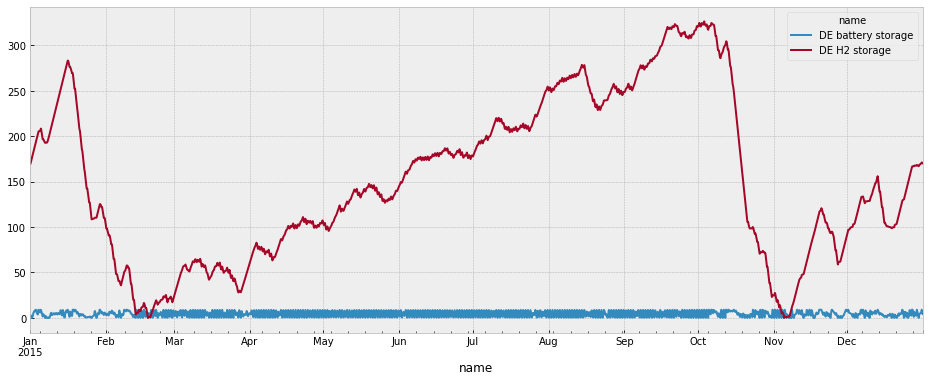

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_operation.stores_t.e.plot(ax=ax)

<AxesSubplot:xlabel='name'>

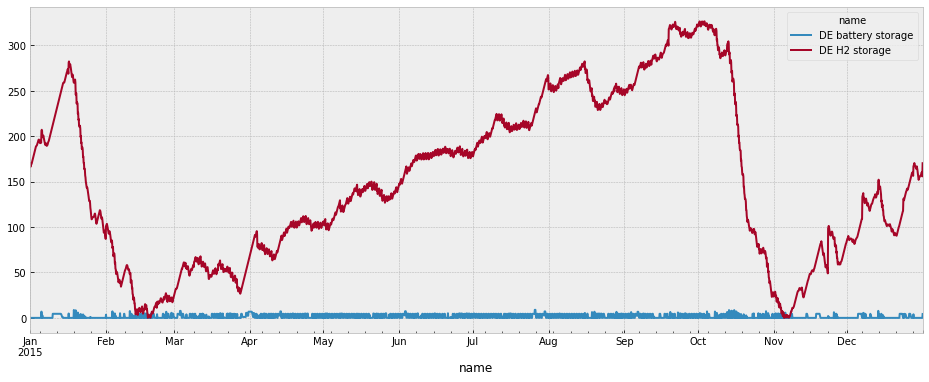

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh_sp_h2.stores_t.e.plot(ax=ax)

<AxesSubplot:xlabel='name'>

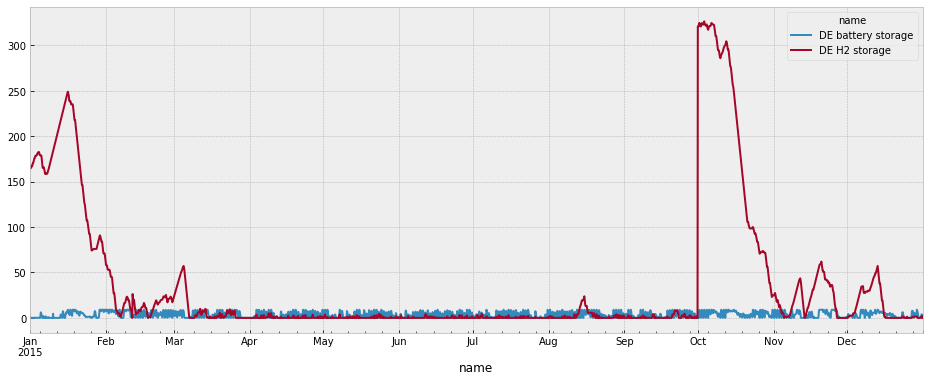

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh.stores_t.e.plot(ax=ax)

<AxesSubplot:xlabel='name'>

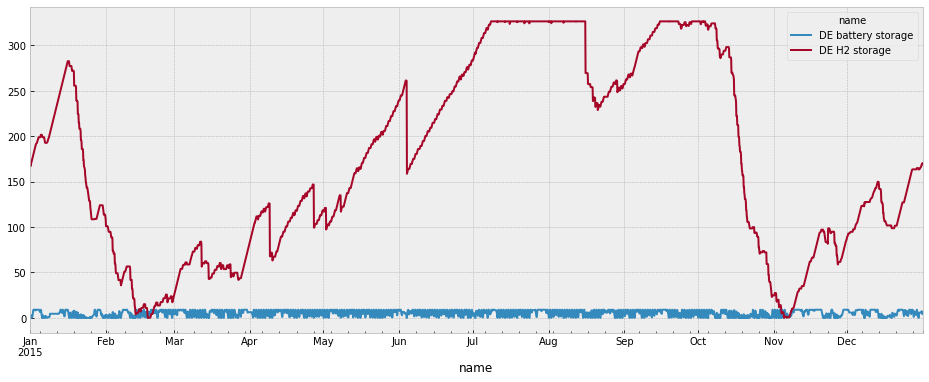

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh_sp_3h.stores_t.e.plot(ax=ax)

<AxesSubplot:xlabel='name'>

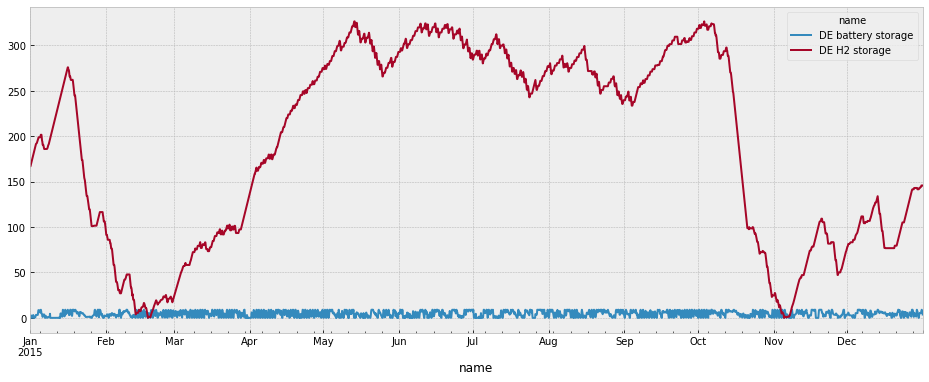

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh_sp_2w.stores_t.e.plot(ax=ax)

<AxesSubplot:xlabel='name'>

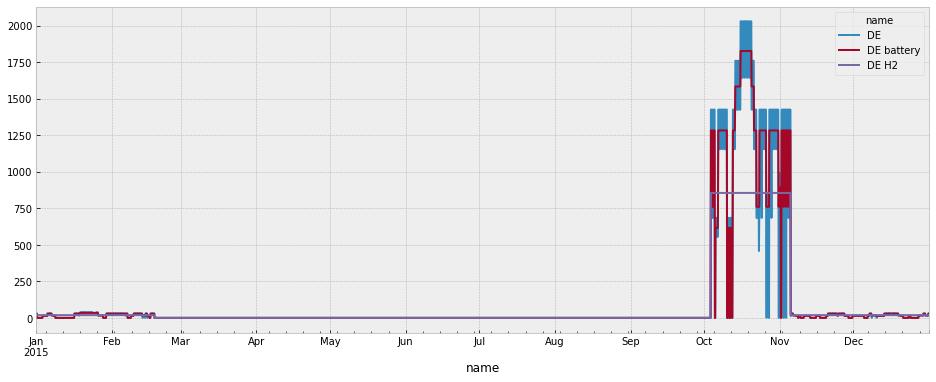

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_operation.buses_t.marginal_price.plot(ax=ax)

<AxesSubplot:xlabel='name'>

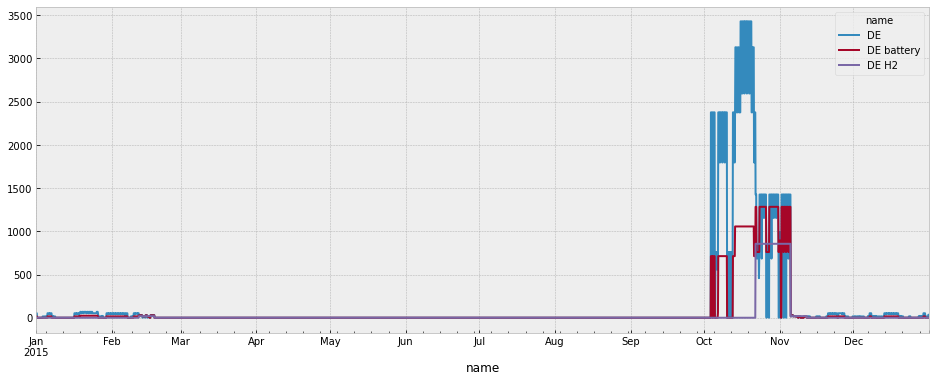

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh_sp_2w.buses_t.marginal_price.plot(ax=ax)

<AxesSubplot:xlabel='name'>

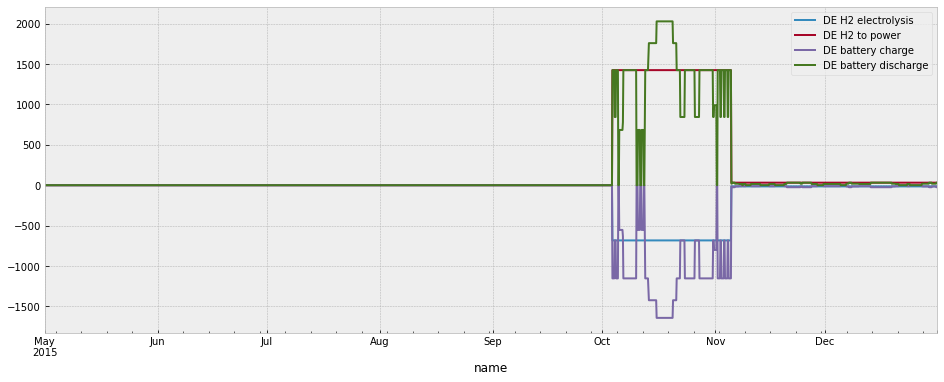

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh_sp_2w.links_t.marginal_cost.loc["2015-05-01 00:00:00":,["DE H2 electrolysis","DE H2 to power", "DE battery charge", "DE battery discharge"]].plot(ax=ax)    

<AxesSubplot:xlabel='name'>

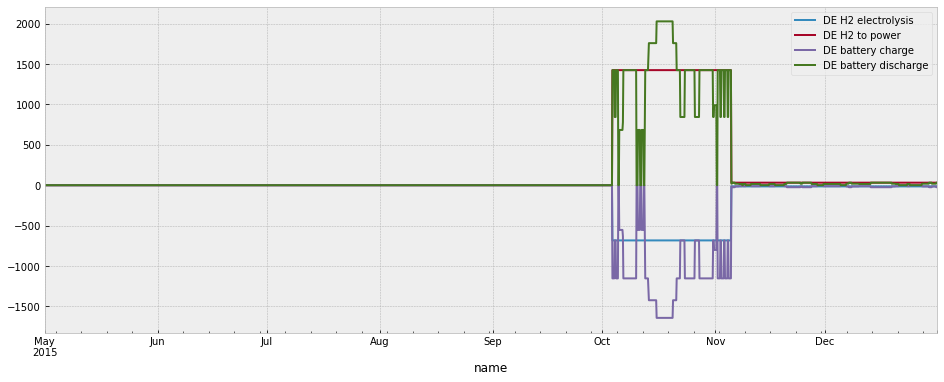

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches((16,6))
n_de_rh_sp_3h.links_t.marginal_cost.loc["2015-05-01 00:00:00":,["DE H2 electrolysis","DE H2 to power", "DE battery charge", "DE battery discharge"]].plot(ax=ax)    